In [ ]:
import gymnasium as gym
import ale_py
from tqdm.notebook import tqdm
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from collections import deque
from ale_py import ALEInterface, roms
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


ale = ALEInterface()
env = gym.make("ALE/Boxing-v5")
class CNN_DQN(nn.Module):
    def __init__(self, action_dim):
        super(CNN_DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim)
        )

    def forward(self, x):
        return self.net(x)
stack_size = 4
frame_stack = deque(maxlen=stack_size)
def preprocess_observation(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)

    obs = cv2.resize(obs, (84, 84))
    return obs / 255.0


def reset_env(env):
    obs, _ = env.reset()
    processed = preprocess_observation(obs)
    for _ in range(stack_size):
        frame_stack.append(processed)
    return np.stack(frame_stack, axis=0)

def step_env(action):
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    processed = preprocess_observation(obs)
    frame_stack.append(processed)
    return np.stack(frame_stack, axis=0), reward, done


    import gc

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            np.array(state, dtype=np.float32),
            action,
            np.float32(reward),
            np.array(next_state, dtype=np.float32),
            done
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)
import gc

def train_boxing_dqn(num_episodes=500):
    env = gym.make("ALE/Boxing-v5", render_mode="rgb_array")
    action_dim = env.action_space.n

    policy_net = CNN_DQN(action_dim).to(device)
    target_net = CNN_DQN(action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    replay_buffer = ReplayBuffer(35000)
    batch_size = 8
    gamma = 0.99

    epsilon_start = 1
    epsilon_final = 0.1
    epsilon_decay = 1_000_000

    update_target_every = 1000
    step_count = 0

    def epsilon_by_step(step):
        return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * step / epsilon_decay)

    def reset_env(env):
        obs, _ = env.reset()
        processed = preprocess_observation(obs)
        frame_stack = deque([processed] * 4, maxlen=4)
        return np.stack(frame_stack, axis=0), frame_stack

    def step_env(env, action, frame_stack):
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        processed = preprocess_observation(obs)
        frame_stack.append(processed)
        return np.stack(frame_stack, axis=0), reward, done, frame_stack

    all_rewards = []

    for episode in tqdm(range(num_episodes), desc="Training Boxing", unit="ep"):
        state, frame_stack = reset_env(env)
        total_reward = 0
        done = False

        while not done:
            epsilon = epsilon_by_step(step_count)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax(1).item()

            next_state, reward, done, frame_stack = step_env(env, action, frame_stack)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.tensor(states, dtype=torch.float32).to(device)
                actions = torch.LongTensor(actions).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = policy_net(states)
                next_q_values = target_net(next_states)

                q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                max_next_q_value = next_q_values.max(1)[0]
                expected_q = rewards + gamma * max_next_q_value * (1 - dones)

                loss = nn.MSELoss()(q_value, expected_q.detach())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                del states, actions, rewards, next_states, dones
                del q_values, next_q_values, q_value, max_next_q_value, expected_q, loss

            if step_count % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

        all_rewards.append(total_reward)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

        if (episode + 1) % 50 == 0:
            torch.save(policy_net.state_dict(), f"boxing_dqn_ep{episode+1}.pth")

        gc.collect()
        torch.cuda.empty_cache()

    env.close()
    torch.save(policy_net.state_dict(), "boxing_dqn.pth")
    print("Koniec treningu, model zapisany jako boxing_dqn.pth'")
    return all_rewards

Using device: cuda


In [ ]:
def continue_training(model_path="boxing_dqn.pth", num_episodes=300, start_episode=1100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("ALE/Boxing-v5", render_mode="rgb_array")
    action_dim = env.action_space.n

    policy_net = CNN_DQN(action_dim).to(device)
    target_net = CNN_DQN(action_dim).to(device)

    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    policy_net.load_state_dict(checkpoint["model_state_dict"])
    target_net.load_state_dict(checkpoint["target_model_state_dict"])

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    step_count = checkpoint.get("step_count", 0)

    replay_buffer = ReplayBuffer(40_000)

    batch_size = 8
    gamma = 0.99

    epsilon_start = 0.6
    epsilon_final = 0.05
    epsilon_decay = 1_500_000
    update_target_every = 1000

    def epsilon_by_step(step):
        return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * step / epsilon_decay)

    def reset_env(env):
        obs, _ = env.reset()
        processed = preprocess_observation(obs)
        frame_stack = deque([processed] * 4, maxlen=4)
        return np.stack(frame_stack, axis=0), frame_stack

    def step_env(env, action, frame_stack):
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        processed = preprocess_observation(obs)
        frame_stack.append(processed)
        return np.stack(frame_stack, axis=0), reward, done, frame_stack

    all_rewards = []

    for episode in tqdm(range(start_episode, start_episode + num_episodes), desc="📈 Kontynuacja treningu", unit="ep"):
        state, frame_stack = reset_env(env)
        total_reward = 0
        done = False

        while not done:
            epsilon = epsilon_by_step(step_count)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax(1).item()

            next_state, reward, done, frame_stack = step_env(env, action, frame_stack)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.tensor(states, dtype=torch.float32).to(device)
                actions = torch.LongTensor(actions).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = policy_net(states)
                next_q_values = target_net(next_states)

                q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                max_next_q_value = next_q_values.max(1)[0]
                expected_q = rewards + gamma * max_next_q_value * (1 - dones)

                loss = nn.MSELoss()(q_value, expected_q.detach())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                del states, actions, rewards, next_states, dones
                del q_values, next_q_values, q_value, max_next_q_value, expected_q, loss

            if step_count % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

        all_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

    env.close()

    # Save updated state
    torch.save({
        "model_state_dict": policy_net.state_dict(),
        "target_model_state_dict": target_net.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "step_count": step_count
    }, model_path)


    print("Trening zakończony — model, target_net i optimizer zapisane")
    return all_rewards


In [ ]:
all_rewards3rd = continue_training(model_path="boxing_dqn_master.pth", num_episodes=3000, start_episode=2100)

🔌 Używane urządzenie: cuda


📈 Kontynuacja treningu:   0%|          | 1/3000 [00:10<8:48:31, 10.57s/ep]

Episode 2101: Reward = 43.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 2/3000 [00:21<8:59:01, 10.79s/ep]

Episode 2102: Reward = 13.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 3/3000 [00:29<8:03:12,  9.67s/ep]

Episode 2103: Reward = 40.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 4/3000 [00:42<8:58:41, 10.79s/ep]

Episode 2104: Reward = -24.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 5/3000 [00:53<9:10:41, 11.03s/ep]

Episode 2105: Reward = 16.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 6/3000 [01:05<9:17:09, 11.17s/ep]

Episode 2106: Reward = 12.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 7/3000 [01:13<8:34:11, 10.31s/ep]

Episode 2107: Reward = 43.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 8/3000 [01:25<8:49:00, 10.61s/ep]

Episode 2108: Reward = -39.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 9/3000 [01:36<9:02:16, 10.88s/ep]

Episode 2109: Reward = 26.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 10/3000 [01:44<8:14:34,  9.92s/ep]

Episode 2110: Reward = 30.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 11/3000 [01:50<7:22:51,  8.89s/ep]

Episode 2111: Reward = 50.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 12/3000 [02:02<8:01:08,  9.66s/ep]

Episode 2112: Reward = 10.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 13/3000 [02:11<7:51:57,  9.48s/ep]

Episode 2113: Reward = 15.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 14/3000 [02:18<7:16:14,  8.77s/ep]

Episode 2114: Reward = 63.00, Epsilon = 0.080


📈 Kontynuacja treningu:   0%|          | 15/3000 [02:24<6:42:12,  8.08s/ep]

Episode 2115: Reward = 49.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 16/3000 [02:34<6:59:31,  8.44s/ep]

Episode 2116: Reward = 48.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 17/3000 [02:42<6:53:46,  8.32s/ep]

Episode 2117: Reward = 51.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 18/3000 [02:53<7:43:32,  9.33s/ep]

Episode 2118: Reward = 0.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 19/3000 [02:59<6:44:54,  8.15s/ep]

Episode 2119: Reward = 64.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 20/3000 [03:07<6:40:23,  8.06s/ep]

Episode 2120: Reward = 54.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 21/3000 [03:17<7:16:01,  8.78s/ep]

Episode 2121: Reward = 22.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 22/3000 [03:27<7:38:28,  9.24s/ep]

Episode 2122: Reward = 41.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 23/3000 [03:36<7:25:06,  8.97s/ep]

Episode 2123: Reward = 49.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 24/3000 [03:44<7:12:12,  8.71s/ep]

Episode 2124: Reward = 48.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 25/3000 [03:53<7:17:23,  8.82s/ep]

Episode 2125: Reward = 40.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 26/3000 [04:01<7:03:29,  8.54s/ep]

Episode 2126: Reward = 41.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 27/3000 [04:08<6:48:37,  8.25s/ep]

Episode 2127: Reward = 54.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 28/3000 [04:20<7:42:58,  9.35s/ep]

Episode 2128: Reward = 5.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 29/3000 [04:26<6:50:09,  8.28s/ep]

Episode 2129: Reward = 57.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 30/3000 [04:38<7:35:51,  9.21s/ep]

Episode 2130: Reward = 21.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 31/3000 [04:44<6:55:29,  8.40s/ep]

Episode 2131: Reward = 35.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 32/3000 [04:51<6:39:58,  8.09s/ep]

Episode 2132: Reward = 46.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 33/3000 [04:55<5:40:08,  6.88s/ep]

Episode 2133: Reward = 71.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 34/3000 [05:03<5:44:03,  6.96s/ep]

Episode 2134: Reward = 64.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 35/3000 [05:14<6:50:33,  8.31s/ep]

Episode 2135: Reward = -2.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 36/3000 [05:25<7:36:48,  9.25s/ep]

Episode 2136: Reward = -1.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|          | 37/3000 [05:32<6:50:38,  8.32s/ep]

Episode 2137: Reward = 51.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 38/3000 [05:38<6:28:49,  7.88s/ep]

Episode 2138: Reward = 46.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 39/3000 [05:46<6:23:23,  7.77s/ep]

Episode 2139: Reward = 42.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 40/3000 [05:55<6:34:41,  8.00s/ep]

Episode 2140: Reward = 58.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 41/3000 [06:02<6:25:27,  7.82s/ep]

Episode 2141: Reward = 29.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 42/3000 [06:10<6:29:07,  7.89s/ep]

Episode 2142: Reward = 45.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 43/3000 [06:21<7:21:11,  8.95s/ep]

Episode 2143: Reward = -2.00, Epsilon = 0.079


📈 Kontynuacja treningu:   1%|▏         | 44/3000 [06:28<6:50:34,  8.33s/ep]

Episode 2144: Reward = 49.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 45/3000 [06:35<6:26:16,  7.84s/ep]

Episode 2145: Reward = 34.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 46/3000 [06:43<6:28:16,  7.89s/ep]

Episode 2146: Reward = 42.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 47/3000 [06:47<5:30:18,  6.71s/ep]

Episode 2147: Reward = 63.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 48/3000 [06:55<5:51:03,  7.14s/ep]

Episode 2148: Reward = 39.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 49/3000 [07:03<6:03:55,  7.40s/ep]

Episode 2149: Reward = 25.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 50/3000 [07:09<5:47:12,  7.06s/ep]

Episode 2150: Reward = 63.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 51/3000 [07:21<6:52:18,  8.39s/ep]

Episode 2151: Reward = -31.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 52/3000 [07:28<6:28:59,  7.92s/ep]

Episode 2152: Reward = 27.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 53/3000 [07:34<6:03:24,  7.40s/ep]

Episode 2153: Reward = 48.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 54/3000 [07:40<5:50:53,  7.15s/ep]

Episode 2154: Reward = 32.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 55/3000 [07:52<6:54:50,  8.45s/ep]

Episode 2155: Reward = 6.00, Epsilon = 0.079


📈 Kontynuacja treningu:   2%|▏         | 56/3000 [07:58<6:14:02,  7.62s/ep]

Episode 2156: Reward = 65.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 57/3000 [08:05<6:15:52,  7.66s/ep]

Episode 2157: Reward = 43.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 58/3000 [08:13<6:13:01,  7.61s/ep]

Episode 2158: Reward = 66.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 59/3000 [08:24<7:04:20,  8.66s/ep]

Episode 2159: Reward = -2.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 60/3000 [08:31<6:46:10,  8.29s/ep]

Episode 2160: Reward = 35.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 61/3000 [08:38<6:16:14,  7.68s/ep]

Episode 2161: Reward = 48.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 62/3000 [08:46<6:32:55,  8.02s/ep]

Episode 2162: Reward = 42.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 63/3000 [08:58<7:23:46,  9.07s/ep]

Episode 2163: Reward = 5.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 64/3000 [09:06<7:11:39,  8.82s/ep]

Episode 2164: Reward = 35.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 65/3000 [09:13<6:46:14,  8.30s/ep]

Episode 2165: Reward = 49.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 66/3000 [09:21<6:41:36,  8.21s/ep]

Episode 2166: Reward = 26.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 67/3000 [09:29<6:29:33,  7.97s/ep]

Episode 2167: Reward = 39.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 68/3000 [09:35<6:01:07,  7.39s/ep]

Episode 2168: Reward = 50.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 69/3000 [09:41<5:41:09,  6.98s/ep]

Episode 2169: Reward = 50.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 70/3000 [09:49<5:57:05,  7.31s/ep]

Episode 2170: Reward = 51.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 71/3000 [09:57<6:03:26,  7.45s/ep]

Episode 2171: Reward = 41.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 72/3000 [10:05<6:13:34,  7.66s/ep]

Episode 2172: Reward = 25.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 73/3000 [10:13<6:17:20,  7.74s/ep]

Episode 2173: Reward = 36.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▏         | 74/3000 [10:19<6:01:50,  7.42s/ep]

Episode 2174: Reward = 40.00, Epsilon = 0.078


📈 Kontynuacja treningu:   2%|▎         | 75/3000 [10:27<6:08:38,  7.56s/ep]

Episode 2175: Reward = 41.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 76/3000 [10:35<6:12:42,  7.65s/ep]

Episode 2176: Reward = 36.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 77/3000 [10:46<7:01:21,  8.65s/ep]

Episode 2177: Reward = 23.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 78/3000 [10:54<6:43:56,  8.29s/ep]

Episode 2178: Reward = 40.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 79/3000 [10:58<5:45:10,  7.09s/ep]

Episode 2179: Reward = 59.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 80/3000 [11:04<5:32:15,  6.83s/ep]

Episode 2180: Reward = 53.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 81/3000 [11:12<5:52:55,  7.25s/ep]

Episode 2181: Reward = 40.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 82/3000 [11:17<5:18:26,  6.55s/ep]

Episode 2182: Reward = 56.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 83/3000 [11:24<5:25:31,  6.70s/ep]

Episode 2183: Reward = 40.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 84/3000 [11:30<5:14:44,  6.48s/ep]

Episode 2184: Reward = 61.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 85/3000 [11:37<5:16:44,  6.52s/ep]

Episode 2185: Reward = 59.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 86/3000 [11:48<6:27:49,  7.99s/ep]

Episode 2186: Reward = 33.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 87/3000 [11:54<5:52:04,  7.25s/ep]

Episode 2187: Reward = 68.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 88/3000 [12:00<5:29:51,  6.80s/ep]

Episode 2188: Reward = 59.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 89/3000 [12:08<5:55:27,  7.33s/ep]

Episode 2189: Reward = 54.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 90/3000 [12:16<6:01:26,  7.45s/ep]

Episode 2190: Reward = 51.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 91/3000 [12:25<6:30:20,  8.05s/ep]

Episode 2191: Reward = 64.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 92/3000 [12:32<6:10:13,  7.64s/ep]

Episode 2192: Reward = 45.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 93/3000 [12:37<5:31:40,  6.85s/ep]

Episode 2193: Reward = 57.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 94/3000 [12:44<5:29:43,  6.81s/ep]

Episode 2194: Reward = 55.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 95/3000 [12:51<5:38:32,  6.99s/ep]

Episode 2195: Reward = 30.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 96/3000 [12:55<4:57:36,  6.15s/ep]

Episode 2196: Reward = 69.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 97/3000 [13:00<4:40:45,  5.80s/ep]

Episode 2197: Reward = 60.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 98/3000 [13:07<4:54:04,  6.08s/ep]

Episode 2198: Reward = 46.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 99/3000 [13:15<5:21:30,  6.65s/ep]

Episode 2199: Reward = 42.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 100/3000 [13:22<5:29:45,  6.82s/ep]

Episode 2200: Reward = 59.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 101/3000 [13:29<5:33:53,  6.91s/ep]

Episode 2201: Reward = 43.00, Epsilon = 0.078


📈 Kontynuacja treningu:   3%|▎         | 102/3000 [13:37<5:49:48,  7.24s/ep]

Episode 2202: Reward = 35.00, Epsilon = 0.077


📈 Kontynuacja treningu:   3%|▎         | 103/3000 [13:44<5:35:47,  6.95s/ep]

Episode 2203: Reward = 41.00, Epsilon = 0.077


📈 Kontynuacja treningu:   3%|▎         | 104/3000 [13:47<4:43:57,  5.88s/ep]

Episode 2204: Reward = 78.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 105/3000 [13:51<4:23:36,  5.46s/ep]

Episode 2205: Reward = 86.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 106/3000 [14:03<5:47:28,  7.20s/ep]

Episode 2206: Reward = 16.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 107/3000 [14:09<5:35:07,  6.95s/ep]

Episode 2207: Reward = 57.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 108/3000 [14:13<4:46:01,  5.93s/ep]

Episode 2208: Reward = 79.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 109/3000 [14:21<5:19:27,  6.63s/ep]

Episode 2209: Reward = 35.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 110/3000 [14:31<6:08:40,  7.65s/ep]

Episode 2210: Reward = 35.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 111/3000 [14:37<5:39:27,  7.05s/ep]

Episode 2211: Reward = 41.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▎         | 112/3000 [14:44<5:49:13,  7.26s/ep]

Episode 2212: Reward = 68.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 113/3000 [14:56<6:51:03,  8.54s/ep]

Episode 2213: Reward = -8.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 114/3000 [15:00<5:46:47,  7.21s/ep]

Episode 2214: Reward = 70.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 115/3000 [15:07<5:44:29,  7.16s/ep]

Episode 2215: Reward = 34.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 116/3000 [15:15<6:02:19,  7.54s/ep]

Episode 2216: Reward = 43.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 117/3000 [15:27<6:58:03,  8.70s/ep]

Episode 2217: Reward = 29.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 118/3000 [15:38<7:39:37,  9.57s/ep]

Episode 2218: Reward = 32.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 119/3000 [15:47<7:21:32,  9.20s/ep]

Episode 2219: Reward = 34.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 120/3000 [15:53<6:32:45,  8.18s/ep]

Episode 2220: Reward = 51.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 121/3000 [15:59<6:06:13,  7.63s/ep]

Episode 2221: Reward = 55.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 122/3000 [16:06<5:52:00,  7.34s/ep]

Episode 2222: Reward = 49.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 123/3000 [16:16<6:37:55,  8.30s/ep]

Episode 2223: Reward = 2.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 124/3000 [16:22<6:08:29,  7.69s/ep]

Episode 2224: Reward = 57.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 125/3000 [16:30<6:01:01,  7.53s/ep]

Episode 2225: Reward = 46.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 126/3000 [16:33<5:01:21,  6.29s/ep]

Episode 2226: Reward = 68.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 127/3000 [16:42<5:41:19,  7.13s/ep]

Episode 2227: Reward = 44.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 128/3000 [16:46<5:02:01,  6.31s/ep]

Episode 2228: Reward = 83.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 129/3000 [16:54<5:26:14,  6.82s/ep]

Episode 2229: Reward = 53.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 130/3000 [16:59<4:57:33,  6.22s/ep]

Episode 2230: Reward = 75.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 131/3000 [17:08<5:31:34,  6.93s/ep]

Episode 2231: Reward = 32.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 132/3000 [17:14<5:13:46,  6.56s/ep]

Episode 2232: Reward = 48.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 133/3000 [17:18<4:47:54,  6.03s/ep]

Episode 2233: Reward = 62.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 134/3000 [17:23<4:22:48,  5.50s/ep]

Episode 2234: Reward = 69.00, Epsilon = 0.077


📈 Kontynuacja treningu:   4%|▍         | 135/3000 [17:28<4:25:07,  5.55s/ep]

Episode 2235: Reward = 56.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 136/3000 [17:36<4:49:52,  6.07s/ep]

Episode 2236: Reward = 49.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 137/3000 [17:40<4:30:40,  5.67s/ep]

Episode 2237: Reward = 72.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 138/3000 [17:46<4:24:05,  5.54s/ep]

Episode 2238: Reward = 66.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 139/3000 [17:52<4:41:25,  5.90s/ep]

Episode 2239: Reward = 58.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 140/3000 [18:03<5:50:03,  7.34s/ep]

Episode 2240: Reward = 36.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 141/3000 [18:11<5:59:59,  7.55s/ep]

Episode 2241: Reward = 43.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 142/3000 [18:16<5:28:55,  6.91s/ep]

Episode 2242: Reward = 51.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 143/3000 [18:24<5:36:50,  7.07s/ep]

Episode 2243: Reward = 70.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 144/3000 [18:30<5:19:08,  6.70s/ep]

Episode 2244: Reward = 72.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 145/3000 [18:40<6:05:31,  7.68s/ep]

Episode 2245: Reward = 26.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 146/3000 [18:43<5:08:36,  6.49s/ep]

Episode 2246: Reward = 72.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 147/3000 [18:54<6:00:30,  7.58s/ep]

Episode 2247: Reward = 32.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 148/3000 [19:01<6:01:50,  7.61s/ep]

Episode 2248: Reward = 33.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▍         | 149/3000 [19:07<5:34:58,  7.05s/ep]

Episode 2249: Reward = 71.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▌         | 150/3000 [19:19<6:39:54,  8.42s/ep]

Episode 2250: Reward = 14.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▌         | 151/3000 [19:30<7:23:44,  9.35s/ep]

Episode 2251: Reward = 7.00, Epsilon = 0.077


📈 Kontynuacja treningu:   5%|▌         | 152/3000 [19:41<7:50:43,  9.92s/ep]

Episode 2252: Reward = 19.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 153/3000 [19:47<6:48:00,  8.60s/ep]

Episode 2253: Reward = 66.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 154/3000 [19:57<7:09:54,  9.06s/ep]

Episode 2254: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 155/3000 [20:07<7:27:22,  9.43s/ep]

Episode 2255: Reward = 34.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 156/3000 [20:14<6:54:32,  8.75s/ep]

Episode 2256: Reward = 46.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 157/3000 [20:19<5:59:11,  7.58s/ep]

Episode 2257: Reward = 73.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 158/3000 [20:25<5:25:52,  6.88s/ep]

Episode 2258: Reward = 66.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 159/3000 [20:32<5:38:07,  7.14s/ep]

Episode 2259: Reward = 39.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 160/3000 [20:37<4:56:41,  6.27s/ep]

Episode 2260: Reward = 87.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 161/3000 [20:48<6:12:17,  7.87s/ep]

Episode 2261: Reward = 0.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 162/3000 [20:51<5:02:14,  6.39s/ep]

Episode 2262: Reward = 85.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 163/3000 [20:58<5:12:07,  6.60s/ep]

Episode 2263: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:   5%|▌         | 164/3000 [21:09<6:07:30,  7.78s/ep]

Episode 2264: Reward = 15.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 165/3000 [21:14<5:37:00,  7.13s/ep]

Episode 2265: Reward = 49.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 166/3000 [21:20<5:20:15,  6.78s/ep]

Episode 2266: Reward = 46.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 167/3000 [21:27<5:20:48,  6.79s/ep]

Episode 2267: Reward = 51.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 168/3000 [21:34<5:25:43,  6.90s/ep]

Episode 2268: Reward = 49.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 169/3000 [21:42<5:31:24,  7.02s/ep]

Episode 2269: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 170/3000 [21:46<4:48:46,  6.12s/ep]

Episode 2270: Reward = 85.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 171/3000 [21:56<5:49:09,  7.41s/ep]

Episode 2271: Reward = 36.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 172/3000 [22:08<6:47:48,  8.65s/ep]

Episode 2272: Reward = -10.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 173/3000 [22:14<6:11:40,  7.89s/ep]

Episode 2273: Reward = 36.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 174/3000 [22:20<5:51:17,  7.46s/ep]

Episode 2274: Reward = 28.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 175/3000 [22:24<4:59:46,  6.37s/ep]

Episode 2275: Reward = 69.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 176/3000 [22:31<5:07:51,  6.54s/ep]

Episode 2276: Reward = 41.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 177/3000 [22:36<4:48:23,  6.13s/ep]

Episode 2277: Reward = 67.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 178/3000 [22:42<4:41:56,  5.99s/ep]

Episode 2278: Reward = 49.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 179/3000 [22:50<5:20:18,  6.81s/ep]

Episode 2279: Reward = 52.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 180/3000 [23:02<6:26:21,  8.22s/ep]

Episode 2280: Reward = 38.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 181/3000 [23:11<6:42:27,  8.57s/ep]

Episode 2281: Reward = 17.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 182/3000 [23:19<6:31:43,  8.34s/ep]

Episode 2282: Reward = 64.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 183/3000 [23:26<6:07:38,  7.83s/ep]

Episode 2283: Reward = 46.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 184/3000 [23:29<4:59:53,  6.39s/ep]

Episode 2284: Reward = 82.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 185/3000 [23:35<4:52:36,  6.24s/ep]

Episode 2285: Reward = 37.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 186/3000 [23:39<4:31:59,  5.80s/ep]

Episode 2286: Reward = 61.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▌         | 187/3000 [23:43<3:56:09,  5.04s/ep]

Episode 2287: Reward = 83.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 188/3000 [23:46<3:29:01,  4.46s/ep]

Episode 2288: Reward = 81.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 189/3000 [23:51<3:42:39,  4.75s/ep]

Episode 2289: Reward = 70.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 190/3000 [23:54<3:14:56,  4.16s/ep]

Episode 2290: Reward = 90.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 191/3000 [23:58<3:05:01,  3.95s/ep]

Episode 2291: Reward = 77.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 192/3000 [24:04<3:35:32,  4.61s/ep]

Episode 2292: Reward = 66.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 193/3000 [24:13<4:35:33,  5.89s/ep]

Episode 2293: Reward = 21.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 194/3000 [24:24<5:54:33,  7.58s/ep]

Episode 2294: Reward = 10.00, Epsilon = 0.076


📈 Kontynuacja treningu:   6%|▋         | 195/3000 [24:31<5:40:25,  7.28s/ep]

Episode 2295: Reward = 41.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 196/3000 [24:38<5:43:10,  7.34s/ep]

Episode 2296: Reward = 57.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 197/3000 [24:46<5:52:43,  7.55s/ep]

Episode 2297: Reward = 16.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 198/3000 [24:54<5:51:54,  7.54s/ep]

Episode 2298: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 199/3000 [25:05<6:42:02,  8.61s/ep]

Episode 2299: Reward = 0.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 200/3000 [25:14<6:53:28,  8.86s/ep]

Episode 2300: Reward = 36.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 201/3000 [25:18<5:41:24,  7.32s/ep]

Episode 2301: Reward = 70.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 202/3000 [25:26<5:56:52,  7.65s/ep]

Episode 2302: Reward = 43.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 203/3000 [25:38<6:52:01,  8.84s/ep]

Episode 2303: Reward = -16.00, Epsilon = 0.076


📈 Kontynuacja treningu:   7%|▋         | 204/3000 [25:45<6:21:40,  8.19s/ep]

Episode 2304: Reward = 47.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 205/3000 [25:48<5:18:06,  6.83s/ep]

Episode 2305: Reward = 75.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 206/3000 [25:55<5:12:26,  6.71s/ep]

Episode 2306: Reward = 35.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 207/3000 [26:02<5:26:18,  7.01s/ep]

Episode 2307: Reward = 39.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 208/3000 [26:14<6:30:19,  8.39s/ep]

Episode 2308: Reward = -6.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 209/3000 [26:19<5:35:45,  7.22s/ep]

Episode 2309: Reward = 71.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 210/3000 [26:21<4:31:29,  5.84s/ep]

Episode 2310: Reward = 88.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 211/3000 [26:29<4:53:02,  6.30s/ep]

Episode 2311: Reward = 42.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 212/3000 [26:36<5:14:35,  6.77s/ep]

Episode 2312: Reward = 36.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 213/3000 [26:45<5:40:49,  7.34s/ep]

Episode 2313: Reward = 26.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 214/3000 [26:48<4:39:00,  6.01s/ep]

Episode 2314: Reward = 81.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 215/3000 [26:56<5:01:22,  6.49s/ep]

Episode 2315: Reward = 26.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 216/3000 [27:04<5:26:32,  7.04s/ep]

Episode 2316: Reward = 28.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 217/3000 [27:15<6:23:45,  8.27s/ep]

Episode 2317: Reward = -33.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 218/3000 [27:21<5:45:03,  7.44s/ep]

Episode 2318: Reward = 61.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 219/3000 [27:23<4:41:13,  6.07s/ep]

Episode 2319: Reward = 84.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 220/3000 [27:27<4:07:46,  5.35s/ep]

Episode 2320: Reward = 74.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 221/3000 [27:35<4:36:53,  5.98s/ep]

Episode 2321: Reward = 44.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 222/3000 [27:40<4:34:55,  5.94s/ep]

Episode 2322: Reward = 51.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 223/3000 [27:45<4:11:26,  5.43s/ep]

Episode 2323: Reward = 79.00, Epsilon = 0.075


📈 Kontynuacja treningu:   7%|▋         | 224/3000 [27:53<4:51:01,  6.29s/ep]

Episode 2324: Reward = 35.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 225/3000 [28:00<5:07:05,  6.64s/ep]

Episode 2325: Reward = 35.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 226/3000 [28:07<5:06:49,  6.64s/ep]

Episode 2326: Reward = 45.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 227/3000 [28:12<4:36:41,  5.99s/ep]

Episode 2327: Reward = 71.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 228/3000 [28:14<3:45:06,  4.87s/ep]

Episode 2328: Reward = 90.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 229/3000 [28:25<5:17:36,  6.88s/ep]

Episode 2329: Reward = -32.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 230/3000 [28:30<4:41:16,  6.09s/ep]

Episode 2330: Reward = 68.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 231/3000 [28:39<5:22:42,  6.99s/ep]

Episode 2331: Reward = 31.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 232/3000 [28:43<4:42:14,  6.12s/ep]

Episode 2332: Reward = 77.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 233/3000 [28:49<4:41:26,  6.10s/ep]

Episode 2333: Reward = 73.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 234/3000 [28:56<5:00:39,  6.52s/ep]

Episode 2334: Reward = 36.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 235/3000 [29:08<6:10:45,  8.05s/ep]

Episode 2335: Reward = 6.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 236/3000 [29:13<5:24:49,  7.05s/ep]

Episode 2336: Reward = 56.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 237/3000 [29:18<4:57:27,  6.46s/ep]

Episode 2337: Reward = 67.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 238/3000 [29:26<5:27:28,  7.11s/ep]

Episode 2338: Reward = 25.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 239/3000 [29:33<5:20:08,  6.96s/ep]

Episode 2339: Reward = 69.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 240/3000 [29:40<5:19:09,  6.94s/ep]

Episode 2340: Reward = 37.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 241/3000 [29:46<5:01:10,  6.55s/ep]

Episode 2341: Reward = 61.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 242/3000 [29:51<4:45:52,  6.22s/ep]

Episode 2342: Reward = 39.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 243/3000 [29:59<5:08:47,  6.72s/ep]

Episode 2343: Reward = 34.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 244/3000 [30:04<4:52:26,  6.37s/ep]

Episode 2344: Reward = 54.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 245/3000 [30:14<5:33:56,  7.27s/ep]

Episode 2345: Reward = 30.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 246/3000 [30:17<4:44:29,  6.20s/ep]

Episode 2346: Reward = 81.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 247/3000 [30:26<5:18:21,  6.94s/ep]

Episode 2347: Reward = 48.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 248/3000 [30:35<5:47:42,  7.58s/ep]

Episode 2348: Reward = 32.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 249/3000 [30:38<4:38:05,  6.07s/ep]

Episode 2349: Reward = 89.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 250/3000 [30:49<5:54:16,  7.73s/ep]

Episode 2350: Reward = 17.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 251/3000 [31:00<6:29:19,  8.50s/ep]

Episode 2351: Reward = 28.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 252/3000 [31:07<6:19:20,  8.28s/ep]

Episode 2352: Reward = 42.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 253/3000 [31:12<5:25:23,  7.11s/ep]

Episode 2353: Reward = 81.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 254/3000 [31:17<4:54:40,  6.44s/ep]

Episode 2354: Reward = 52.00, Epsilon = 0.075


📈 Kontynuacja treningu:   8%|▊         | 255/3000 [31:19<4:04:33,  5.35s/ep]

Episode 2355: Reward = 92.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 256/3000 [31:31<5:28:32,  7.18s/ep]

Episode 2356: Reward = -2.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 257/3000 [31:34<4:32:50,  5.97s/ep]

Episode 2357: Reward = 87.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 258/3000 [31:38<4:02:25,  5.30s/ep]

Episode 2358: Reward = 80.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 259/3000 [31:44<4:14:41,  5.57s/ep]

Episode 2359: Reward = 47.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 260/3000 [31:56<5:35:52,  7.35s/ep]

Episode 2360: Reward = 12.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 261/3000 [32:04<5:49:25,  7.65s/ep]

Episode 2361: Reward = 33.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▊         | 262/3000 [32:08<4:59:33,  6.56s/ep]

Episode 2362: Reward = 85.00, Epsilon = 0.075


📈 Kontynuacja treningu:   9%|▉         | 263/3000 [32:14<4:55:34,  6.48s/ep]

Episode 2363: Reward = 39.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 264/3000 [32:26<6:04:46,  8.00s/ep]

Episode 2364: Reward = -1.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 265/3000 [32:32<5:37:31,  7.40s/ep]

Episode 2365: Reward = 59.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 266/3000 [32:38<5:22:52,  7.09s/ep]

Episode 2366: Reward = 52.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 267/3000 [32:47<5:40:57,  7.49s/ep]

Episode 2367: Reward = 31.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 268/3000 [32:55<5:54:31,  7.79s/ep]

Episode 2368: Reward = 37.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 269/3000 [32:58<4:47:04,  6.31s/ep]

Episode 2369: Reward = 91.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 270/3000 [33:01<3:57:28,  5.22s/ep]

Episode 2370: Reward = 90.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 271/3000 [33:07<4:10:45,  5.51s/ep]

Episode 2371: Reward = 54.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 272/3000 [33:15<4:47:46,  6.33s/ep]

Episode 2372: Reward = 31.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 273/3000 [33:23<5:14:00,  6.91s/ep]

Episode 2373: Reward = 37.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 274/3000 [33:34<6:09:08,  8.12s/ep]

Episode 2374: Reward = 2.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 275/3000 [33:46<6:52:40,  9.09s/ep]

Episode 2375: Reward = -11.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 276/3000 [33:57<7:25:45,  9.82s/ep]

Episode 2376: Reward = -16.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 277/3000 [34:06<7:20:07,  9.70s/ep]

Episode 2377: Reward = 34.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 278/3000 [34:18<7:46:00, 10.27s/ep]

Episode 2378: Reward = 5.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 279/3000 [34:27<7:33:27, 10.00s/ep]

Episode 2379: Reward = 29.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 280/3000 [34:34<6:49:22,  9.03s/ep]

Episode 2380: Reward = 45.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 281/3000 [34:41<6:16:33,  8.31s/ep]

Episode 2381: Reward = 29.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 282/3000 [34:48<6:04:44,  8.05s/ep]

Episode 2382: Reward = 41.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 283/3000 [34:57<6:07:57,  8.13s/ep]

Episode 2383: Reward = 16.00, Epsilon = 0.074


📈 Kontynuacja treningu:   9%|▉         | 284/3000 [35:03<5:37:56,  7.47s/ep]

Episode 2384: Reward = 71.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 285/3000 [35:05<4:26:42,  5.89s/ep]

Episode 2385: Reward = 91.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 286/3000 [35:11<4:32:46,  6.03s/ep]

Episode 2386: Reward = 57.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 287/3000 [35:20<5:07:22,  6.80s/ep]

Episode 2387: Reward = 36.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 288/3000 [35:23<4:17:11,  5.69s/ep]

Episode 2388: Reward = 79.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 289/3000 [35:26<3:42:19,  4.92s/ep]

Episode 2389: Reward = 83.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 290/3000 [35:33<4:04:37,  5.42s/ep]

Episode 2390: Reward = 43.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 291/3000 [35:37<3:47:04,  5.03s/ep]

Episode 2391: Reward = 63.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 292/3000 [35:45<4:27:58,  5.94s/ep]

Episode 2392: Reward = 36.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 293/3000 [35:54<5:09:37,  6.86s/ep]

Episode 2393: Reward = 42.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 294/3000 [36:05<6:11:43,  8.24s/ep]

Episode 2394: Reward = 20.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 295/3000 [36:09<5:10:00,  6.88s/ep]

Episode 2395: Reward = 81.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 296/3000 [36:19<5:47:56,  7.72s/ep]

Episode 2396: Reward = 15.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 297/3000 [36:23<5:10:02,  6.88s/ep]

Episode 2397: Reward = 50.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 298/3000 [36:29<4:53:20,  6.51s/ep]

Episode 2398: Reward = 80.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|▉         | 299/3000 [36:33<4:12:03,  5.60s/ep]

Episode 2399: Reward = 81.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 300/3000 [36:44<5:32:21,  7.39s/ep]

Episode 2400: Reward = 13.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 301/3000 [36:54<6:05:48,  8.13s/ep]

Episode 2401: Reward = 24.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 302/3000 [37:01<5:45:52,  7.69s/ep]

Episode 2402: Reward = 57.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 303/3000 [37:12<6:37:14,  8.84s/ep]

Episode 2403: Reward = 0.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 304/3000 [37:19<6:08:12,  8.19s/ep]

Episode 2404: Reward = 64.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 305/3000 [37:26<5:59:18,  8.00s/ep]

Episode 2405: Reward = 43.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 306/3000 [37:31<5:17:08,  7.06s/ep]

Episode 2406: Reward = 72.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 307/3000 [37:41<5:58:36,  7.99s/ep]

Episode 2407: Reward = 39.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 308/3000 [37:50<6:08:48,  8.22s/ep]

Episode 2408: Reward = 38.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 309/3000 [37:58<6:01:05,  8.05s/ep]

Episode 2409: Reward = 37.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 310/3000 [38:04<5:34:08,  7.45s/ep]

Episode 2410: Reward = 47.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 311/3000 [38:15<6:27:55,  8.66s/ep]

Episode 2411: Reward = -14.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 312/3000 [38:22<5:55:41,  7.94s/ep]

Episode 2412: Reward = 50.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 313/3000 [38:28<5:30:32,  7.38s/ep]

Episode 2413: Reward = 56.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 314/3000 [38:39<6:24:52,  8.60s/ep]

Episode 2414: Reward = 9.00, Epsilon = 0.074


📈 Kontynuacja treningu:  10%|█         | 315/3000 [38:51<7:03:43,  9.47s/ep]

Episode 2415: Reward = 20.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 316/3000 [38:55<5:52:12,  7.87s/ep]

Episode 2416: Reward = 68.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 317/3000 [39:01<5:25:40,  7.28s/ep]

Episode 2417: Reward = 66.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 318/3000 [39:07<5:12:03,  6.98s/ep]

Episode 2418: Reward = 62.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 319/3000 [39:15<5:28:05,  7.34s/ep]

Episode 2419: Reward = 42.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 320/3000 [39:20<4:59:20,  6.70s/ep]

Episode 2420: Reward = 68.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 321/3000 [39:26<4:46:00,  6.41s/ep]

Episode 2421: Reward = 60.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 322/3000 [39:30<4:18:06,  5.78s/ep]

Episode 2422: Reward = 61.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 323/3000 [39:35<3:56:24,  5.30s/ep]

Episode 2423: Reward = 68.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 324/3000 [39:46<5:18:35,  7.14s/ep]

Episode 2424: Reward = -1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 325/3000 [39:50<4:30:20,  6.06s/ep]

Episode 2425: Reward = 82.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 326/3000 [39:57<4:52:21,  6.56s/ep]

Episode 2426: Reward = 33.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 327/3000 [40:07<5:35:28,  7.53s/ep]

Episode 2427: Reward = 31.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 328/3000 [40:11<4:52:46,  6.57s/ep]

Episode 2428: Reward = 64.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 329/3000 [40:23<5:58:16,  8.05s/ep]

Episode 2429: Reward = -35.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 330/3000 [40:29<5:33:02,  7.48s/ep]

Episode 2430: Reward = 54.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 331/3000 [40:33<4:45:52,  6.43s/ep]

Episode 2431: Reward = 75.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 332/3000 [40:36<3:58:27,  5.36s/ep]

Episode 2432: Reward = 75.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 333/3000 [40:46<5:04:47,  6.86s/ep]

Episode 2433: Reward = 30.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 334/3000 [40:53<4:57:58,  6.71s/ep]

Episode 2434: Reward = 50.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 335/3000 [41:03<5:43:58,  7.74s/ep]

Episode 2435: Reward = 37.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 336/3000 [41:06<4:46:51,  6.46s/ep]

Episode 2436: Reward = 73.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█         | 337/3000 [41:18<5:53:10,  7.96s/ep]

Episode 2437: Reward = 13.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 338/3000 [41:27<6:09:19,  8.32s/ep]

Episode 2438: Reward = 30.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 339/3000 [41:30<5:00:35,  6.78s/ep]

Episode 2439: Reward = 79.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 340/3000 [41:34<4:19:53,  5.86s/ep]

Episode 2440: Reward = 80.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 341/3000 [41:40<4:21:26,  5.90s/ep]

Episode 2441: Reward = 61.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 342/3000 [41:49<5:01:40,  6.81s/ep]

Episode 2442: Reward = 30.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 343/3000 [41:55<4:57:55,  6.73s/ep]

Episode 2443: Reward = 64.00, Epsilon = 0.073


📈 Kontynuacja treningu:  11%|█▏        | 344/3000 [41:58<3:58:04,  5.38s/ep]

Episode 2444: Reward = 86.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 345/3000 [42:07<4:49:26,  6.54s/ep]

Episode 2445: Reward = 30.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 346/3000 [42:09<3:56:39,  5.35s/ep]

Episode 2446: Reward = 87.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 347/3000 [42:14<3:47:53,  5.15s/ep]

Episode 2447: Reward = 76.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 348/3000 [42:21<4:15:57,  5.79s/ep]

Episode 2448: Reward = 35.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 349/3000 [42:25<3:50:18,  5.21s/ep]

Episode 2449: Reward = 72.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 350/3000 [42:33<4:22:56,  5.95s/ep]

Episode 2450: Reward = 39.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 351/3000 [42:39<4:25:02,  6.00s/ep]

Episode 2451: Reward = 41.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 352/3000 [42:46<4:33:02,  6.19s/ep]

Episode 2452: Reward = 75.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 353/3000 [42:50<4:07:02,  5.60s/ep]

Episode 2453: Reward = 61.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 354/3000 [42:54<3:51:17,  5.24s/ep]

Episode 2454: Reward = 65.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 355/3000 [42:59<3:45:58,  5.13s/ep]

Episode 2455: Reward = 68.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 356/3000 [43:06<4:09:46,  5.67s/ep]

Episode 2456: Reward = 43.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 357/3000 [43:09<3:38:24,  4.96s/ep]

Episode 2457: Reward = 86.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 358/3000 [43:17<4:19:50,  5.90s/ep]

Episode 2458: Reward = 34.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 359/3000 [43:21<3:49:08,  5.21s/ep]

Episode 2459: Reward = 86.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 360/3000 [43:24<3:19:42,  4.54s/ep]

Episode 2460: Reward = 93.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 361/3000 [43:33<4:15:28,  5.81s/ep]

Episode 2461: Reward = 44.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 362/3000 [43:37<4:00:29,  5.47s/ep]

Episode 2462: Reward = 83.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 363/3000 [43:49<5:19:47,  7.28s/ep]

Episode 2463: Reward = -4.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 364/3000 [43:57<5:24:07,  7.38s/ep]

Episode 2464: Reward = 31.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 365/3000 [44:04<5:26:00,  7.42s/ep]

Episode 2465: Reward = 49.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 366/3000 [44:10<5:06:34,  6.98s/ep]

Episode 2466: Reward = 45.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 367/3000 [44:18<5:13:32,  7.14s/ep]

Episode 2467: Reward = 48.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 368/3000 [44:23<4:51:03,  6.64s/ep]

Episode 2468: Reward = 53.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 369/3000 [44:28<4:25:00,  6.04s/ep]

Episode 2469: Reward = 80.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 370/3000 [44:33<4:17:11,  5.87s/ep]

Episode 2470: Reward = 70.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 371/3000 [44:42<4:56:34,  6.77s/ep]

Episode 2471: Reward = 22.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 372/3000 [44:50<5:12:02,  7.12s/ep]

Episode 2472: Reward = 32.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 373/3000 [44:56<4:57:59,  6.81s/ep]

Episode 2473: Reward = 69.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▏        | 374/3000 [45:07<5:58:58,  8.20s/ep]

Episode 2474: Reward = -25.00, Epsilon = 0.073


📈 Kontynuacja treningu:  12%|█▎        | 375/3000 [45:14<5:31:00,  7.57s/ep]

Episode 2475: Reward = 48.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 376/3000 [45:21<5:30:12,  7.55s/ep]

Episode 2476: Reward = 31.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 377/3000 [45:24<4:34:23,  6.28s/ep]

Episode 2477: Reward = 80.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 378/3000 [45:32<4:47:27,  6.58s/ep]

Episode 2478: Reward = 28.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 379/3000 [45:38<4:45:32,  6.54s/ep]

Episode 2479: Reward = 40.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 380/3000 [45:44<4:40:13,  6.42s/ep]

Episode 2480: Reward = 52.00, Epsilon = 0.073


📈 Kontynuacja treningu:  13%|█▎        | 381/3000 [45:55<5:42:04,  7.84s/ep]

Episode 2481: Reward = 8.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 382/3000 [46:04<5:47:43,  7.97s/ep]

Episode 2482: Reward = 28.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 383/3000 [46:07<4:42:23,  6.47s/ep]

Episode 2483: Reward = 84.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 384/3000 [46:15<5:01:36,  6.92s/ep]

Episode 2484: Reward = 35.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 385/3000 [46:17<4:05:28,  5.63s/ep]

Episode 2485: Reward = 90.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 386/3000 [46:25<4:36:43,  6.35s/ep]

Episode 2486: Reward = 39.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 387/3000 [46:33<4:56:06,  6.80s/ep]

Episode 2487: Reward = 56.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 388/3000 [46:39<4:48:43,  6.63s/ep]

Episode 2488: Reward = 64.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 389/3000 [46:45<4:33:00,  6.27s/ep]

Episode 2489: Reward = 64.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 390/3000 [46:53<4:54:55,  6.78s/ep]

Episode 2490: Reward = 14.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 391/3000 [47:04<5:56:29,  8.20s/ep]

Episode 2491: Reward = 42.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 392/3000 [47:08<5:03:16,  6.98s/ep]

Episode 2492: Reward = 69.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 393/3000 [47:16<5:16:34,  7.29s/ep]

Episode 2493: Reward = 32.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 394/3000 [47:21<4:46:42,  6.60s/ep]

Episode 2494: Reward = 67.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 395/3000 [47:26<4:23:56,  6.08s/ep]

Episode 2495: Reward = 52.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 396/3000 [47:32<4:22:34,  6.05s/ep]

Episode 2496: Reward = 64.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 397/3000 [47:38<4:21:52,  6.04s/ep]

Episode 2497: Reward = 58.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 398/3000 [47:46<4:43:37,  6.54s/ep]

Episode 2498: Reward = 53.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 399/3000 [47:57<5:48:20,  8.04s/ep]

Episode 2499: Reward = -4.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 400/3000 [48:06<5:48:34,  8.04s/ep]

Episode 2500: Reward = 44.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 401/3000 [48:14<5:52:46,  8.14s/ep]

Episode 2501: Reward = 29.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 402/3000 [48:22<5:56:42,  8.24s/ep]

Episode 2502: Reward = 40.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 403/3000 [48:27<5:16:09,  7.30s/ep]

Episode 2503: Reward = 53.00, Epsilon = 0.072


📈 Kontynuacja treningu:  13%|█▎        | 404/3000 [48:34<5:11:47,  7.21s/ep]

Episode 2504: Reward = 42.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 405/3000 [48:43<5:35:12,  7.75s/ep]

Episode 2505: Reward = 1.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 406/3000 [48:52<5:39:52,  7.86s/ep]

Episode 2506: Reward = 53.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 407/3000 [49:01<5:56:40,  8.25s/ep]

Episode 2507: Reward = 57.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 408/3000 [49:12<6:32:50,  9.09s/ep]

Episode 2508: Reward = 26.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 409/3000 [49:18<5:50:10,  8.11s/ep]

Episode 2509: Reward = 62.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 410/3000 [49:29<6:33:38,  9.12s/ep]

Episode 2510: Reward = 1.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 411/3000 [49:33<5:23:56,  7.51s/ep]

Episode 2511: Reward = 76.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▎        | 412/3000 [49:39<5:02:27,  7.01s/ep]

Episode 2512: Reward = 67.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 413/3000 [49:50<5:54:45,  8.23s/ep]

Episode 2513: Reward = -26.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 414/3000 [50:00<6:21:55,  8.86s/ep]

Episode 2514: Reward = 9.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 415/3000 [50:03<5:04:48,  7.07s/ep]

Episode 2515: Reward = 93.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 416/3000 [50:12<5:24:59,  7.55s/ep]

Episode 2516: Reward = 15.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 417/3000 [50:15<4:31:49,  6.31s/ep]

Episode 2517: Reward = 75.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 418/3000 [50:22<4:34:30,  6.38s/ep]

Episode 2518: Reward = 59.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 419/3000 [50:33<5:39:51,  7.90s/ep]

Episode 2519: Reward = 24.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 420/3000 [50:41<5:33:59,  7.77s/ep]

Episode 2520: Reward = 59.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 421/3000 [50:47<5:22:31,  7.50s/ep]

Episode 2521: Reward = 48.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 422/3000 [50:56<5:42:06,  7.96s/ep]

Episode 2522: Reward = 45.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 423/3000 [51:02<5:16:35,  7.37s/ep]

Episode 2523: Reward = 56.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 424/3000 [51:10<5:20:16,  7.46s/ep]

Episode 2524: Reward = 43.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 425/3000 [51:13<4:22:04,  6.11s/ep]

Episode 2525: Reward = 85.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 426/3000 [51:17<4:00:01,  5.59s/ep]

Episode 2526: Reward = 76.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 427/3000 [51:25<4:29:15,  6.28s/ep]

Episode 2527: Reward = 45.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 428/3000 [51:28<3:38:35,  5.10s/ep]

Episode 2528: Reward = 88.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 429/3000 [51:39<5:00:25,  7.01s/ep]

Episode 2529: Reward = 58.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 430/3000 [51:46<5:00:06,  7.01s/ep]

Episode 2530: Reward = 37.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 431/3000 [51:56<5:30:00,  7.71s/ep]

Episode 2531: Reward = 38.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 432/3000 [52:00<4:50:31,  6.79s/ep]

Episode 2532: Reward = 54.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 433/3000 [52:06<4:32:18,  6.36s/ep]

Episode 2533: Reward = 66.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 434/3000 [52:16<5:19:48,  7.48s/ep]

Episode 2534: Reward = 20.00, Epsilon = 0.072


📈 Kontynuacja treningu:  14%|█▍        | 435/3000 [52:22<5:11:29,  7.29s/ep]

Episode 2535: Reward = 45.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 436/3000 [52:34<6:04:20,  8.53s/ep]

Episode 2536: Reward = -28.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 437/3000 [52:38<5:13:57,  7.35s/ep]

Episode 2537: Reward = 73.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 438/3000 [52:43<4:42:18,  6.61s/ep]

Episode 2538: Reward = 65.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 439/3000 [52:47<4:00:39,  5.64s/ep]

Episode 2539: Reward = 87.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 440/3000 [52:51<3:47:05,  5.32s/ep]

Episode 2540: Reward = 65.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 441/3000 [52:58<4:03:39,  5.71s/ep]

Episode 2541: Reward = 46.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 442/3000 [53:02<3:41:28,  5.19s/ep]

Episode 2542: Reward = 70.00, Epsilon = 0.072


📈 Kontynuacja treningu:  15%|█▍        | 443/3000 [53:05<3:18:05,  4.65s/ep]

Episode 2543: Reward = 80.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 444/3000 [53:12<3:41:06,  5.19s/ep]

Episode 2544: Reward = 56.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 445/3000 [53:23<5:00:13,  7.05s/ep]

Episode 2545: Reward = -6.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 446/3000 [53:28<4:36:13,  6.49s/ep]

Episode 2546: Reward = 59.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 447/3000 [53:35<4:38:06,  6.54s/ep]

Episode 2547: Reward = 61.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 448/3000 [53:39<4:07:23,  5.82s/ep]

Episode 2548: Reward = 63.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▍        | 449/3000 [53:43<3:42:21,  5.23s/ep]

Episode 2549: Reward = 72.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 450/3000 [53:50<4:03:54,  5.74s/ep]

Episode 2550: Reward = 34.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 451/3000 [54:01<5:16:43,  7.46s/ep]

Episode 2551: Reward = -18.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 452/3000 [54:07<4:56:45,  6.99s/ep]

Episode 2552: Reward = 43.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 453/3000 [54:14<4:59:16,  7.05s/ep]

Episode 2553: Reward = 42.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 454/3000 [54:20<4:40:48,  6.62s/ep]

Episode 2554: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 455/3000 [54:27<4:41:39,  6.64s/ep]

Episode 2555: Reward = 42.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 456/3000 [54:33<4:39:52,  6.60s/ep]

Episode 2556: Reward = 50.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 457/3000 [54:38<4:14:01,  5.99s/ep]

Episode 2557: Reward = 64.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 458/3000 [54:43<4:09:06,  5.88s/ep]

Episode 2558: Reward = 57.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 459/3000 [54:46<3:32:33,  5.02s/ep]

Episode 2559: Reward = 84.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 460/3000 [54:53<3:52:03,  5.48s/ep]

Episode 2560: Reward = 39.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 461/3000 [54:59<3:53:49,  5.53s/ep]

Episode 2561: Reward = 47.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 462/3000 [55:05<4:00:29,  5.69s/ep]

Episode 2562: Reward = 48.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 463/3000 [55:14<4:43:33,  6.71s/ep]

Episode 2563: Reward = 25.00, Epsilon = 0.071


📈 Kontynuacja treningu:  15%|█▌        | 464/3000 [55:21<4:50:58,  6.88s/ep]

Episode 2564: Reward = 35.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 465/3000 [55:24<4:04:42,  5.79s/ep]

Episode 2565: Reward = 83.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 466/3000 [55:30<4:01:53,  5.73s/ep]

Episode 2566: Reward = 64.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 467/3000 [55:36<4:04:25,  5.79s/ep]

Episode 2567: Reward = 61.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 468/3000 [55:44<4:33:24,  6.48s/ep]

Episode 2568: Reward = 28.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 469/3000 [55:49<4:12:06,  5.98s/ep]

Episode 2569: Reward = 81.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 470/3000 [55:53<3:44:04,  5.31s/ep]

Episode 2570: Reward = 83.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 471/3000 [56:04<5:02:22,  7.17s/ep]

Episode 2571: Reward = -3.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 472/3000 [56:07<4:07:32,  5.88s/ep]

Episode 2572: Reward = 89.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 473/3000 [56:14<4:21:47,  6.22s/ep]

Episode 2573: Reward = 54.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 474/3000 [56:19<4:11:16,  5.97s/ep]

Episode 2574: Reward = 54.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 475/3000 [56:25<4:12:00,  5.99s/ep]

Episode 2575: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 476/3000 [56:37<5:21:42,  7.65s/ep]

Episode 2576: Reward = -4.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 477/3000 [56:43<5:01:43,  7.18s/ep]

Episode 2577: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 478/3000 [56:47<4:28:22,  6.38s/ep]

Episode 2578: Reward = 77.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 479/3000 [56:55<4:47:58,  6.85s/ep]

Episode 2579: Reward = 57.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 480/3000 [57:03<4:57:55,  7.09s/ep]

Episode 2580: Reward = 40.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 481/3000 [57:08<4:35:20,  6.56s/ep]

Episode 2581: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 482/3000 [57:17<4:57:32,  7.09s/ep]

Episode 2582: Reward = 45.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 483/3000 [57:28<5:48:16,  8.30s/ep]

Episode 2583: Reward = 14.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 484/3000 [57:33<5:04:58,  7.27s/ep]

Episode 2584: Reward = 63.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 485/3000 [57:38<4:40:27,  6.69s/ep]

Episode 2585: Reward = 51.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 486/3000 [57:46<4:52:23,  6.98s/ep]

Episode 2586: Reward = 51.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▌        | 487/3000 [57:54<5:09:06,  7.38s/ep]

Episode 2587: Reward = 13.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 488/3000 [57:59<4:38:15,  6.65s/ep]

Episode 2588: Reward = 82.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 489/3000 [58:05<4:30:57,  6.47s/ep]

Episode 2589: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 490/3000 [58:16<5:32:40,  7.95s/ep]

Episode 2590: Reward = 1.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 491/3000 [58:21<4:44:28,  6.80s/ep]

Episode 2591: Reward = 72.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 492/3000 [58:25<4:20:34,  6.23s/ep]

Episode 2592: Reward = 59.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 493/3000 [58:34<4:45:56,  6.84s/ep]

Episode 2593: Reward = 34.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 494/3000 [58:40<4:34:13,  6.57s/ep]

Episode 2594: Reward = 65.00, Epsilon = 0.071


📈 Kontynuacja treningu:  16%|█▋        | 495/3000 [58:42<3:45:41,  5.41s/ep]

Episode 2595: Reward = 85.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 496/3000 [58:51<4:25:12,  6.35s/ep]

Episode 2596: Reward = 31.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 497/3000 [58:58<4:34:33,  6.58s/ep]

Episode 2597: Reward = 45.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 498/3000 [59:05<4:45:06,  6.84s/ep]

Episode 2598: Reward = 52.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 499/3000 [59:14<5:08:38,  7.40s/ep]

Episode 2599: Reward = 41.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 500/3000 [59:20<4:52:00,  7.01s/ep]

Episode 2600: Reward = 39.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 501/3000 [59:28<4:57:37,  7.15s/ep]

Episode 2601: Reward = 40.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 502/3000 [59:33<4:37:40,  6.67s/ep]

Episode 2602: Reward = 64.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 503/3000 [59:42<5:00:56,  7.23s/ep]

Episode 2603: Reward = 45.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 504/3000 [59:49<5:00:20,  7.22s/ep]

Episode 2604: Reward = 49.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 505/3000 [59:56<5:02:51,  7.28s/ep]

Episode 2605: Reward = 54.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 506/3000 [1:00:03<4:47:51,  6.93s/ep]

Episode 2606: Reward = 46.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 507/3000 [1:00:09<4:46:43,  6.90s/ep]

Episode 2607: Reward = 39.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 508/3000 [1:00:16<4:47:11,  6.91s/ep]

Episode 2608: Reward = 43.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 509/3000 [1:00:24<4:55:43,  7.12s/ep]

Episode 2609: Reward = 40.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 510/3000 [1:00:32<5:02:24,  7.29s/ep]

Episode 2610: Reward = 52.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 511/3000 [1:00:34<4:07:27,  5.97s/ep]

Episode 2611: Reward = 83.00, Epsilon = 0.071


📈 Kontynuacja treningu:  17%|█▋        | 512/3000 [1:00:43<4:36:09,  6.66s/ep]

Episode 2612: Reward = 25.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 513/3000 [1:00:50<4:47:04,  6.93s/ep]

Episode 2613: Reward = 48.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 514/3000 [1:00:59<5:12:26,  7.54s/ep]

Episode 2614: Reward = 42.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 515/3000 [1:01:04<4:36:29,  6.68s/ep]

Episode 2615: Reward = 67.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 516/3000 [1:01:12<4:58:30,  7.21s/ep]

Episode 2616: Reward = 57.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 517/3000 [1:01:20<5:08:00,  7.44s/ep]

Episode 2617: Reward = 48.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 518/3000 [1:01:30<5:30:53,  8.00s/ep]

Episode 2618: Reward = 36.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 519/3000 [1:01:38<5:37:57,  8.17s/ep]

Episode 2619: Reward = 45.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 520/3000 [1:01:46<5:29:57,  7.98s/ep]

Episode 2620: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 521/3000 [1:01:51<4:57:28,  7.20s/ep]

Episode 2621: Reward = 54.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 522/3000 [1:01:56<4:22:52,  6.37s/ep]

Episode 2622: Reward = 62.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 523/3000 [1:02:02<4:28:55,  6.51s/ep]

Episode 2623: Reward = 64.00, Epsilon = 0.070


📈 Kontynuacja treningu:  17%|█▋        | 524/3000 [1:02:10<4:43:11,  6.86s/ep]

Episode 2624: Reward = 48.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 525/3000 [1:02:19<5:10:15,  7.52s/ep]

Episode 2625: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 526/3000 [1:02:23<4:24:02,  6.40s/ep]

Episode 2626: Reward = 77.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 527/3000 [1:02:27<3:52:33,  5.64s/ep]

Episode 2627: Reward = 81.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 528/3000 [1:02:32<3:47:16,  5.52s/ep]

Episode 2628: Reward = 70.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 529/3000 [1:02:38<3:47:45,  5.53s/ep]

Episode 2629: Reward = 51.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 530/3000 [1:02:46<4:24:51,  6.43s/ep]

Episode 2630: Reward = 53.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 531/3000 [1:02:58<5:25:43,  7.92s/ep]

Episode 2631: Reward = -14.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 532/3000 [1:03:07<5:41:51,  8.31s/ep]

Episode 2632: Reward = 24.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 533/3000 [1:03:18<6:14:47,  9.12s/ep]

Episode 2633: Reward = 1.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 534/3000 [1:03:29<6:40:35,  9.75s/ep]

Episode 2634: Reward = 9.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 535/3000 [1:03:36<6:12:31,  9.07s/ep]

Episode 2635: Reward = 65.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 536/3000 [1:03:45<6:02:59,  8.84s/ep]

Episode 2636: Reward = 32.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 537/3000 [1:03:56<6:31:44,  9.54s/ep]

Episode 2637: Reward = 13.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 538/3000 [1:04:04<6:11:42,  9.06s/ep]

Episode 2638: Reward = 41.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 539/3000 [1:04:10<5:37:25,  8.23s/ep]

Episode 2639: Reward = 59.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 540/3000 [1:04:21<6:13:22,  9.11s/ep]

Episode 2640: Reward = -24.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 541/3000 [1:04:29<5:51:09,  8.57s/ep]

Episode 2641: Reward = 49.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 542/3000 [1:04:37<5:43:05,  8.38s/ep]

Episode 2642: Reward = 44.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 543/3000 [1:04:45<5:42:08,  8.36s/ep]

Episode 2643: Reward = 24.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 544/3000 [1:04:52<5:28:46,  8.03s/ep]

Episode 2644: Reward = 36.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 545/3000 [1:05:00<5:23:10,  7.90s/ep]

Episode 2645: Reward = 15.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 546/3000 [1:05:07<5:20:06,  7.83s/ep]

Episode 2646: Reward = 43.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 547/3000 [1:05:14<5:06:14,  7.49s/ep]

Episode 2647: Reward = 36.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 548/3000 [1:05:23<5:25:50,  7.97s/ep]

Episode 2648: Reward = 44.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 549/3000 [1:05:30<5:17:08,  7.76s/ep]

Episode 2649: Reward = 24.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 550/3000 [1:05:36<4:44:21,  6.96s/ep]

Episode 2650: Reward = 64.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 551/3000 [1:05:43<4:53:49,  7.20s/ep]

Episode 2651: Reward = 31.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 552/3000 [1:05:51<4:59:44,  7.35s/ep]

Episode 2652: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 553/3000 [1:05:58<5:00:48,  7.38s/ep]

Episode 2653: Reward = 52.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 554/3000 [1:06:01<4:04:16,  5.99s/ep]

Episode 2654: Reward = 88.00, Epsilon = 0.070


📈 Kontynuacja treningu:  18%|█▊        | 555/3000 [1:06:08<4:19:06,  6.36s/ep]

Episode 2655: Reward = 38.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 556/3000 [1:06:15<4:15:33,  6.27s/ep]

Episode 2656: Reward = 45.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 557/3000 [1:06:21<4:15:22,  6.27s/ep]

Episode 2657: Reward = 51.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 558/3000 [1:06:27<4:11:15,  6.17s/ep]

Episode 2658: Reward = 69.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 559/3000 [1:06:32<4:02:50,  5.97s/ep]

Episode 2659: Reward = 73.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 560/3000 [1:06:41<4:36:48,  6.81s/ep]

Episode 2660: Reward = 28.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 561/3000 [1:06:49<4:48:18,  7.09s/ep]

Episode 2661: Reward = 27.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▊        | 562/3000 [1:06:53<4:07:56,  6.10s/ep]

Episode 2662: Reward = 65.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 563/3000 [1:07:00<4:26:26,  6.56s/ep]

Episode 2663: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 564/3000 [1:07:07<4:32:09,  6.70s/ep]

Episode 2664: Reward = 29.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 565/3000 [1:07:16<4:53:16,  7.23s/ep]

Episode 2665: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 566/3000 [1:07:21<4:33:57,  6.75s/ep]

Episode 2666: Reward = 62.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 567/3000 [1:07:25<3:57:06,  5.85s/ep]

Episode 2667: Reward = 76.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 568/3000 [1:07:31<4:04:28,  6.03s/ep]

Episode 2668: Reward = 56.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 569/3000 [1:07:38<4:10:13,  6.18s/ep]

Episode 2669: Reward = 36.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 570/3000 [1:07:44<4:07:58,  6.12s/ep]

Episode 2670: Reward = 60.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 571/3000 [1:07:48<3:39:46,  5.43s/ep]

Episode 2671: Reward = 73.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 572/3000 [1:07:55<3:58:56,  5.90s/ep]

Episode 2672: Reward = 49.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 573/3000 [1:08:01<4:06:03,  6.08s/ep]

Episode 2673: Reward = 43.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 574/3000 [1:08:13<5:10:52,  7.69s/ep]

Episode 2674: Reward = 22.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 575/3000 [1:08:20<5:02:37,  7.49s/ep]

Episode 2675: Reward = 35.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 576/3000 [1:08:26<4:41:22,  6.96s/ep]

Episode 2676: Reward = 57.00, Epsilon = 0.070


📈 Kontynuacja treningu:  19%|█▉        | 577/3000 [1:08:36<5:27:38,  8.11s/ep]

Episode 2677: Reward = -2.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 578/3000 [1:08:45<5:30:23,  8.18s/ep]

Episode 2678: Reward = 51.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 579/3000 [1:08:56<6:05:04,  9.05s/ep]

Episode 2679: Reward = -6.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 580/3000 [1:09:01<5:13:55,  7.78s/ep]

Episode 2680: Reward = 76.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 581/3000 [1:09:09<5:27:40,  8.13s/ep]

Episode 2681: Reward = 53.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 582/3000 [1:09:16<5:09:43,  7.69s/ep]

Episode 2682: Reward = 44.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 583/3000 [1:09:20<4:25:58,  6.60s/ep]

Episode 2683: Reward = 68.00, Epsilon = 0.069


📈 Kontynuacja treningu:  19%|█▉        | 584/3000 [1:09:25<3:58:23,  5.92s/ep]

Episode 2684: Reward = 66.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 585/3000 [1:09:30<3:47:19,  5.65s/ep]

Episode 2685: Reward = 58.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 586/3000 [1:09:37<4:11:03,  6.24s/ep]

Episode 2686: Reward = 41.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 587/3000 [1:09:45<4:25:25,  6.60s/ep]

Episode 2687: Reward = 52.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 588/3000 [1:09:53<4:47:10,  7.14s/ep]

Episode 2688: Reward = 38.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 589/3000 [1:10:01<4:53:16,  7.30s/ep]

Episode 2689: Reward = 48.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 590/3000 [1:10:06<4:32:46,  6.79s/ep]

Episode 2690: Reward = 51.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 591/3000 [1:10:12<4:22:01,  6.53s/ep]

Episode 2691: Reward = 51.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 592/3000 [1:10:19<4:30:22,  6.74s/ep]

Episode 2692: Reward = 43.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 593/3000 [1:10:31<5:27:08,  8.15s/ep]

Episode 2693: Reward = -14.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 594/3000 [1:10:37<5:07:40,  7.67s/ep]

Episode 2694: Reward = 30.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 595/3000 [1:10:43<4:39:15,  6.97s/ep]

Episode 2695: Reward = 64.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 596/3000 [1:10:50<4:39:03,  6.96s/ep]

Episode 2696: Reward = 45.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 597/3000 [1:10:58<4:56:09,  7.39s/ep]

Episode 2697: Reward = 60.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 598/3000 [1:11:05<4:54:00,  7.34s/ep]

Episode 2698: Reward = 28.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|█▉        | 599/3000 [1:11:11<4:34:39,  6.86s/ep]

Episode 2699: Reward = 58.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 600/3000 [1:11:16<4:12:36,  6.32s/ep]

Episode 2700: Reward = 59.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 601/3000 [1:11:20<3:46:16,  5.66s/ep]

Episode 2701: Reward = 73.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 602/3000 [1:11:31<4:52:19,  7.31s/ep]

Episode 2702: Reward = -30.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 603/3000 [1:11:36<4:21:29,  6.55s/ep]

Episode 2703: Reward = 70.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 604/3000 [1:11:47<5:16:32,  7.93s/ep]

Episode 2704: Reward = 15.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 605/3000 [1:11:58<5:52:34,  8.83s/ep]

Episode 2705: Reward = 13.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 606/3000 [1:12:08<6:04:06,  9.13s/ep]

Episode 2706: Reward = 28.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 607/3000 [1:12:10<4:37:57,  6.97s/ep]

Episode 2707: Reward = 90.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 608/3000 [1:12:15<4:14:51,  6.39s/ep]

Episode 2708: Reward = 66.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 609/3000 [1:12:21<4:05:03,  6.15s/ep]

Episode 2709: Reward = 48.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 610/3000 [1:12:30<4:41:02,  7.06s/ep]

Episode 2710: Reward = 37.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 611/3000 [1:12:33<3:50:17,  5.78s/ep]

Episode 2711: Reward = 90.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 612/3000 [1:12:40<4:12:11,  6.34s/ep]

Episode 2712: Reward = 60.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 613/3000 [1:12:45<3:58:44,  6.00s/ep]

Episode 2713: Reward = 46.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 614/3000 [1:12:53<4:21:06,  6.57s/ep]

Episode 2714: Reward = 36.00, Epsilon = 0.069


📈 Kontynuacja treningu:  20%|██        | 615/3000 [1:12:57<3:50:42,  5.80s/ep]

Episode 2715: Reward = 79.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 616/3000 [1:13:06<4:25:40,  6.69s/ep]

Episode 2716: Reward = 48.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 617/3000 [1:13:17<5:16:26,  7.97s/ep]

Episode 2717: Reward = 19.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 618/3000 [1:13:28<5:55:49,  8.96s/ep]

Episode 2718: Reward = -9.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 619/3000 [1:13:38<5:58:30,  9.03s/ep]

Episode 2719: Reward = 22.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 620/3000 [1:13:42<5:03:24,  7.65s/ep]

Episode 2720: Reward = 65.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 621/3000 [1:13:48<4:49:08,  7.29s/ep]

Episode 2721: Reward = 58.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 622/3000 [1:13:55<4:36:28,  6.98s/ep]

Episode 2722: Reward = 53.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 623/3000 [1:14:04<5:00:57,  7.60s/ep]

Episode 2723: Reward = 26.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 624/3000 [1:14:10<4:46:09,  7.23s/ep]

Episode 2724: Reward = 50.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 625/3000 [1:14:15<4:22:17,  6.63s/ep]

Episode 2725: Reward = 70.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 626/3000 [1:14:21<4:05:56,  6.22s/ep]

Episode 2726: Reward = 59.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 627/3000 [1:14:28<4:22:09,  6.63s/ep]

Episode 2727: Reward = 47.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 628/3000 [1:14:40<5:18:14,  8.05s/ep]

Episode 2728: Reward = -16.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 629/3000 [1:14:41<4:02:42,  6.14s/ep]

Episode 2729: Reward = 98.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 630/3000 [1:14:48<4:09:58,  6.33s/ep]

Episode 2730: Reward = 35.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 631/3000 [1:14:55<4:13:41,  6.43s/ep]

Episode 2731: Reward = 59.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 632/3000 [1:15:02<4:28:13,  6.80s/ep]

Episode 2732: Reward = 46.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 633/3000 [1:15:08<4:11:06,  6.37s/ep]

Episode 2733: Reward = 59.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 634/3000 [1:15:14<4:10:13,  6.35s/ep]

Episode 2734: Reward = 53.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 635/3000 [1:15:25<5:08:20,  7.82s/ep]

Episode 2735: Reward = 10.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 636/3000 [1:15:31<4:39:01,  7.08s/ep]

Episode 2736: Reward = 78.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██        | 637/3000 [1:15:37<4:30:00,  6.86s/ep]

Episode 2737: Reward = 48.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 638/3000 [1:15:44<4:33:45,  6.95s/ep]

Episode 2738: Reward = 48.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 639/3000 [1:15:55<5:26:02,  8.29s/ep]

Episode 2739: Reward = 28.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 640/3000 [1:16:01<4:55:28,  7.51s/ep]

Episode 2740: Reward = 80.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 641/3000 [1:16:09<4:55:15,  7.51s/ep]

Episode 2741: Reward = 64.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 642/3000 [1:16:20<5:36:02,  8.55s/ep]

Episode 2742: Reward = -39.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 643/3000 [1:16:24<4:43:19,  7.21s/ep]

Episode 2743: Reward = 70.00, Epsilon = 0.069


📈 Kontynuacja treningu:  21%|██▏       | 644/3000 [1:16:30<4:29:22,  6.86s/ep]

Episode 2744: Reward = 53.00, Epsilon = 0.069


📈 Kontynuacja treningu:  22%|██▏       | 645/3000 [1:16:32<3:36:01,  5.50s/ep]

Episode 2745: Reward = 90.00, Epsilon = 0.069


📈 Kontynuacja treningu:  22%|██▏       | 646/3000 [1:16:38<3:41:03,  5.63s/ep]

Episode 2746: Reward = 65.00, Epsilon = 0.069


📈 Kontynuacja treningu:  22%|██▏       | 647/3000 [1:16:46<4:12:47,  6.45s/ep]

Episode 2747: Reward = 33.00, Epsilon = 0.069


📈 Kontynuacja treningu:  22%|██▏       | 648/3000 [1:16:52<4:01:18,  6.16s/ep]

Episode 2748: Reward = 59.00, Epsilon = 0.069


📈 Kontynuacja treningu:  22%|██▏       | 649/3000 [1:17:00<4:26:59,  6.81s/ep]

Episode 2749: Reward = 9.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 650/3000 [1:17:05<3:59:57,  6.13s/ep]

Episode 2750: Reward = 59.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 651/3000 [1:17:13<4:19:30,  6.63s/ep]

Episode 2751: Reward = 29.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 652/3000 [1:17:20<4:25:40,  6.79s/ep]

Episode 2752: Reward = 37.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 653/3000 [1:17:26<4:20:00,  6.65s/ep]

Episode 2753: Reward = 40.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 654/3000 [1:17:30<3:44:04,  5.73s/ep]

Episode 2754: Reward = 87.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 655/3000 [1:17:36<3:55:24,  6.02s/ep]

Episode 2755: Reward = 41.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 656/3000 [1:17:43<4:01:32,  6.18s/ep]

Episode 2756: Reward = 59.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 657/3000 [1:17:53<4:51:17,  7.46s/ep]

Episode 2757: Reward = 44.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 658/3000 [1:18:04<5:33:57,  8.56s/ep]

Episode 2758: Reward = 32.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 659/3000 [1:18:14<5:49:37,  8.96s/ep]

Episode 2759: Reward = -1.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 660/3000 [1:18:20<5:09:13,  7.93s/ep]

Episode 2760: Reward = 58.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 661/3000 [1:18:22<4:03:12,  6.24s/ep]

Episode 2761: Reward = 91.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 662/3000 [1:18:27<3:49:04,  5.88s/ep]

Episode 2762: Reward = 58.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 663/3000 [1:18:34<3:54:26,  6.02s/ep]

Episode 2763: Reward = 54.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 664/3000 [1:18:38<3:39:42,  5.64s/ep]

Episode 2764: Reward = 58.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 665/3000 [1:18:45<3:46:23,  5.82s/ep]

Episode 2765: Reward = 54.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 666/3000 [1:18:48<3:22:02,  5.19s/ep]

Episode 2766: Reward = 75.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 667/3000 [1:18:53<3:21:07,  5.17s/ep]

Episode 2767: Reward = 54.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 668/3000 [1:18:59<3:25:48,  5.30s/ep]

Episode 2768: Reward = 58.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 669/3000 [1:19:03<3:08:08,  4.84s/ep]

Episode 2769: Reward = 69.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 670/3000 [1:19:14<4:24:36,  6.81s/ep]

Episode 2770: Reward = -11.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 671/3000 [1:19:20<4:14:48,  6.56s/ep]

Episode 2771: Reward = 42.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 672/3000 [1:19:26<4:05:20,  6.32s/ep]

Episode 2772: Reward = 49.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 673/3000 [1:19:37<4:58:12,  7.69s/ep]

Episode 2773: Reward = 50.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▏       | 674/3000 [1:19:42<4:29:13,  6.94s/ep]

Episode 2774: Reward = 60.00, Epsilon = 0.068


📈 Kontynuacja treningu:  22%|██▎       | 675/3000 [1:19:47<4:00:59,  6.22s/ep]

Episode 2775: Reward = 60.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 676/3000 [1:19:51<3:44:45,  5.80s/ep]

Episode 2776: Reward = 58.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 677/3000 [1:19:55<3:16:35,  5.08s/ep]

Episode 2777: Reward = 76.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 678/3000 [1:20:06<4:30:41,  6.99s/ep]

Episode 2778: Reward = 44.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 679/3000 [1:20:10<3:51:17,  5.98s/ep]

Episode 2779: Reward = 69.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 680/3000 [1:20:21<4:54:36,  7.62s/ep]

Episode 2780: Reward = 16.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 681/3000 [1:20:29<4:58:46,  7.73s/ep]

Episode 2781: Reward = 34.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 682/3000 [1:20:32<4:06:06,  6.37s/ep]

Episode 2782: Reward = 76.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 683/3000 [1:20:44<5:05:12,  7.90s/ep]

Episode 2783: Reward = -3.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 684/3000 [1:20:48<4:22:26,  6.80s/ep]

Episode 2784: Reward = 81.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 685/3000 [1:20:55<4:27:55,  6.94s/ep]

Episode 2785: Reward = 49.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 686/3000 [1:20:58<3:41:54,  5.75s/ep]

Episode 2786: Reward = 78.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 687/3000 [1:21:02<3:15:47,  5.08s/ep]

Episode 2787: Reward = 69.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 688/3000 [1:21:06<2:59:32,  4.66s/ep]

Episode 2788: Reward = 83.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 689/3000 [1:21:09<2:40:44,  4.17s/ep]

Episode 2789: Reward = 94.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 690/3000 [1:21:14<2:54:32,  4.53s/ep]

Episode 2790: Reward = 55.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 691/3000 [1:21:21<3:18:28,  5.16s/ep]

Episode 2791: Reward = 59.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 692/3000 [1:21:24<2:55:37,  4.57s/ep]

Episode 2792: Reward = 83.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 693/3000 [1:21:28<2:55:22,  4.56s/ep]

Episode 2793: Reward = 66.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 694/3000 [1:21:36<3:33:28,  5.55s/ep]

Episode 2794: Reward = 62.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 695/3000 [1:21:40<3:10:04,  4.95s/ep]

Episode 2795: Reward = 68.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 696/3000 [1:21:44<3:03:36,  4.78s/ep]

Episode 2796: Reward = 57.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 697/3000 [1:21:55<4:18:06,  6.72s/ep]

Episode 2797: Reward = 0.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 698/3000 [1:22:05<4:51:21,  7.59s/ep]

Episode 2798: Reward = 48.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 699/3000 [1:22:15<5:19:16,  8.33s/ep]

Episode 2799: Reward = 41.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 700/3000 [1:22:18<4:21:44,  6.83s/ep]

Episode 2800: Reward = 75.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 701/3000 [1:22:26<4:32:21,  7.11s/ep]

Episode 2801: Reward = 60.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 702/3000 [1:22:37<5:19:23,  8.34s/ep]

Episode 2802: Reward = 13.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 703/3000 [1:22:43<4:42:47,  7.39s/ep]

Episode 2803: Reward = 57.00, Epsilon = 0.068


📈 Kontynuacja treningu:  23%|██▎       | 704/3000 [1:22:48<4:21:58,  6.85s/ep]

Episode 2804: Reward = 55.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 705/3000 [1:23:00<5:13:46,  8.20s/ep]

Episode 2805: Reward = 15.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 706/3000 [1:23:07<5:04:28,  7.96s/ep]

Episode 2806: Reward = 54.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 707/3000 [1:23:13<4:47:46,  7.53s/ep]

Episode 2807: Reward = 28.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 708/3000 [1:23:25<5:31:43,  8.68s/ep]

Episode 2808: Reward = 2.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 709/3000 [1:23:36<6:02:55,  9.50s/ep]

Episode 2809: Reward = -26.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 710/3000 [1:23:48<6:25:01, 10.09s/ep]

Episode 2810: Reward = 13.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 711/3000 [1:23:59<6:40:36, 10.50s/ep]

Episode 2811: Reward = 8.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▎       | 712/3000 [1:24:06<6:00:14,  9.45s/ep]

Episode 2812: Reward = 40.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 713/3000 [1:24:16<6:01:09,  9.48s/ep]

Episode 2813: Reward = 40.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 714/3000 [1:24:23<5:34:12,  8.77s/ep]

Episode 2814: Reward = 57.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 715/3000 [1:24:29<5:03:07,  7.96s/ep]

Episode 2815: Reward = 51.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 716/3000 [1:24:37<5:01:41,  7.93s/ep]

Episode 2816: Reward = 17.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 717/3000 [1:24:46<5:11:38,  8.19s/ep]

Episode 2817: Reward = 40.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 718/3000 [1:24:53<5:08:46,  8.12s/ep]

Episode 2818: Reward = 45.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 719/3000 [1:24:59<4:39:51,  7.36s/ep]

Episode 2819: Reward = 55.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 720/3000 [1:25:07<4:43:27,  7.46s/ep]

Episode 2820: Reward = 32.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 721/3000 [1:25:10<3:55:19,  6.20s/ep]

Episode 2821: Reward = 80.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 722/3000 [1:25:17<4:01:39,  6.36s/ep]

Episode 2822: Reward = 64.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 723/3000 [1:25:28<4:58:20,  7.86s/ep]

Episode 2823: Reward = 15.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 724/3000 [1:25:33<4:27:55,  7.06s/ep]

Episode 2824: Reward = 53.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 725/3000 [1:25:36<3:32:39,  5.61s/ep]

Episode 2825: Reward = 93.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 726/3000 [1:25:42<3:44:39,  5.93s/ep]

Episode 2826: Reward = 45.00, Epsilon = 0.068


📈 Kontynuacja treningu:  24%|██▍       | 727/3000 [1:25:50<4:06:33,  6.51s/ep]

Episode 2827: Reward = 26.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 728/3000 [1:25:59<4:30:01,  7.13s/ep]

Episode 2828: Reward = 9.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 729/3000 [1:26:08<4:58:05,  7.88s/ep]

Episode 2829: Reward = 45.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 730/3000 [1:26:16<5:01:18,  7.96s/ep]

Episode 2830: Reward = 33.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 731/3000 [1:26:24<4:53:27,  7.76s/ep]

Episode 2831: Reward = 53.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 732/3000 [1:26:35<5:34:37,  8.85s/ep]

Episode 2832: Reward = 0.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 733/3000 [1:26:44<5:39:05,  8.97s/ep]

Episode 2833: Reward = 30.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 734/3000 [1:26:51<5:11:28,  8.25s/ep]

Episode 2834: Reward = 52.00, Epsilon = 0.067


📈 Kontynuacja treningu:  24%|██▍       | 735/3000 [1:26:55<4:24:25,  7.00s/ep]

Episode 2835: Reward = 70.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 736/3000 [1:27:03<4:39:32,  7.41s/ep]

Episode 2836: Reward = 58.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 737/3000 [1:27:11<4:44:16,  7.54s/ep]

Episode 2837: Reward = 63.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 738/3000 [1:27:19<4:46:20,  7.60s/ep]

Episode 2838: Reward = 39.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 739/3000 [1:27:26<4:40:22,  7.44s/ep]

Episode 2839: Reward = 76.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 740/3000 [1:27:35<4:54:50,  7.83s/ep]

Episode 2840: Reward = 45.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 741/3000 [1:27:39<4:17:41,  6.84s/ep]

Episode 2841: Reward = 63.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 742/3000 [1:27:45<4:01:18,  6.41s/ep]

Episode 2842: Reward = 53.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 743/3000 [1:27:52<4:12:59,  6.73s/ep]

Episode 2843: Reward = 51.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 744/3000 [1:27:59<4:08:54,  6.62s/ep]

Episode 2844: Reward = 58.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 745/3000 [1:28:10<5:03:36,  8.08s/ep]

Episode 2845: Reward = 19.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 746/3000 [1:28:16<4:43:23,  7.54s/ep]

Episode 2846: Reward = 40.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 747/3000 [1:28:23<4:33:35,  7.29s/ep]

Episode 2847: Reward = 42.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 748/3000 [1:28:34<5:15:04,  8.39s/ep]

Episode 2848: Reward = 47.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▍       | 749/3000 [1:28:42<5:14:18,  8.38s/ep]

Episode 2849: Reward = 42.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 750/3000 [1:28:48<4:45:59,  7.63s/ep]

Episode 2850: Reward = 49.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 751/3000 [1:28:52<3:59:46,  6.40s/ep]

Episode 2851: Reward = 78.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 752/3000 [1:29:03<4:56:31,  7.91s/ep]

Episode 2852: Reward = -17.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 753/3000 [1:29:15<5:34:59,  8.95s/ep]

Episode 2853: Reward = -11.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 754/3000 [1:29:22<5:14:52,  8.41s/ep]

Episode 2854: Reward = 42.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 755/3000 [1:29:28<4:46:18,  7.65s/ep]

Episode 2855: Reward = 62.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 756/3000 [1:29:38<5:19:40,  8.55s/ep]

Episode 2856: Reward = 24.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 757/3000 [1:29:50<5:50:19,  9.37s/ep]

Episode 2857: Reward = 2.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 758/3000 [1:30:00<6:02:00,  9.69s/ep]

Episode 2858: Reward = 23.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 759/3000 [1:30:11<6:17:10, 10.10s/ep]

Episode 2859: Reward = 8.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 760/3000 [1:30:18<5:47:12,  9.30s/ep]

Episode 2860: Reward = 30.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 761/3000 [1:30:31<6:21:24, 10.22s/ep]

Episode 2861: Reward = 22.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 762/3000 [1:30:37<5:38:05,  9.06s/ep]

Episode 2862: Reward = 66.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 763/3000 [1:30:48<6:02:43,  9.73s/ep]

Episode 2863: Reward = 33.00, Epsilon = 0.067


📈 Kontynuacja treningu:  25%|██▌       | 764/3000 [1:31:00<6:23:06, 10.28s/ep]

Episode 2864: Reward = -3.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 765/3000 [1:31:06<5:40:17,  9.14s/ep]

Episode 2865: Reward = 73.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 766/3000 [1:31:13<5:05:21,  8.20s/ep]

Episode 2866: Reward = 58.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 767/3000 [1:31:20<4:56:27,  7.97s/ep]

Episode 2867: Reward = 55.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 768/3000 [1:31:31<5:33:25,  8.96s/ep]

Episode 2868: Reward = 27.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 769/3000 [1:31:39<5:21:10,  8.64s/ep]

Episode 2869: Reward = 40.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 770/3000 [1:31:46<5:04:22,  8.19s/ep]

Episode 2870: Reward = -1.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 771/3000 [1:31:53<4:50:27,  7.82s/ep]

Episode 2871: Reward = 63.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 772/3000 [1:31:58<4:12:59,  6.81s/ep]

Episode 2872: Reward = 82.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 773/3000 [1:32:02<3:50:30,  6.21s/ep]

Episode 2873: Reward = 91.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 774/3000 [1:32:11<4:13:50,  6.84s/ep]

Episode 2874: Reward = 27.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 775/3000 [1:32:18<4:18:57,  6.98s/ep]

Episode 2875: Reward = 47.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 776/3000 [1:32:24<4:10:16,  6.75s/ep]

Episode 2876: Reward = 68.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 777/3000 [1:32:30<3:55:41,  6.36s/ep]

Episode 2877: Reward = 73.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 778/3000 [1:32:34<3:33:05,  5.75s/ep]

Episode 2878: Reward = 78.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 779/3000 [1:32:40<3:36:31,  5.85s/ep]

Episode 2879: Reward = 49.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 780/3000 [1:32:50<4:18:42,  6.99s/ep]

Episode 2880: Reward = 1.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 781/3000 [1:32:56<4:04:23,  6.61s/ep]

Episode 2881: Reward = 45.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 782/3000 [1:33:07<4:58:02,  8.06s/ep]

Episode 2882: Reward = 2.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 783/3000 [1:33:18<5:35:14,  9.07s/ep]

Episode 2883: Reward = -2.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 784/3000 [1:33:27<5:29:38,  8.93s/ep]

Episode 2884: Reward = 49.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 785/3000 [1:33:38<5:53:00,  9.56s/ep]

Episode 2885: Reward = 15.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 786/3000 [1:33:47<5:42:23,  9.28s/ep]

Episode 2886: Reward = 56.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▌       | 787/3000 [1:33:52<5:02:55,  8.21s/ep]

Episode 2887: Reward = 48.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 788/3000 [1:33:59<4:43:41,  7.69s/ep]

Episode 2888: Reward = 42.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 789/3000 [1:34:06<4:38:39,  7.56s/ep]

Episode 2889: Reward = 52.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 790/3000 [1:34:14<4:41:49,  7.65s/ep]

Episode 2890: Reward = 34.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 791/3000 [1:34:19<4:10:13,  6.80s/ep]

Episode 2891: Reward = 60.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 792/3000 [1:34:26<4:19:15,  7.05s/ep]

Episode 2892: Reward = 28.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 793/3000 [1:34:36<4:52:19,  7.95s/ep]

Episode 2893: Reward = 17.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 794/3000 [1:34:40<4:05:54,  6.69s/ep]

Episode 2894: Reward = 69.00, Epsilon = 0.067


📈 Kontynuacja treningu:  26%|██▋       | 795/3000 [1:34:47<4:02:51,  6.61s/ep]

Episode 2895: Reward = 29.00, Epsilon = 0.067


📈 Kontynuacja treningu:  27%|██▋       | 796/3000 [1:34:53<4:01:28,  6.57s/ep]

Episode 2896: Reward = 51.00, Epsilon = 0.067


📈 Kontynuacja treningu:  27%|██▋       | 797/3000 [1:35:03<4:38:37,  7.59s/ep]

Episode 2897: Reward = 29.00, Epsilon = 0.067


📈 Kontynuacja treningu:  27%|██▋       | 798/3000 [1:35:11<4:43:26,  7.72s/ep]

Episode 2898: Reward = 34.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 799/3000 [1:35:19<4:45:16,  7.78s/ep]

Episode 2899: Reward = 62.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 800/3000 [1:35:30<5:25:02,  8.86s/ep]

Episode 2900: Reward = 19.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 801/3000 [1:35:37<5:04:00,  8.29s/ep]

Episode 2901: Reward = 47.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 802/3000 [1:35:42<4:26:31,  7.28s/ep]

Episode 2902: Reward = 69.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 803/3000 [1:35:46<3:43:14,  6.10s/ep]

Episode 2903: Reward = 85.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 804/3000 [1:35:49<3:17:30,  5.40s/ep]

Episode 2904: Reward = 84.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 805/3000 [1:35:54<3:09:22,  5.18s/ep]

Episode 2905: Reward = 73.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 806/3000 [1:36:06<4:18:24,  7.07s/ep]

Episode 2906: Reward = 16.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 807/3000 [1:36:13<4:26:25,  7.29s/ep]

Episode 2907: Reward = 19.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 808/3000 [1:36:20<4:24:36,  7.24s/ep]

Episode 2908: Reward = 56.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 809/3000 [1:36:32<5:09:57,  8.49s/ep]

Episode 2909: Reward = 51.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 810/3000 [1:36:39<4:52:41,  8.02s/ep]

Episode 2910: Reward = 52.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 811/3000 [1:36:50<5:29:56,  9.04s/ep]

Episode 2911: Reward = 11.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 812/3000 [1:37:02<5:55:58,  9.76s/ep]

Episode 2912: Reward = 36.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 813/3000 [1:37:10<5:44:09,  9.44s/ep]

Episode 2913: Reward = 60.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 814/3000 [1:37:13<4:30:54,  7.44s/ep]

Episode 2914: Reward = 88.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 815/3000 [1:37:25<5:14:08,  8.63s/ep]

Episode 2915: Reward = 5.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 816/3000 [1:37:30<4:43:44,  7.80s/ep]

Episode 2916: Reward = 53.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 817/3000 [1:37:37<4:32:41,  7.49s/ep]

Episode 2917: Reward = 39.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 818/3000 [1:37:49<5:15:18,  8.67s/ep]

Episode 2918: Reward = 27.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 819/3000 [1:38:00<5:39:57,  9.35s/ep]

Episode 2919: Reward = -4.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 820/3000 [1:38:11<6:01:08,  9.94s/ep]

Episode 2920: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 821/3000 [1:38:18<5:33:02,  9.17s/ep]

Episode 2921: Reward = 57.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 822/3000 [1:38:27<5:33:03,  9.18s/ep]

Episode 2922: Reward = 35.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 823/3000 [1:38:38<5:51:54,  9.70s/ep]

Episode 2923: Reward = -4.00, Epsilon = 0.066


📈 Kontynuacja treningu:  27%|██▋       | 824/3000 [1:38:46<5:24:16,  8.94s/ep]

Episode 2924: Reward = 64.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 825/3000 [1:38:50<4:35:01,  7.59s/ep]

Episode 2925: Reward = 66.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 826/3000 [1:38:54<4:00:11,  6.63s/ep]

Episode 2926: Reward = 67.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 827/3000 [1:39:05<4:48:18,  7.96s/ep]

Episode 2927: Reward = 1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 828/3000 [1:39:12<4:29:06,  7.43s/ep]

Episode 2928: Reward = 53.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 829/3000 [1:39:20<4:34:15,  7.58s/ep]

Episode 2929: Reward = 50.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 830/3000 [1:39:28<4:39:58,  7.74s/ep]

Episode 2930: Reward = 50.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 831/3000 [1:39:37<4:55:14,  8.17s/ep]

Episode 2931: Reward = 34.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 832/3000 [1:39:40<3:56:34,  6.55s/ep]

Episode 2932: Reward = 83.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 833/3000 [1:39:45<3:42:28,  6.16s/ep]

Episode 2933: Reward = 64.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 834/3000 [1:39:52<3:53:56,  6.48s/ep]

Episode 2934: Reward = 46.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 835/3000 [1:40:01<4:19:03,  7.18s/ep]

Episode 2935: Reward = 28.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 836/3000 [1:40:07<4:06:45,  6.84s/ep]

Episode 2936: Reward = 56.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 837/3000 [1:40:18<4:56:10,  8.22s/ep]

Episode 2937: Reward = 8.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 838/3000 [1:40:25<4:39:56,  7.77s/ep]

Episode 2938: Reward = 54.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 839/3000 [1:40:31<4:19:46,  7.21s/ep]

Episode 2939: Reward = 59.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 840/3000 [1:40:42<5:04:20,  8.45s/ep]

Episode 2940: Reward = 23.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 841/3000 [1:40:47<4:18:55,  7.20s/ep]

Episode 2941: Reward = 72.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 842/3000 [1:40:53<4:15:06,  7.09s/ep]

Episode 2942: Reward = 50.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 843/3000 [1:40:57<3:35:30,  5.99s/ep]

Episode 2943: Reward = 82.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 844/3000 [1:41:08<4:33:50,  7.62s/ep]

Episode 2944: Reward = 33.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 845/3000 [1:41:15<4:28:54,  7.49s/ep]

Episode 2945: Reward = 45.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 846/3000 [1:41:22<4:16:17,  7.14s/ep]

Episode 2946: Reward = 57.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 847/3000 [1:41:24<3:28:14,  5.80s/ep]

Episode 2947: Reward = 95.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 848/3000 [1:41:36<4:28:14,  7.48s/ep]

Episode 2948: Reward = 20.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 849/3000 [1:41:47<5:10:18,  8.66s/ep]

Episode 2949: Reward = 18.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 850/3000 [1:41:50<4:10:28,  6.99s/ep]

Episode 2950: Reward = 79.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 851/3000 [1:41:59<4:24:51,  7.39s/ep]

Episode 2951: Reward = 49.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 852/3000 [1:42:09<4:50:40,  8.12s/ep]

Episode 2952: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 853/3000 [1:42:11<3:49:42,  6.42s/ep]

Episode 2953: Reward = 82.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 854/3000 [1:42:20<4:14:55,  7.13s/ep]

Episode 2954: Reward = 39.00, Epsilon = 0.066


📈 Kontynuacja treningu:  28%|██▊       | 855/3000 [1:42:24<3:44:28,  6.28s/ep]

Episode 2955: Reward = 71.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 856/3000 [1:42:35<4:30:53,  7.58s/ep]

Episode 2956: Reward = 17.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 857/3000 [1:42:42<4:28:51,  7.53s/ep]

Episode 2957: Reward = 50.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 858/3000 [1:42:44<3:33:43,  5.99s/ep]

Episode 2958: Reward = 88.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 859/3000 [1:42:52<3:53:11,  6.54s/ep]

Episode 2959: Reward = 55.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 860/3000 [1:43:02<4:30:27,  7.58s/ep]

Episode 2960: Reward = 36.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 861/3000 [1:43:06<3:48:33,  6.41s/ep]

Episode 2961: Reward = 77.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▊       | 862/3000 [1:43:11<3:38:11,  6.12s/ep]

Episode 2962: Reward = 60.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 863/3000 [1:43:16<3:22:18,  5.68s/ep]

Episode 2963: Reward = 60.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 864/3000 [1:43:21<3:13:20,  5.43s/ep]

Episode 2964: Reward = 51.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 865/3000 [1:43:25<2:56:02,  4.95s/ep]

Episode 2965: Reward = 76.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 866/3000 [1:43:30<3:03:54,  5.17s/ep]

Episode 2966: Reward = 60.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 867/3000 [1:43:37<3:15:57,  5.51s/ep]

Episode 2967: Reward = 56.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 868/3000 [1:43:46<3:51:00,  6.50s/ep]

Episode 2968: Reward = 44.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 869/3000 [1:43:49<3:22:11,  5.69s/ep]

Episode 2969: Reward = 84.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 870/3000 [1:43:57<3:38:35,  6.16s/ep]

Episode 2970: Reward = 66.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 871/3000 [1:44:01<3:19:05,  5.61s/ep]

Episode 2971: Reward = 73.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 872/3000 [1:44:04<2:53:15,  4.89s/ep]

Episode 2972: Reward = 86.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 873/3000 [1:44:08<2:41:14,  4.55s/ep]

Episode 2973: Reward = 86.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 874/3000 [1:44:14<2:56:48,  4.99s/ep]

Episode 2974: Reward = 60.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 875/3000 [1:44:20<3:07:34,  5.30s/ep]

Episode 2975: Reward = 63.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 876/3000 [1:44:26<3:19:53,  5.65s/ep]

Episode 2976: Reward = 37.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 877/3000 [1:44:31<3:06:42,  5.28s/ep]

Episode 2977: Reward = 72.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 878/3000 [1:44:33<2:35:55,  4.41s/ep]

Episode 2978: Reward = 91.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 879/3000 [1:44:44<3:48:50,  6.47s/ep]

Episode 2979: Reward = 19.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 880/3000 [1:44:51<3:52:56,  6.59s/ep]

Episode 2980: Reward = 43.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 881/3000 [1:45:00<4:16:02,  7.25s/ep]

Episode 2981: Reward = 35.00, Epsilon = 0.066


📈 Kontynuacja treningu:  29%|██▉       | 882/3000 [1:45:10<4:42:50,  8.01s/ep]

Episode 2982: Reward = 36.00, Epsilon = 0.065


📈 Kontynuacja treningu:  29%|██▉       | 883/3000 [1:45:17<4:37:53,  7.88s/ep]

Episode 2983: Reward = 20.00, Epsilon = 0.065


📈 Kontynuacja treningu:  29%|██▉       | 884/3000 [1:45:26<4:46:58,  8.14s/ep]

Episode 2984: Reward = 43.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 885/3000 [1:45:36<5:08:21,  8.75s/ep]

Episode 2985: Reward = 30.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 886/3000 [1:45:42<4:36:14,  7.84s/ep]

Episode 2986: Reward = 65.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 887/3000 [1:45:48<4:16:51,  7.29s/ep]

Episode 2987: Reward = 50.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 888/3000 [1:45:55<4:13:21,  7.20s/ep]

Episode 2988: Reward = 66.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 889/3000 [1:45:58<3:23:58,  5.80s/ep]

Episode 2989: Reward = 85.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 890/3000 [1:46:09<4:22:19,  7.46s/ep]

Episode 2990: Reward = 3.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 891/3000 [1:46:15<4:11:11,  7.15s/ep]

Episode 2991: Reward = 66.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 892/3000 [1:46:26<4:52:11,  8.32s/ep]

Episode 2992: Reward = 7.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 893/3000 [1:46:34<4:44:24,  8.10s/ep]

Episode 2993: Reward = 47.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 894/3000 [1:46:38<4:01:44,  6.89s/ep]

Episode 2994: Reward = 74.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 895/3000 [1:46:44<3:50:23,  6.57s/ep]

Episode 2995: Reward = 51.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 896/3000 [1:46:53<4:14:29,  7.26s/ep]

Episode 2996: Reward = 1.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 897/3000 [1:46:59<4:02:05,  6.91s/ep]

Episode 2997: Reward = 57.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 898/3000 [1:47:03<3:32:58,  6.08s/ep]

Episode 2998: Reward = 69.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|██▉       | 899/3000 [1:47:14<4:28:06,  7.66s/ep]

Episode 2999: Reward = 33.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 900/3000 [1:47:26<5:07:28,  8.78s/ep]

Episode 3000: Reward = 7.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 901/3000 [1:47:33<4:48:32,  8.25s/ep]

Episode 3001: Reward = 45.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 902/3000 [1:47:38<4:20:17,  7.44s/ep]

Episode 3002: Reward = 57.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 903/3000 [1:47:44<4:04:02,  6.98s/ep]

Episode 3003: Reward = 45.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 904/3000 [1:47:51<3:57:22,  6.80s/ep]

Episode 3004: Reward = 56.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 905/3000 [1:47:56<3:45:49,  6.47s/ep]

Episode 3005: Reward = 44.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 906/3000 [1:48:01<3:23:48,  5.84s/ep]

Episode 3006: Reward = 67.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 907/3000 [1:48:03<2:49:35,  4.86s/ep]

Episode 3007: Reward = 84.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 908/3000 [1:48:07<2:36:41,  4.49s/ep]

Episode 3008: Reward = 65.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 909/3000 [1:48:10<2:17:52,  3.96s/ep]

Episode 3009: Reward = 86.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 910/3000 [1:48:13<2:15:32,  3.89s/ep]

Episode 3010: Reward = 72.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 911/3000 [1:48:21<2:54:05,  5.00s/ep]

Episode 3011: Reward = 26.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 912/3000 [1:48:24<2:37:46,  4.53s/ep]

Episode 3012: Reward = 70.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 913/3000 [1:48:30<2:49:15,  4.87s/ep]

Episode 3013: Reward = 58.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 914/3000 [1:48:41<3:57:11,  6.82s/ep]

Episode 3014: Reward = 6.00, Epsilon = 0.065


📈 Kontynuacja treningu:  30%|███       | 915/3000 [1:48:49<4:09:12,  7.17s/ep]

Episode 3015: Reward = 30.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 916/3000 [1:49:01<4:51:12,  8.38s/ep]

Episode 3016: Reward = 37.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 917/3000 [1:49:05<4:13:28,  7.30s/ep]

Episode 3017: Reward = 74.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 918/3000 [1:49:17<4:53:45,  8.47s/ep]

Episode 3018: Reward = -21.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 919/3000 [1:49:23<4:30:02,  7.79s/ep]

Episode 3019: Reward = 64.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 920/3000 [1:49:26<3:38:16,  6.30s/ep]

Episode 3020: Reward = 80.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 921/3000 [1:49:37<4:31:21,  7.83s/ep]

Episode 3021: Reward = 7.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 922/3000 [1:49:44<4:18:26,  7.46s/ep]

Episode 3022: Reward = 53.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 923/3000 [1:49:55<4:55:58,  8.55s/ep]

Episode 3023: Reward = -6.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 924/3000 [1:50:02<4:43:01,  8.18s/ep]

Episode 3024: Reward = 44.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 925/3000 [1:50:05<3:52:18,  6.72s/ep]

Episode 3025: Reward = 84.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 926/3000 [1:50:17<4:40:38,  8.12s/ep]

Episode 3026: Reward = -3.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 927/3000 [1:50:24<4:32:50,  7.90s/ep]

Episode 3027: Reward = 52.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 928/3000 [1:50:34<4:58:08,  8.63s/ep]

Episode 3028: Reward = 6.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 929/3000 [1:50:41<4:34:34,  7.95s/ep]

Episode 3029: Reward = 53.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 930/3000 [1:50:45<3:52:29,  6.74s/ep]

Episode 3030: Reward = 79.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 931/3000 [1:50:53<4:11:56,  7.31s/ep]

Episode 3031: Reward = 14.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 932/3000 [1:50:57<3:33:18,  6.19s/ep]

Episode 3032: Reward = 86.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 933/3000 [1:51:08<4:28:07,  7.78s/ep]

Episode 3033: Reward = 13.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 934/3000 [1:51:17<4:35:04,  7.99s/ep]

Episode 3034: Reward = 46.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 935/3000 [1:51:28<5:11:18,  9.05s/ep]

Episode 3035: Reward = 26.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 936/3000 [1:51:40<5:33:35,  9.70s/ep]

Episode 3036: Reward = 28.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███       | 937/3000 [1:51:46<5:00:43,  8.75s/ep]

Episode 3037: Reward = 49.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 938/3000 [1:51:51<4:19:15,  7.54s/ep]

Episode 3038: Reward = 70.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 939/3000 [1:51:57<4:07:30,  7.21s/ep]

Episode 3039: Reward = 71.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 940/3000 [1:52:09<4:51:11,  8.48s/ep]

Episode 3040: Reward = 22.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 941/3000 [1:52:16<4:40:39,  8.18s/ep]

Episode 3041: Reward = 79.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 942/3000 [1:52:28<5:14:00,  9.15s/ep]

Episode 3042: Reward = 14.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 943/3000 [1:52:34<4:46:35,  8.36s/ep]

Episode 3043: Reward = 49.00, Epsilon = 0.065


📈 Kontynuacja treningu:  31%|███▏      | 944/3000 [1:52:45<5:16:53,  9.25s/ep]

Episode 3044: Reward = -3.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 945/3000 [1:52:56<5:34:42,  9.77s/ep]

Episode 3045: Reward = 16.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 946/3000 [1:53:06<5:28:16,  9.59s/ep]

Episode 3046: Reward = 38.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 947/3000 [1:53:12<4:55:47,  8.64s/ep]

Episode 3047: Reward = 52.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 948/3000 [1:53:16<4:11:08,  7.34s/ep]

Episode 3048: Reward = 67.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 949/3000 [1:53:24<4:09:07,  7.29s/ep]

Episode 3049: Reward = 62.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 950/3000 [1:53:35<4:47:47,  8.42s/ep]

Episode 3050: Reward = 28.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 951/3000 [1:53:46<5:18:20,  9.32s/ep]

Episode 3051: Reward = 32.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 952/3000 [1:53:56<5:20:43,  9.40s/ep]

Episode 3052: Reward = 2.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 953/3000 [1:54:03<4:58:45,  8.76s/ep]

Episode 3053: Reward = 44.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 954/3000 [1:54:09<4:35:23,  8.08s/ep]

Episode 3054: Reward = 50.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 955/3000 [1:54:15<4:12:07,  7.40s/ep]

Episode 3055: Reward = 65.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 956/3000 [1:54:24<4:25:51,  7.80s/ep]

Episode 3056: Reward = 42.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 957/3000 [1:54:32<4:27:18,  7.85s/ep]

Episode 3057: Reward = 46.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 958/3000 [1:54:38<4:09:46,  7.34s/ep]

Episode 3058: Reward = 52.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 959/3000 [1:54:47<4:30:52,  7.96s/ep]

Episode 3059: Reward = 32.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 960/3000 [1:54:52<3:56:21,  6.95s/ep]

Episode 3060: Reward = 52.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 961/3000 [1:54:59<3:57:36,  6.99s/ep]

Episode 3061: Reward = 67.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 962/3000 [1:55:03<3:20:56,  5.92s/ep]

Episode 3062: Reward = 75.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 963/3000 [1:55:06<2:51:34,  5.05s/ep]

Episode 3063: Reward = 75.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 964/3000 [1:55:12<3:06:50,  5.51s/ep]

Episode 3064: Reward = 45.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 965/3000 [1:55:15<2:42:09,  4.78s/ep]

Episode 3065: Reward = 88.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 966/3000 [1:55:24<3:25:03,  6.05s/ep]

Episode 3066: Reward = 27.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 967/3000 [1:55:30<3:25:23,  6.06s/ep]

Episode 3067: Reward = 47.00, Epsilon = 0.065


📈 Kontynuacja treningu:  32%|███▏      | 968/3000 [1:55:42<4:18:50,  7.64s/ep]

Episode 3068: Reward = 6.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 969/3000 [1:55:45<3:38:20,  6.45s/ep]

Episode 3069: Reward = 78.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 970/3000 [1:55:56<4:19:19,  7.66s/ep]

Episode 3070: Reward = 28.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 971/3000 [1:56:07<4:57:12,  8.79s/ep]

Episode 3071: Reward = 29.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 972/3000 [1:56:13<4:26:17,  7.88s/ep]

Episode 3072: Reward = 57.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 973/3000 [1:56:17<3:44:07,  6.63s/ep]

Episode 3073: Reward = 80.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▏      | 974/3000 [1:56:28<4:32:00,  8.06s/ep]

Episode 3074: Reward = -2.00, Epsilon = 0.064


📈 Kontynuacja treningu:  32%|███▎      | 975/3000 [1:56:33<4:04:26,  7.24s/ep]

Episode 3075: Reward = 64.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 976/3000 [1:56:42<4:15:41,  7.58s/ep]

Episode 3076: Reward = 54.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 977/3000 [1:56:47<3:52:17,  6.89s/ep]

Episode 3077: Reward = 60.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 978/3000 [1:56:53<3:47:08,  6.74s/ep]

Episode 3078: Reward = 58.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 979/3000 [1:56:59<3:36:50,  6.44s/ep]

Episode 3079: Reward = 54.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 980/3000 [1:57:05<3:25:17,  6.10s/ep]

Episode 3080: Reward = 68.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 981/3000 [1:57:16<4:14:48,  7.57s/ep]

Episode 3081: Reward = 4.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 982/3000 [1:57:20<3:41:08,  6.57s/ep]

Episode 3082: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 983/3000 [1:57:26<3:34:52,  6.39s/ep]

Episode 3083: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 984/3000 [1:57:30<3:12:23,  5.73s/ep]

Episode 3084: Reward = 72.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 985/3000 [1:57:36<3:14:04,  5.78s/ep]

Episode 3085: Reward = 55.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 986/3000 [1:57:43<3:31:55,  6.31s/ep]

Episode 3086: Reward = 48.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 987/3000 [1:57:48<3:10:27,  5.68s/ep]

Episode 3087: Reward = 77.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 988/3000 [1:57:53<3:10:57,  5.69s/ep]

Episode 3088: Reward = 48.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 989/3000 [1:58:03<3:46:04,  6.75s/ep]

Episode 3089: Reward = 42.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 990/3000 [1:58:06<3:17:16,  5.89s/ep]

Episode 3090: Reward = 62.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 991/3000 [1:58:11<3:04:30,  5.51s/ep]

Episode 3091: Reward = 56.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 992/3000 [1:58:15<2:51:38,  5.13s/ep]

Episode 3092: Reward = 58.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 993/3000 [1:58:19<2:42:37,  4.86s/ep]

Episode 3093: Reward = 62.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 994/3000 [1:58:25<2:49:04,  5.06s/ep]

Episode 3094: Reward = 63.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 995/3000 [1:58:28<2:23:42,  4.30s/ep]

Episode 3095: Reward = 84.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 996/3000 [1:58:31<2:14:28,  4.03s/ep]

Episode 3096: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 997/3000 [1:58:36<2:22:36,  4.27s/ep]

Episode 3097: Reward = 57.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 998/3000 [1:58:42<2:38:01,  4.74s/ep]

Episode 3098: Reward = 35.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 999/3000 [1:58:45<2:26:01,  4.38s/ep]

Episode 3099: Reward = 64.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 1000/3000 [1:58:49<2:19:09,  4.17s/ep]

Episode 3100: Reward = 80.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 1001/3000 [1:58:55<2:43:21,  4.90s/ep]

Episode 3101: Reward = 50.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 1002/3000 [1:59:04<3:24:16,  6.13s/ep]

Episode 3102: Reward = 44.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 1003/3000 [1:59:11<3:27:10,  6.22s/ep]

Episode 3103: Reward = 30.00, Epsilon = 0.064


📈 Kontynuacja treningu:  33%|███▎      | 1004/3000 [1:59:15<3:03:37,  5.52s/ep]

Episode 3104: Reward = 84.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1005/3000 [1:59:20<3:00:14,  5.42s/ep]

Episode 3105: Reward = 53.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1006/3000 [1:59:23<2:35:40,  4.68s/ep]

Episode 3106: Reward = 75.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1007/3000 [1:59:28<2:43:17,  4.92s/ep]

Episode 3107: Reward = 62.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1008/3000 [1:59:34<2:51:34,  5.17s/ep]

Episode 3108: Reward = 35.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1009/3000 [1:59:37<2:33:33,  4.63s/ep]

Episode 3109: Reward = 65.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1010/3000 [1:59:47<3:19:28,  6.01s/ep]

Episode 3110: Reward = 49.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1011/3000 [1:59:52<3:09:19,  5.71s/ep]

Episode 3111: Reward = 60.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▎      | 1012/3000 [1:59:58<3:13:54,  5.85s/ep]

Episode 3112: Reward = 53.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1013/3000 [2:00:01<2:43:05,  4.92s/ep]

Episode 3113: Reward = 83.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1014/3000 [2:00:03<2:20:00,  4.23s/ep]

Episode 3114: Reward = 87.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1015/3000 [2:00:11<2:56:49,  5.34s/ep]

Episode 3115: Reward = 39.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1016/3000 [2:00:13<2:23:01,  4.33s/ep]

Episode 3116: Reward = 93.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1017/3000 [2:00:15<2:02:29,  3.71s/ep]

Episode 3117: Reward = 84.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1018/3000 [2:00:21<2:19:33,  4.22s/ep]

Episode 3118: Reward = 75.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1019/3000 [2:00:24<2:09:28,  3.92s/ep]

Episode 3119: Reward = 74.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1020/3000 [2:00:27<1:58:36,  3.59s/ep]

Episode 3120: Reward = 89.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1021/3000 [2:00:34<2:32:07,  4.61s/ep]

Episode 3121: Reward = 44.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1022/3000 [2:00:45<3:33:45,  6.48s/ep]

Episode 3122: Reward = -3.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1023/3000 [2:00:49<3:09:32,  5.75s/ep]

Episode 3123: Reward = 77.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1024/3000 [2:00:52<2:46:44,  5.06s/ep]

Episode 3124: Reward = 73.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1025/3000 [2:00:59<3:06:16,  5.66s/ep]

Episode 3125: Reward = 45.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1026/3000 [2:01:06<3:12:32,  5.85s/ep]

Episode 3126: Reward = 54.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1027/3000 [2:01:09<2:44:43,  5.01s/ep]

Episode 3127: Reward = 82.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1028/3000 [2:01:14<2:44:58,  5.02s/ep]

Episode 3128: Reward = 81.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1029/3000 [2:01:17<2:25:13,  4.42s/ep]

Episode 3129: Reward = 83.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1030/3000 [2:01:23<2:45:26,  5.04s/ep]

Episode 3130: Reward = 42.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1031/3000 [2:01:29<2:54:30,  5.32s/ep]

Episode 3131: Reward = 53.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1032/3000 [2:01:33<2:35:04,  4.73s/ep]

Episode 3132: Reward = 67.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1033/3000 [2:01:38<2:39:21,  4.86s/ep]

Episode 3133: Reward = 58.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1034/3000 [2:01:49<3:39:20,  6.69s/ep]

Episode 3134: Reward = -25.00, Epsilon = 0.064


📈 Kontynuacja treningu:  34%|███▍      | 1035/3000 [2:01:53<3:11:49,  5.86s/ep]

Episode 3135: Reward = 72.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1036/3000 [2:01:59<3:18:56,  6.08s/ep]

Episode 3136: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1037/3000 [2:02:01<2:34:03,  4.71s/ep]

Episode 3137: Reward = 100.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1038/3000 [2:02:05<2:34:06,  4.71s/ep]

Episode 3138: Reward = 68.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1039/3000 [2:02:08<2:16:33,  4.18s/ep]

Episode 3139: Reward = 86.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1040/3000 [2:02:14<2:29:45,  4.58s/ep]

Episode 3140: Reward = 70.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1041/3000 [2:02:19<2:36:16,  4.79s/ep]

Episode 3141: Reward = 60.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1042/3000 [2:02:24<2:35:26,  4.76s/ep]

Episode 3142: Reward = 64.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1043/3000 [2:02:28<2:26:39,  4.50s/ep]

Episode 3143: Reward = 69.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1044/3000 [2:02:35<2:50:39,  5.24s/ep]

Episode 3144: Reward = 32.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1045/3000 [2:02:42<3:10:20,  5.84s/ep]

Episode 3145: Reward = 51.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1046/3000 [2:02:47<3:06:38,  5.73s/ep]

Episode 3146: Reward = 59.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1047/3000 [2:02:52<2:51:57,  5.28s/ep]

Episode 3147: Reward = 56.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1048/3000 [2:02:55<2:36:12,  4.80s/ep]

Episode 3148: Reward = 86.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▍      | 1049/3000 [2:03:02<2:55:23,  5.39s/ep]

Episode 3149: Reward = 79.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1050/3000 [2:03:06<2:42:26,  5.00s/ep]

Episode 3150: Reward = 76.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1051/3000 [2:03:08<2:14:50,  4.15s/ep]

Episode 3151: Reward = 91.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1052/3000 [2:03:11<2:04:18,  3.83s/ep]

Episode 3152: Reward = 82.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1053/3000 [2:03:16<2:13:58,  4.13s/ep]

Episode 3153: Reward = 57.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1054/3000 [2:03:18<1:55:23,  3.56s/ep]

Episode 3154: Reward = 93.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1055/3000 [2:03:25<2:19:31,  4.30s/ep]

Episode 3155: Reward = 51.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1056/3000 [2:03:27<2:06:29,  3.90s/ep]

Episode 3156: Reward = 78.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1057/3000 [2:03:30<1:52:55,  3.49s/ep]

Episode 3157: Reward = 92.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1058/3000 [2:03:34<1:58:48,  3.67s/ep]

Episode 3158: Reward = 74.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1059/3000 [2:03:39<2:08:50,  3.98s/ep]

Episode 3159: Reward = 63.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1060/3000 [2:03:47<2:46:08,  5.14s/ep]

Episode 3160: Reward = 52.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1061/3000 [2:03:58<3:45:33,  6.98s/ep]

Episode 3161: Reward = -39.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1062/3000 [2:04:00<2:58:54,  5.54s/ep]

Episode 3162: Reward = 90.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1063/3000 [2:04:06<2:57:55,  5.51s/ep]

Episode 3163: Reward = 63.00, Epsilon = 0.064


📈 Kontynuacja treningu:  35%|███▌      | 1064/3000 [2:04:07<2:23:14,  4.44s/ep]

Episode 3164: Reward = 93.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1065/3000 [2:04:13<2:32:02,  4.71s/ep]

Episode 3165: Reward = 69.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1066/3000 [2:04:17<2:26:12,  4.54s/ep]

Episode 3166: Reward = 78.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1067/3000 [2:04:21<2:21:31,  4.39s/ep]

Episode 3167: Reward = 72.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1068/3000 [2:04:25<2:16:31,  4.24s/ep]

Episode 3168: Reward = 72.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1069/3000 [2:04:36<3:25:28,  6.38s/ep]

Episode 3169: Reward = -10.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1070/3000 [2:04:41<3:10:05,  5.91s/ep]

Episode 3170: Reward = 64.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1071/3000 [2:04:44<2:40:35,  5.00s/ep]

Episode 3171: Reward = 77.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1072/3000 [2:04:49<2:42:35,  5.06s/ep]

Episode 3172: Reward = 69.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1073/3000 [2:04:55<2:51:14,  5.33s/ep]

Episode 3173: Reward = 52.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1074/3000 [2:04:59<2:33:24,  4.78s/ep]

Episode 3174: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1075/3000 [2:05:03<2:26:27,  4.56s/ep]

Episode 3175: Reward = 57.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1076/3000 [2:05:10<2:53:47,  5.42s/ep]

Episode 3176: Reward = 48.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1077/3000 [2:05:14<2:40:02,  4.99s/ep]

Episode 3177: Reward = 67.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1078/3000 [2:05:19<2:34:43,  4.83s/ep]

Episode 3178: Reward = 55.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1079/3000 [2:05:24<2:42:30,  5.08s/ep]

Episode 3179: Reward = 62.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1080/3000 [2:05:27<2:24:16,  4.51s/ep]

Episode 3180: Reward = 75.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1081/3000 [2:05:33<2:32:06,  4.76s/ep]

Episode 3181: Reward = 62.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1082/3000 [2:05:39<2:45:48,  5.19s/ep]

Episode 3182: Reward = 74.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1083/3000 [2:05:41<2:16:46,  4.28s/ep]

Episode 3183: Reward = 93.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1084/3000 [2:05:53<3:26:52,  6.48s/ep]

Episode 3184: Reward = 37.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1085/3000 [2:05:58<3:18:12,  6.21s/ep]

Episode 3185: Reward = 50.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1086/3000 [2:06:02<2:52:06,  5.40s/ep]

Episode 3186: Reward = 72.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▌      | 1087/3000 [2:06:07<2:51:54,  5.39s/ep]

Episode 3187: Reward = 58.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1088/3000 [2:06:10<2:30:02,  4.71s/ep]

Episode 3188: Reward = 71.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1089/3000 [2:06:22<3:33:24,  6.70s/ep]

Episode 3189: Reward = -21.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1090/3000 [2:06:26<3:10:48,  5.99s/ep]

Episode 3190: Reward = 74.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1091/3000 [2:06:30<2:51:22,  5.39s/ep]

Episode 3191: Reward = 66.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1092/3000 [2:06:33<2:33:26,  4.83s/ep]

Episode 3192: Reward = 70.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1093/3000 [2:06:40<2:45:21,  5.20s/ep]

Episode 3193: Reward = 46.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1094/3000 [2:06:44<2:33:56,  4.85s/ep]

Episode 3194: Reward = 70.00, Epsilon = 0.064


📈 Kontynuacja treningu:  36%|███▋      | 1095/3000 [2:06:48<2:34:49,  4.88s/ep]

Episode 3195: Reward = 67.00, Epsilon = 0.064


📈 Kontynuacja treningu:  37%|███▋      | 1096/3000 [2:06:55<2:55:00,  5.52s/ep]

Episode 3196: Reward = 51.00, Epsilon = 0.064


📈 Kontynuacja treningu:  37%|███▋      | 1097/3000 [2:07:05<3:28:56,  6.59s/ep]

Episode 3197: Reward = 21.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1098/3000 [2:07:10<3:18:50,  6.27s/ep]

Episode 3198: Reward = 59.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1099/3000 [2:07:14<2:57:08,  5.59s/ep]

Episode 3199: Reward = 70.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1100/3000 [2:07:18<2:40:16,  5.06s/ep]

Episode 3200: Reward = 76.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1101/3000 [2:07:22<2:30:33,  4.76s/ep]

Episode 3201: Reward = 76.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1102/3000 [2:07:28<2:44:20,  5.20s/ep]

Episode 3202: Reward = 43.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1103/3000 [2:07:32<2:34:31,  4.89s/ep]

Episode 3203: Reward = 72.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1104/3000 [2:07:36<2:19:25,  4.41s/ep]

Episode 3204: Reward = 75.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1105/3000 [2:07:40<2:21:50,  4.49s/ep]

Episode 3205: Reward = 70.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1106/3000 [2:07:44<2:12:58,  4.21s/ep]

Episode 3206: Reward = 79.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1107/3000 [2:07:49<2:19:00,  4.41s/ep]

Episode 3207: Reward = 67.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1108/3000 [2:08:00<3:26:44,  6.56s/ep]

Episode 3208: Reward = 13.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1109/3000 [2:08:06<3:18:06,  6.29s/ep]

Episode 3209: Reward = 47.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1110/3000 [2:08:13<3:22:58,  6.44s/ep]

Episode 3210: Reward = 47.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1111/3000 [2:08:19<3:23:26,  6.46s/ep]

Episode 3211: Reward = 46.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1112/3000 [2:08:25<3:13:57,  6.16s/ep]

Episode 3212: Reward = 71.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1113/3000 [2:08:35<3:54:53,  7.47s/ep]

Episode 3213: Reward = -2.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1114/3000 [2:08:44<4:05:09,  7.80s/ep]

Episode 3214: Reward = 19.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1115/3000 [2:08:48<3:32:19,  6.76s/ep]

Episode 3215: Reward = 68.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1116/3000 [2:08:51<2:53:46,  5.53s/ep]

Episode 3216: Reward = 85.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1117/3000 [2:08:53<2:20:43,  4.48s/ep]

Episode 3217: Reward = 89.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1118/3000 [2:08:59<2:32:37,  4.87s/ep]

Episode 3218: Reward = 57.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1119/3000 [2:09:05<2:47:25,  5.34s/ep]

Episode 3219: Reward = 57.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1120/3000 [2:09:11<2:49:48,  5.42s/ep]

Episode 3220: Reward = 63.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1121/3000 [2:09:22<3:45:46,  7.21s/ep]

Episode 3221: Reward = -5.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1122/3000 [2:09:27<3:27:54,  6.64s/ep]

Episode 3222: Reward = 65.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1123/3000 [2:09:33<3:20:25,  6.41s/ep]

Episode 3223: Reward = 62.00, Epsilon = 0.063


📈 Kontynuacja treningu:  37%|███▋      | 1124/3000 [2:09:45<4:07:16,  7.91s/ep]

Episode 3224: Reward = -1.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1125/3000 [2:09:50<3:40:56,  7.07s/ep]

Episode 3225: Reward = 66.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1126/3000 [2:09:55<3:24:30,  6.55s/ep]

Episode 3226: Reward = 69.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1127/3000 [2:10:01<3:13:19,  6.19s/ep]

Episode 3227: Reward = 61.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1128/3000 [2:10:05<2:56:46,  5.67s/ep]

Episode 3228: Reward = 79.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1129/3000 [2:10:09<2:41:07,  5.17s/ep]

Episode 3229: Reward = 74.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1130/3000 [2:10:14<2:39:12,  5.11s/ep]

Episode 3230: Reward = 54.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1131/3000 [2:10:25<3:39:32,  7.05s/ep]

Episode 3231: Reward = 22.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1132/3000 [2:10:37<4:20:48,  8.38s/ep]

Episode 3232: Reward = -9.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1133/3000 [2:10:48<4:49:35,  9.31s/ep]

Episode 3233: Reward = -3.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1134/3000 [2:10:53<4:01:33,  7.77s/ep]

Episode 3234: Reward = 75.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1135/3000 [2:11:00<3:55:37,  7.58s/ep]

Episode 3235: Reward = 45.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1136/3000 [2:11:05<3:30:57,  6.79s/ep]

Episode 3236: Reward = 66.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1137/3000 [2:11:10<3:14:16,  6.26s/ep]

Episode 3237: Reward = 64.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1138/3000 [2:11:20<3:53:07,  7.51s/ep]

Episode 3238: Reward = 59.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1139/3000 [2:11:27<3:46:11,  7.29s/ep]

Episode 3239: Reward = 54.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1140/3000 [2:11:34<3:46:06,  7.29s/ep]

Episode 3240: Reward = 25.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1141/3000 [2:11:46<4:24:38,  8.54s/ep]

Episode 3241: Reward = 11.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1142/3000 [2:11:52<3:59:33,  7.74s/ep]

Episode 3242: Reward = 62.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1143/3000 [2:11:57<3:33:39,  6.90s/ep]

Episode 3243: Reward = 50.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1144/3000 [2:12:02<3:24:40,  6.62s/ep]

Episode 3244: Reward = 55.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1145/3000 [2:12:08<3:18:23,  6.42s/ep]

Episode 3245: Reward = 60.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1146/3000 [2:12:11<2:45:07,  5.34s/ep]

Episode 3246: Reward = 82.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1147/3000 [2:12:19<3:05:56,  6.02s/ep]

Episode 3247: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1148/3000 [2:12:23<2:46:34,  5.40s/ep]

Episode 3248: Reward = 86.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1149/3000 [2:12:29<2:54:45,  5.67s/ep]

Episode 3249: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1150/3000 [2:12:32<2:33:03,  4.96s/ep]

Episode 3250: Reward = 86.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1151/3000 [2:12:44<3:32:44,  6.90s/ep]

Episode 3251: Reward = 39.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1152/3000 [2:12:52<3:41:10,  7.18s/ep]

Episode 3252: Reward = 45.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1153/3000 [2:13:00<3:48:14,  7.41s/ep]

Episode 3253: Reward = 53.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1154/3000 [2:13:04<3:23:26,  6.61s/ep]

Episode 3254: Reward = 55.00, Epsilon = 0.063


📈 Kontynuacja treningu:  38%|███▊      | 1155/3000 [2:13:09<3:09:13,  6.15s/ep]

Episode 3255: Reward = 66.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1156/3000 [2:13:13<2:47:31,  5.45s/ep]

Episode 3256: Reward = 72.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1157/3000 [2:13:18<2:39:20,  5.19s/ep]

Episode 3257: Reward = 61.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1158/3000 [2:13:29<3:36:35,  7.06s/ep]

Episode 3258: Reward = 0.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1159/3000 [2:13:37<3:41:46,  7.23s/ep]

Episode 3259: Reward = 45.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1160/3000 [2:13:44<3:42:10,  7.24s/ep]

Episode 3260: Reward = 37.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1161/3000 [2:13:48<3:09:38,  6.19s/ep]

Episode 3261: Reward = 71.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▊      | 1162/3000 [2:13:52<2:46:20,  5.43s/ep]

Episode 3262: Reward = 73.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1163/3000 [2:13:54<2:23:22,  4.68s/ep]

Episode 3263: Reward = 79.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1164/3000 [2:13:58<2:15:07,  4.42s/ep]

Episode 3264: Reward = 73.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1165/3000 [2:14:06<2:45:53,  5.42s/ep]

Episode 3265: Reward = 36.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1166/3000 [2:14:10<2:36:03,  5.11s/ep]

Episode 3266: Reward = 74.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1167/3000 [2:14:15<2:34:12,  5.05s/ep]

Episode 3267: Reward = 74.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1168/3000 [2:14:18<2:11:07,  4.29s/ep]

Episode 3268: Reward = 84.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1169/3000 [2:14:26<2:43:13,  5.35s/ep]

Episode 3269: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1170/3000 [2:14:30<2:37:08,  5.15s/ep]

Episode 3270: Reward = 59.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1171/3000 [2:14:34<2:24:31,  4.74s/ep]

Episode 3271: Reward = 70.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1172/3000 [2:14:37<2:11:01,  4.30s/ep]

Episode 3272: Reward = 85.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1173/3000 [2:14:43<2:18:29,  4.55s/ep]

Episode 3273: Reward = 63.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1174/3000 [2:14:49<2:36:14,  5.13s/ep]

Episode 3274: Reward = 40.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1175/3000 [2:14:57<3:04:59,  6.08s/ep]

Episode 3275: Reward = 34.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1176/3000 [2:15:01<2:44:00,  5.40s/ep]

Episode 3276: Reward = 83.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1177/3000 [2:15:12<3:32:53,  7.01s/ep]

Episode 3277: Reward = 33.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1178/3000 [2:15:16<3:03:22,  6.04s/ep]

Episode 3278: Reward = 61.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1179/3000 [2:15:20<2:47:50,  5.53s/ep]

Episode 3279: Reward = 76.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1180/3000 [2:15:26<2:48:29,  5.55s/ep]

Episode 3280: Reward = 54.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1181/3000 [2:15:28<2:22:44,  4.71s/ep]

Episode 3281: Reward = 85.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1182/3000 [2:15:37<2:55:21,  5.79s/ep]

Episode 3282: Reward = 50.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1183/3000 [2:15:42<2:55:17,  5.79s/ep]

Episode 3283: Reward = 65.00, Epsilon = 0.063


📈 Kontynuacja treningu:  39%|███▉      | 1184/3000 [2:15:51<3:17:24,  6.52s/ep]

Episode 3284: Reward = 34.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1185/3000 [2:15:59<3:33:41,  7.06s/ep]

Episode 3285: Reward = 19.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1186/3000 [2:16:01<2:44:42,  5.45s/ep]

Episode 3286: Reward = 98.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1187/3000 [2:16:07<2:48:27,  5.58s/ep]

Episode 3287: Reward = 46.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1188/3000 [2:16:10<2:26:44,  4.86s/ep]

Episode 3288: Reward = 90.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1189/3000 [2:16:14<2:23:29,  4.75s/ep]

Episode 3289: Reward = 63.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1190/3000 [2:16:21<2:45:06,  5.47s/ep]

Episode 3290: Reward = 52.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1191/3000 [2:16:32<3:27:02,  6.87s/ep]

Episode 3291: Reward = 32.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1192/3000 [2:16:43<4:07:51,  8.23s/ep]

Episode 3292: Reward = -26.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1193/3000 [2:16:51<4:07:07,  8.21s/ep]

Episode 3293: Reward = 47.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1194/3000 [2:17:02<4:32:38,  9.06s/ep]

Episode 3294: Reward = 6.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1195/3000 [2:17:07<3:53:36,  7.77s/ep]

Episode 3295: Reward = 50.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1196/3000 [2:17:16<4:08:13,  8.26s/ep]

Episode 3296: Reward = 22.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1197/3000 [2:17:19<3:19:09,  6.63s/ep]

Episode 3297: Reward = 81.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1198/3000 [2:17:22<2:48:00,  5.59s/ep]

Episode 3298: Reward = 76.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|███▉      | 1199/3000 [2:17:31<3:16:17,  6.54s/ep]

Episode 3299: Reward = 40.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1200/3000 [2:17:39<3:29:52,  7.00s/ep]

Episode 3300: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1201/3000 [2:17:46<3:32:33,  7.09s/ep]

Episode 3301: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1202/3000 [2:17:54<3:38:55,  7.31s/ep]

Episode 3302: Reward = 33.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1203/3000 [2:18:03<3:54:54,  7.84s/ep]

Episode 3303: Reward = 18.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1204/3000 [2:18:10<3:48:27,  7.63s/ep]

Episode 3304: Reward = 25.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1205/3000 [2:18:15<3:23:11,  6.79s/ep]

Episode 3305: Reward = 68.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1206/3000 [2:18:27<4:07:18,  8.27s/ep]

Episode 3306: Reward = -7.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1207/3000 [2:18:39<4:36:51,  9.26s/ep]

Episode 3307: Reward = 25.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1208/3000 [2:18:47<4:29:42,  9.03s/ep]

Episode 3308: Reward = 51.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1209/3000 [2:18:56<4:31:59,  9.11s/ep]

Episode 3309: Reward = 18.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1210/3000 [2:19:05<4:24:34,  8.87s/ep]

Episode 3310: Reward = 60.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1211/3000 [2:19:16<4:47:27,  9.64s/ep]

Episode 3311: Reward = 31.00, Epsilon = 0.063


📈 Kontynuacja treningu:  40%|████      | 1212/3000 [2:19:28<5:03:55, 10.20s/ep]

Episode 3312: Reward = -6.00, Epsilon = 0.062


📈 Kontynuacja treningu:  40%|████      | 1213/3000 [2:19:39<5:13:20, 10.52s/ep]

Episode 3313: Reward = -1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  40%|████      | 1214/3000 [2:19:46<4:38:37,  9.36s/ep]

Episode 3314: Reward = 67.00, Epsilon = 0.062


📈 Kontynuacja treningu:  40%|████      | 1215/3000 [2:19:52<4:13:03,  8.51s/ep]

Episode 3315: Reward = 67.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1216/3000 [2:19:55<3:26:20,  6.94s/ep]

Episode 3316: Reward = 73.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1217/3000 [2:19:58<2:51:30,  5.77s/ep]

Episode 3317: Reward = 85.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1218/3000 [2:20:00<2:15:20,  4.56s/ep]

Episode 3318: Reward = 94.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1219/3000 [2:20:07<2:39:03,  5.36s/ep]

Episode 3319: Reward = 59.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1220/3000 [2:20:12<2:32:53,  5.15s/ep]

Episode 3320: Reward = 62.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1221/3000 [2:20:20<3:01:56,  6.14s/ep]

Episode 3321: Reward = 33.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1222/3000 [2:20:28<3:17:16,  6.66s/ep]

Episode 3322: Reward = 34.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1223/3000 [2:20:33<2:58:37,  6.03s/ep]

Episode 3323: Reward = 72.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1224/3000 [2:20:36<2:34:06,  5.21s/ep]

Episode 3324: Reward = 91.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1225/3000 [2:20:43<2:51:02,  5.78s/ep]

Episode 3325: Reward = 43.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1226/3000 [2:20:49<2:49:43,  5.74s/ep]

Episode 3326: Reward = 65.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1227/3000 [2:20:51<2:16:45,  4.63s/ep]

Episode 3327: Reward = 92.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1228/3000 [2:21:02<3:16:57,  6.67s/ep]

Episode 3328: Reward = 0.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1229/3000 [2:21:08<3:07:47,  6.36s/ep]

Episode 3329: Reward = 55.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1230/3000 [2:21:15<3:13:26,  6.56s/ep]

Episode 3330: Reward = 42.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1231/3000 [2:21:23<3:21:19,  6.83s/ep]

Episode 3331: Reward = 45.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1232/3000 [2:21:29<3:15:52,  6.65s/ep]

Episode 3332: Reward = 57.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1233/3000 [2:21:32<2:46:32,  5.65s/ep]

Episode 3333: Reward = 70.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1234/3000 [2:21:40<3:08:59,  6.42s/ep]

Episode 3334: Reward = 40.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1235/3000 [2:21:45<2:53:03,  5.88s/ep]

Episode 3335: Reward = 68.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1236/3000 [2:21:53<3:09:20,  6.44s/ep]

Episode 3336: Reward = 33.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████      | 1237/3000 [2:21:58<2:58:44,  6.08s/ep]

Episode 3337: Reward = 48.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1238/3000 [2:22:06<3:15:38,  6.66s/ep]

Episode 3338: Reward = 30.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1239/3000 [2:22:12<3:06:48,  6.37s/ep]

Episode 3339: Reward = 59.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1240/3000 [2:22:22<3:43:27,  7.62s/ep]

Episode 3340: Reward = 1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1241/3000 [2:22:25<3:00:49,  6.17s/ep]

Episode 3341: Reward = 85.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1242/3000 [2:22:32<3:06:27,  6.36s/ep]

Episode 3342: Reward = 50.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1243/3000 [2:22:40<3:21:48,  6.89s/ep]

Episode 3343: Reward = 30.00, Epsilon = 0.062


📈 Kontynuacja treningu:  41%|████▏     | 1244/3000 [2:22:46<3:18:00,  6.77s/ep]

Episode 3344: Reward = 51.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1245/3000 [2:22:55<3:36:21,  7.40s/ep]

Episode 3345: Reward = 19.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1246/3000 [2:23:01<3:20:21,  6.85s/ep]

Episode 3346: Reward = 46.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1247/3000 [2:23:10<3:36:34,  7.41s/ep]

Episode 3347: Reward = 39.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1248/3000 [2:23:13<3:04:23,  6.31s/ep]

Episode 3348: Reward = 72.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1249/3000 [2:23:22<3:28:43,  7.15s/ep]

Episode 3349: Reward = 49.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1250/3000 [2:23:31<3:42:51,  7.64s/ep]

Episode 3350: Reward = 26.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1251/3000 [2:23:37<3:26:04,  7.07s/ep]

Episode 3351: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1252/3000 [2:23:43<3:14:25,  6.67s/ep]

Episode 3352: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1253/3000 [2:23:48<2:58:43,  6.14s/ep]

Episode 3353: Reward = 63.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1254/3000 [2:23:54<3:04:54,  6.35s/ep]

Episode 3354: Reward = 40.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1255/3000 [2:24:03<3:20:39,  6.90s/ep]

Episode 3355: Reward = 42.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1256/3000 [2:24:08<3:09:03,  6.50s/ep]

Episode 3356: Reward = 52.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1257/3000 [2:24:14<3:03:45,  6.33s/ep]

Episode 3357: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1258/3000 [2:24:21<3:09:04,  6.51s/ep]

Episode 3358: Reward = 42.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1259/3000 [2:24:28<3:10:12,  6.55s/ep]

Episode 3359: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1260/3000 [2:24:32<2:53:32,  5.98s/ep]

Episode 3360: Reward = 81.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1261/3000 [2:24:39<2:57:49,  6.14s/ep]

Episode 3361: Reward = 55.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1262/3000 [2:24:48<3:24:01,  7.04s/ep]

Episode 3362: Reward = 41.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1263/3000 [2:24:55<3:24:10,  7.05s/ep]

Episode 3363: Reward = 35.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1264/3000 [2:25:01<3:18:40,  6.87s/ep]

Episode 3364: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1265/3000 [2:25:10<3:36:04,  7.47s/ep]

Episode 3365: Reward = 28.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1266/3000 [2:25:16<3:21:57,  6.99s/ep]

Episode 3366: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1267/3000 [2:25:27<3:52:29,  8.05s/ep]

Episode 3367: Reward = 12.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1268/3000 [2:25:35<3:50:49,  8.00s/ep]

Episode 3368: Reward = 45.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1269/3000 [2:25:39<3:20:46,  6.96s/ep]

Episode 3369: Reward = 59.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1270/3000 [2:25:46<3:18:11,  6.87s/ep]

Episode 3370: Reward = 61.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1271/3000 [2:25:57<3:57:06,  8.23s/ep]

Episode 3371: Reward = -12.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1272/3000 [2:25:59<3:05:09,  6.43s/ep]

Episode 3372: Reward = 95.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1273/3000 [2:26:07<3:14:04,  6.74s/ep]

Episode 3373: Reward = 31.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▏     | 1274/3000 [2:26:13<3:10:23,  6.62s/ep]

Episode 3374: Reward = 54.00, Epsilon = 0.062


📈 Kontynuacja treningu:  42%|████▎     | 1275/3000 [2:26:21<3:18:21,  6.90s/ep]

Episode 3375: Reward = 40.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1276/3000 [2:26:28<3:17:32,  6.87s/ep]

Episode 3376: Reward = 48.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1277/3000 [2:26:34<3:10:53,  6.65s/ep]

Episode 3377: Reward = 63.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1278/3000 [2:26:41<3:13:00,  6.73s/ep]

Episode 3378: Reward = 32.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1279/3000 [2:26:45<2:54:51,  6.10s/ep]

Episode 3379: Reward = 58.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1280/3000 [2:26:52<2:58:42,  6.23s/ep]

Episode 3380: Reward = 55.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1281/3000 [2:26:59<3:04:56,  6.46s/ep]

Episode 3381: Reward = 51.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1282/3000 [2:27:06<3:12:50,  6.74s/ep]

Episode 3382: Reward = 37.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1283/3000 [2:27:12<3:03:23,  6.41s/ep]

Episode 3383: Reward = 52.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1284/3000 [2:27:21<3:24:32,  7.15s/ep]

Episode 3384: Reward = 26.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1285/3000 [2:27:25<2:58:17,  6.24s/ep]

Episode 3385: Reward = 65.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1286/3000 [2:27:28<2:33:42,  5.38s/ep]

Episode 3386: Reward = 87.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1287/3000 [2:27:32<2:16:22,  4.78s/ep]

Episode 3387: Reward = 77.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1288/3000 [2:27:39<2:37:03,  5.50s/ep]

Episode 3388: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1289/3000 [2:27:45<2:47:10,  5.86s/ep]

Episode 3389: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1290/3000 [2:27:50<2:35:45,  5.47s/ep]

Episode 3390: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1291/3000 [2:27:58<3:01:15,  6.36s/ep]

Episode 3391: Reward = 49.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1292/3000 [2:28:07<3:17:34,  6.94s/ep]

Episode 3392: Reward = 40.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1293/3000 [2:28:16<3:34:35,  7.54s/ep]

Episode 3393: Reward = 17.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1294/3000 [2:28:23<3:33:24,  7.51s/ep]

Episode 3394: Reward = 36.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1295/3000 [2:28:26<2:51:04,  6.02s/ep]

Episode 3395: Reward = 85.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1296/3000 [2:28:37<3:35:02,  7.57s/ep]

Episode 3396: Reward = 50.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1297/3000 [2:28:45<3:37:49,  7.67s/ep]

Episode 3397: Reward = 32.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1298/3000 [2:28:53<3:46:28,  7.98s/ep]

Episode 3398: Reward = 39.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1299/3000 [2:29:00<3:37:25,  7.67s/ep]

Episode 3399: Reward = 44.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1300/3000 [2:29:04<2:59:45,  6.34s/ep]

Episode 3400: Reward = 83.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1301/3000 [2:29:15<3:42:37,  7.86s/ep]

Episode 3401: Reward = 19.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1302/3000 [2:29:23<3:38:56,  7.74s/ep]

Episode 3402: Reward = 60.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1303/3000 [2:29:26<3:03:32,  6.49s/ep]

Episode 3403: Reward = 84.00, Epsilon = 0.062


📈 Kontynuacja treningu:  43%|████▎     | 1304/3000 [2:29:38<3:45:21,  7.97s/ep]

Episode 3404: Reward = 21.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1305/3000 [2:29:44<3:29:42,  7.42s/ep]

Episode 3405: Reward = 45.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1306/3000 [2:29:47<2:54:35,  6.18s/ep]

Episode 3406: Reward = 80.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1307/3000 [2:29:55<3:12:49,  6.83s/ep]

Episode 3407: Reward = 54.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1308/3000 [2:30:04<3:31:24,  7.50s/ep]

Episode 3408: Reward = 41.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1309/3000 [2:30:06<2:44:22,  5.83s/ep]

Episode 3409: Reward = 98.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1310/3000 [2:30:18<3:31:06,  7.49s/ep]

Episode 3410: Reward = 13.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1311/3000 [2:30:26<3:35:04,  7.64s/ep]

Episode 3411: Reward = 59.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▎     | 1312/3000 [2:30:37<4:07:13,  8.79s/ep]

Episode 3412: Reward = 13.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1313/3000 [2:30:49<4:29:34,  9.59s/ep]

Episode 3413: Reward = 32.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1314/3000 [2:30:59<4:39:22,  9.94s/ep]

Episode 3414: Reward = 8.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1315/3000 [2:31:05<4:03:38,  8.68s/ep]

Episode 3415: Reward = 61.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1316/3000 [2:31:09<3:23:44,  7.26s/ep]

Episode 3416: Reward = 84.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1317/3000 [2:31:14<3:06:24,  6.65s/ep]

Episode 3417: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1318/3000 [2:31:21<3:09:28,  6.76s/ep]

Episode 3418: Reward = 60.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1319/3000 [2:31:24<2:32:41,  5.45s/ep]

Episode 3419: Reward = 94.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1320/3000 [2:31:30<2:41:00,  5.75s/ep]

Episode 3420: Reward = 50.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1321/3000 [2:31:33<2:16:54,  4.89s/ep]

Episode 3421: Reward = 90.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1322/3000 [2:31:36<1:57:58,  4.22s/ep]

Episode 3422: Reward = 85.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1323/3000 [2:31:40<2:01:47,  4.36s/ep]

Episode 3423: Reward = 64.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1324/3000 [2:31:52<3:00:39,  6.47s/ep]

Episode 3424: Reward = -18.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1325/3000 [2:32:03<3:42:10,  7.96s/ep]

Episode 3425: Reward = -5.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1326/3000 [2:32:10<3:32:59,  7.63s/ep]

Episode 3426: Reward = 46.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1327/3000 [2:32:14<3:05:32,  6.65s/ep]

Episode 3427: Reward = 78.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1328/3000 [2:32:21<3:07:51,  6.74s/ep]

Episode 3428: Reward = 51.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1329/3000 [2:32:29<3:18:19,  7.12s/ep]

Episode 3429: Reward = 62.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1330/3000 [2:32:33<2:52:59,  6.22s/ep]

Episode 3430: Reward = 87.00, Epsilon = 0.062


📈 Kontynuacja treningu:  44%|████▍     | 1331/3000 [2:32:41<3:07:36,  6.74s/ep]

Episode 3431: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  44%|████▍     | 1332/3000 [2:32:49<3:10:27,  6.85s/ep]

Episode 3432: Reward = 45.00, Epsilon = 0.061


📈 Kontynuacja treningu:  44%|████▍     | 1333/3000 [2:32:53<2:53:44,  6.25s/ep]

Episode 3433: Reward = 71.00, Epsilon = 0.061


📈 Kontynuacja treningu:  44%|████▍     | 1334/3000 [2:32:59<2:51:55,  6.19s/ep]

Episode 3434: Reward = 45.00, Epsilon = 0.061


📈 Kontynuacja treningu:  44%|████▍     | 1335/3000 [2:33:06<2:51:29,  6.18s/ep]

Episode 3435: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1336/3000 [2:33:11<2:43:54,  5.91s/ep]

Episode 3436: Reward = 65.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1337/3000 [2:33:18<2:57:47,  6.41s/ep]

Episode 3437: Reward = 50.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1338/3000 [2:33:26<3:03:09,  6.61s/ep]

Episode 3438: Reward = 41.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1339/3000 [2:33:36<3:37:39,  7.86s/ep]

Episode 3439: Reward = 23.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1340/3000 [2:33:46<3:55:43,  8.52s/ep]

Episode 3440: Reward = 24.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1341/3000 [2:33:50<3:15:30,  7.07s/ep]

Episode 3441: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1342/3000 [2:33:58<3:18:47,  7.19s/ep]

Episode 3442: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1343/3000 [2:34:06<3:25:03,  7.43s/ep]

Episode 3443: Reward = 41.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1344/3000 [2:34:11<3:09:10,  6.85s/ep]

Episode 3444: Reward = 77.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1345/3000 [2:34:17<2:58:03,  6.46s/ep]

Episode 3445: Reward = 50.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1346/3000 [2:34:22<2:52:15,  6.25s/ep]

Episode 3446: Reward = 66.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1347/3000 [2:34:26<2:34:53,  5.62s/ep]

Episode 3447: Reward = 65.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1348/3000 [2:34:35<2:57:53,  6.46s/ep]

Episode 3448: Reward = 45.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▍     | 1349/3000 [2:34:39<2:42:13,  5.90s/ep]

Episode 3449: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1350/3000 [2:34:44<2:30:53,  5.49s/ep]

Episode 3450: Reward = 75.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1351/3000 [2:34:52<2:51:58,  6.26s/ep]

Episode 3451: Reward = 41.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1352/3000 [2:34:59<3:00:19,  6.57s/ep]

Episode 3452: Reward = 54.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1353/3000 [2:35:03<2:32:42,  5.56s/ep]

Episode 3453: Reward = 95.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1354/3000 [2:35:08<2:34:19,  5.63s/ep]

Episode 3454: Reward = 58.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1355/3000 [2:35:16<2:51:07,  6.24s/ep]

Episode 3455: Reward = 43.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1356/3000 [2:35:23<2:56:59,  6.46s/ep]

Episode 3456: Reward = 56.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1357/3000 [2:35:30<3:04:45,  6.75s/ep]

Episode 3457: Reward = 35.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1358/3000 [2:35:36<2:55:19,  6.41s/ep]

Episode 3458: Reward = 66.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1359/3000 [2:35:44<3:11:53,  7.02s/ep]

Episode 3459: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1360/3000 [2:35:56<3:48:12,  8.35s/ep]

Episode 3460: Reward = -2.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1361/3000 [2:36:02<3:26:15,  7.55s/ep]

Episode 3461: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1362/3000 [2:36:10<3:36:15,  7.92s/ep]

Episode 3462: Reward = 33.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1363/3000 [2:36:17<3:24:12,  7.48s/ep]

Episode 3463: Reward = 37.00, Epsilon = 0.061


📈 Kontynuacja treningu:  45%|████▌     | 1364/3000 [2:36:28<3:56:22,  8.67s/ep]

Episode 3464: Reward = 38.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1365/3000 [2:36:37<3:55:09,  8.63s/ep]

Episode 3465: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1366/3000 [2:36:40<3:06:29,  6.85s/ep]

Episode 3466: Reward = 96.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1367/3000 [2:36:48<3:17:29,  7.26s/ep]

Episode 3467: Reward = 50.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1368/3000 [2:36:51<2:48:02,  6.18s/ep]

Episode 3468: Reward = 80.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1369/3000 [2:36:55<2:29:43,  5.51s/ep]

Episode 3469: Reward = 69.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1370/3000 [2:37:02<2:37:31,  5.80s/ep]

Episode 3470: Reward = 58.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1371/3000 [2:37:09<2:45:23,  6.09s/ep]

Episode 3471: Reward = 55.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1372/3000 [2:37:14<2:40:35,  5.92s/ep]

Episode 3472: Reward = 53.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1373/3000 [2:37:20<2:42:26,  5.99s/ep]

Episode 3473: Reward = 28.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1374/3000 [2:37:27<2:48:08,  6.20s/ep]

Episode 3474: Reward = 54.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1375/3000 [2:37:33<2:47:57,  6.20s/ep]

Episode 3475: Reward = 58.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1376/3000 [2:37:41<2:58:20,  6.59s/ep]

Episode 3476: Reward = 34.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1377/3000 [2:37:46<2:48:24,  6.23s/ep]

Episode 3477: Reward = 69.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1378/3000 [2:37:49<2:24:07,  5.33s/ep]

Episode 3478: Reward = 82.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1379/3000 [2:37:59<2:57:43,  6.58s/ep]

Episode 3479: Reward = 7.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1380/3000 [2:38:03<2:39:43,  5.92s/ep]

Episode 3480: Reward = 81.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1381/3000 [2:38:14<3:21:17,  7.46s/ep]

Episode 3481: Reward = 7.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1382/3000 [2:38:21<3:14:26,  7.21s/ep]

Episode 3482: Reward = 46.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1383/3000 [2:38:25<2:47:24,  6.21s/ep]

Episode 3483: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1384/3000 [2:38:31<2:47:19,  6.21s/ep]

Episode 3484: Reward = 61.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1385/3000 [2:38:35<2:28:44,  5.53s/ep]

Episode 3485: Reward = 72.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1386/3000 [2:38:43<2:50:02,  6.32s/ep]

Episode 3486: Reward = 47.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▌     | 1387/3000 [2:38:49<2:48:59,  6.29s/ep]

Episode 3487: Reward = 61.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1388/3000 [2:39:01<3:30:16,  7.83s/ep]

Episode 3488: Reward = 18.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1389/3000 [2:39:08<3:26:01,  7.67s/ep]

Episode 3489: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1390/3000 [2:39:15<3:22:00,  7.53s/ep]

Episode 3490: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1391/3000 [2:39:23<3:26:10,  7.69s/ep]

Episode 3491: Reward = 52.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1392/3000 [2:39:31<3:26:55,  7.72s/ep]

Episode 3492: Reward = 34.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1393/3000 [2:39:37<3:08:48,  7.05s/ep]

Episode 3493: Reward = 64.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1394/3000 [2:39:43<3:06:07,  6.95s/ep]

Episode 3494: Reward = 39.00, Epsilon = 0.061


📈 Kontynuacja treningu:  46%|████▋     | 1395/3000 [2:39:50<3:03:50,  6.87s/ep]

Episode 3495: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1396/3000 [2:39:56<3:01:21,  6.78s/ep]

Episode 3496: Reward = 53.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1397/3000 [2:40:00<2:31:52,  5.68s/ep]

Episode 3497: Reward = 88.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1398/3000 [2:40:06<2:37:39,  5.90s/ep]

Episode 3498: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1399/3000 [2:40:14<2:52:53,  6.48s/ep]

Episode 3499: Reward = 32.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1400/3000 [2:40:18<2:36:28,  5.87s/ep]

Episode 3500: Reward = 78.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1401/3000 [2:40:29<3:14:51,  7.31s/ep]

Episode 3501: Reward = 33.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1402/3000 [2:40:35<3:01:49,  6.83s/ep]

Episode 3502: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1403/3000 [2:40:38<2:33:40,  5.77s/ep]

Episode 3503: Reward = 73.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1404/3000 [2:40:44<2:38:02,  5.94s/ep]

Episode 3504: Reward = 59.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1405/3000 [2:40:47<2:13:13,  5.01s/ep]

Episode 3505: Reward = 83.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1406/3000 [2:40:53<2:22:44,  5.37s/ep]

Episode 3506: Reward = 44.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1407/3000 [2:41:02<2:44:33,  6.20s/ep]

Episode 3507: Reward = 7.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1408/3000 [2:41:06<2:33:05,  5.77s/ep]

Episode 3508: Reward = 58.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1409/3000 [2:41:10<2:12:57,  5.01s/ep]

Episode 3509: Reward = 80.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1410/3000 [2:41:15<2:17:38,  5.19s/ep]

Episode 3510: Reward = 57.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1411/3000 [2:41:18<2:01:53,  4.60s/ep]

Episode 3511: Reward = 82.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1412/3000 [2:41:25<2:21:10,  5.33s/ep]

Episode 3512: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1413/3000 [2:41:29<2:08:57,  4.88s/ep]

Episode 3513: Reward = 81.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1414/3000 [2:41:34<2:06:09,  4.77s/ep]

Episode 3514: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1415/3000 [2:41:36<1:49:03,  4.13s/ep]

Episode 3515: Reward = 84.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1416/3000 [2:41:41<1:54:02,  4.32s/ep]

Episode 3516: Reward = 65.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1417/3000 [2:41:49<2:20:04,  5.31s/ep]

Episode 3517: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1418/3000 [2:41:53<2:09:21,  4.91s/ep]

Episode 3518: Reward = 83.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1419/3000 [2:42:04<3:01:11,  6.88s/ep]

Episode 3519: Reward = -6.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1420/3000 [2:42:13<3:17:10,  7.49s/ep]

Episode 3520: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1421/3000 [2:42:19<3:04:44,  7.02s/ep]

Episode 3521: Reward = 51.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1422/3000 [2:42:25<2:56:14,  6.70s/ep]

Episode 3522: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1423/3000 [2:42:28<2:28:39,  5.66s/ep]

Episode 3523: Reward = 84.00, Epsilon = 0.061


📈 Kontynuacja treningu:  47%|████▋     | 1424/3000 [2:42:37<2:55:52,  6.70s/ep]

Episode 3524: Reward = 46.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1425/3000 [2:42:48<3:30:13,  8.01s/ep]

Episode 3525: Reward = 0.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1426/3000 [2:42:56<3:26:54,  7.89s/ep]

Episode 3526: Reward = 46.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1427/3000 [2:43:01<3:02:38,  6.97s/ep]

Episode 3527: Reward = 62.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1428/3000 [2:43:08<3:02:52,  6.98s/ep]

Episode 3528: Reward = 36.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1429/3000 [2:43:15<3:01:05,  6.92s/ep]

Episode 3529: Reward = 41.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1430/3000 [2:43:26<3:36:19,  8.27s/ep]

Episode 3530: Reward = 0.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1431/3000 [2:43:30<3:04:24,  7.05s/ep]

Episode 3531: Reward = 76.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1432/3000 [2:43:37<3:00:12,  6.90s/ep]

Episode 3532: Reward = 76.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1433/3000 [2:43:43<2:52:31,  6.61s/ep]

Episode 3533: Reward = 58.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1434/3000 [2:43:48<2:43:20,  6.26s/ep]

Episode 3534: Reward = 66.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1435/3000 [2:43:54<2:41:35,  6.20s/ep]

Episode 3535: Reward = 44.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1436/3000 [2:43:58<2:26:15,  5.61s/ep]

Episode 3536: Reward = 71.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1437/3000 [2:44:05<2:32:49,  5.87s/ep]

Episode 3537: Reward = 56.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1438/3000 [2:44:09<2:20:50,  5.41s/ep]

Episode 3538: Reward = 73.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1439/3000 [2:44:12<2:01:36,  4.67s/ep]

Episode 3539: Reward = 85.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1440/3000 [2:44:21<2:34:19,  5.94s/ep]

Episode 3540: Reward = 35.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1441/3000 [2:44:28<2:45:06,  6.35s/ep]

Episode 3541: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1442/3000 [2:44:33<2:33:33,  5.91s/ep]

Episode 3542: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1443/3000 [2:44:38<2:20:19,  5.41s/ep]

Episode 3543: Reward = 68.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1444/3000 [2:44:44<2:26:29,  5.65s/ep]

Episode 3544: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1445/3000 [2:44:49<2:20:10,  5.41s/ep]

Episode 3545: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1446/3000 [2:45:00<3:04:52,  7.14s/ep]

Episode 3546: Reward = 4.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1447/3000 [2:45:04<2:39:44,  6.17s/ep]

Episode 3547: Reward = 74.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1448/3000 [2:45:12<2:56:09,  6.81s/ep]

Episode 3548: Reward = 28.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1449/3000 [2:45:16<2:37:39,  6.10s/ep]

Episode 3549: Reward = 83.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1450/3000 [2:45:22<2:32:56,  5.92s/ep]

Episode 3550: Reward = 52.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1451/3000 [2:45:31<2:58:01,  6.90s/ep]

Episode 3551: Reward = 17.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1452/3000 [2:45:37<2:48:12,  6.52s/ep]

Episode 3552: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1453/3000 [2:45:48<3:26:10,  8.00s/ep]

Episode 3553: Reward = -10.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1454/3000 [2:45:54<3:08:49,  7.33s/ep]

Episode 3554: Reward = 55.00, Epsilon = 0.061


📈 Kontynuacja treningu:  48%|████▊     | 1455/3000 [2:46:00<2:55:50,  6.83s/ep]

Episode 3555: Reward = 61.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1456/3000 [2:46:07<3:01:37,  7.06s/ep]

Episode 3556: Reward = 29.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1457/3000 [2:46:12<2:45:45,  6.45s/ep]

Episode 3557: Reward = 74.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1458/3000 [2:46:16<2:21:43,  5.51s/ep]

Episode 3558: Reward = 84.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1459/3000 [2:46:20<2:14:07,  5.22s/ep]

Episode 3559: Reward = 77.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1460/3000 [2:46:26<2:18:02,  5.38s/ep]

Episode 3560: Reward = 63.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1461/3000 [2:46:32<2:27:36,  5.75s/ep]

Episode 3561: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▊     | 1462/3000 [2:46:36<2:07:00,  4.96s/ep]

Episode 3562: Reward = 80.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1463/3000 [2:46:41<2:12:51,  5.19s/ep]

Episode 3563: Reward = 56.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1464/3000 [2:46:48<2:23:04,  5.59s/ep]

Episode 3564: Reward = 59.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1465/3000 [2:46:50<1:57:23,  4.59s/ep]

Episode 3565: Reward = 88.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1466/3000 [2:46:54<1:52:43,  4.41s/ep]

Episode 3566: Reward = 75.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1467/3000 [2:47:00<2:03:34,  4.84s/ep]

Episode 3567: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1468/3000 [2:47:05<2:03:54,  4.85s/ep]

Episode 3568: Reward = 75.00, Epsilon = 0.061


📈 Kontynuacja treningu:  49%|████▉     | 1469/3000 [2:47:10<2:07:01,  4.98s/ep]

Episode 3569: Reward = 60.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1470/3000 [2:47:14<2:01:00,  4.75s/ep]

Episode 3570: Reward = 70.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1471/3000 [2:47:20<2:05:56,  4.94s/ep]

Episode 3571: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1472/3000 [2:47:26<2:15:22,  5.32s/ep]

Episode 3572: Reward = 64.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1473/3000 [2:47:31<2:13:19,  5.24s/ep]

Episode 3573: Reward = 70.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1474/3000 [2:47:38<2:26:38,  5.77s/ep]

Episode 3574: Reward = 34.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1475/3000 [2:47:46<2:42:10,  6.38s/ep]

Episode 3575: Reward = 47.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1476/3000 [2:47:57<3:20:18,  7.89s/ep]

Episode 3576: Reward = 9.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1477/3000 [2:48:03<3:03:16,  7.22s/ep]

Episode 3577: Reward = 54.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1478/3000 [2:48:14<3:32:25,  8.37s/ep]

Episode 3578: Reward = 24.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1479/3000 [2:48:18<3:00:09,  7.11s/ep]

Episode 3579: Reward = 76.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1480/3000 [2:48:22<2:32:47,  6.03s/ep]

Episode 3580: Reward = 73.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1481/3000 [2:48:28<2:37:09,  6.21s/ep]

Episode 3581: Reward = 44.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1482/3000 [2:48:34<2:34:35,  6.11s/ep]

Episode 3582: Reward = 56.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1483/3000 [2:48:46<3:16:03,  7.75s/ep]

Episode 3583: Reward = -4.00, Epsilon = 0.060


📈 Kontynuacja treningu:  49%|████▉     | 1484/3000 [2:48:49<2:45:27,  6.55s/ep]

Episode 3584: Reward = 77.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1485/3000 [2:48:52<2:14:35,  5.33s/ep]

Episode 3585: Reward = 82.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1486/3000 [2:48:56<2:05:39,  4.98s/ep]

Episode 3586: Reward = 76.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1487/3000 [2:49:07<2:51:45,  6.81s/ep]

Episode 3587: Reward = 23.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1488/3000 [2:49:16<3:06:44,  7.41s/ep]

Episode 3588: Reward = 28.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1489/3000 [2:49:24<3:11:22,  7.60s/ep]

Episode 3589: Reward = 60.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1490/3000 [2:49:30<3:00:06,  7.16s/ep]

Episode 3590: Reward = 66.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1491/3000 [2:49:38<3:09:28,  7.53s/ep]

Episode 3591: Reward = 27.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1492/3000 [2:49:45<2:58:58,  7.12s/ep]

Episode 3592: Reward = 48.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1493/3000 [2:49:51<2:54:40,  6.95s/ep]

Episode 3593: Reward = 67.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1494/3000 [2:49:54<2:23:37,  5.72s/ep]

Episode 3594: Reward = 86.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1495/3000 [2:50:02<2:37:06,  6.26s/ep]

Episode 3595: Reward = 38.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1496/3000 [2:50:11<3:01:50,  7.25s/ep]

Episode 3596: Reward = -1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1497/3000 [2:50:16<2:44:26,  6.56s/ep]

Episode 3597: Reward = 76.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1498/3000 [2:50:20<2:27:22,  5.89s/ep]

Episode 3598: Reward = 65.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|████▉     | 1499/3000 [2:50:23<2:01:05,  4.84s/ep]

Episode 3599: Reward = 87.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1500/3000 [2:50:29<2:13:47,  5.35s/ep]

Episode 3600: Reward = 52.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1501/3000 [2:50:33<1:57:31,  4.70s/ep]

Episode 3601: Reward = 81.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1502/3000 [2:50:44<2:47:47,  6.72s/ep]

Episode 3602: Reward = 35.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1503/3000 [2:50:51<2:51:49,  6.89s/ep]

Episode 3603: Reward = 43.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1504/3000 [2:50:59<3:00:44,  7.25s/ep]

Episode 3604: Reward = 40.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1505/3000 [2:51:07<3:00:41,  7.25s/ep]

Episode 3605: Reward = 45.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1506/3000 [2:51:10<2:33:47,  6.18s/ep]

Episode 3606: Reward = 81.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1507/3000 [2:51:12<1:59:42,  4.81s/ep]

Episode 3607: Reward = 96.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1508/3000 [2:51:17<2:01:22,  4.88s/ep]

Episode 3608: Reward = 54.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1509/3000 [2:51:22<2:01:40,  4.90s/ep]

Episode 3609: Reward = 57.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1510/3000 [2:51:28<2:13:27,  5.37s/ep]

Episode 3610: Reward = 44.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1511/3000 [2:51:32<2:01:03,  4.88s/ep]

Episode 3611: Reward = 86.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1512/3000 [2:51:38<2:06:45,  5.11s/ep]

Episode 3612: Reward = 53.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1513/3000 [2:51:45<2:22:11,  5.74s/ep]

Episode 3613: Reward = 41.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1514/3000 [2:51:50<2:19:56,  5.65s/ep]

Episode 3614: Reward = 43.00, Epsilon = 0.060


📈 Kontynuacja treningu:  50%|█████     | 1515/3000 [2:51:55<2:08:42,  5.20s/ep]

Episode 3615: Reward = 64.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1516/3000 [2:52:04<2:41:46,  6.54s/ep]

Episode 3616: Reward = 40.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1517/3000 [2:52:08<2:23:59,  5.83s/ep]

Episode 3617: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1518/3000 [2:52:13<2:12:17,  5.36s/ep]

Episode 3618: Reward = 80.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1519/3000 [2:52:20<2:24:30,  5.85s/ep]

Episode 3619: Reward = 55.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1520/3000 [2:52:23<2:06:04,  5.11s/ep]

Episode 3620: Reward = 89.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1521/3000 [2:52:27<1:59:51,  4.86s/ep]

Episode 3621: Reward = 71.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1522/3000 [2:52:30<1:42:15,  4.15s/ep]

Episode 3622: Reward = 91.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1523/3000 [2:52:38<2:11:52,  5.36s/ep]

Episode 3623: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1524/3000 [2:52:46<2:30:03,  6.10s/ep]

Episode 3624: Reward = 65.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1525/3000 [2:52:52<2:32:27,  6.20s/ep]

Episode 3625: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1526/3000 [2:52:55<2:03:47,  5.04s/ep]

Episode 3626: Reward = 96.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1527/3000 [2:53:01<2:12:06,  5.38s/ep]

Episode 3627: Reward = 30.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1528/3000 [2:53:07<2:20:11,  5.71s/ep]

Episode 3628: Reward = 35.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1529/3000 [2:53:10<1:55:09,  4.70s/ep]

Episode 3629: Reward = 83.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1530/3000 [2:53:17<2:13:11,  5.44s/ep]

Episode 3630: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1531/3000 [2:53:21<2:04:04,  5.07s/ep]

Episode 3631: Reward = 69.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1532/3000 [2:53:23<1:44:56,  4.29s/ep]

Episode 3632: Reward = 86.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1533/3000 [2:53:27<1:40:16,  4.10s/ep]

Episode 3633: Reward = 77.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1534/3000 [2:53:33<1:50:14,  4.51s/ep]

Episode 3634: Reward = 45.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1535/3000 [2:53:44<2:41:05,  6.60s/ep]

Episode 3635: Reward = 5.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1536/3000 [2:53:52<2:53:01,  7.09s/ep]

Episode 3636: Reward = 17.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████     | 1537/3000 [2:53:54<2:15:02,  5.54s/ep]

Episode 3637: Reward = 97.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1538/3000 [2:54:00<2:18:29,  5.68s/ep]

Episode 3638: Reward = 47.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1539/3000 [2:54:07<2:23:42,  5.90s/ep]

Episode 3639: Reward = 66.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1540/3000 [2:54:10<2:04:03,  5.10s/ep]

Episode 3640: Reward = 78.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1541/3000 [2:54:14<1:58:17,  4.86s/ep]

Episode 3641: Reward = 57.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1542/3000 [2:54:21<2:11:42,  5.42s/ep]

Episode 3642: Reward = 57.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1543/3000 [2:54:27<2:16:39,  5.63s/ep]

Episode 3643: Reward = 52.00, Epsilon = 0.060


📈 Kontynuacja treningu:  51%|█████▏    | 1544/3000 [2:54:31<2:02:47,  5.06s/ep]

Episode 3644: Reward = 77.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1545/3000 [2:54:36<2:06:25,  5.21s/ep]

Episode 3645: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1546/3000 [2:54:48<2:51:46,  7.09s/ep]

Episode 3646: Reward = -19.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1547/3000 [2:54:55<2:52:07,  7.11s/ep]

Episode 3647: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1548/3000 [2:55:02<2:54:17,  7.20s/ep]

Episode 3648: Reward = 16.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1549/3000 [2:55:08<2:46:06,  6.87s/ep]

Episode 3649: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1550/3000 [2:55:16<2:53:37,  7.18s/ep]

Episode 3650: Reward = 49.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1551/3000 [2:55:28<3:24:11,  8.46s/ep]

Episode 3651: Reward = 27.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1552/3000 [2:55:38<3:34:56,  8.91s/ep]

Episode 3652: Reward = 23.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1553/3000 [2:55:44<3:19:07,  8.26s/ep]

Episode 3653: Reward = 59.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1554/3000 [2:55:49<2:53:12,  7.19s/ep]

Episode 3654: Reward = 69.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1555/3000 [2:55:55<2:44:35,  6.83s/ep]

Episode 3655: Reward = 29.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1556/3000 [2:55:59<2:25:07,  6.03s/ep]

Episode 3656: Reward = 66.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1557/3000 [2:56:08<2:43:30,  6.80s/ep]

Episode 3657: Reward = 44.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1558/3000 [2:56:11<2:16:59,  5.70s/ep]

Episode 3658: Reward = 77.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1559/3000 [2:56:18<2:24:43,  6.03s/ep]

Episode 3659: Reward = 59.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1560/3000 [2:56:23<2:21:08,  5.88s/ep]

Episode 3660: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1561/3000 [2:56:29<2:22:02,  5.92s/ep]

Episode 3661: Reward = 63.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1562/3000 [2:56:32<1:58:52,  4.96s/ep]

Episode 3662: Reward = 83.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1563/3000 [2:56:39<2:13:52,  5.59s/ep]

Episode 3663: Reward = 45.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1564/3000 [2:56:43<1:59:06,  4.98s/ep]

Episode 3664: Reward = 83.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1565/3000 [2:56:50<2:15:43,  5.67s/ep]

Episode 3665: Reward = 45.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1566/3000 [2:56:56<2:14:49,  5.64s/ep]

Episode 3666: Reward = 70.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1567/3000 [2:57:02<2:23:26,  6.01s/ep]

Episode 3667: Reward = 47.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1568/3000 [2:57:06<2:04:40,  5.22s/ep]

Episode 3668: Reward = 85.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1569/3000 [2:57:12<2:10:07,  5.46s/ep]

Episode 3669: Reward = 60.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1570/3000 [2:57:16<1:58:10,  4.96s/ep]

Episode 3670: Reward = 67.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1571/3000 [2:57:22<2:08:07,  5.38s/ep]

Episode 3671: Reward = 59.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1572/3000 [2:57:25<1:53:29,  4.77s/ep]

Episode 3672: Reward = 80.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1573/3000 [2:57:34<2:18:22,  5.82s/ep]

Episode 3673: Reward = 42.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▏    | 1574/3000 [2:57:39<2:17:04,  5.77s/ep]

Episode 3674: Reward = 48.00, Epsilon = 0.060


📈 Kontynuacja treningu:  52%|█████▎    | 1575/3000 [2:57:43<2:02:16,  5.15s/ep]

Episode 3675: Reward = 81.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1576/3000 [2:57:50<2:13:39,  5.63s/ep]

Episode 3676: Reward = 52.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1577/3000 [2:57:55<2:08:24,  5.41s/ep]

Episode 3677: Reward = 72.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1578/3000 [2:57:59<1:58:19,  4.99s/ep]

Episode 3678: Reward = 75.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1579/3000 [2:58:03<1:52:23,  4.75s/ep]

Episode 3679: Reward = 67.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1580/3000 [2:58:05<1:35:01,  4.01s/ep]

Episode 3680: Reward = 92.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1581/3000 [2:58:13<1:59:58,  5.07s/ep]

Episode 3681: Reward = 52.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1582/3000 [2:58:17<1:53:33,  4.80s/ep]

Episode 3682: Reward = 70.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1583/3000 [2:58:24<2:12:00,  5.59s/ep]

Episode 3683: Reward = 46.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1584/3000 [2:58:26<1:44:53,  4.44s/ep]

Episode 3684: Reward = 98.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1585/3000 [2:58:30<1:39:48,  4.23s/ep]

Episode 3685: Reward = 73.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1586/3000 [2:58:37<2:02:24,  5.19s/ep]

Episode 3686: Reward = 46.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1587/3000 [2:58:39<1:38:31,  4.18s/ep]

Episode 3687: Reward = 95.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1588/3000 [2:58:43<1:39:17,  4.22s/ep]

Episode 3688: Reward = 78.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1589/3000 [2:58:49<1:49:24,  4.65s/ep]

Episode 3689: Reward = 53.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1590/3000 [2:58:56<2:04:13,  5.29s/ep]

Episode 3690: Reward = 59.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1591/3000 [2:59:02<2:11:12,  5.59s/ep]

Episode 3691: Reward = 58.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1592/3000 [2:59:06<2:03:09,  5.25s/ep]

Episode 3692: Reward = 71.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1593/3000 [2:59:10<1:51:44,  4.77s/ep]

Episode 3693: Reward = 67.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1594/3000 [2:59:14<1:45:21,  4.50s/ep]

Episode 3694: Reward = 79.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1595/3000 [2:59:25<2:31:10,  6.46s/ep]

Episode 3695: Reward = 3.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1596/3000 [2:59:33<2:42:06,  6.93s/ep]

Episode 3696: Reward = 55.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1597/3000 [2:59:37<2:18:48,  5.94s/ep]

Episode 3697: Reward = 76.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1598/3000 [2:59:42<2:12:29,  5.67s/ep]

Episode 3698: Reward = 60.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1599/3000 [2:59:48<2:14:45,  5.77s/ep]

Episode 3699: Reward = 53.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1600/3000 [2:59:54<2:18:02,  5.92s/ep]

Episode 3700: Reward = 53.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1601/3000 [3:00:01<2:23:03,  6.14s/ep]

Episode 3701: Reward = 36.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1602/3000 [3:00:06<2:20:37,  6.04s/ep]

Episode 3702: Reward = 46.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1603/3000 [3:00:14<2:33:03,  6.57s/ep]

Episode 3703: Reward = 18.00, Epsilon = 0.060


📈 Kontynuacja treningu:  53%|█████▎    | 1604/3000 [3:00:22<2:43:31,  7.03s/ep]

Episode 3704: Reward = 10.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1605/3000 [3:00:24<2:09:19,  5.56s/ep]

Episode 3705: Reward = 95.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1606/3000 [3:00:27<1:46:14,  4.57s/ep]

Episode 3706: Reward = 92.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1607/3000 [3:00:31<1:42:08,  4.40s/ep]

Episode 3707: Reward = 83.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1608/3000 [3:00:42<2:27:50,  6.37s/ep]

Episode 3708: Reward = -1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1609/3000 [3:00:51<2:45:34,  7.14s/ep]

Episode 3709: Reward = 38.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1610/3000 [3:00:57<2:37:43,  6.81s/ep]

Episode 3710: Reward = 65.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1611/3000 [3:01:00<2:12:39,  5.73s/ep]

Episode 3711: Reward = 84.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▎    | 1612/3000 [3:01:06<2:15:04,  5.84s/ep]

Episode 3712: Reward = 36.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1613/3000 [3:01:12<2:18:32,  5.99s/ep]

Episode 3713: Reward = 92.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1614/3000 [3:01:17<2:09:43,  5.62s/ep]

Episode 3714: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1615/3000 [3:01:20<1:51:28,  4.83s/ep]

Episode 3715: Reward = 86.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1616/3000 [3:01:24<1:47:50,  4.68s/ep]

Episode 3716: Reward = 76.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1617/3000 [3:01:32<2:09:26,  5.62s/ep]

Episode 3717: Reward = 38.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1618/3000 [3:01:41<2:32:52,  6.64s/ep]

Episode 3718: Reward = 48.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1619/3000 [3:01:44<2:05:07,  5.44s/ep]

Episode 3719: Reward = 86.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1620/3000 [3:01:52<2:26:04,  6.35s/ep]

Episode 3720: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1621/3000 [3:01:55<2:02:25,  5.33s/ep]

Episode 3721: Reward = 78.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1622/3000 [3:02:04<2:25:32,  6.34s/ep]

Episode 3722: Reward = 31.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1623/3000 [3:02:06<1:56:18,  5.07s/ep]

Episode 3723: Reward = 92.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1624/3000 [3:02:09<1:40:27,  4.38s/ep]

Episode 3724: Reward = 87.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1625/3000 [3:02:19<2:17:27,  6.00s/ep]

Episode 3725: Reward = 9.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1626/3000 [3:02:28<2:42:29,  7.10s/ep]

Episode 3726: Reward = 20.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1627/3000 [3:02:34<2:34:03,  6.73s/ep]

Episode 3727: Reward = 46.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1628/3000 [3:02:46<3:06:29,  8.16s/ep]

Episode 3728: Reward = -28.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1629/3000 [3:02:51<2:45:26,  7.24s/ep]

Episode 3729: Reward = 49.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1630/3000 [3:02:53<2:13:49,  5.86s/ep]

Episode 3730: Reward = 87.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1631/3000 [3:02:56<1:52:38,  4.94s/ep]

Episode 3731: Reward = 84.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1632/3000 [3:02:58<1:32:14,  4.05s/ep]

Episode 3732: Reward = 94.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1633/3000 [3:03:06<1:55:31,  5.07s/ep]

Episode 3733: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  54%|█████▍    | 1634/3000 [3:03:09<1:47:20,  4.72s/ep]

Episode 3734: Reward = 75.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1635/3000 [3:03:14<1:42:44,  4.52s/ep]

Episode 3735: Reward = 63.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1636/3000 [3:03:20<1:57:22,  5.16s/ep]

Episode 3736: Reward = 46.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1637/3000 [3:03:28<2:14:14,  5.91s/ep]

Episode 3737: Reward = 41.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1638/3000 [3:03:39<2:51:36,  7.56s/ep]

Episode 3738: Reward = -22.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1639/3000 [3:03:45<2:42:14,  7.15s/ep]

Episode 3739: Reward = 31.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1640/3000 [3:03:52<2:36:38,  6.91s/ep]

Episode 3740: Reward = 52.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1641/3000 [3:03:57<2:22:29,  6.29s/ep]

Episode 3741: Reward = 65.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1642/3000 [3:04:04<2:31:35,  6.70s/ep]

Episode 3742: Reward = 43.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1643/3000 [3:04:11<2:33:33,  6.79s/ep]

Episode 3743: Reward = 73.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1644/3000 [3:04:16<2:16:40,  6.05s/ep]

Episode 3744: Reward = 74.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1645/3000 [3:04:18<1:54:43,  5.08s/ep]

Episode 3745: Reward = 94.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1646/3000 [3:04:22<1:46:45,  4.73s/ep]

Episode 3746: Reward = 81.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1647/3000 [3:04:28<1:51:22,  4.94s/ep]

Episode 3747: Reward = 63.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1648/3000 [3:04:32<1:47:33,  4.77s/ep]

Episode 3748: Reward = 73.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▍    | 1649/3000 [3:04:40<2:06:28,  5.62s/ep]

Episode 3749: Reward = 30.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1650/3000 [3:04:43<1:53:03,  5.02s/ep]

Episode 3750: Reward = 84.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1651/3000 [3:04:50<2:01:14,  5.39s/ep]

Episode 3751: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1652/3000 [3:04:54<1:52:25,  5.00s/ep]

Episode 3752: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1653/3000 [3:04:56<1:36:38,  4.30s/ep]

Episode 3753: Reward = 87.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1654/3000 [3:05:03<1:51:41,  4.98s/ep]

Episode 3754: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1655/3000 [3:05:08<1:52:45,  5.03s/ep]

Episode 3755: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1656/3000 [3:05:20<2:37:35,  7.04s/ep]

Episode 3756: Reward = 50.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1657/3000 [3:05:24<2:18:43,  6.20s/ep]

Episode 3757: Reward = 72.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1658/3000 [3:05:29<2:13:05,  5.95s/ep]

Episode 3758: Reward = 62.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1659/3000 [3:05:33<1:59:50,  5.36s/ep]

Episode 3759: Reward = 68.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1660/3000 [3:05:37<1:48:26,  4.86s/ep]

Episode 3760: Reward = 80.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1661/3000 [3:05:45<2:08:55,  5.78s/ep]

Episode 3761: Reward = 41.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1662/3000 [3:05:51<2:07:16,  5.71s/ep]

Episode 3762: Reward = 58.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1663/3000 [3:05:57<2:14:50,  6.05s/ep]

Episode 3763: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  55%|█████▌    | 1664/3000 [3:06:01<2:01:26,  5.45s/ep]

Episode 3764: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1665/3000 [3:06:05<1:50:57,  4.99s/ep]

Episode 3765: Reward = 74.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1666/3000 [3:06:17<2:33:13,  6.89s/ep]

Episode 3766: Reward = -25.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1667/3000 [3:06:26<2:47:27,  7.54s/ep]

Episode 3767: Reward = 20.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1668/3000 [3:06:37<3:14:09,  8.75s/ep]

Episode 3768: Reward = -12.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1669/3000 [3:06:44<3:01:40,  8.19s/ep]

Episode 3769: Reward = 57.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1670/3000 [3:06:53<3:04:09,  8.31s/ep]

Episode 3770: Reward = 32.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1671/3000 [3:06:57<2:37:15,  7.10s/ep]

Episode 3771: Reward = 66.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1672/3000 [3:07:09<3:07:38,  8.48s/ep]

Episode 3772: Reward = -3.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1673/3000 [3:07:20<3:23:57,  9.22s/ep]

Episode 3773: Reward = 1.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1674/3000 [3:07:27<3:10:18,  8.61s/ep]

Episode 3774: Reward = 36.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1675/3000 [3:07:33<2:52:36,  7.82s/ep]

Episode 3775: Reward = 62.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1676/3000 [3:07:38<2:35:29,  7.05s/ep]

Episode 3776: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1677/3000 [3:07:41<2:10:05,  5.90s/ep]

Episode 3777: Reward = 84.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1678/3000 [3:07:48<2:17:44,  6.25s/ep]

Episode 3778: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1679/3000 [3:07:55<2:17:47,  6.26s/ep]

Episode 3779: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1680/3000 [3:08:06<2:53:26,  7.88s/ep]

Episode 3780: Reward = -53.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1681/3000 [3:08:18<3:17:52,  9.00s/ep]

Episode 3781: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1682/3000 [3:08:25<3:04:04,  8.38s/ep]

Episode 3782: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1683/3000 [3:08:30<2:41:45,  7.37s/ep]

Episode 3783: Reward = 74.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1684/3000 [3:08:35<2:28:21,  6.76s/ep]

Episode 3784: Reward = 70.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1685/3000 [3:08:40<2:13:20,  6.08s/ep]

Episode 3785: Reward = 85.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1686/3000 [3:08:44<1:58:45,  5.42s/ep]

Episode 3786: Reward = 75.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▌    | 1687/3000 [3:08:47<1:45:48,  4.83s/ep]

Episode 3787: Reward = 80.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1688/3000 [3:08:51<1:39:08,  4.53s/ep]

Episode 3788: Reward = 88.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1689/3000 [3:08:57<1:48:20,  4.96s/ep]

Episode 3789: Reward = 43.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1690/3000 [3:09:01<1:45:34,  4.84s/ep]

Episode 3790: Reward = 66.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1691/3000 [3:09:06<1:41:13,  4.64s/ep]

Episode 3791: Reward = 81.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1692/3000 [3:09:11<1:43:54,  4.77s/ep]

Episode 3792: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1693/3000 [3:09:14<1:31:30,  4.20s/ep]

Episode 3793: Reward = 89.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1694/3000 [3:09:19<1:39:35,  4.58s/ep]

Episode 3794: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  56%|█████▋    | 1695/3000 [3:09:25<1:51:33,  5.13s/ep]

Episode 3795: Reward = 63.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1696/3000 [3:09:31<1:54:01,  5.25s/ep]

Episode 3796: Reward = 61.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1697/3000 [3:09:34<1:40:51,  4.64s/ep]

Episode 3797: Reward = 81.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1698/3000 [3:09:40<1:47:18,  4.95s/ep]

Episode 3798: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1699/3000 [3:09:46<1:57:20,  5.41s/ep]

Episode 3799: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1700/3000 [3:09:53<2:04:47,  5.76s/ep]

Episode 3800: Reward = 39.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1701/3000 [3:10:03<2:31:14,  6.99s/ep]

Episode 3801: Reward = 37.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1702/3000 [3:10:08<2:17:14,  6.34s/ep]

Episode 3802: Reward = 70.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1703/3000 [3:10:12<2:07:29,  5.90s/ep]

Episode 3803: Reward = 62.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1704/3000 [3:10:17<1:56:10,  5.38s/ep]

Episode 3804: Reward = 68.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1705/3000 [3:10:22<1:55:29,  5.35s/ep]

Episode 3805: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1706/3000 [3:10:31<2:18:49,  6.44s/ep]

Episode 3806: Reward = 32.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1707/3000 [3:10:39<2:30:28,  6.98s/ep]

Episode 3807: Reward = 48.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1708/3000 [3:10:45<2:22:26,  6.62s/ep]

Episode 3808: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1709/3000 [3:10:53<2:33:35,  7.14s/ep]

Episode 3809: Reward = 38.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1710/3000 [3:10:57<2:08:57,  6.00s/ep]

Episode 3810: Reward = 74.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1711/3000 [3:11:01<1:55:33,  5.38s/ep]

Episode 3811: Reward = 76.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1712/3000 [3:11:07<1:59:41,  5.58s/ep]

Episode 3812: Reward = 54.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1713/3000 [3:11:16<2:26:31,  6.83s/ep]

Episode 3813: Reward = 4.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1714/3000 [3:11:22<2:17:10,  6.40s/ep]

Episode 3814: Reward = 54.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1715/3000 [3:11:33<2:49:11,  7.90s/ep]

Episode 3815: Reward = 20.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1716/3000 [3:11:42<2:57:23,  8.29s/ep]

Episode 3816: Reward = 31.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1717/3000 [3:11:46<2:29:15,  6.98s/ep]

Episode 3817: Reward = 75.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1718/3000 [3:11:50<2:08:33,  6.02s/ep]

Episode 3818: Reward = 81.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1719/3000 [3:11:54<1:56:30,  5.46s/ep]

Episode 3819: Reward = 72.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1720/3000 [3:12:01<2:03:07,  5.77s/ep]

Episode 3820: Reward = 40.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1721/3000 [3:12:07<2:06:04,  5.91s/ep]

Episode 3821: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1722/3000 [3:12:13<2:05:01,  5.87s/ep]

Episode 3822: Reward = 66.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1723/3000 [3:12:20<2:14:04,  6.30s/ep]

Episode 3823: Reward = 54.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▋    | 1724/3000 [3:12:23<1:51:09,  5.23s/ep]

Episode 3824: Reward = 80.00, Epsilon = 0.059


📈 Kontynuacja treningu:  57%|█████▊    | 1725/3000 [3:12:34<2:30:44,  7.09s/ep]

Episode 3825: Reward = 3.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1726/3000 [3:12:41<2:28:33,  7.00s/ep]

Episode 3826: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1727/3000 [3:12:47<2:21:27,  6.67s/ep]

Episode 3827: Reward = 73.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1728/3000 [3:12:54<2:26:00,  6.89s/ep]

Episode 3828: Reward = 43.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1729/3000 [3:13:00<2:20:48,  6.65s/ep]

Episode 3829: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1730/3000 [3:13:07<2:23:43,  6.79s/ep]

Episode 3830: Reward = 53.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1731/3000 [3:13:14<2:24:52,  6.85s/ep]

Episode 3831: Reward = 54.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1732/3000 [3:13:18<2:06:30,  5.99s/ep]

Episode 3832: Reward = 70.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1733/3000 [3:13:27<2:25:58,  6.91s/ep]

Episode 3833: Reward = 22.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1734/3000 [3:13:39<2:54:09,  8.25s/ep]

Episode 3834: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1735/3000 [3:13:46<2:49:42,  8.05s/ep]

Episode 3835: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1736/3000 [3:13:54<2:44:49,  7.82s/ep]

Episode 3836: Reward = 63.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1737/3000 [3:13:57<2:14:44,  6.40s/ep]

Episode 3837: Reward = 77.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1738/3000 [3:14:06<2:29:21,  7.10s/ep]

Episode 3838: Reward = 28.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1739/3000 [3:14:13<2:33:12,  7.29s/ep]

Episode 3839: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1740/3000 [3:14:19<2:24:31,  6.88s/ep]

Episode 3840: Reward = 62.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1741/3000 [3:14:24<2:10:34,  6.22s/ep]

Episode 3841: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1742/3000 [3:14:31<2:16:31,  6.51s/ep]

Episode 3842: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1743/3000 [3:14:38<2:19:28,  6.66s/ep]

Episode 3843: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1744/3000 [3:14:42<1:58:59,  5.68s/ep]

Episode 3844: Reward = 83.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1745/3000 [3:14:48<2:01:22,  5.80s/ep]

Episode 3845: Reward = 40.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1746/3000 [3:14:57<2:25:26,  6.96s/ep]

Episode 3846: Reward = 35.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1747/3000 [3:15:09<2:54:21,  8.35s/ep]

Episode 3847: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1748/3000 [3:15:15<2:38:59,  7.62s/ep]

Episode 3848: Reward = 57.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1749/3000 [3:15:22<2:36:02,  7.48s/ep]

Episode 3849: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1750/3000 [3:15:31<2:43:29,  7.85s/ep]

Episode 3850: Reward = 22.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1751/3000 [3:15:38<2:39:57,  7.68s/ep]

Episode 3851: Reward = 52.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1752/3000 [3:15:45<2:34:43,  7.44s/ep]

Episode 3852: Reward = 26.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1753/3000 [3:15:49<2:14:40,  6.48s/ep]

Episode 3853: Reward = 65.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1754/3000 [3:15:58<2:29:43,  7.21s/ep]

Episode 3854: Reward = 28.00, Epsilon = 0.059


📈 Kontynuacja treningu:  58%|█████▊    | 1755/3000 [3:16:10<2:56:42,  8.52s/ep]

Episode 3855: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1756/3000 [3:16:16<2:45:09,  7.97s/ep]

Episode 3856: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1757/3000 [3:16:28<3:06:37,  9.01s/ep]

Episode 3857: Reward = 16.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1758/3000 [3:16:34<2:51:13,  8.27s/ep]

Episode 3858: Reward = 52.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1759/3000 [3:16:45<3:08:38,  9.12s/ep]

Episode 3859: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1760/3000 [3:16:54<3:06:16,  9.01s/ep]

Episode 3860: Reward = 61.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1761/3000 [3:17:02<3:00:46,  8.75s/ep]

Episode 3861: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▊    | 1762/3000 [3:17:08<2:44:12,  7.96s/ep]

Episode 3862: Reward = 73.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1763/3000 [3:17:14<2:30:33,  7.30s/ep]

Episode 3863: Reward = 61.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1764/3000 [3:17:21<2:25:13,  7.05s/ep]

Episode 3864: Reward = 46.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1765/3000 [3:17:24<2:05:07,  6.08s/ep]

Episode 3865: Reward = 80.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1766/3000 [3:17:30<2:02:52,  5.97s/ep]

Episode 3866: Reward = 68.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1767/3000 [3:17:35<1:58:26,  5.76s/ep]

Episode 3867: Reward = 42.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1768/3000 [3:17:44<2:17:24,  6.69s/ep]

Episode 3868: Reward = 18.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1769/3000 [3:17:55<2:40:54,  7.84s/ep]

Episode 3869: Reward = 1.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1770/3000 [3:17:58<2:13:48,  6.53s/ep]

Episode 3870: Reward = 83.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1771/3000 [3:18:02<1:56:07,  5.67s/ep]

Episode 3871: Reward = 79.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1772/3000 [3:18:11<2:16:31,  6.67s/ep]

Episode 3872: Reward = 38.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1773/3000 [3:18:16<2:05:11,  6.12s/ep]

Episode 3873: Reward = 76.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1774/3000 [3:18:21<2:02:45,  6.01s/ep]

Episode 3874: Reward = 56.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1775/3000 [3:18:27<2:01:18,  5.94s/ep]

Episode 3875: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1776/3000 [3:18:31<1:45:39,  5.18s/ep]

Episode 3876: Reward = 90.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1777/3000 [3:18:36<1:45:25,  5.17s/ep]

Episode 3877: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1778/3000 [3:18:39<1:36:04,  4.72s/ep]

Episode 3878: Reward = 82.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1779/3000 [3:18:44<1:34:33,  4.65s/ep]

Episode 3879: Reward = 76.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1780/3000 [3:18:48<1:31:55,  4.52s/ep]

Episode 3880: Reward = 71.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1781/3000 [3:18:53<1:30:59,  4.48s/ep]

Episode 3881: Reward = 55.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1782/3000 [3:19:01<1:53:21,  5.58s/ep]

Episode 3882: Reward = 48.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1783/3000 [3:19:08<2:02:40,  6.05s/ep]

Episode 3883: Reward = 62.00, Epsilon = 0.059


📈 Kontynuacja treningu:  59%|█████▉    | 1784/3000 [3:19:11<1:43:32,  5.11s/ep]

Episode 3884: Reward = 86.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1785/3000 [3:19:19<2:00:00,  5.93s/ep]

Episode 3885: Reward = 26.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1786/3000 [3:19:24<1:59:09,  5.89s/ep]

Episode 3886: Reward = 52.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1787/3000 [3:19:32<2:06:59,  6.28s/ep]

Episode 3887: Reward = 57.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1788/3000 [3:19:42<2:31:15,  7.49s/ep]

Episode 3888: Reward = 30.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1789/3000 [3:19:48<2:21:16,  7.00s/ep]

Episode 3889: Reward = 58.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1790/3000 [3:19:56<2:30:15,  7.45s/ep]

Episode 3890: Reward = 30.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1791/3000 [3:20:00<2:09:53,  6.45s/ep]

Episode 3891: Reward = 89.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1792/3000 [3:20:07<2:09:58,  6.46s/ep]

Episode 3892: Reward = 55.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1793/3000 [3:20:15<2:17:20,  6.83s/ep]

Episode 3893: Reward = 43.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1794/3000 [3:20:21<2:15:16,  6.73s/ep]

Episode 3894: Reward = 42.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1795/3000 [3:20:30<2:26:16,  7.28s/ep]

Episode 3895: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1796/3000 [3:20:35<2:12:45,  6.62s/ep]

Episode 3896: Reward = 74.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1797/3000 [3:20:41<2:12:21,  6.60s/ep]

Episode 3897: Reward = 48.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1798/3000 [3:20:53<2:41:05,  8.04s/ep]

Episode 3898: Reward = -2.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|█████▉    | 1799/3000 [3:20:55<2:07:29,  6.37s/ep]

Episode 3899: Reward = 90.00, Epsilon = 0.059


📈 Kontynuacja treningu:  60%|██████    | 1800/3000 [3:21:00<1:59:16,  5.96s/ep]

Episode 3900: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1801/3000 [3:21:05<1:51:51,  5.60s/ep]

Episode 3901: Reward = 80.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1802/3000 [3:21:09<1:40:41,  5.04s/ep]

Episode 3902: Reward = 67.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1803/3000 [3:21:11<1:21:49,  4.10s/ep]

Episode 3903: Reward = 96.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1804/3000 [3:21:17<1:37:45,  4.90s/ep]

Episode 3904: Reward = 56.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1805/3000 [3:21:19<1:20:27,  4.04s/ep]

Episode 3905: Reward = 95.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1806/3000 [3:21:23<1:21:09,  4.08s/ep]

Episode 3906: Reward = 64.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1807/3000 [3:21:29<1:30:32,  4.55s/ep]

Episode 3907: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1808/3000 [3:21:34<1:33:26,  4.70s/ep]

Episode 3908: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1809/3000 [3:21:41<1:43:28,  5.21s/ep]

Episode 3909: Reward = 48.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1810/3000 [3:21:50<2:09:38,  6.54s/ep]

Episode 3910: Reward = 25.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1811/3000 [3:21:59<2:23:46,  7.26s/ep]

Episode 3911: Reward = 52.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1812/3000 [3:22:02<1:58:18,  5.97s/ep]

Episode 3912: Reward = 83.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1813/3000 [3:22:06<1:46:20,  5.38s/ep]

Episode 3913: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1814/3000 [3:22:10<1:35:57,  4.85s/ep]

Episode 3914: Reward = 80.00, Epsilon = 0.058


📈 Kontynuacja treningu:  60%|██████    | 1815/3000 [3:22:17<1:49:29,  5.54s/ep]

Episode 3915: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1816/3000 [3:22:24<1:57:27,  5.95s/ep]

Episode 3916: Reward = 47.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1817/3000 [3:22:26<1:37:01,  4.92s/ep]

Episode 3917: Reward = 90.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1818/3000 [3:22:33<1:49:49,  5.57s/ep]

Episode 3918: Reward = 50.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1819/3000 [3:22:39<1:51:29,  5.66s/ep]

Episode 3919: Reward = 63.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1820/3000 [3:22:48<2:10:44,  6.65s/ep]

Episode 3920: Reward = 23.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1821/3000 [3:22:54<2:05:01,  6.36s/ep]

Episode 3921: Reward = 47.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1822/3000 [3:22:59<1:55:28,  5.88s/ep]

Episode 3922: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1823/3000 [3:23:02<1:42:25,  5.22s/ep]

Episode 3923: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1824/3000 [3:23:07<1:37:27,  4.97s/ep]

Episode 3924: Reward = 62.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1825/3000 [3:23:13<1:44:22,  5.33s/ep]

Episode 3925: Reward = 60.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1826/3000 [3:23:24<2:20:50,  7.20s/ep]

Episode 3926: Reward = 17.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1827/3000 [3:23:28<1:59:18,  6.10s/ep]

Episode 3927: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1828/3000 [3:23:33<1:52:54,  5.78s/ep]

Episode 3928: Reward = 72.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1829/3000 [3:23:40<2:01:26,  6.22s/ep]

Episode 3929: Reward = 44.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1830/3000 [3:23:46<2:00:11,  6.16s/ep]

Episode 3930: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1831/3000 [3:23:52<1:58:54,  6.10s/ep]

Episode 3931: Reward = 60.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1832/3000 [3:23:58<1:57:17,  6.03s/ep]

Episode 3932: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1833/3000 [3:24:03<1:52:04,  5.76s/ep]

Episode 3933: Reward = 75.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1834/3000 [3:24:11<2:03:18,  6.35s/ep]

Episode 3934: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1835/3000 [3:24:16<1:54:20,  5.89s/ep]

Episode 3935: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1836/3000 [3:24:26<2:17:14,  7.07s/ep]

Episode 3936: Reward = 1.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████    | 1837/3000 [3:24:36<2:37:55,  8.15s/ep]

Episode 3937: Reward = 23.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1838/3000 [3:24:41<2:20:04,  7.23s/ep]

Episode 3938: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1839/3000 [3:24:51<2:34:04,  7.96s/ep]

Episode 3939: Reward = 27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1840/3000 [3:25:00<2:40:47,  8.32s/ep]

Episode 3940: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1841/3000 [3:25:08<2:38:46,  8.22s/ep]

Episode 3941: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1842/3000 [3:25:19<2:56:13,  9.13s/ep]

Episode 3942: Reward = 18.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1843/3000 [3:25:28<2:52:35,  8.95s/ep]

Episode 3943: Reward = 48.00, Epsilon = 0.058


📈 Kontynuacja treningu:  61%|██████▏   | 1844/3000 [3:25:36<2:45:29,  8.59s/ep]

Episode 3944: Reward = 43.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1845/3000 [3:25:43<2:35:17,  8.07s/ep]

Episode 3945: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1846/3000 [3:25:51<2:37:57,  8.21s/ep]

Episode 3946: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1847/3000 [3:25:55<2:11:15,  6.83s/ep]

Episode 3947: Reward = 76.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1848/3000 [3:26:05<2:31:46,  7.90s/ep]

Episode 3948: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1849/3000 [3:26:15<2:41:56,  8.44s/ep]

Episode 3949: Reward = 29.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1850/3000 [3:26:23<2:39:03,  8.30s/ep]

Episode 3950: Reward = 34.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1851/3000 [3:26:31<2:36:45,  8.19s/ep]

Episode 3951: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1852/3000 [3:26:42<2:55:14,  9.16s/ep]

Episode 3952: Reward = 10.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1853/3000 [3:26:51<2:55:52,  9.20s/ep]

Episode 3953: Reward = 32.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1854/3000 [3:26:54<2:17:25,  7.20s/ep]

Episode 3954: Reward = 83.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1855/3000 [3:27:04<2:34:53,  8.12s/ep]

Episode 3955: Reward = 47.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1856/3000 [3:27:11<2:29:32,  7.84s/ep]

Episode 3956: Reward = 42.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1857/3000 [3:27:20<2:35:40,  8.17s/ep]

Episode 3957: Reward = 43.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1858/3000 [3:27:27<2:27:52,  7.77s/ep]

Episode 3958: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1859/3000 [3:27:30<2:00:18,  6.33s/ep]

Episode 3959: Reward = 88.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1860/3000 [3:27:37<2:01:04,  6.37s/ep]

Episode 3960: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1861/3000 [3:27:47<2:23:38,  7.57s/ep]

Episode 3961: Reward = 54.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1862/3000 [3:27:54<2:20:33,  7.41s/ep]

Episode 3962: Reward = 63.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1863/3000 [3:28:00<2:11:58,  6.96s/ep]

Episode 3963: Reward = 43.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1864/3000 [3:28:08<2:16:59,  7.24s/ep]

Episode 3964: Reward = 60.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1865/3000 [3:28:14<2:12:29,  7.00s/ep]

Episode 3965: Reward = 57.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1866/3000 [3:28:21<2:08:40,  6.81s/ep]

Episode 3966: Reward = 48.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1867/3000 [3:28:32<2:31:29,  8.02s/ep]

Episode 3967: Reward = 33.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1868/3000 [3:28:39<2:29:26,  7.92s/ep]

Episode 3968: Reward = 42.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1869/3000 [3:28:47<2:26:28,  7.77s/ep]

Episode 3969: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1870/3000 [3:28:52<2:13:51,  7.11s/ep]

Episode 3970: Reward = 60.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1871/3000 [3:29:04<2:38:28,  8.42s/ep]

Episode 3971: Reward = -13.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1872/3000 [3:29:15<2:54:59,  9.31s/ep]

Episode 3972: Reward = 4.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1873/3000 [3:29:24<2:55:16,  9.33s/ep]

Episode 3973: Reward = 42.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▏   | 1874/3000 [3:29:33<2:51:57,  9.16s/ep]

Episode 3974: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  62%|██████▎   | 1875/3000 [3:29:40<2:37:04,  8.38s/ep]

Episode 3975: Reward = 54.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1876/3000 [3:29:51<2:53:45,  9.27s/ep]

Episode 3976: Reward = 19.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1877/3000 [3:29:58<2:38:05,  8.45s/ep]

Episode 3977: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1878/3000 [3:30:09<2:55:57,  9.41s/ep]

Episode 3978: Reward = -1.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1879/3000 [3:30:19<2:59:17,  9.60s/ep]

Episode 3979: Reward = 41.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1880/3000 [3:30:24<2:30:30,  8.06s/ep]

Episode 3980: Reward = 57.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1881/3000 [3:30:32<2:30:30,  8.07s/ep]

Episode 3981: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1882/3000 [3:30:43<2:48:39,  9.05s/ep]

Episode 3982: Reward = 38.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1883/3000 [3:30:49<2:28:06,  7.96s/ep]

Episode 3983: Reward = 63.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1884/3000 [3:30:55<2:16:19,  7.33s/ep]

Episode 3984: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1885/3000 [3:31:04<2:27:38,  7.94s/ep]

Episode 3985: Reward = 40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1886/3000 [3:31:15<2:45:39,  8.92s/ep]

Episode 3986: Reward = -1.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1887/3000 [3:31:25<2:52:50,  9.32s/ep]

Episode 3987: Reward = 31.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1888/3000 [3:31:33<2:44:26,  8.87s/ep]

Episode 3988: Reward = 45.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1889/3000 [3:31:40<2:35:32,  8.40s/ep]

Episode 3989: Reward = 42.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1890/3000 [3:31:47<2:22:13,  7.69s/ep]

Episode 3990: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1891/3000 [3:31:52<2:09:44,  7.02s/ep]

Episode 3991: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1892/3000 [3:31:57<2:00:40,  6.54s/ep]

Episode 3992: Reward = 62.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1893/3000 [3:32:04<2:03:03,  6.67s/ep]

Episode 3993: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1894/3000 [3:32:12<2:07:30,  6.92s/ep]

Episode 3994: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1895/3000 [3:32:23<2:32:04,  8.26s/ep]

Episode 3995: Reward = 27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1896/3000 [3:32:34<2:48:22,  9.15s/ep]

Episode 3996: Reward = 0.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1897/3000 [3:32:38<2:16:45,  7.44s/ep]

Episode 3997: Reward = 82.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1898/3000 [3:32:46<2:20:43,  7.66s/ep]

Episode 3998: Reward = 40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1899/3000 [3:32:51<2:06:46,  6.91s/ep]

Episode 3999: Reward = 75.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1900/3000 [3:33:03<2:31:30,  8.26s/ep]

Episode 4000: Reward = 33.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1901/3000 [3:33:09<2:22:55,  7.80s/ep]

Episode 4001: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1902/3000 [3:33:16<2:13:55,  7.32s/ep]

Episode 4002: Reward = 41.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1903/3000 [3:33:23<2:16:44,  7.48s/ep]

Episode 4003: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  63%|██████▎   | 1904/3000 [3:33:31<2:18:01,  7.56s/ep]

Episode 4004: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1905/3000 [3:33:38<2:15:15,  7.41s/ep]

Episode 4005: Reward = 48.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1906/3000 [3:33:43<1:59:15,  6.54s/ep]

Episode 4006: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1907/3000 [3:33:47<1:48:19,  5.95s/ep]

Episode 4007: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1908/3000 [3:33:55<1:56:05,  6.38s/ep]

Episode 4008: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1909/3000 [3:33:59<1:43:33,  5.69s/ep]

Episode 4009: Reward = 68.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1910/3000 [3:34:07<1:58:04,  6.50s/ep]

Episode 4010: Reward = 38.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1911/3000 [3:34:19<2:25:14,  8.00s/ep]

Episode 4011: Reward = 29.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▎   | 1912/3000 [3:34:23<2:05:14,  6.91s/ep]

Episode 4012: Reward = 69.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1913/3000 [3:34:29<1:58:56,  6.56s/ep]

Episode 4013: Reward = 49.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1914/3000 [3:34:35<1:59:27,  6.60s/ep]

Episode 4014: Reward = 63.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1915/3000 [3:34:44<2:09:42,  7.17s/ep]

Episode 4015: Reward = 29.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1916/3000 [3:34:49<1:57:46,  6.52s/ep]

Episode 4016: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1917/3000 [3:34:57<2:03:45,  6.86s/ep]

Episode 4017: Reward = 35.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1918/3000 [3:35:04<2:03:47,  6.86s/ep]

Episode 4018: Reward = 50.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1919/3000 [3:35:06<1:42:14,  5.68s/ep]

Episode 4019: Reward = 87.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1920/3000 [3:35:18<2:13:37,  7.42s/ep]

Episode 4020: Reward = -11.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1921/3000 [3:35:24<2:05:13,  6.96s/ep]

Episode 4021: Reward = 54.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1922/3000 [3:35:29<1:54:54,  6.40s/ep]

Episode 4022: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1923/3000 [3:35:34<1:46:49,  5.95s/ep]

Episode 4023: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1924/3000 [3:35:38<1:39:26,  5.55s/ep]

Episode 4024: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1925/3000 [3:35:44<1:39:38,  5.56s/ep]

Episode 4025: Reward = 49.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1926/3000 [3:35:54<2:03:47,  6.92s/ep]

Episode 4026: Reward = 41.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1927/3000 [3:35:58<1:48:41,  6.08s/ep]

Episode 4027: Reward = 78.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1928/3000 [3:36:03<1:42:34,  5.74s/ep]

Episode 4028: Reward = 64.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1929/3000 [3:36:09<1:43:08,  5.78s/ep]

Episode 4029: Reward = 43.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1930/3000 [3:36:17<1:54:19,  6.41s/ep]

Episode 4030: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1931/3000 [3:36:28<2:21:08,  7.92s/ep]

Episode 4031: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1932/3000 [3:36:40<2:40:14,  9.00s/ep]

Episode 4032: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1933/3000 [3:36:47<2:32:02,  8.55s/ep]

Episode 4033: Reward = 62.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1934/3000 [3:36:54<2:21:12,  7.95s/ep]

Episode 4034: Reward = 22.00, Epsilon = 0.058


📈 Kontynuacja treningu:  64%|██████▍   | 1935/3000 [3:36:58<2:01:50,  6.86s/ep]

Episode 4035: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1936/3000 [3:37:10<2:26:59,  8.29s/ep]

Episode 4036: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1937/3000 [3:37:12<1:51:40,  6.30s/ep]

Episode 4037: Reward = 95.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1938/3000 [3:37:17<1:44:45,  5.92s/ep]

Episode 4038: Reward = 63.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1939/3000 [3:37:21<1:36:10,  5.44s/ep]

Episode 4039: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1940/3000 [3:37:23<1:21:03,  4.59s/ep]

Episode 4040: Reward = 83.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1941/3000 [3:37:30<1:31:28,  5.18s/ep]

Episode 4041: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1942/3000 [3:37:40<1:57:13,  6.65s/ep]

Episode 4042: Reward = 22.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1943/3000 [3:37:45<1:46:50,  6.06s/ep]

Episode 4043: Reward = 65.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1944/3000 [3:37:47<1:26:03,  4.89s/ep]

Episode 4044: Reward = 88.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1945/3000 [3:37:51<1:21:43,  4.65s/ep]

Episode 4045: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1946/3000 [3:38:03<1:57:30,  6.69s/ep]

Episode 4046: Reward = -4.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1947/3000 [3:38:14<2:22:25,  8.12s/ep]

Episode 4047: Reward = 25.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1948/3000 [3:38:21<2:14:25,  7.67s/ep]

Episode 4048: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▍   | 1949/3000 [3:38:27<2:05:19,  7.15s/ep]

Episode 4049: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1950/3000 [3:38:33<2:01:14,  6.93s/ep]

Episode 4050: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1951/3000 [3:38:37<1:45:40,  6.04s/ep]

Episode 4051: Reward = 69.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1952/3000 [3:38:43<1:46:22,  6.09s/ep]

Episode 4052: Reward = 45.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1953/3000 [3:38:50<1:49:20,  6.27s/ep]

Episode 4053: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1954/3000 [3:38:53<1:31:26,  5.25s/ep]

Episode 4054: Reward = 81.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1955/3000 [3:39:04<2:03:46,  7.11s/ep]

Episode 4055: Reward = 0.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1956/3000 [3:39:09<1:50:55,  6.38s/ep]

Episode 4056: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1957/3000 [3:39:15<1:48:32,  6.24s/ep]

Episode 4057: Reward = 58.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1958/3000 [3:39:21<1:51:06,  6.40s/ep]

Episode 4058: Reward = 54.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1959/3000 [3:39:26<1:41:14,  5.83s/ep]

Episode 4059: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1960/3000 [3:39:29<1:25:29,  4.93s/ep]

Episode 4060: Reward = 86.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1961/3000 [3:39:35<1:33:47,  5.42s/ep]

Episode 4061: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1962/3000 [3:39:42<1:37:50,  5.66s/ep]

Episode 4062: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1963/3000 [3:39:50<1:51:15,  6.44s/ep]

Episode 4063: Reward = 27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  65%|██████▌   | 1964/3000 [3:40:01<2:15:13,  7.83s/ep]

Episode 4064: Reward = 1.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1965/3000 [3:40:08<2:11:33,  7.63s/ep]

Episode 4065: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1966/3000 [3:40:13<1:58:04,  6.85s/ep]

Episode 4066: Reward = 60.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1967/3000 [3:40:20<1:56:20,  6.76s/ep]

Episode 4067: Reward = 44.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1968/3000 [3:40:27<1:57:20,  6.82s/ep]

Episode 4068: Reward = 30.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1969/3000 [3:40:31<1:47:14,  6.24s/ep]

Episode 4069: Reward = 87.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1970/3000 [3:40:39<1:53:39,  6.62s/ep]

Episode 4070: Reward = 40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1971/3000 [3:40:46<1:53:42,  6.63s/ep]

Episode 4071: Reward = 52.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1972/3000 [3:40:52<1:51:57,  6.53s/ep]

Episode 4072: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  66%|██████▌   | 1973/3000 [3:40:58<1:48:07,  6.32s/ep]

Episode 4073: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1974/3000 [3:41:09<2:14:19,  7.86s/ep]

Episode 4074: Reward = 1.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1975/3000 [3:41:14<1:59:37,  7.00s/ep]

Episode 4075: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1976/3000 [3:41:17<1:36:40,  5.66s/ep]

Episode 4076: Reward = 87.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1977/3000 [3:41:25<1:47:08,  6.28s/ep]

Episode 4077: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1978/3000 [3:41:29<1:39:19,  5.83s/ep]

Episode 4078: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1979/3000 [3:41:32<1:23:27,  4.90s/ep]

Episode 4079: Reward = 91.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1980/3000 [3:41:38<1:29:39,  5.27s/ep]

Episode 4080: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1981/3000 [3:41:46<1:44:12,  6.14s/ep]

Episode 4081: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1982/3000 [3:41:54<1:53:36,  6.70s/ep]

Episode 4082: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1983/3000 [3:42:01<1:53:32,  6.70s/ep]

Episode 4083: Reward = 48.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1984/3000 [3:42:07<1:52:14,  6.63s/ep]

Episode 4084: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1985/3000 [3:42:11<1:38:40,  5.83s/ep]

Episode 4085: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1986/3000 [3:42:14<1:19:36,  4.71s/ep]

Episode 4086: Reward = 96.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▌   | 1987/3000 [3:42:20<1:29:31,  5.30s/ep]

Episode 4087: Reward = 44.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1988/3000 [3:42:27<1:38:13,  5.82s/ep]

Episode 4088: Reward = 40.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1989/3000 [3:42:31<1:26:49,  5.15s/ep]

Episode 4089: Reward = 83.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1990/3000 [3:42:37<1:34:11,  5.60s/ep]

Episode 4090: Reward = 65.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1991/3000 [3:42:42<1:28:29,  5.26s/ep]

Episode 4091: Reward = 62.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1992/3000 [3:42:48<1:32:19,  5.50s/ep]

Episode 4092: Reward = 43.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1993/3000 [3:42:54<1:33:17,  5.56s/ep]

Episode 4093: Reward = 58.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1994/3000 [3:43:00<1:36:09,  5.74s/ep]

Episode 4094: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  66%|██████▋   | 1995/3000 [3:43:07<1:42:52,  6.14s/ep]

Episode 4095: Reward = 39.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 1996/3000 [3:43:10<1:29:05,  5.32s/ep]

Episode 4096: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 1997/3000 [3:43:17<1:33:15,  5.58s/ep]

Episode 4097: Reward = 75.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 1998/3000 [3:43:18<1:12:24,  4.34s/ep]

Episode 4098: Reward = 100.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 1999/3000 [3:43:24<1:21:26,  4.88s/ep]

Episode 4099: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2000/3000 [3:43:31<1:29:27,  5.37s/ep]

Episode 4100: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2001/3000 [3:43:36<1:28:12,  5.30s/ep]

Episode 4101: Reward = 64.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2002/3000 [3:43:44<1:41:38,  6.11s/ep]

Episode 4102: Reward = 50.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2003/3000 [3:43:46<1:22:35,  4.97s/ep]

Episode 4103: Reward = 93.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2004/3000 [3:43:51<1:22:59,  5.00s/ep]

Episode 4104: Reward = 73.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2005/3000 [3:43:54<1:13:30,  4.43s/ep]

Episode 4105: Reward = 87.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2006/3000 [3:43:58<1:09:13,  4.18s/ep]

Episode 4106: Reward = 82.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2007/3000 [3:44:09<1:45:35,  6.38s/ep]

Episode 4107: Reward = 27.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2008/3000 [3:44:16<1:44:25,  6.32s/ep]

Episode 4108: Reward = 65.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2009/3000 [3:44:24<1:52:50,  6.83s/ep]

Episode 4109: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2010/3000 [3:44:35<2:15:47,  8.23s/ep]

Episode 4110: Reward = 18.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2011/3000 [3:44:43<2:15:39,  8.23s/ep]

Episode 4111: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2012/3000 [3:44:46<1:48:30,  6.59s/ep]

Episode 4112: Reward = 91.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2013/3000 [3:44:52<1:45:45,  6.43s/ep]

Episode 4113: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2014/3000 [3:45:04<2:10:30,  7.94s/ep]

Episode 4114: Reward = -18.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2015/3000 [3:45:13<2:15:33,  8.26s/ep]

Episode 4115: Reward = 57.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2016/3000 [3:45:19<2:07:45,  7.79s/ep]

Episode 4116: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2017/3000 [3:45:26<2:03:55,  7.56s/ep]

Episode 4117: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2018/3000 [3:45:32<1:54:07,  6.97s/ep]

Episode 4118: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2019/3000 [3:45:41<2:06:09,  7.72s/ep]

Episode 4119: Reward = 36.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2020/3000 [3:45:49<2:03:26,  7.56s/ep]

Episode 4120: Reward = 44.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2021/3000 [3:45:52<1:45:27,  6.46s/ep]

Episode 4121: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2022/3000 [3:45:56<1:32:19,  5.66s/ep]

Episode 4122: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2023/3000 [3:46:01<1:26:08,  5.29s/ep]

Episode 4123: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  67%|██████▋   | 2024/3000 [3:46:06<1:24:17,  5.18s/ep]

Episode 4124: Reward = 79.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2025/3000 [3:46:08<1:10:41,  4.35s/ep]

Episode 4125: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2026/3000 [3:46:14<1:20:01,  4.93s/ep]

Episode 4126: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2027/3000 [3:46:21<1:28:02,  5.43s/ep]

Episode 4127: Reward = 44.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2028/3000 [3:46:24<1:17:47,  4.80s/ep]

Episode 4128: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2029/3000 [3:46:36<1:50:01,  6.80s/ep]

Episode 4129: Reward = 0.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2030/3000 [3:46:42<1:47:10,  6.63s/ep]

Episode 4130: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2031/3000 [3:46:48<1:44:44,  6.49s/ep]

Episode 4131: Reward = 55.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2032/3000 [3:46:53<1:35:16,  5.91s/ep]

Episode 4132: Reward = 65.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2033/3000 [3:46:56<1:22:21,  5.11s/ep]

Episode 4133: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2034/3000 [3:47:03<1:33:11,  5.79s/ep]

Episode 4134: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2035/3000 [3:47:08<1:26:42,  5.39s/ep]

Episode 4135: Reward = 82.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2036/3000 [3:47:15<1:34:28,  5.88s/ep]

Episode 4136: Reward = 28.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2037/3000 [3:47:23<1:47:09,  6.68s/ep]

Episode 4137: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2038/3000 [3:47:29<1:43:54,  6.48s/ep]

Episode 4138: Reward = 58.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2039/3000 [3:47:33<1:32:04,  5.75s/ep]

Episode 4139: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2040/3000 [3:47:35<1:12:16,  4.52s/ep]

Episode 4140: Reward = 98.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2041/3000 [3:47:39<1:07:41,  4.23s/ep]

Episode 4141: Reward = 79.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2042/3000 [3:47:41<1:00:11,  3.77s/ep]

Episode 4142: Reward = 83.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2043/3000 [3:47:45<1:00:04,  3.77s/ep]

Episode 4143: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2044/3000 [3:47:50<1:04:58,  4.08s/ep]

Episode 4144: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2045/3000 [3:47:59<1:28:29,  5.56s/ep]

Episode 4145: Reward = 23.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2046/3000 [3:48:01<1:12:09,  4.54s/ep]

Episode 4146: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2047/3000 [3:48:05<1:11:05,  4.48s/ep]

Episode 4147: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2048/3000 [3:48:10<1:09:52,  4.40s/ep]

Episode 4148: Reward = 70.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2049/3000 [3:48:14<1:07:43,  4.27s/ep]

Episode 4149: Reward = 69.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2050/3000 [3:48:16<58:20,  3.68s/ep]  

Episode 4150: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2051/3000 [3:48:22<1:10:51,  4.48s/ep]

Episode 4151: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2052/3000 [3:48:28<1:18:29,  4.97s/ep]

Episode 4152: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2053/3000 [3:48:34<1:20:10,  5.08s/ep]

Episode 4153: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2054/3000 [3:48:40<1:25:51,  5.45s/ep]

Episode 4154: Reward = 50.00, Epsilon = 0.057


📈 Kontynuacja treningu:  68%|██████▊   | 2055/3000 [3:48:51<1:53:49,  7.23s/ep]

Episode 4155: Reward = 0.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2056/3000 [3:48:58<1:51:07,  7.06s/ep]

Episode 4156: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2057/3000 [3:49:04<1:46:19,  6.77s/ep]

Episode 4157: Reward = 63.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2058/3000 [3:49:11<1:47:14,  6.83s/ep]

Episode 4158: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2059/3000 [3:49:23<2:09:11,  8.24s/ep]

Episode 4159: Reward = 22.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2060/3000 [3:49:29<2:02:53,  7.84s/ep]

Episode 4160: Reward = 48.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2061/3000 [3:49:34<1:46:07,  6.78s/ep]

Episode 4161: Reward = 79.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▊   | 2062/3000 [3:49:40<1:43:58,  6.65s/ep]

Episode 4162: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2063/3000 [3:49:47<1:45:01,  6.73s/ep]

Episode 4163: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2064/3000 [3:49:56<1:55:13,  7.39s/ep]

Episode 4164: Reward = 37.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2065/3000 [3:50:04<1:56:25,  7.47s/ep]

Episode 4165: Reward = 36.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2066/3000 [3:50:10<1:50:48,  7.12s/ep]

Episode 4166: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2067/3000 [3:50:13<1:32:38,  5.96s/ep]

Episode 4167: Reward = 85.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2068/3000 [3:50:25<1:57:52,  7.59s/ep]

Episode 4168: Reward = -14.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2069/3000 [3:50:29<1:41:11,  6.52s/ep]

Episode 4169: Reward = 78.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2070/3000 [3:50:37<1:48:53,  7.02s/ep]

Episode 4170: Reward = 47.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2071/3000 [3:50:41<1:37:32,  6.30s/ep]

Episode 4171: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2072/3000 [3:50:45<1:24:57,  5.49s/ep]

Episode 4172: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2073/3000 [3:50:51<1:29:06,  5.77s/ep]

Episode 4173: Reward = 66.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2074/3000 [3:51:03<1:55:29,  7.48s/ep]

Episode 4174: Reward = -6.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2075/3000 [3:51:06<1:35:20,  6.18s/ep]

Episode 4175: Reward = 93.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2076/3000 [3:51:10<1:22:40,  5.37s/ep]

Episode 4176: Reward = 80.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2077/3000 [3:51:17<1:32:19,  6.00s/ep]

Episode 4177: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2078/3000 [3:51:21<1:24:48,  5.52s/ep]

Episode 4178: Reward = 62.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2079/3000 [3:51:28<1:28:07,  5.74s/ep]

Episode 4179: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2080/3000 [3:51:31<1:18:57,  5.15s/ep]

Episode 4180: Reward = 76.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2081/3000 [3:51:39<1:30:19,  5.90s/ep]

Episode 4181: Reward = 73.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2082/3000 [3:51:41<1:12:15,  4.72s/ep]

Episode 4182: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2083/3000 [3:51:48<1:22:25,  5.39s/ep]

Episode 4183: Reward = 60.00, Epsilon = 0.057


📈 Kontynuacja treningu:  69%|██████▉   | 2084/3000 [3:51:55<1:28:09,  5.77s/ep]

Episode 4184: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2085/3000 [3:51:58<1:18:28,  5.15s/ep]

Episode 4185: Reward = 70.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2086/3000 [3:52:07<1:35:11,  6.25s/ep]

Episode 4186: Reward = 47.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2087/3000 [3:52:11<1:21:58,  5.39s/ep]

Episode 4187: Reward = 80.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2088/3000 [3:52:18<1:33:01,  6.12s/ep]

Episode 4188: Reward = 40.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2089/3000 [3:52:23<1:26:03,  5.67s/ep]

Episode 4189: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2090/3000 [3:52:25<1:10:13,  4.63s/ep]

Episode 4190: Reward = 91.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2091/3000 [3:52:37<1:41:22,  6.69s/ep]

Episode 4191: Reward = 37.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2092/3000 [3:52:39<1:19:12,  5.23s/ep]

Episode 4192: Reward = 94.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2093/3000 [3:52:43<1:15:34,  5.00s/ep]

Episode 4193: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2094/3000 [3:52:48<1:16:41,  5.08s/ep]

Episode 4194: Reward = 57.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2095/3000 [3:52:54<1:19:57,  5.30s/ep]

Episode 4195: Reward = 73.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2096/3000 [3:53:00<1:23:46,  5.56s/ep]

Episode 4196: Reward = 63.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2097/3000 [3:53:07<1:30:24,  6.01s/ep]

Episode 4197: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2098/3000 [3:53:13<1:30:00,  5.99s/ep]

Episode 4198: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|██████▉   | 2099/3000 [3:53:21<1:37:42,  6.51s/ep]

Episode 4199: Reward = 33.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2100/3000 [3:53:32<1:58:49,  7.92s/ep]

Episode 4200: Reward = -1.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2101/3000 [3:53:39<1:54:55,  7.67s/ep]

Episode 4201: Reward = 45.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2102/3000 [3:53:42<1:34:53,  6.34s/ep]

Episode 4202: Reward = 82.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2103/3000 [3:53:54<1:57:48,  7.88s/ep]

Episode 4203: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2104/3000 [3:54:00<1:47:48,  7.22s/ep]

Episode 4204: Reward = 64.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2105/3000 [3:54:09<1:56:53,  7.84s/ep]

Episode 4205: Reward = 34.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2106/3000 [3:54:13<1:40:01,  6.71s/ep]

Episode 4206: Reward = 83.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2107/3000 [3:54:19<1:35:25,  6.41s/ep]

Episode 4207: Reward = 73.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2108/3000 [3:54:24<1:30:11,  6.07s/ep]

Episode 4208: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2109/3000 [3:54:32<1:38:07,  6.61s/ep]

Episode 4209: Reward = 39.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2110/3000 [3:54:37<1:32:02,  6.21s/ep]

Episode 4210: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2111/3000 [3:54:41<1:22:39,  5.58s/ep]

Episode 4211: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2112/3000 [3:54:45<1:16:13,  5.15s/ep]

Episode 4212: Reward = 72.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2113/3000 [3:54:51<1:19:43,  5.39s/ep]

Episode 4213: Reward = 72.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2114/3000 [3:54:55<1:11:51,  4.87s/ep]

Episode 4214: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  70%|███████   | 2115/3000 [3:54:59<1:08:54,  4.67s/ep]

Episode 4215: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2116/3000 [3:55:05<1:12:20,  4.91s/ep]

Episode 4216: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2117/3000 [3:55:09<1:08:08,  4.63s/ep]

Episode 4217: Reward = 74.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2118/3000 [3:55:13<1:06:56,  4.55s/ep]

Episode 4218: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2119/3000 [3:55:21<1:23:13,  5.67s/ep]

Episode 4219: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2120/3000 [3:55:25<1:13:32,  5.01s/ep]

Episode 4220: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2121/3000 [3:55:30<1:14:48,  5.11s/ep]

Episode 4221: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2122/3000 [3:55:37<1:23:12,  5.69s/ep]

Episode 4222: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2123/3000 [3:55:40<1:11:50,  4.92s/ep]

Episode 4223: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2124/3000 [3:55:46<1:14:28,  5.10s/ep]

Episode 4224: Reward = 50.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2125/3000 [3:55:51<1:14:38,  5.12s/ep]

Episode 4225: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2126/3000 [3:55:56<1:15:53,  5.21s/ep]

Episode 4226: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2127/3000 [3:55:59<1:06:48,  4.59s/ep]

Episode 4227: Reward = 83.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2128/3000 [3:56:04<1:05:49,  4.53s/ep]

Episode 4228: Reward = 58.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2129/3000 [3:56:12<1:21:03,  5.58s/ep]

Episode 4229: Reward = 40.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2130/3000 [3:56:14<1:05:54,  4.55s/ep]

Episode 4230: Reward = 90.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2131/3000 [3:56:22<1:22:24,  5.69s/ep]

Episode 4231: Reward = 33.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2132/3000 [3:56:28<1:21:40,  5.65s/ep]

Episode 4232: Reward = 57.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2133/3000 [3:56:33<1:18:09,  5.41s/ep]

Episode 4233: Reward = 55.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2134/3000 [3:56:36<1:07:05,  4.65s/ep]

Episode 4234: Reward = 91.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2135/3000 [3:56:47<1:34:26,  6.55s/ep]

Episode 4235: Reward = 12.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2136/3000 [3:56:52<1:30:07,  6.26s/ep]

Episode 4236: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████   | 2137/3000 [3:56:58<1:27:27,  6.08s/ep]

Episode 4237: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2138/3000 [3:57:01<1:16:19,  5.31s/ep]

Episode 4238: Reward = 75.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2139/3000 [3:57:06<1:11:00,  4.95s/ep]

Episode 4239: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2140/3000 [3:57:12<1:17:55,  5.44s/ep]

Episode 4240: Reward = 69.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2141/3000 [3:57:15<1:05:43,  4.59s/ep]

Episode 4241: Reward = 91.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2142/3000 [3:57:19<1:04:19,  4.50s/ep]

Episode 4242: Reward = 73.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2143/3000 [3:57:24<1:07:44,  4.74s/ep]

Episode 4243: Reward = 68.00, Epsilon = 0.057


📈 Kontynuacja treningu:  71%|███████▏  | 2144/3000 [3:57:33<1:23:03,  5.82s/ep]

Episode 4244: Reward = 39.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2145/3000 [3:57:40<1:30:45,  6.37s/ep]

Episode 4245: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2146/3000 [3:57:43<1:14:15,  5.22s/ep]

Episode 4246: Reward = 85.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2147/3000 [3:57:47<1:10:11,  4.94s/ep]

Episode 4247: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2148/3000 [3:57:54<1:17:46,  5.48s/ep]

Episode 4248: Reward = 66.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2149/3000 [3:58:00<1:20:41,  5.69s/ep]

Episode 4249: Reward = 56.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2150/3000 [3:58:05<1:16:34,  5.41s/ep]

Episode 4250: Reward = 75.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2151/3000 [3:58:08<1:06:37,  4.71s/ep]

Episode 4251: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2152/3000 [3:58:11<59:50,  4.23s/ep]  

Episode 4252: Reward = 78.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2153/3000 [3:58:14<55:53,  3.96s/ep]

Episode 4253: Reward = 76.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2154/3000 [3:58:17<52:19,  3.71s/ep]

Episode 4254: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2155/3000 [3:58:23<58:37,  4.16s/ep]

Episode 4255: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2156/3000 [3:58:34<1:29:48,  6.38s/ep]

Episode 4256: Reward = -3.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2157/3000 [3:58:40<1:29:06,  6.34s/ep]

Episode 4257: Reward = 62.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2158/3000 [3:58:44<1:15:57,  5.41s/ep]

Episode 4258: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2159/3000 [3:58:50<1:20:34,  5.75s/ep]

Episode 4259: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2160/3000 [3:58:57<1:24:51,  6.06s/ep]

Episode 4260: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2161/3000 [3:59:00<1:11:03,  5.08s/ep]

Episode 4261: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2162/3000 [3:59:06<1:15:23,  5.40s/ep]

Episode 4262: Reward = 43.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2163/3000 [3:59:17<1:39:17,  7.12s/ep]

Episode 4263: Reward = -8.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2164/3000 [3:59:27<1:51:35,  8.01s/ep]

Episode 4264: Reward = 65.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2165/3000 [3:59:31<1:31:59,  6.61s/ep]

Episode 4265: Reward = 80.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2166/3000 [3:59:35<1:23:34,  6.01s/ep]

Episode 4266: Reward = 69.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2167/3000 [3:59:42<1:27:18,  6.29s/ep]

Episode 4267: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2168/3000 [3:59:47<1:19:53,  5.76s/ep]

Episode 4268: Reward = 72.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2169/3000 [3:59:51<1:13:09,  5.28s/ep]

Episode 4269: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2170/3000 [3:59:56<1:12:08,  5.22s/ep]

Episode 4270: Reward = 69.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2171/3000 [3:59:59<1:05:31,  4.74s/ep]

Episode 4271: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2172/3000 [4:00:11<1:31:45,  6.65s/ep]

Episode 4272: Reward = 17.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2173/3000 [4:00:22<1:51:22,  8.08s/ep]

Episode 4273: Reward = 29.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▏  | 2174/3000 [4:00:28<1:44:01,  7.56s/ep]

Episode 4274: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  72%|███████▎  | 2175/3000 [4:00:32<1:29:15,  6.49s/ep]

Episode 4275: Reward = 80.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2176/3000 [4:00:38<1:26:10,  6.28s/ep]

Episode 4276: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2177/3000 [4:00:49<1:46:19,  7.75s/ep]

Episode 4277: Reward = 44.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2178/3000 [4:00:54<1:33:16,  6.81s/ep]

Episode 4278: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2179/3000 [4:00:57<1:18:47,  5.76s/ep]

Episode 4279: Reward = 88.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2180/3000 [4:01:05<1:28:05,  6.45s/ep]

Episode 4280: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2181/3000 [4:01:12<1:27:10,  6.39s/ep]

Episode 4281: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2182/3000 [4:01:16<1:18:09,  5.73s/ep]

Episode 4282: Reward = 76.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2183/3000 [4:01:19<1:07:42,  4.97s/ep]

Episode 4283: Reward = 85.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2184/3000 [4:01:30<1:34:01,  6.91s/ep]

Episode 4284: Reward = 22.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2185/3000 [4:01:38<1:37:58,  7.21s/ep]

Episode 4285: Reward = 37.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2186/3000 [4:01:45<1:34:32,  6.97s/ep]

Episode 4286: Reward = 70.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2187/3000 [4:01:48<1:18:54,  5.82s/ep]

Episode 4287: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2188/3000 [4:01:50<1:03:23,  4.68s/ep]

Episode 4288: Reward = 96.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2189/3000 [4:01:52<52:48,  3.91s/ep]  

Episode 4289: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2190/3000 [4:02:03<1:23:36,  6.19s/ep]

Episode 4290: Reward = 18.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2191/3000 [4:02:09<1:21:59,  6.08s/ep]

Episode 4291: Reward = 71.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2192/3000 [4:02:17<1:29:14,  6.63s/ep]

Episode 4292: Reward = 31.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2193/3000 [4:02:26<1:39:37,  7.41s/ep]

Episode 4293: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2194/3000 [4:02:35<1:44:22,  7.77s/ep]

Episode 4294: Reward = 20.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2195/3000 [4:02:37<1:19:27,  5.92s/ep]

Episode 4295: Reward = 99.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2196/3000 [4:02:44<1:24:54,  6.34s/ep]

Episode 4296: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2197/3000 [4:02:53<1:35:30,  7.14s/ep]

Episode 4297: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2198/3000 [4:03:00<1:35:37,  7.15s/ep]

Episode 4298: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2199/3000 [4:03:04<1:22:24,  6.17s/ep]

Episode 4299: Reward = 70.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2200/3000 [4:03:07<1:09:44,  5.23s/ep]

Episode 4300: Reward = 84.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2201/3000 [4:03:16<1:22:58,  6.23s/ep]

Episode 4301: Reward = 29.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2202/3000 [4:03:20<1:17:18,  5.81s/ep]

Episode 4302: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2203/3000 [4:03:27<1:18:52,  5.94s/ep]

Episode 4303: Reward = 67.00, Epsilon = 0.057


📈 Kontynuacja treningu:  73%|███████▎  | 2204/3000 [4:03:34<1:24:16,  6.35s/ep]

Episode 4304: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  74%|███████▎  | 2205/3000 [4:03:45<1:44:20,  7.88s/ep]

Episode 4305: Reward = 4.00, Epsilon = 0.057


📈 Kontynuacja treningu:  74%|███████▎  | 2206/3000 [4:03:55<1:52:25,  8.49s/ep]

Episode 4306: Reward = 40.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2207/3000 [4:04:05<1:58:37,  8.98s/ep]

Episode 4307: Reward = 15.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2208/3000 [4:04:09<1:37:45,  7.41s/ep]

Episode 4308: Reward = 87.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2209/3000 [4:04:13<1:22:06,  6.23s/ep]

Episode 4309: Reward = 77.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2210/3000 [4:04:20<1:27:15,  6.63s/ep]

Episode 4310: Reward = 50.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2211/3000 [4:04:26<1:23:06,  6.32s/ep]

Episode 4311: Reward = 66.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▎  | 2212/3000 [4:04:31<1:16:49,  5.85s/ep]

Episode 4312: Reward = 75.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2213/3000 [4:04:39<1:25:15,  6.50s/ep]

Episode 4313: Reward = 18.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2214/3000 [4:04:48<1:35:59,  7.33s/ep]

Episode 4314: Reward = 28.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2215/3000 [4:04:56<1:40:16,  7.66s/ep]

Episode 4315: Reward = 32.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2216/3000 [4:05:04<1:38:36,  7.55s/ep]

Episode 4316: Reward = 38.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2217/3000 [4:05:15<1:53:44,  8.72s/ep]

Episode 4317: Reward = 29.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2218/3000 [4:05:24<1:52:49,  8.66s/ep]

Episode 4318: Reward = 43.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2219/3000 [4:05:31<1:47:56,  8.29s/ep]

Episode 4319: Reward = 31.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2220/3000 [4:05:41<1:52:36,  8.66s/ep]

Episode 4320: Reward = 26.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2221/3000 [4:05:52<2:01:33,  9.36s/ep]

Episode 4321: Reward = 14.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2222/3000 [4:05:56<1:43:47,  8.00s/ep]

Episode 4322: Reward = 56.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2223/3000 [4:06:03<1:40:09,  7.73s/ep]

Episode 4323: Reward = 51.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2224/3000 [4:06:12<1:43:01,  7.97s/ep]

Episode 4324: Reward = 32.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2225/3000 [4:06:21<1:45:41,  8.18s/ep]

Episode 4325: Reward = 35.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2226/3000 [4:06:25<1:29:51,  6.97s/ep]

Episode 4326: Reward = 74.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2227/3000 [4:06:34<1:38:45,  7.67s/ep]

Episode 4327: Reward = 18.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2228/3000 [4:06:43<1:44:40,  8.14s/ep]

Episode 4328: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2229/3000 [4:06:49<1:34:19,  7.34s/ep]

Episode 4329: Reward = 56.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2230/3000 [4:07:00<1:50:11,  8.59s/ep]

Episode 4330: Reward = -11.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2231/3000 [4:07:09<1:49:32,  8.55s/ep]

Episode 4331: Reward = 49.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2232/3000 [4:07:16<1:44:46,  8.19s/ep]

Episode 4332: Reward = 55.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2233/3000 [4:07:23<1:39:46,  7.80s/ep]

Episode 4333: Reward = 54.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2234/3000 [4:07:33<1:46:11,  8.32s/ep]

Episode 4334: Reward = 31.00, Epsilon = 0.056


📈 Kontynuacja treningu:  74%|███████▍  | 2235/3000 [4:07:44<1:58:02,  9.26s/ep]

Episode 4335: Reward = 12.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2236/3000 [4:07:55<2:06:26,  9.93s/ep]

Episode 4336: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2237/3000 [4:08:02<1:51:30,  8.77s/ep]

Episode 4337: Reward = 68.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2238/3000 [4:08:08<1:43:29,  8.15s/ep]

Episode 4338: Reward = 83.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2239/3000 [4:08:19<1:54:18,  9.01s/ep]

Episode 4339: Reward = 2.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2240/3000 [4:08:29<1:55:47,  9.14s/ep]

Episode 4340: Reward = 41.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2241/3000 [4:08:39<1:59:35,  9.45s/ep]

Episode 4341: Reward = 22.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2242/3000 [4:08:42<1:34:14,  7.46s/ep]

Episode 4342: Reward = 74.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2243/3000 [4:08:52<1:43:48,  8.23s/ep]

Episode 4343: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2244/3000 [4:09:03<1:55:57,  9.20s/ep]

Episode 4344: Reward = 15.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2245/3000 [4:09:08<1:37:52,  7.78s/ep]

Episode 4345: Reward = 76.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2246/3000 [4:09:18<1:46:22,  8.46s/ep]

Episode 4346: Reward = 51.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2247/3000 [4:09:27<1:50:07,  8.78s/ep]

Episode 4347: Reward = 41.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2248/3000 [4:09:39<1:59:57,  9.57s/ep]

Episode 4348: Reward = 40.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▍  | 2249/3000 [4:09:50<2:05:18, 10.01s/ep]

Episode 4349: Reward = 0.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2250/3000 [4:09:57<1:55:31,  9.24s/ep]

Episode 4350: Reward = 59.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2251/3000 [4:10:07<1:58:12,  9.47s/ep]

Episode 4351: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2252/3000 [4:10:13<1:45:35,  8.47s/ep]

Episode 4352: Reward = 42.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2253/3000 [4:10:25<1:56:30,  9.36s/ep]

Episode 4353: Reward = 14.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2254/3000 [4:10:34<1:56:51,  9.40s/ep]

Episode 4354: Reward = 49.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2255/3000 [4:10:44<1:58:20,  9.53s/ep]

Episode 4355: Reward = 33.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2256/3000 [4:10:53<1:55:56,  9.35s/ep]

Episode 4356: Reward = 20.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2257/3000 [4:11:04<2:03:30,  9.97s/ep]

Episode 4357: Reward = -21.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2258/3000 [4:11:15<2:07:28, 10.31s/ep]

Episode 4358: Reward = -1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2259/3000 [4:11:27<2:11:37, 10.66s/ep]

Episode 4359: Reward = -5.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2260/3000 [4:11:36<2:04:56, 10.13s/ep]

Episode 4360: Reward = 53.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2261/3000 [4:11:47<2:09:34, 10.52s/ep]

Episode 4361: Reward = 1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2262/3000 [4:11:58<2:11:36, 10.70s/ep]

Episode 4362: Reward = -20.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2263/3000 [4:12:02<1:45:02,  8.55s/ep]

Episode 4363: Reward = 79.00, Epsilon = 0.056


📈 Kontynuacja treningu:  75%|███████▌  | 2264/3000 [4:12:08<1:35:39,  7.80s/ep]

Episode 4364: Reward = 50.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2265/3000 [4:12:19<1:47:09,  8.75s/ep]

Episode 4365: Reward = 9.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2266/3000 [4:12:29<1:52:25,  9.19s/ep]

Episode 4366: Reward = 29.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2267/3000 [4:12:33<1:32:11,  7.55s/ep]

Episode 4367: Reward = 78.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2268/3000 [4:12:40<1:28:44,  7.27s/ep]

Episode 4368: Reward = 51.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2269/3000 [4:12:46<1:25:40,  7.03s/ep]

Episode 4369: Reward = 45.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2270/3000 [4:12:54<1:27:59,  7.23s/ep]

Episode 4370: Reward = 60.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2271/3000 [4:13:05<1:43:25,  8.51s/ep]

Episode 4371: Reward = 24.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2272/3000 [4:13:16<1:53:12,  9.33s/ep]

Episode 4372: Reward = 53.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2273/3000 [4:13:24<1:47:24,  8.86s/ep]

Episode 4373: Reward = 52.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2274/3000 [4:13:35<1:55:50,  9.57s/ep]

Episode 4374: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2275/3000 [4:13:47<2:02:34, 10.14s/ep]

Episode 4375: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2276/3000 [4:13:58<2:05:47, 10.42s/ep]

Episode 4376: Reward = 45.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2277/3000 [4:14:09<2:09:23, 10.74s/ep]

Episode 4377: Reward = 15.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2278/3000 [4:14:21<2:11:50, 10.96s/ep]

Episode 4378: Reward = 14.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2279/3000 [4:14:27<1:55:00,  9.57s/ep]

Episode 4379: Reward = 54.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2280/3000 [4:14:39<2:01:54, 10.16s/ep]

Episode 4380: Reward = 30.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2281/3000 [4:14:43<1:40:33,  8.39s/ep]

Episode 4381: Reward = 76.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2282/3000 [4:14:55<1:52:56,  9.44s/ep]

Episode 4382: Reward = 32.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2283/3000 [4:15:06<1:57:52,  9.86s/ep]

Episode 4383: Reward = 28.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2284/3000 [4:15:15<1:55:24,  9.67s/ep]

Episode 4384: Reward = 37.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2285/3000 [4:15:26<2:01:26, 10.19s/ep]

Episode 4385: Reward = 26.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2286/3000 [4:15:37<2:04:25, 10.46s/ep]

Episode 4386: Reward = 16.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▌  | 2287/3000 [4:15:49<2:06:53, 10.68s/ep]

Episode 4387: Reward = 1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2288/3000 [4:16:00<2:09:16, 10.89s/ep]

Episode 4388: Reward = 25.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2289/3000 [4:16:11<2:10:36, 11.02s/ep]

Episode 4389: Reward = -5.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2290/3000 [4:16:23<2:10:59, 11.07s/ep]

Episode 4390: Reward = 24.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2291/3000 [4:16:34<2:12:26, 11.21s/ep]

Episode 4391: Reward = 14.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2292/3000 [4:16:44<2:07:45, 10.83s/ep]

Episode 4392: Reward = 58.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2293/3000 [4:16:55<2:08:55, 10.94s/ep]

Episode 4393: Reward = -3.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2294/3000 [4:17:06<2:09:19, 10.99s/ep]

Episode 4394: Reward = 4.00, Epsilon = 0.056


📈 Kontynuacja treningu:  76%|███████▋  | 2295/3000 [4:17:17<2:08:25, 10.93s/ep]

Episode 4395: Reward = 33.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2296/3000 [4:17:28<2:08:56, 10.99s/ep]

Episode 4396: Reward = 29.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2297/3000 [4:17:37<2:00:24, 10.28s/ep]

Episode 4397: Reward = 28.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2298/3000 [4:17:48<2:04:16, 10.62s/ep]

Episode 4398: Reward = 24.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2299/3000 [4:18:00<2:06:09, 10.80s/ep]

Episode 4399: Reward = 14.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2300/3000 [4:18:11<2:07:19, 10.91s/ep]

Episode 4400: Reward = 15.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2301/3000 [4:18:22<2:08:41, 11.05s/ep]

Episode 4401: Reward = 9.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2302/3000 [4:18:34<2:10:00, 11.18s/ep]

Episode 4402: Reward = 34.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2303/3000 [4:18:45<2:10:48, 11.26s/ep]

Episode 4403: Reward = -2.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2304/3000 [4:18:56<2:08:03, 11.04s/ep]

Episode 4404: Reward = 35.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2305/3000 [4:19:07<2:09:22, 11.17s/ep]

Episode 4405: Reward = 13.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2306/3000 [4:19:10<1:42:30,  8.86s/ep]

Episode 4406: Reward = 75.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2307/3000 [4:19:22<1:51:16,  9.63s/ep]

Episode 4407: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2308/3000 [4:19:33<1:57:33, 10.19s/ep]

Episode 4408: Reward = 20.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2309/3000 [4:19:45<2:02:41, 10.65s/ep]

Episode 4409: Reward = 13.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2310/3000 [4:19:57<2:06:27, 11.00s/ep]

Episode 4410: Reward = -1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2311/3000 [4:20:08<2:07:33, 11.11s/ep]

Episode 4411: Reward = -4.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2312/3000 [4:20:19<2:07:17, 11.10s/ep]

Episode 4412: Reward = 12.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2313/3000 [4:20:28<1:58:44, 10.37s/ep]

Episode 4413: Reward = -2.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2314/3000 [4:20:36<1:50:36,  9.67s/ep]

Episode 4414: Reward = 80.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2315/3000 [4:20:48<1:56:25, 10.20s/ep]

Episode 4415: Reward = 0.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2316/3000 [4:20:56<1:50:26,  9.69s/ep]

Episode 4416: Reward = 40.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2317/3000 [4:21:05<1:49:14,  9.60s/ep]

Episode 4417: Reward = 55.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2318/3000 [4:21:17<1:55:24, 10.15s/ep]

Episode 4418: Reward = 31.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2319/3000 [4:21:28<1:59:40, 10.54s/ep]

Episode 4419: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2320/3000 [4:21:38<1:54:53, 10.14s/ep]

Episode 4420: Reward = 64.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2321/3000 [4:21:49<1:58:29, 10.47s/ep]

Episode 4421: Reward = 40.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2322/3000 [4:22:00<2:02:07, 10.81s/ep]

Episode 4422: Reward = 52.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2323/3000 [4:22:07<1:48:04,  9.58s/ep]

Episode 4423: Reward = 62.00, Epsilon = 0.056


📈 Kontynuacja treningu:  77%|███████▋  | 2324/3000 [4:22:13<1:35:33,  8.48s/ep]

Episode 4424: Reward = 59.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2325/3000 [4:22:19<1:27:56,  7.82s/ep]

Episode 4425: Reward = 46.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2326/3000 [4:22:31<1:40:01,  8.90s/ep]

Episode 4426: Reward = 4.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2327/3000 [4:22:42<1:48:19,  9.66s/ep]

Episode 4427: Reward = 8.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2328/3000 [4:22:53<1:53:00, 10.09s/ep]

Episode 4428: Reward = 33.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2329/3000 [4:23:03<1:52:43, 10.08s/ep]

Episode 4429: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2330/3000 [4:23:15<1:56:37, 10.44s/ep]

Episode 4430: Reward = 47.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2331/3000 [4:23:26<1:59:52, 10.75s/ep]

Episode 4431: Reward = -1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2332/3000 [4:23:36<1:57:56, 10.59s/ep]

Episode 4432: Reward = 18.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2333/3000 [4:23:39<1:32:09,  8.29s/ep]

Episode 4433: Reward = 85.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2334/3000 [4:23:48<1:33:48,  8.45s/ep]

Episode 4434: Reward = 28.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2335/3000 [4:23:54<1:27:05,  7.86s/ep]

Episode 4435: Reward = 54.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2336/3000 [4:24:06<1:38:54,  8.94s/ep]

Episode 4436: Reward = 18.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2337/3000 [4:24:11<1:24:38,  7.66s/ep]

Episode 4437: Reward = 80.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2338/3000 [4:24:22<1:36:36,  8.76s/ep]

Episode 4438: Reward = -13.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2339/3000 [4:24:33<1:45:39,  9.59s/ep]

Episode 4439: Reward = 23.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2340/3000 [4:24:44<1:49:05,  9.92s/ep]

Episode 4440: Reward = 27.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2341/3000 [4:24:56<1:54:15, 10.40s/ep]

Episode 4441: Reward = 5.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2342/3000 [4:24:58<1:28:27,  8.07s/ep]

Episode 4442: Reward = 89.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2343/3000 [4:25:10<1:39:29,  9.09s/ep]

Episode 4443: Reward = 6.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2344/3000 [4:25:21<1:46:22,  9.73s/ep]

Episode 4444: Reward = 38.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2345/3000 [4:25:30<1:43:53,  9.52s/ep]

Episode 4445: Reward = 34.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2346/3000 [4:25:38<1:38:01,  8.99s/ep]

Episode 4446: Reward = 52.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2347/3000 [4:25:49<1:45:48,  9.72s/ep]

Episode 4447: Reward = 25.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2348/3000 [4:26:00<1:49:15, 10.05s/ep]

Episode 4448: Reward = 40.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2349/3000 [4:26:11<1:51:56, 10.32s/ep]

Episode 4449: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2350/3000 [4:26:22<1:55:28, 10.66s/ep]

Episode 4450: Reward = -6.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2351/3000 [4:26:34<1:58:04, 10.92s/ep]

Episode 4451: Reward = 29.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2352/3000 [4:26:37<1:32:31,  8.57s/ep]

Episode 4452: Reward = 90.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2353/3000 [4:26:44<1:26:27,  8.02s/ep]

Episode 4453: Reward = 52.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2354/3000 [4:26:54<1:33:25,  8.68s/ep]

Episode 4454: Reward = 38.00, Epsilon = 0.056


📈 Kontynuacja treningu:  78%|███████▊  | 2355/3000 [4:27:06<1:42:43,  9.56s/ep]

Episode 4455: Reward = 12.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2356/3000 [4:27:16<1:43:45,  9.67s/ep]

Episode 4456: Reward = -5.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2357/3000 [4:27:24<1:39:33,  9.29s/ep]

Episode 4457: Reward = 10.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2358/3000 [4:27:35<1:45:20,  9.85s/ep]

Episode 4458: Reward = 0.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2359/3000 [4:27:46<1:50:14, 10.32s/ep]

Episode 4459: Reward = 3.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2360/3000 [4:27:58<1:53:54, 10.68s/ep]

Episode 4460: Reward = 9.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2361/3000 [4:28:08<1:52:39, 10.58s/ep]

Episode 4461: Reward = 45.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▊  | 2362/3000 [4:28:19<1:51:20, 10.47s/ep]

Episode 4462: Reward = 35.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2363/3000 [4:28:28<1:48:25, 10.21s/ep]

Episode 4463: Reward = 33.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2364/3000 [4:28:37<1:44:52,  9.89s/ep]

Episode 4464: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2365/3000 [4:28:49<1:49:33, 10.35s/ep]

Episode 4465: Reward = 22.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2366/3000 [4:28:52<1:27:16,  8.26s/ep]

Episode 4466: Reward = 78.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2367/3000 [4:28:57<1:15:57,  7.20s/ep]

Episode 4467: Reward = 80.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2368/3000 [4:29:00<1:01:28,  5.84s/ep]

Episode 4468: Reward = 78.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2369/3000 [4:29:06<1:02:16,  5.92s/ep]

Episode 4469: Reward = 59.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2370/3000 [4:29:14<1:10:25,  6.71s/ep]

Episode 4470: Reward = 66.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2371/3000 [4:29:16<54:30,  5.20s/ep]  

Episode 4471: Reward = 98.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2372/3000 [4:29:27<1:14:05,  7.08s/ep]

Episode 4472: Reward = 19.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2373/3000 [4:29:39<1:28:57,  8.51s/ep]

Episode 4473: Reward = -2.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2374/3000 [4:29:47<1:27:11,  8.36s/ep]

Episode 4474: Reward = 36.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2375/3000 [4:29:53<1:18:33,  7.54s/ep]

Episode 4475: Reward = 65.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2376/3000 [4:30:04<1:30:36,  8.71s/ep]

Episode 4476: Reward = -5.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2377/3000 [4:30:16<1:39:04,  9.54s/ep]

Episode 4477: Reward = 37.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2378/3000 [4:30:26<1:41:19,  9.77s/ep]

Episode 4478: Reward = -1.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2379/3000 [4:30:29<1:21:19,  7.86s/ep]

Episode 4479: Reward = 82.00, Epsilon = 0.056


📈 Kontynuacja treningu:  79%|███████▉  | 2380/3000 [4:30:41<1:32:16,  8.93s/ep]

Episode 4480: Reward = 14.00, Epsilon = 0.055


📈 Kontynuacja treningu:  79%|███████▉  | 2381/3000 [4:30:52<1:39:55,  9.69s/ep]

Episode 4481: Reward = 12.00, Epsilon = 0.055


📈 Kontynuacja treningu:  79%|███████▉  | 2382/3000 [4:31:04<1:45:21, 10.23s/ep]

Episode 4482: Reward = -5.00, Epsilon = 0.055


📈 Kontynuacja treningu:  79%|███████▉  | 2383/3000 [4:31:13<1:41:19,  9.85s/ep]

Episode 4483: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  79%|███████▉  | 2384/3000 [4:31:21<1:37:02,  9.45s/ep]

Episode 4484: Reward = 48.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2385/3000 [4:31:33<1:43:03, 10.05s/ep]

Episode 4485: Reward = 51.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2386/3000 [4:31:44<1:47:00, 10.46s/ep]

Episode 4486: Reward = 26.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2387/3000 [4:31:50<1:32:16,  9.03s/ep]

Episode 4487: Reward = 66.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2388/3000 [4:32:01<1:37:47,  9.59s/ep]

Episode 4488: Reward = 51.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2389/3000 [4:32:10<1:36:40,  9.49s/ep]

Episode 4489: Reward = 32.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2390/3000 [4:32:22<1:42:49, 10.11s/ep]

Episode 4490: Reward = -10.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2391/3000 [4:32:28<1:29:56,  8.86s/ep]

Episode 4491: Reward = 78.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2392/3000 [4:32:31<1:12:24,  7.15s/ep]

Episode 4492: Reward = 75.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2393/3000 [4:32:42<1:25:16,  8.43s/ep]

Episode 4493: Reward = 40.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2394/3000 [4:32:47<1:13:42,  7.30s/ep]

Episode 4494: Reward = 80.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2395/3000 [4:32:58<1:26:38,  8.59s/ep]

Episode 4495: Reward = -14.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2396/3000 [4:33:10<1:34:27,  9.38s/ep]

Episode 4496: Reward = 18.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2397/3000 [4:33:16<1:24:30,  8.41s/ep]

Episode 4497: Reward = 49.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2398/3000 [4:33:25<1:28:00,  8.77s/ep]

Episode 4498: Reward = 45.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|███████▉  | 2399/3000 [4:33:28<1:09:01,  6.89s/ep]

Episode 4499: Reward = 89.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2400/3000 [4:33:39<1:22:14,  8.22s/ep]

Episode 4500: Reward = 30.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2401/3000 [4:33:50<1:31:18,  9.15s/ep]

Episode 4501: Reward = 45.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2402/3000 [4:33:53<1:10:33,  7.08s/ep]

Episode 4502: Reward = 87.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2403/3000 [4:34:04<1:23:24,  8.38s/ep]

Episode 4503: Reward = 14.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2404/3000 [4:34:09<1:12:25,  7.29s/ep]

Episode 4504: Reward = 73.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2405/3000 [4:34:15<1:07:25,  6.80s/ep]

Episode 4505: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2406/3000 [4:34:23<1:12:13,  7.30s/ep]

Episode 4506: Reward = 65.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2407/3000 [4:34:29<1:06:59,  6.78s/ep]

Episode 4507: Reward = 67.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2408/3000 [4:34:36<1:07:48,  6.87s/ep]

Episode 4508: Reward = 69.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2409/3000 [4:34:40<1:00:11,  6.11s/ep]

Episode 4509: Reward = 75.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2410/3000 [4:34:47<1:02:27,  6.35s/ep]

Episode 4510: Reward = 67.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2411/3000 [4:34:58<1:17:40,  7.91s/ep]

Episode 4511: Reward = 24.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2412/3000 [4:35:05<1:13:28,  7.50s/ep]

Episode 4512: Reward = 50.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2413/3000 [4:35:17<1:26:17,  8.82s/ep]

Episode 4513: Reward = 20.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2414/3000 [4:35:26<1:26:21,  8.84s/ep]

Episode 4514: Reward = 57.00, Epsilon = 0.055


📈 Kontynuacja treningu:  80%|████████  | 2415/3000 [4:35:38<1:34:39,  9.71s/ep]

Episode 4515: Reward = -7.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2416/3000 [4:35:49<1:38:16, 10.10s/ep]

Episode 4516: Reward = 49.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2417/3000 [4:35:59<1:39:51, 10.28s/ep]

Episode 4517: Reward = 10.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2418/3000 [4:36:08<1:35:36,  9.86s/ep]

Episode 4518: Reward = 59.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2419/3000 [4:36:15<1:26:55,  8.98s/ep]

Episode 4519: Reward = 70.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2420/3000 [4:36:17<1:07:42,  7.00s/ep]

Episode 4520: Reward = 87.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2421/3000 [4:36:29<1:21:34,  8.45s/ep]

Episode 4521: Reward = 11.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2422/3000 [4:36:37<1:19:34,  8.26s/ep]

Episode 4522: Reward = 54.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2423/3000 [4:36:40<1:03:50,  6.64s/ep]

Episode 4523: Reward = 87.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2424/3000 [4:36:43<52:24,  5.46s/ep]  

Episode 4524: Reward = 81.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2425/3000 [4:36:55<1:10:48,  7.39s/ep]

Episode 4525: Reward = -18.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2426/3000 [4:37:00<1:05:15,  6.82s/ep]

Episode 4526: Reward = 73.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2427/3000 [4:37:12<1:19:22,  8.31s/ep]

Episode 4527: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2428/3000 [4:37:14<1:01:26,  6.45s/ep]

Episode 4528: Reward = 93.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2429/3000 [4:37:22<1:05:05,  6.84s/ep]

Episode 4529: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2430/3000 [4:37:26<59:10,  6.23s/ep]  

Episode 4530: Reward = 67.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2431/3000 [4:37:36<1:09:04,  7.28s/ep]

Episode 4531: Reward = 63.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2432/3000 [4:37:40<59:10,  6.25s/ep]  

Episode 4532: Reward = 69.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2433/3000 [4:37:52<1:14:42,  7.91s/ep]

Episode 4533: Reward = 17.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2434/3000 [4:38:01<1:18:08,  8.28s/ep]

Episode 4534: Reward = 55.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2435/3000 [4:38:10<1:18:56,  8.38s/ep]

Episode 4535: Reward = 43.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2436/3000 [4:38:11<59:34,  6.34s/ep]  

Episode 4536: Reward = 100.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████  | 2437/3000 [4:38:22<1:13:22,  7.82s/ep]

Episode 4537: Reward = 36.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2438/3000 [4:38:34<1:22:26,  8.80s/ep]

Episode 4538: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2439/3000 [4:38:38<1:10:00,  7.49s/ep]

Episode 4539: Reward = 86.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2440/3000 [4:38:49<1:19:39,  8.54s/ep]

Episode 4540: Reward = -1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2441/3000 [4:38:52<1:03:55,  6.86s/ep]

Episode 4541: Reward = 84.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2442/3000 [4:39:00<1:08:41,  7.39s/ep]

Episode 4542: Reward = 51.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2443/3000 [4:39:07<1:07:03,  7.22s/ep]

Episode 4543: Reward = 50.00, Epsilon = 0.055


📈 Kontynuacja treningu:  81%|████████▏ | 2444/3000 [4:39:12<1:01:07,  6.60s/ep]

Episode 4544: Reward = 80.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2445/3000 [4:39:14<47:53,  5.18s/ep]  

Episode 4545: Reward = 98.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2446/3000 [4:39:26<1:06:16,  7.18s/ep]

Episode 4546: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2447/3000 [4:39:37<1:17:00,  8.35s/ep]

Episode 4547: Reward = 27.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2448/3000 [4:39:44<1:11:58,  7.82s/ep]

Episode 4548: Reward = 67.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2449/3000 [4:39:46<57:15,  6.24s/ep]  

Episode 4549: Reward = 90.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2450/3000 [4:39:58<1:11:20,  7.78s/ep]

Episode 4550: Reward = 57.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2451/3000 [4:40:06<1:12:28,  7.92s/ep]

Episode 4551: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2452/3000 [4:40:12<1:07:14,  7.36s/ep]

Episode 4552: Reward = 57.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2453/3000 [4:40:16<58:38,  6.43s/ep]  

Episode 4553: Reward = 66.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2454/3000 [4:40:24<1:00:47,  6.68s/ep]

Episode 4554: Reward = 60.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2455/3000 [4:40:26<49:23,  5.44s/ep]  

Episode 4555: Reward = 86.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2456/3000 [4:40:38<1:05:38,  7.24s/ep]

Episode 4556: Reward = 42.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2457/3000 [4:40:40<52:49,  5.84s/ep]  

Episode 4557: Reward = 86.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2458/3000 [4:40:45<50:39,  5.61s/ep]

Episode 4558: Reward = 82.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2459/3000 [4:40:50<49:34,  5.50s/ep]

Episode 4559: Reward = 64.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2460/3000 [4:41:01<1:03:12,  7.02s/ep]

Episode 4560: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2461/3000 [4:41:03<49:10,  5.47s/ep]  

Episode 4561: Reward = 92.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2462/3000 [4:41:08<47:17,  5.28s/ep]

Episode 4562: Reward = 59.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2463/3000 [4:41:19<1:02:54,  7.03s/ep]

Episode 4563: Reward = 56.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2464/3000 [4:41:23<54:23,  6.09s/ep]  

Episode 4564: Reward = 81.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2465/3000 [4:41:26<45:45,  5.13s/ep]

Episode 4565: Reward = 83.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2466/3000 [4:41:37<1:01:41,  6.93s/ep]

Episode 4566: Reward = 16.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2467/3000 [4:41:43<58:58,  6.64s/ep]  

Episode 4567: Reward = 71.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2468/3000 [4:41:54<1:11:34,  8.07s/ep]

Episode 4568: Reward = -13.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2469/3000 [4:42:06<1:20:25,  9.09s/ep]

Episode 4569: Reward = -15.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2470/3000 [4:42:13<1:16:46,  8.69s/ep]

Episode 4570: Reward = 29.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2471/3000 [4:42:24<1:22:55,  9.41s/ep]

Episode 4571: Reward = 25.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2472/3000 [4:42:36<1:27:52,  9.99s/ep]

Episode 4572: Reward = 13.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2473/3000 [4:42:47<1:31:27, 10.41s/ep]

Episode 4573: Reward = 21.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▏ | 2474/3000 [4:42:53<1:20:25,  9.17s/ep]

Episode 4574: Reward = 49.00, Epsilon = 0.055


📈 Kontynuacja treningu:  82%|████████▎ | 2475/3000 [4:42:56<1:03:22,  7.24s/ep]

Episode 4575: Reward = 79.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2476/3000 [4:43:07<1:12:42,  8.32s/ep]

Episode 4576: Reward = -2.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2477/3000 [4:43:18<1:18:40,  9.03s/ep]

Episode 4577: Reward = 49.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2478/3000 [4:43:29<1:23:48,  9.63s/ep]

Episode 4578: Reward = -18.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2479/3000 [4:43:31<1:03:29,  7.31s/ep]

Episode 4579: Reward = 98.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2480/3000 [4:43:41<1:12:01,  8.31s/ep]

Episode 4580: Reward = 46.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2481/3000 [4:43:52<1:19:16,  9.17s/ep]

Episode 4581: Reward = -11.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2482/3000 [4:44:00<1:15:15,  8.72s/ep]

Episode 4582: Reward = 65.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2483/3000 [4:44:12<1:23:07,  9.65s/ep]

Episode 4583: Reward = -1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2484/3000 [4:44:24<1:28:18, 10.27s/ep]

Episode 4584: Reward = 21.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2485/3000 [4:44:35<1:31:12, 10.63s/ep]

Episode 4585: Reward = 41.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2486/3000 [4:44:39<1:14:24,  8.69s/ep]

Episode 4586: Reward = 75.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2487/3000 [4:44:43<1:02:42,  7.33s/ep]

Episode 4587: Reward = 56.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2488/3000 [4:44:53<1:07:59,  7.97s/ep]

Episode 4588: Reward = 40.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2489/3000 [4:45:02<1:11:16,  8.37s/ep]

Episode 4589: Reward = 7.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2490/3000 [4:45:14<1:19:01,  9.30s/ep]

Episode 4590: Reward = 9.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2491/3000 [4:45:24<1:21:10,  9.57s/ep]

Episode 4591: Reward = 7.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2492/3000 [4:45:35<1:25:02, 10.04s/ep]

Episode 4592: Reward = -1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2493/3000 [4:45:42<1:16:32,  9.06s/ep]

Episode 4593: Reward = 60.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2494/3000 [4:45:46<1:05:10,  7.73s/ep]

Episode 4594: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2495/3000 [4:45:53<1:02:06,  7.38s/ep]

Episode 4595: Reward = 49.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2496/3000 [4:46:04<1:12:14,  8.60s/ep]

Episode 4596: Reward = 16.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2497/3000 [4:46:16<1:18:23,  9.35s/ep]

Episode 4597: Reward = 19.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2498/3000 [4:46:20<1:04:43,  7.74s/ep]

Episode 4598: Reward = 65.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2499/3000 [4:46:31<1:14:14,  8.89s/ep]

Episode 4599: Reward = 0.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2500/3000 [4:46:33<57:48,  6.94s/ep]  

Episode 4600: Reward = 91.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2501/3000 [4:46:41<58:43,  7.06s/ep]

Episode 4601: Reward = 56.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2502/3000 [4:46:46<54:47,  6.60s/ep]

Episode 4602: Reward = 55.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2503/3000 [4:46:49<45:27,  5.49s/ep]

Episode 4603: Reward = 78.00, Epsilon = 0.055


📈 Kontynuacja treningu:  83%|████████▎ | 2504/3000 [4:47:01<1:00:00,  7.26s/ep]

Episode 4604: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2505/3000 [4:47:06<54:02,  6.55s/ep]  

Episode 4605: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2506/3000 [4:47:15<1:01:05,  7.42s/ep]

Episode 4606: Reward = 5.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2507/3000 [4:47:17<47:54,  5.83s/ep]  

Episode 4607: Reward = 88.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2508/3000 [4:47:25<53:19,  6.50s/ep]

Episode 4608: Reward = 39.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2509/3000 [4:47:28<43:14,  5.28s/ep]

Episode 4609: Reward = 82.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2510/3000 [4:47:31<38:51,  4.76s/ep]

Episode 4610: Reward = 87.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2511/3000 [4:47:36<38:50,  4.77s/ep]

Episode 4611: Reward = 60.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▎ | 2512/3000 [4:47:43<43:33,  5.36s/ep]

Episode 4612: Reward = 58.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2513/3000 [4:47:50<49:11,  6.06s/ep]

Episode 4613: Reward = 38.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2514/3000 [4:48:00<58:31,  7.23s/ep]

Episode 4614: Reward = 2.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2515/3000 [4:48:05<52:34,  6.50s/ep]

Episode 4615: Reward = 69.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2516/3000 [4:48:09<45:42,  5.67s/ep]

Episode 4616: Reward = 74.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2517/3000 [4:48:20<59:33,  7.40s/ep]

Episode 4617: Reward = -17.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2518/3000 [4:48:32<1:09:13,  8.62s/ep]

Episode 4618: Reward = 39.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2519/3000 [4:48:43<1:15:53,  9.47s/ep]

Episode 4619: Reward = 19.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2520/3000 [4:48:53<1:15:36,  9.45s/ep]

Episode 4620: Reward = 33.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2521/3000 [4:48:59<1:07:50,  8.50s/ep]

Episode 4621: Reward = 61.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2522/3000 [4:49:06<1:04:43,  8.12s/ep]

Episode 4622: Reward = 46.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2523/3000 [4:49:09<52:19,  6.58s/ep]  

Episode 4623: Reward = 75.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2524/3000 [4:49:14<48:23,  6.10s/ep]

Episode 4624: Reward = 66.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2525/3000 [4:49:18<41:55,  5.30s/ep]

Episode 4625: Reward = 88.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2526/3000 [4:49:20<35:25,  4.48s/ep]

Episode 4626: Reward = 84.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2527/3000 [4:49:22<28:34,  3.62s/ep]

Episode 4627: Reward = 96.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2528/3000 [4:49:26<30:29,  3.88s/ep]

Episode 4628: Reward = 70.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2529/3000 [4:49:31<32:03,  4.08s/ep]

Episode 4629: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2530/3000 [4:49:39<40:59,  5.23s/ep]

Episode 4630: Reward = 34.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2531/3000 [4:49:41<35:02,  4.48s/ep]

Episode 4631: Reward = 93.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2532/3000 [4:49:43<28:16,  3.63s/ep]

Episode 4632: Reward = 99.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2533/3000 [4:49:50<36:46,  4.72s/ep]

Episode 4633: Reward = 33.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2534/3000 [4:50:02<52:50,  6.80s/ep]

Episode 4634: Reward = 25.00, Epsilon = 0.055


📈 Kontynuacja treningu:  84%|████████▍ | 2535/3000 [4:50:13<1:03:39,  8.21s/ep]

Episode 4635: Reward = 30.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2536/3000 [4:50:17<53:02,  6.86s/ep]  

Episode 4636: Reward = 75.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2537/3000 [4:50:19<41:18,  5.35s/ep]

Episode 4637: Reward = 98.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2538/3000 [4:50:30<54:49,  7.12s/ep]

Episode 4638: Reward = 15.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2539/3000 [4:50:42<1:05:06,  8.47s/ep]

Episode 4639: Reward = -1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2540/3000 [4:50:48<1:00:39,  7.91s/ep]

Episode 4640: Reward = 61.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2541/3000 [4:50:53<52:06,  6.81s/ep]  

Episode 4641: Reward = 41.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2542/3000 [4:50:58<49:00,  6.42s/ep]

Episode 4642: Reward = 59.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2543/3000 [4:51:02<43:41,  5.74s/ep]

Episode 4643: Reward = 70.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2544/3000 [4:51:06<39:44,  5.23s/ep]

Episode 4644: Reward = 77.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2545/3000 [4:51:16<49:43,  6.56s/ep]

Episode 4645: Reward = 40.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2546/3000 [4:51:28<1:00:56,  8.05s/ep]

Episode 4646: Reward = 26.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2547/3000 [4:51:39<1:08:45,  9.11s/ep]

Episode 4647: Reward = 4.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2548/3000 [4:51:41<51:39,  6.86s/ep]  

Episode 4648: Reward = 98.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▍ | 2549/3000 [4:51:44<43:57,  5.85s/ep]

Episode 4649: Reward = 81.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2550/3000 [4:51:49<41:45,  5.57s/ep]

Episode 4650: Reward = 83.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2551/3000 [4:51:55<43:11,  5.77s/ep]

Episode 4651: Reward = 53.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2552/3000 [4:52:07<56:12,  7.53s/ep]

Episode 4652: Reward = 28.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2553/3000 [4:52:18<1:02:32,  8.40s/ep]

Episode 4653: Reward = 37.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2554/3000 [4:52:23<55:08,  7.42s/ep]  

Episode 4654: Reward = 54.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2555/3000 [4:52:32<58:19,  7.86s/ep]

Episode 4655: Reward = 63.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2556/3000 [4:52:38<54:00,  7.30s/ep]

Episode 4656: Reward = 55.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2557/3000 [4:52:43<50:08,  6.79s/ep]

Episode 4657: Reward = 52.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2558/3000 [4:52:54<58:47,  7.98s/ep]

Episode 4658: Reward = 27.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2559/3000 [4:53:01<57:10,  7.78s/ep]

Episode 4659: Reward = 25.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2560/3000 [4:53:13<1:05:04,  8.87s/ep]

Episode 4660: Reward = -6.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2561/3000 [4:53:24<1:10:48,  9.68s/ep]

Episode 4661: Reward = 3.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2562/3000 [4:53:36<1:14:32, 10.21s/ep]

Episode 4662: Reward = 6.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2563/3000 [4:53:39<59:08,  8.12s/ep]  

Episode 4663: Reward = 80.00, Epsilon = 0.055


📈 Kontynuacja treningu:  85%|████████▌ | 2564/3000 [4:53:44<53:10,  7.32s/ep]

Episode 4664: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2565/3000 [4:53:55<1:00:32,  8.35s/ep]

Episode 4665: Reward = 31.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2566/3000 [4:54:07<1:07:06,  9.28s/ep]

Episode 4666: Reward = -9.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2567/3000 [4:54:12<59:45,  8.28s/ep]  

Episode 4667: Reward = 45.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2568/3000 [4:54:24<1:05:46,  9.14s/ep]

Episode 4668: Reward = 24.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2569/3000 [4:54:28<56:06,  7.81s/ep]  

Episode 4669: Reward = 68.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2570/3000 [4:54:40<1:03:48,  8.90s/ep]

Episode 4670: Reward = -31.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2571/3000 [4:54:51<1:09:01,  9.65s/ep]

Episode 4671: Reward = 0.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2572/3000 [4:55:02<1:12:06, 10.11s/ep]

Episode 4672: Reward = 32.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2573/3000 [4:55:13<1:12:52, 10.24s/ep]

Episode 4673: Reward = 23.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2574/3000 [4:55:24<1:15:09, 10.59s/ep]

Episode 4674: Reward = -2.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2575/3000 [4:55:36<1:16:41, 10.83s/ep]

Episode 4675: Reward = 21.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2576/3000 [4:55:39<1:00:30,  8.56s/ep]

Episode 4676: Reward = 69.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2577/3000 [4:55:50<1:06:12,  9.39s/ep]

Episode 4677: Reward = 19.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2578/3000 [4:55:54<54:37,  7.77s/ep]  

Episode 4678: Reward = 71.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2579/3000 [4:56:04<58:03,  8.28s/ep]

Episode 4679: Reward = 41.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2580/3000 [4:56:15<1:04:19,  9.19s/ep]

Episode 4680: Reward = 28.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2581/3000 [4:56:26<1:07:31,  9.67s/ep]

Episode 4681: Reward = 25.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2582/3000 [4:56:29<54:46,  7.86s/ep]  

Episode 4682: Reward = 72.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2583/3000 [4:56:41<1:02:12,  8.95s/ep]

Episode 4683: Reward = 37.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2584/3000 [4:56:47<56:09,  8.10s/ep]  

Episode 4684: Reward = 42.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2585/3000 [4:56:52<50:06,  7.25s/ep]

Episode 4685: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2586/3000 [4:56:59<48:08,  6.98s/ep]

Episode 4686: Reward = 57.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▌ | 2587/3000 [4:57:09<54:21,  7.90s/ep]

Episode 4687: Reward = 1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2588/3000 [4:57:20<1:01:20,  8.93s/ep]

Episode 4688: Reward = -4.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2589/3000 [4:57:32<1:06:21,  9.69s/ep]

Episode 4689: Reward = 45.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2590/3000 [4:57:39<1:02:04,  9.09s/ep]

Episode 4690: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2591/3000 [4:57:44<53:10,  7.80s/ep]  

Episode 4691: Reward = 48.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2592/3000 [4:57:55<59:04,  8.69s/ep]

Episode 4692: Reward = 33.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2593/3000 [4:57:57<46:24,  6.84s/ep]

Episode 4693: Reward = 84.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2594/3000 [4:58:00<38:51,  5.74s/ep]

Episode 4694: Reward = 81.00, Epsilon = 0.055


📈 Kontynuacja treningu:  86%|████████▋ | 2595/3000 [4:58:08<43:02,  6.38s/ep]

Episode 4695: Reward = 41.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2596/3000 [4:58:11<36:19,  5.39s/ep]

Episode 4696: Reward = 81.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2597/3000 [4:58:16<33:46,  5.03s/ep]

Episode 4697: Reward = 74.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2598/3000 [4:58:18<27:31,  4.11s/ep]

Episode 4698: Reward = 91.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2599/3000 [4:58:22<28:10,  4.22s/ep]

Episode 4699: Reward = 50.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2600/3000 [4:58:25<26:21,  3.95s/ep]

Episode 4700: Reward = 78.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2601/3000 [4:58:28<24:28,  3.68s/ep]

Episode 4701: Reward = 89.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2602/3000 [4:58:34<27:32,  4.15s/ep]

Episode 4702: Reward = 58.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2603/3000 [4:58:38<28:36,  4.32s/ep]

Episode 4703: Reward = 71.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2604/3000 [4:58:46<35:04,  5.32s/ep]

Episode 4704: Reward = 58.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2605/3000 [4:58:51<34:24,  5.23s/ep]

Episode 4705: Reward = 47.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2606/3000 [4:58:56<34:36,  5.27s/ep]

Episode 4706: Reward = 50.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2607/3000 [4:59:04<38:21,  5.86s/ep]

Episode 4707: Reward = 52.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2608/3000 [4:59:09<36:57,  5.66s/ep]

Episode 4708: Reward = 62.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2609/3000 [4:59:20<47:51,  7.34s/ep]

Episode 4709: Reward = 12.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2610/3000 [4:59:31<55:07,  8.48s/ep]

Episode 4710: Reward = 20.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2611/3000 [4:59:37<49:28,  7.63s/ep]

Episode 4711: Reward = 51.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2612/3000 [4:59:42<45:09,  6.98s/ep]

Episode 4712: Reward = 37.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2613/3000 [4:59:51<49:00,  7.60s/ep]

Episode 4713: Reward = -1.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2614/3000 [4:59:58<46:02,  7.16s/ep]

Episode 4714: Reward = 59.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2615/3000 [5:00:04<43:37,  6.80s/ep]

Episode 4715: Reward = 72.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2616/3000 [5:00:10<42:17,  6.61s/ep]

Episode 4716: Reward = 40.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2617/3000 [5:00:16<42:13,  6.62s/ep]

Episode 4717: Reward = 55.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2618/3000 [5:00:28<51:14,  8.05s/ep]

Episode 4718: Reward = 38.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2619/3000 [5:00:31<42:29,  6.69s/ep]

Episode 4719: Reward = 77.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2620/3000 [5:00:39<45:00,  7.11s/ep]

Episode 4720: Reward = 38.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2621/3000 [5:00:47<45:42,  7.24s/ep]

Episode 4721: Reward = 24.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2622/3000 [5:00:57<51:18,  8.14s/ep]

Episode 4722: Reward = 15.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2623/3000 [5:00:59<38:29,  6.13s/ep]

Episode 4723: Reward = 97.00, Epsilon = 0.055


📈 Kontynuacja treningu:  87%|████████▋ | 2624/3000 [5:01:04<36:59,  5.90s/ep]

Episode 4724: Reward = 58.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2625/3000 [5:01:12<40:33,  6.49s/ep]

Episode 4725: Reward = 33.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2626/3000 [5:01:21<44:56,  7.21s/ep]

Episode 4726: Reward = 41.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2627/3000 [5:01:29<47:01,  7.56s/ep]

Episode 4727: Reward = 35.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2628/3000 [5:01:34<42:41,  6.88s/ep]

Episode 4728: Reward = 65.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2629/3000 [5:01:40<40:58,  6.63s/ep]

Episode 4729: Reward = 60.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2630/3000 [5:01:47<41:30,  6.73s/ep]

Episode 4730: Reward = 39.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2631/3000 [5:01:55<43:25,  7.06s/ep]

Episode 4731: Reward = 36.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2632/3000 [5:01:57<34:05,  5.56s/ep]

Episode 4732: Reward = 95.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2633/3000 [5:02:02<31:50,  5.20s/ep]

Episode 4733: Reward = 73.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2634/3000 [5:02:11<38:52,  6.37s/ep]

Episode 4734: Reward = 44.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2635/3000 [5:02:18<40:11,  6.61s/ep]

Episode 4735: Reward = 38.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2636/3000 [5:02:26<43:41,  7.20s/ep]

Episode 4736: Reward = 53.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2637/3000 [5:02:37<49:09,  8.13s/ep]

Episode 4737: Reward = 5.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2638/3000 [5:02:46<50:54,  8.44s/ep]

Episode 4738: Reward = 28.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2639/3000 [5:02:53<47:29,  7.89s/ep]

Episode 4739: Reward = 53.00, Epsilon = 0.055


📈 Kontynuacja treningu:  88%|████████▊ | 2640/3000 [5:03:01<47:59,  8.00s/ep]

Episode 4740: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2641/3000 [5:03:05<41:33,  6.95s/ep]

Episode 4741: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2642/3000 [5:03:08<34:20,  5.76s/ep]

Episode 4742: Reward = 77.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2643/3000 [5:03:12<30:54,  5.19s/ep]

Episode 4743: Reward = 75.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2644/3000 [5:03:18<32:13,  5.43s/ep]

Episode 4744: Reward = 38.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2645/3000 [5:03:26<35:55,  6.07s/ep]

Episode 4745: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2646/3000 [5:03:35<40:43,  6.90s/ep]

Episode 4746: Reward = -2.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2647/3000 [5:03:38<35:28,  6.03s/ep]

Episode 4747: Reward = 86.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2648/3000 [5:03:48<41:39,  7.10s/ep]

Episode 4748: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2649/3000 [5:03:53<37:52,  6.48s/ep]

Episode 4749: Reward = 57.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2650/3000 [5:03:56<31:55,  5.47s/ep]

Episode 4750: Reward = 83.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2651/3000 [5:04:02<32:49,  5.64s/ep]

Episode 4751: Reward = 36.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2652/3000 [5:04:07<30:43,  5.30s/ep]

Episode 4752: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2653/3000 [5:04:10<26:27,  4.58s/ep]

Episode 4753: Reward = 89.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2654/3000 [5:04:13<24:51,  4.31s/ep]

Episode 4754: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  88%|████████▊ | 2655/3000 [5:04:18<25:30,  4.44s/ep]

Episode 4755: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2656/3000 [5:04:23<27:04,  4.72s/ep]

Episode 4756: Reward = 56.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2657/3000 [5:04:31<30:56,  5.41s/ep]

Episode 4757: Reward = 45.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2658/3000 [5:04:42<40:37,  7.13s/ep]

Episode 4758: Reward = 4.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2659/3000 [5:04:52<45:11,  7.95s/ep]

Episode 4759: Reward = 32.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2660/3000 [5:05:03<51:10,  9.03s/ep]

Episode 4760: Reward = -5.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2661/3000 [5:05:09<45:15,  8.01s/ep]

Episode 4761: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▊ | 2662/3000 [5:05:10<34:04,  6.05s/ep]

Episode 4762: Reward = 99.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2663/3000 [5:05:22<42:55,  7.64s/ep]

Episode 4763: Reward = -27.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2664/3000 [5:05:24<33:48,  6.04s/ep]

Episode 4764: Reward = 85.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2665/3000 [5:05:28<30:14,  5.41s/ep]

Episode 4765: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2666/3000 [5:05:36<35:27,  6.37s/ep]

Episode 4766: Reward = 19.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2667/3000 [5:05:41<31:58,  5.76s/ep]

Episode 4767: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2668/3000 [5:05:43<25:51,  4.67s/ep]

Episode 4768: Reward = 94.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2669/3000 [5:05:49<28:16,  5.13s/ep]

Episode 4769: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2670/3000 [5:05:52<25:19,  4.61s/ep]

Episode 4770: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2671/3000 [5:06:01<32:19,  5.89s/ep]

Episode 4771: Reward = 28.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2672/3000 [5:06:05<29:03,  5.31s/ep]

Episode 4772: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2673/3000 [5:06:11<30:00,  5.50s/ep]

Episode 4773: Reward = 60.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2674/3000 [5:06:19<34:19,  6.32s/ep]

Episode 4774: Reward = 43.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2675/3000 [5:06:31<42:30,  7.85s/ep]

Episode 4775: Reward = 16.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2676/3000 [5:06:41<46:25,  8.60s/ep]

Episode 4776: Reward = 8.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2677/3000 [5:06:53<50:51,  9.45s/ep]

Episode 4777: Reward = 45.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2678/3000 [5:06:56<41:15,  7.69s/ep]

Episode 4778: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2679/3000 [5:07:01<37:01,  6.92s/ep]

Episode 4779: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2680/3000 [5:07:08<36:54,  6.92s/ep]

Episode 4780: Reward = 38.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2681/3000 [5:07:20<43:58,  8.27s/ep]

Episode 4781: Reward = 30.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2682/3000 [5:07:23<35:53,  6.77s/ep]

Episode 4782: Reward = 75.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2683/3000 [5:07:26<30:38,  5.80s/ep]

Episode 4783: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  89%|████████▉ | 2684/3000 [5:07:30<27:39,  5.25s/ep]

Episode 4784: Reward = 66.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2685/3000 [5:07:42<36:45,  7.00s/ep]

Episode 4785: Reward = 10.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2686/3000 [5:07:44<30:05,  5.75s/ep]

Episode 4786: Reward = 86.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2687/3000 [5:07:47<25:09,  4.82s/ep]

Episode 4787: Reward = 88.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2688/3000 [5:07:55<30:27,  5.86s/ep]

Episode 4788: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2689/3000 [5:08:04<34:25,  6.64s/ep]

Episode 4789: Reward = 45.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2690/3000 [5:08:10<32:55,  6.37s/ep]

Episode 4790: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2691/3000 [5:08:13<28:13,  5.48s/ep]

Episode 4791: Reward = 72.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2692/3000 [5:08:25<38:11,  7.44s/ep]

Episode 4792: Reward = 34.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2693/3000 [5:08:37<44:47,  8.75s/ep]

Episode 4793: Reward = 41.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2694/3000 [5:08:43<40:44,  7.99s/ep]

Episode 4794: Reward = 60.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2695/3000 [5:08:55<46:20,  9.12s/ep]

Episode 4795: Reward = 27.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2696/3000 [5:08:59<39:08,  7.72s/ep]

Episode 4796: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2697/3000 [5:09:03<32:32,  6.45s/ep]

Episode 4797: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2698/3000 [5:09:14<40:23,  8.03s/ep]

Episode 4798: Reward = -3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|████████▉ | 2699/3000 [5:09:26<45:19,  9.03s/ep]

Episode 4799: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2700/3000 [5:09:37<47:46,  9.56s/ep]

Episode 4800: Reward = 18.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2701/3000 [5:09:41<40:29,  8.12s/ep]

Episode 4801: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2702/3000 [5:09:47<37:24,  7.53s/ep]

Episode 4802: Reward = 41.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2703/3000 [5:09:53<34:24,  6.95s/ep]

Episode 4803: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2704/3000 [5:09:56<28:57,  5.87s/ep]

Episode 4804: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2705/3000 [5:10:01<27:19,  5.56s/ep]

Episode 4805: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2706/3000 [5:10:08<28:56,  5.91s/ep]

Episode 4806: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2707/3000 [5:10:10<23:33,  4.82s/ep]

Episode 4807: Reward = 88.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2708/3000 [5:10:22<33:46,  6.94s/ep]

Episode 4808: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2709/3000 [5:10:32<37:44,  7.78s/ep]

Episode 4809: Reward = 30.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2710/3000 [5:10:41<39:19,  8.13s/ep]

Episode 4810: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2711/3000 [5:10:44<32:15,  6.70s/ep]

Episode 4811: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2712/3000 [5:10:55<37:43,  7.86s/ep]

Episode 4812: Reward = 16.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2713/3000 [5:11:02<37:07,  7.76s/ep]

Episode 4813: Reward = 22.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2714/3000 [5:11:13<40:40,  8.53s/ep]

Episode 4814: Reward = 31.00, Epsilon = 0.054


📈 Kontynuacja treningu:  90%|█████████ | 2715/3000 [5:11:17<34:11,  7.20s/ep]

Episode 4815: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2716/3000 [5:11:20<28:17,  5.98s/ep]

Episode 4816: Reward = 82.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2717/3000 [5:11:24<26:17,  5.57s/ep]

Episode 4817: Reward = 72.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2718/3000 [5:11:36<34:36,  7.36s/ep]

Episode 4818: Reward = 16.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2719/3000 [5:11:42<32:01,  6.84s/ep]

Episode 4819: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2720/3000 [5:11:53<38:17,  8.20s/ep]

Episode 4820: Reward = 19.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2721/3000 [5:11:57<32:18,  6.95s/ep]

Episode 4821: Reward = 64.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2722/3000 [5:12:04<31:45,  6.85s/ep]

Episode 4822: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2723/3000 [5:12:09<29:37,  6.42s/ep]

Episode 4823: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2724/3000 [5:12:16<30:44,  6.68s/ep]

Episode 4824: Reward = 45.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2725/3000 [5:12:28<37:21,  8.15s/ep]

Episode 4825: Reward = -33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2726/3000 [5:12:39<41:38,  9.12s/ep]

Episode 4826: Reward = 5.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2727/3000 [5:12:44<34:52,  7.66s/ep]

Episode 4827: Reward = 73.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2728/3000 [5:12:49<31:30,  6.95s/ep]

Episode 4828: Reward = 79.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2729/3000 [5:13:00<37:28,  8.30s/ep]

Episode 4829: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2730/3000 [5:13:09<37:20,  8.30s/ep]

Episode 4830: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2731/3000 [5:13:13<32:24,  7.23s/ep]

Episode 4831: Reward = 58.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2732/3000 [5:13:22<33:37,  7.53s/ep]

Episode 4832: Reward = 27.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2733/3000 [5:13:27<30:29,  6.85s/ep]

Episode 4833: Reward = 60.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2734/3000 [5:13:30<25:01,  5.64s/ep]

Episode 4834: Reward = 90.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2735/3000 [5:13:39<29:44,  6.73s/ep]

Episode 4835: Reward = 26.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2736/3000 [5:13:46<29:56,  6.81s/ep]

Episode 4836: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████ | 2737/3000 [5:13:57<36:01,  8.22s/ep]

Episode 4837: Reward = -14.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2738/3000 [5:14:02<31:21,  7.18s/ep]

Episode 4838: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2739/3000 [5:14:14<36:52,  8.48s/ep]

Episode 4839: Reward = 10.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2740/3000 [5:14:25<40:39,  9.38s/ep]

Episode 4840: Reward = 13.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2741/3000 [5:14:32<37:17,  8.64s/ep]

Episode 4841: Reward = 39.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2742/3000 [5:14:39<35:25,  8.24s/ep]

Episode 4842: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2743/3000 [5:14:46<32:49,  7.66s/ep]

Episode 4843: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  91%|█████████▏| 2744/3000 [5:14:57<37:27,  8.78s/ep]

Episode 4844: Reward = 9.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2745/3000 [5:15:02<32:45,  7.71s/ep]

Episode 4845: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2746/3000 [5:15:10<32:29,  7.68s/ep]

Episode 4846: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2747/3000 [5:15:17<32:10,  7.63s/ep]

Episode 4847: Reward = 46.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2748/3000 [5:15:26<32:47,  7.81s/ep]

Episode 4848: Reward = 39.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2749/3000 [5:15:33<31:47,  7.60s/ep]

Episode 4849: Reward = 23.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2750/3000 [5:15:36<26:48,  6.43s/ep]

Episode 4850: Reward = 69.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2751/3000 [5:15:44<28:22,  6.84s/ep]

Episode 4851: Reward = 64.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2752/3000 [5:15:54<32:25,  7.84s/ep]

Episode 4852: Reward = 16.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2753/3000 [5:16:02<31:49,  7.73s/ep]

Episode 4853: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2754/3000 [5:16:13<36:17,  8.85s/ep]

Episode 4854: Reward = -1.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2755/3000 [5:16:16<29:05,  7.12s/ep]

Episode 4855: Reward = 88.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2756/3000 [5:16:22<26:28,  6.51s/ep]

Episode 4856: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2757/3000 [5:16:24<21:55,  5.42s/ep]

Episode 4857: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2758/3000 [5:16:28<19:34,  4.85s/ep]

Episode 4858: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2759/3000 [5:16:39<27:24,  6.82s/ep]

Episode 4859: Reward = 26.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2760/3000 [5:16:51<32:55,  8.23s/ep]

Episode 4860: Reward = -1.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2761/3000 [5:16:55<28:07,  7.06s/ep]

Episode 4861: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2762/3000 [5:17:05<31:39,  7.98s/ep]

Episode 4862: Reward = -1.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2763/3000 [5:17:17<35:41,  9.04s/ep]

Episode 4863: Reward = 11.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2764/3000 [5:17:28<38:27,  9.78s/ep]

Episode 4864: Reward = 3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2765/3000 [5:17:33<32:33,  8.31s/ep]

Episode 4865: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2766/3000 [5:17:41<32:17,  8.28s/ep]

Episode 4866: Reward = 61.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2767/3000 [5:17:49<31:41,  8.16s/ep]

Episode 4867: Reward = 30.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2768/3000 [5:17:55<28:51,  7.46s/ep]

Episode 4868: Reward = 67.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2769/3000 [5:18:00<25:42,  6.68s/ep]

Episode 4869: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2770/3000 [5:18:09<28:39,  7.48s/ep]

Episode 4870: Reward = 46.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2771/3000 [5:18:13<23:46,  6.23s/ep]

Episode 4871: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2772/3000 [5:18:20<24:56,  6.56s/ep]

Episode 4872: Reward = 67.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2773/3000 [5:18:28<26:56,  7.12s/ep]

Episode 4873: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▏| 2774/3000 [5:18:32<22:16,  5.91s/ep]

Episode 4874: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  92%|█████████▎| 2775/3000 [5:18:35<19:59,  5.33s/ep]

Episode 4875: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2776/3000 [5:18:39<17:59,  4.82s/ep]

Episode 4876: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2777/3000 [5:18:48<22:59,  6.19s/ep]

Episode 4877: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2778/3000 [5:18:55<23:21,  6.31s/ep]

Episode 4878: Reward = 43.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2779/3000 [5:19:06<28:40,  7.79s/ep]

Episode 4879: Reward = 46.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2780/3000 [5:19:15<29:09,  7.95s/ep]

Episode 4880: Reward = 35.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2781/3000 [5:19:24<30:09,  8.26s/ep]

Episode 4881: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2782/3000 [5:19:27<24:40,  6.79s/ep]

Episode 4882: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2783/3000 [5:19:39<29:39,  8.20s/ep]

Episode 4883: Reward = 3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2784/3000 [5:19:50<33:05,  9.19s/ep]

Episode 4884: Reward = 7.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2785/3000 [5:20:01<35:20,  9.86s/ep]

Episode 4885: Reward = 5.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2786/3000 [5:20:13<36:53, 10.34s/ep]

Episode 4886: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2787/3000 [5:20:19<31:41,  8.93s/ep]

Episode 4887: Reward = 48.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2788/3000 [5:20:25<29:21,  8.31s/ep]

Episode 4888: Reward = 61.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2789/3000 [5:20:30<24:54,  7.08s/ep]

Episode 4889: Reward = 58.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2790/3000 [5:20:33<20:47,  5.94s/ep]

Episode 4890: Reward = 73.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2791/3000 [5:20:44<26:17,  7.55s/ep]

Episode 4891: Reward = 23.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2792/3000 [5:20:53<27:06,  7.82s/ep]

Episode 4892: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2793/3000 [5:21:04<30:43,  8.91s/ep]

Episode 4893: Reward = 36.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2794/3000 [5:21:08<25:31,  7.43s/ep]

Episode 4894: Reward = 64.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2795/3000 [5:21:11<20:59,  6.14s/ep]

Episode 4895: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2796/3000 [5:21:22<25:54,  7.62s/ep]

Episode 4896: Reward = 26.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2797/3000 [5:21:27<22:26,  6.63s/ep]

Episode 4897: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2798/3000 [5:21:37<25:39,  7.62s/ep]

Episode 4898: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2799/3000 [5:21:46<27:01,  8.07s/ep]

Episode 4899: Reward = -9.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2800/3000 [5:21:51<24:07,  7.24s/ep]

Episode 4900: Reward = 63.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2801/3000 [5:21:54<20:09,  6.08s/ep]

Episode 4901: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2802/3000 [5:21:59<18:43,  5.67s/ep]

Episode 4902: Reward = 66.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2803/3000 [5:22:11<25:01,  7.62s/ep]

Episode 4903: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  93%|█████████▎| 2804/3000 [5:22:16<21:56,  6.72s/ep]

Episode 4904: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2805/3000 [5:22:19<18:37,  5.73s/ep]

Episode 4905: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2806/3000 [5:22:28<21:43,  6.72s/ep]

Episode 4906: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2807/3000 [5:22:36<22:21,  6.95s/ep]

Episode 4907: Reward = 34.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2808/3000 [5:22:40<19:18,  6.03s/ep]

Episode 4908: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2809/3000 [5:22:47<20:21,  6.40s/ep]

Episode 4909: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2810/3000 [5:22:50<17:12,  5.43s/ep]

Episode 4910: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2811/3000 [5:23:02<22:50,  7.25s/ep]

Episode 4911: Reward = -27.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▎| 2812/3000 [5:23:13<26:41,  8.52s/ep]

Episode 4912: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2813/3000 [5:23:23<28:00,  8.98s/ep]

Episode 4913: Reward = 46.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2814/3000 [5:23:26<22:06,  7.13s/ep]

Episode 4914: Reward = 85.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2815/3000 [5:23:30<18:44,  6.08s/ep]

Episode 4915: Reward = 77.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2816/3000 [5:23:41<23:38,  7.71s/ep]

Episode 4916: Reward = -2.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2817/3000 [5:23:53<26:57,  8.84s/ep]

Episode 4917: Reward = 25.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2818/3000 [5:23:59<24:59,  8.24s/ep]

Episode 4918: Reward = 41.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2819/3000 [5:24:10<27:08,  9.00s/ep]

Episode 4919: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2820/3000 [5:24:16<24:11,  8.06s/ep]

Episode 4920: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2821/3000 [5:24:26<25:32,  8.56s/ep]

Episode 4921: Reward = 18.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2822/3000 [5:24:37<28:04,  9.46s/ep]

Episode 4922: Reward = 13.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2823/3000 [5:24:48<28:49,  9.77s/ep]

Episode 4923: Reward = 72.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2824/3000 [5:24:59<30:10, 10.29s/ep]

Episode 4924: Reward = 28.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2825/3000 [5:25:03<24:29,  8.40s/ep]

Episode 4925: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2826/3000 [5:25:08<20:55,  7.21s/ep]

Episode 4926: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2827/3000 [5:25:16<21:59,  7.62s/ep]

Episode 4927: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2828/3000 [5:25:28<25:10,  8.78s/ep]

Episode 4928: Reward = -3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2829/3000 [5:25:31<20:33,  7.21s/ep]

Episode 4929: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2830/3000 [5:25:43<23:48,  8.41s/ep]

Episode 4930: Reward = 4.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2831/3000 [5:25:48<20:57,  7.44s/ep]

Episode 4931: Reward = 73.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2832/3000 [5:25:59<24:09,  8.63s/ep]

Episode 4932: Reward = 28.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2833/3000 [5:26:06<22:47,  8.19s/ep]

Episode 4933: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2834/3000 [5:26:15<22:55,  8.29s/ep]

Episode 4934: Reward = 58.00, Epsilon = 0.054


📈 Kontynuacja treningu:  94%|█████████▍| 2835/3000 [5:26:24<23:27,  8.53s/ep]

Episode 4935: Reward = 54.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2836/3000 [5:26:33<23:33,  8.62s/ep]

Episode 4936: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2837/3000 [5:26:37<19:46,  7.28s/ep]

Episode 4937: Reward = 79.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2838/3000 [5:26:43<18:32,  6.87s/ep]

Episode 4938: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2839/3000 [5:26:52<20:08,  7.51s/ep]

Episode 4939: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2840/3000 [5:27:02<21:57,  8.24s/ep]

Episode 4940: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2841/3000 [5:27:13<24:25,  9.22s/ep]

Episode 4941: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2842/3000 [5:27:24<25:12,  9.57s/ep]

Episode 4942: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2843/3000 [5:27:26<18:59,  7.26s/ep]

Episode 4943: Reward = 96.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2844/3000 [5:27:33<18:47,  7.22s/ep]

Episode 4944: Reward = 69.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2845/3000 [5:27:35<15:14,  5.90s/ep]

Episode 4945: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2846/3000 [5:27:46<19:05,  7.44s/ep]

Episode 4946: Reward = 56.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2847/3000 [5:27:50<16:01,  6.28s/ep]

Episode 4947: Reward = 77.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2848/3000 [5:27:58<17:13,  6.80s/ep]

Episode 4948: Reward = 55.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▍| 2849/3000 [5:28:06<18:09,  7.22s/ep]

Episode 4949: Reward = 59.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2850/3000 [5:28:18<21:08,  8.45s/ep]

Episode 4950: Reward = -12.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2851/3000 [5:28:22<17:57,  7.23s/ep]

Episode 4951: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2852/3000 [5:28:28<16:46,  6.80s/ep]

Episode 4952: Reward = 39.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2853/3000 [5:28:33<15:10,  6.20s/ep]

Episode 4953: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2854/3000 [5:28:37<13:51,  5.69s/ep]

Episode 4954: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2855/3000 [5:28:43<14:06,  5.84s/ep]

Episode 4955: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2856/3000 [5:28:51<15:31,  6.47s/ep]

Episode 4956: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2857/3000 [5:28:59<16:35,  6.96s/ep]

Episode 4957: Reward = 36.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2858/3000 [5:29:10<19:03,  8.06s/ep]

Episode 4958: Reward = 16.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2859/3000 [5:29:15<16:57,  7.22s/ep]

Episode 4959: Reward = 60.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2860/3000 [5:29:21<16:10,  6.93s/ep]

Episode 4960: Reward = 43.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2861/3000 [5:29:25<13:54,  6.00s/ep]

Episode 4961: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2862/3000 [5:29:31<13:47,  5.99s/ep]

Episode 4962: Reward = 54.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2863/3000 [5:29:35<11:58,  5.25s/ep]

Episode 4963: Reward = 73.00, Epsilon = 0.054


📈 Kontynuacja treningu:  95%|█████████▌| 2864/3000 [5:29:40<11:39,  5.14s/ep]

Episode 4964: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2865/3000 [5:29:44<10:58,  4.88s/ep]

Episode 4965: Reward = 71.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2866/3000 [5:29:48<10:26,  4.67s/ep]

Episode 4966: Reward = 67.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2867/3000 [5:29:53<10:15,  4.63s/ep]

Episode 4967: Reward = 62.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2868/3000 [5:29:56<09:25,  4.29s/ep]

Episode 4968: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2869/3000 [5:30:00<08:53,  4.07s/ep]

Episode 4969: Reward = 69.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2870/3000 [5:30:11<13:36,  6.28s/ep]

Episode 4970: Reward = 22.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2871/3000 [5:30:15<12:00,  5.59s/ep]

Episode 4971: Reward = 77.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2872/3000 [5:30:27<15:38,  7.33s/ep]

Episode 4972: Reward = 35.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2873/3000 [5:30:33<15:04,  7.12s/ep]

Episode 4973: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2874/3000 [5:30:42<15:57,  7.60s/ep]

Episode 4974: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2875/3000 [5:30:47<14:21,  6.89s/ep]

Episode 4975: Reward = 64.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2876/3000 [5:30:57<16:01,  7.76s/ep]

Episode 4976: Reward = 29.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2877/3000 [5:31:01<13:51,  6.76s/ep]

Episode 4977: Reward = 73.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2878/3000 [5:31:06<12:38,  6.22s/ep]

Episode 4978: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2879/3000 [5:31:10<11:02,  5.48s/ep]

Episode 4979: Reward = 82.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2880/3000 [5:31:22<14:55,  7.46s/ep]

Episode 4980: Reward = 8.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2881/3000 [5:31:25<12:21,  6.23s/ep]

Episode 4981: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2882/3000 [5:31:29<10:40,  5.43s/ep]

Episode 4982: Reward = 79.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2883/3000 [5:31:36<11:32,  5.92s/ep]

Episode 4983: Reward = 46.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2884/3000 [5:31:43<11:52,  6.14s/ep]

Episode 4984: Reward = 40.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2885/3000 [5:31:46<10:14,  5.34s/ep]

Episode 4985: Reward = 76.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2886/3000 [5:31:57<13:30,  7.11s/ep]

Episode 4986: Reward = -17.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▌| 2887/3000 [5:32:01<11:16,  5.99s/ep]

Episode 4987: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2888/3000 [5:32:03<09:18,  4.98s/ep]

Episode 4988: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2889/3000 [5:32:07<08:32,  4.62s/ep]

Episode 4989: Reward = 67.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2890/3000 [5:32:15<10:00,  5.46s/ep]

Episode 4990: Reward = 29.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2891/3000 [5:32:17<08:16,  4.55s/ep]

Episode 4991: Reward = 84.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2892/3000 [5:32:28<11:45,  6.53s/ep]

Episode 4992: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2893/3000 [5:32:35<12:01,  6.74s/ep]

Episode 4993: Reward = 36.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2894/3000 [5:32:41<11:14,  6.37s/ep]

Episode 4994: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  96%|█████████▋| 2895/3000 [5:32:49<12:10,  6.96s/ep]

Episode 4995: Reward = 41.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2896/3000 [5:32:58<12:58,  7.49s/ep]

Episode 4996: Reward = 24.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2897/3000 [5:33:06<13:08,  7.66s/ep]

Episode 4997: Reward = 40.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2898/3000 [5:33:09<10:41,  6.29s/ep]

Episode 4998: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2899/3000 [5:33:21<13:10,  7.83s/ep]

Episode 4999: Reward = 6.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2900/3000 [5:33:24<10:55,  6.56s/ep]

Episode 5000: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2901/3000 [5:33:35<12:58,  7.86s/ep]

Episode 5001: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2902/3000 [5:33:44<13:31,  8.29s/ep]

Episode 5002: Reward = 22.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2903/3000 [5:33:50<11:58,  7.41s/ep]

Episode 5003: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2904/3000 [5:34:01<13:49,  8.64s/ep]

Episode 5004: Reward = -4.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2905/3000 [5:34:05<11:19,  7.15s/ep]

Episode 5005: Reward = 81.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2906/3000 [5:34:17<13:17,  8.49s/ep]

Episode 5006: Reward = -33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2907/3000 [5:34:22<11:58,  7.72s/ep]

Episode 5007: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2908/3000 [5:34:34<13:35,  8.86s/ep]

Episode 5008: Reward = -3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2909/3000 [5:34:42<12:53,  8.50s/ep]

Episode 5009: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2910/3000 [5:34:47<11:29,  7.66s/ep]

Episode 5010: Reward = 61.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2911/3000 [5:34:59<12:57,  8.73s/ep]

Episode 5011: Reward = 30.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2912/3000 [5:35:01<10:06,  6.89s/ep]

Episode 5012: Reward = 91.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2913/3000 [5:35:13<12:00,  8.28s/ep]

Episode 5013: Reward = 4.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2914/3000 [5:35:22<12:30,  8.72s/ep]

Episode 5014: Reward = 32.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2915/3000 [5:35:30<11:46,  8.31s/ep]

Episode 5015: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2916/3000 [5:35:38<11:44,  8.39s/ep]

Episode 5016: Reward = 64.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2917/3000 [5:35:45<10:54,  7.88s/ep]

Episode 5017: Reward = 36.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2918/3000 [5:35:49<09:21,  6.85s/ep]

Episode 5018: Reward = 69.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2919/3000 [5:35:53<07:54,  5.86s/ep]

Episode 5019: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2920/3000 [5:35:55<06:11,  4.64s/ep]

Episode 5020: Reward = 97.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2921/3000 [5:36:04<07:55,  6.02s/ep]

Episode 5021: Reward = 28.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2922/3000 [5:36:09<07:28,  5.75s/ep]

Episode 5022: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2923/3000 [5:36:12<06:06,  4.76s/ep]

Episode 5023: Reward = 82.00, Epsilon = 0.054


📈 Kontynuacja treningu:  97%|█████████▋| 2924/3000 [5:36:16<05:59,  4.74s/ep]

Episode 5024: Reward = 66.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2925/3000 [5:36:22<06:12,  4.97s/ep]

Episode 5025: Reward = 70.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2926/3000 [5:36:29<06:59,  5.67s/ep]

Episode 5026: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2927/3000 [5:36:31<05:34,  4.58s/ep]

Episode 5027: Reward = 90.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2928/3000 [5:36:37<06:00,  5.01s/ep]

Episode 5028: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2929/3000 [5:36:44<06:37,  5.60s/ep]

Episode 5029: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2930/3000 [5:36:50<06:39,  5.70s/ep]

Episode 5030: Reward = 66.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2931/3000 [5:36:55<06:26,  5.60s/ep]

Episode 5031: Reward = 58.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2932/3000 [5:36:59<05:43,  5.05s/ep]

Episode 5032: Reward = 68.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2933/3000 [5:37:03<05:14,  4.70s/ep]

Episode 5033: Reward = 75.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2934/3000 [5:37:05<04:09,  3.78s/ep]

Episode 5034: Reward = 96.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2935/3000 [5:37:10<04:36,  4.26s/ep]

Episode 5035: Reward = 54.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2936/3000 [5:37:13<04:03,  3.80s/ep]

Episode 5036: Reward = 94.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2937/3000 [5:37:17<04:03,  3.86s/ep]

Episode 5037: Reward = 74.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2938/3000 [5:37:22<04:28,  4.32s/ep]

Episode 5038: Reward = 57.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2939/3000 [5:37:30<05:32,  5.45s/ep]

Episode 5039: Reward = 22.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2940/3000 [5:37:42<07:15,  7.25s/ep]

Episode 5040: Reward = 8.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2941/3000 [5:37:50<07:32,  7.68s/ep]

Episode 5041: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2942/3000 [5:37:58<07:27,  7.72s/ep]

Episode 5042: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2943/3000 [5:38:06<07:13,  7.60s/ep]

Episode 5043: Reward = 51.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2944/3000 [5:38:12<06:43,  7.21s/ep]

Episode 5044: Reward = 47.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2945/3000 [5:38:19<06:33,  7.16s/ep]

Episode 5045: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2946/3000 [5:38:26<06:22,  7.09s/ep]

Episode 5046: Reward = 37.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2947/3000 [5:38:34<06:34,  7.45s/ep]

Episode 5047: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2948/3000 [5:38:43<06:46,  7.82s/ep]

Episode 5048: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2949/3000 [5:38:54<07:34,  8.91s/ep]

Episode 5049: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2950/3000 [5:39:05<07:47,  9.35s/ep]

Episode 5050: Reward = 44.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2951/3000 [5:39:14<07:30,  9.20s/ep]

Episode 5051: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2952/3000 [5:39:23<07:26,  9.31s/ep]

Episode 5052: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2953/3000 [5:39:34<07:33,  9.65s/ep]

Episode 5053: Reward = 26.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2954/3000 [5:39:38<06:09,  8.04s/ep]

Episode 5054: Reward = 69.00, Epsilon = 0.054


📈 Kontynuacja treningu:  98%|█████████▊| 2955/3000 [5:39:41<04:59,  6.65s/ep]

Episode 5055: Reward = 78.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2956/3000 [5:39:46<04:24,  6.00s/ep]

Episode 5056: Reward = 72.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2957/3000 [5:39:48<03:23,  4.74s/ep]

Episode 5057: Reward = 95.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2958/3000 [5:39:52<03:19,  4.74s/ep]

Episode 5058: Reward = 63.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2959/3000 [5:40:01<04:05,  5.99s/ep]

Episode 5059: Reward = 43.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2960/3000 [5:40:07<03:56,  5.92s/ep]

Episode 5060: Reward = 63.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2961/3000 [5:40:19<05:00,  7.71s/ep]

Episode 5061: Reward = -9.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▊| 2962/3000 [5:40:30<05:34,  8.80s/ep]

Episode 5062: Reward = 31.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2963/3000 [5:40:41<05:44,  9.31s/ep]

Episode 5063: Reward = 9.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2964/3000 [5:40:52<05:58,  9.96s/ep]

Episode 5064: Reward = 11.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2965/3000 [5:40:57<04:50,  8.30s/ep]

Episode 5065: Reward = 50.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2966/3000 [5:41:01<04:01,  7.10s/ep]

Episode 5066: Reward = 77.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2967/3000 [5:41:04<03:18,  6.01s/ep]

Episode 5067: Reward = 75.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2968/3000 [5:41:15<03:59,  7.49s/ep]

Episode 5068: Reward = 41.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2969/3000 [5:41:26<04:23,  8.49s/ep]

Episode 5069: Reward = 35.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2970/3000 [5:41:37<04:40,  9.34s/ep]

Episode 5070: Reward = 18.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2971/3000 [5:41:44<04:05,  8.46s/ep]

Episode 5071: Reward = 49.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2972/3000 [5:41:54<04:13,  9.04s/ep]

Episode 5072: Reward = 43.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2973/3000 [5:42:00<03:38,  8.07s/ep]

Episode 5073: Reward = 65.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2974/3000 [5:42:05<03:07,  7.23s/ep]

Episode 5074: Reward = 59.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2975/3000 [5:42:12<02:56,  7.07s/ep]

Episode 5075: Reward = 44.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2976/3000 [5:42:21<03:00,  7.54s/ep]

Episode 5076: Reward = 33.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2977/3000 [5:42:27<02:44,  7.16s/ep]

Episode 5077: Reward = 42.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2978/3000 [5:42:38<03:05,  8.42s/ep]

Episode 5078: Reward = 12.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2979/3000 [5:42:43<02:30,  7.19s/ep]

Episode 5079: Reward = 53.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2980/3000 [5:42:54<02:47,  8.38s/ep]

Episode 5080: Reward = -3.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2981/3000 [5:42:58<02:13,  7.02s/ep]

Episode 5081: Reward = 66.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2982/3000 [5:43:06<02:11,  7.30s/ep]

Episode 5082: Reward = 45.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2983/3000 [5:43:14<02:12,  7.79s/ep]

Episode 5083: Reward = 48.00, Epsilon = 0.054


📈 Kontynuacja treningu:  99%|█████████▉| 2984/3000 [5:43:19<01:50,  6.90s/ep]

Episode 5084: Reward = 72.00, Epsilon = 0.054


📈 Kontynuacja treningu: 100%|█████████▉| 2985/3000 [5:43:27<01:45,  7.02s/ep]

Episode 5085: Reward = 52.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2986/3000 [5:43:35<01:43,  7.40s/ep]

Episode 5086: Reward = 38.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2987/3000 [5:43:38<01:19,  6.10s/ep]

Episode 5087: Reward = 77.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2988/3000 [5:43:45<01:15,  6.31s/ep]

Episode 5088: Reward = 56.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2989/3000 [5:43:50<01:05,  5.97s/ep]

Episode 5089: Reward = 54.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2990/3000 [5:44:01<01:16,  7.61s/ep]

Episode 5090: Reward = 36.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2991/3000 [5:44:05<00:56,  6.30s/ep]

Episode 5091: Reward = 79.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2992/3000 [5:44:12<00:52,  6.59s/ep]

Episode 5092: Reward = 59.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2993/3000 [5:44:16<00:41,  5.89s/ep]

Episode 5093: Reward = 78.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2994/3000 [5:44:19<00:30,  5.10s/ep]

Episode 5094: Reward = 79.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2995/3000 [5:44:30<00:33,  6.76s/ep]

Episode 5095: Reward = 55.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2996/3000 [5:44:33<00:22,  5.54s/ep]

Episode 5096: Reward = 84.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2997/3000 [5:44:40<00:17,  5.99s/ep]

Episode 5097: Reward = 58.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2998/3000 [5:44:45<00:11,  5.69s/ep]

Episode 5098: Reward = 71.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|█████████▉| 2999/3000 [5:44:48<00:05,  5.03s/ep]

Episode 5099: Reward = 78.00, Epsilon = 0.053


📈 Kontynuacja treningu: 100%|██████████| 3000/3000 [5:44:51<00:00,  6.90s/ep]

Episode 5100: Reward = 85.00, Epsilon = 0.053
✅ Trening zakończony — model, target_net i optimizer zapisane


In [ ]:
rewards = continue_training(
    model_path="boxing_dqn_douczony.pth",
    start_episode = 2100,  # zostanie utworzony od nowa
    num_episodes=1000
)

🔌 Używane urządzenie: cuda


📈 Kontynuacja treningu:   0%|          | 1/1000 [00:11<3:13:46, 11.64s/ep]

Episode 2101: Reward = 8.00, Epsilon = 0.082


📈 Kontynuacja treningu:   0%|          | 2/1000 [00:22<3:05:38, 11.16s/ep]

Episode 2102: Reward = -4.00, Epsilon = 0.082


📈 Kontynuacja treningu:   0%|          | 3/1000 [00:32<3:00:26, 10.86s/ep]

Episode 2103: Reward = 1.00, Epsilon = 0.082


📈 Kontynuacja treningu:   0%|          | 4/1000 [00:43<2:58:25, 10.75s/ep]

Episode 2104: Reward = 3.00, Epsilon = 0.082


📈 Kontynuacja treningu:   0%|          | 5/1000 [00:54<2:57:13, 10.69s/ep]

Episode 2105: Reward = 6.00, Epsilon = 0.082


📈 Kontynuacja treningu:   1%|          | 6/1000 [01:04<2:56:01, 10.63s/ep]

Episode 2106: Reward = 32.00, Epsilon = 0.082


📈 Kontynuacja treningu:   1%|          | 7/1000 [01:15<2:55:48, 10.62s/ep]

Episode 2107: Reward = -3.00, Epsilon = 0.082


📈 Kontynuacja treningu:   1%|          | 8/1000 [01:25<2:55:42, 10.63s/ep]

Episode 2108: Reward = 27.00, Epsilon = 0.082


📈 Kontynuacja treningu:   1%|          | 9/1000 [01:36<2:55:59, 10.66s/ep]

Episode 2109: Reward = 7.00, Epsilon = 0.081


📈 Kontynuacja treningu:   1%|          | 10/1000 [01:47<2:55:08, 10.61s/ep]

Episode 2110: Reward = 6.00, Epsilon = 0.081


📈 Kontynuacja treningu:   1%|          | 11/1000 [01:57<2:55:02, 10.62s/ep]

Episode 2111: Reward = 23.00, Epsilon = 0.081


📈 Kontynuacja treningu:   1%|          | 12/1000 [02:08<2:55:05, 10.63s/ep]

Episode 2112: Reward = 14.00, Epsilon = 0.081


📈 Kontynuacja treningu:   1%|▏         | 13/1000 [02:19<2:55:36, 10.68s/ep]

Episode 2113: Reward = -1.00, Epsilon = 0.081


📈 Kontynuacja treningu:   1%|▏         | 14/1000 [02:29<2:55:23, 10.67s/ep]

Episode 2114: Reward = 7.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 15/1000 [02:40<2:54:57, 10.66s/ep]

Episode 2115: Reward = 26.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 16/1000 [02:51<2:54:41, 10.65s/ep]

Episode 2116: Reward = 25.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 17/1000 [03:01<2:54:23, 10.64s/ep]

Episode 2117: Reward = 3.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 18/1000 [03:12<2:54:05, 10.64s/ep]

Episode 2118: Reward = -19.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 19/1000 [03:22<2:53:25, 10.61s/ep]

Episode 2119: Reward = 44.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 20/1000 [03:33<2:53:11, 10.60s/ep]

Episode 2120: Reward = 11.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 21/1000 [03:44<2:52:46, 10.59s/ep]

Episode 2121: Reward = 2.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 22/1000 [03:54<2:52:40, 10.59s/ep]

Episode 2122: Reward = 6.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 23/1000 [04:05<2:54:01, 10.69s/ep]

Episode 2123: Reward = -5.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▏         | 24/1000 [04:16<2:53:12, 10.65s/ep]

Episode 2124: Reward = 1.00, Epsilon = 0.081


📈 Kontynuacja treningu:   2%|▎         | 25/1000 [04:26<2:52:11, 10.60s/ep]

Episode 2125: Reward = -4.00, Epsilon = 0.081


📈 Kontynuacja treningu:   3%|▎         | 26/1000 [04:37<2:51:53, 10.59s/ep]

Episode 2126: Reward = 2.00, Epsilon = 0.081


📈 Kontynuacja treningu:   3%|▎         | 27/1000 [04:47<2:51:29, 10.57s/ep]

Episode 2127: Reward = 16.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 28/1000 [04:58<2:51:20, 10.58s/ep]

Episode 2128: Reward = 4.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 29/1000 [05:06<2:40:44,  9.93s/ep]

Episode 2129: Reward = 33.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 30/1000 [05:17<2:42:27, 10.05s/ep]

Episode 2130: Reward = -6.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 31/1000 [05:27<2:43:26, 10.12s/ep]

Episode 2131: Reward = 34.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 32/1000 [05:36<2:38:37,  9.83s/ep]

Episode 2132: Reward = 47.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 33/1000 [05:46<2:40:52,  9.98s/ep]

Episode 2133: Reward = 12.00, Epsilon = 0.080


📈 Kontynuacja treningu:   3%|▎         | 34/1000 [05:57<2:42:10, 10.07s/ep]

Episode 2134: Reward = 22.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▎         | 35/1000 [06:07<2:43:09, 10.14s/ep]

Episode 2135: Reward = -12.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▎         | 36/1000 [06:17<2:44:33, 10.24s/ep]

Episode 2136: Reward = 15.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▎         | 37/1000 [06:28<2:44:38, 10.26s/ep]

Episode 2137: Reward = 2.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 38/1000 [06:38<2:44:41, 10.27s/ep]

Episode 2138: Reward = -4.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 39/1000 [06:48<2:44:14, 10.25s/ep]

Episode 2139: Reward = 11.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 40/1000 [06:59<2:44:19, 10.27s/ep]

Episode 2140: Reward = 4.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 41/1000 [07:09<2:44:03, 10.26s/ep]

Episode 2141: Reward = -13.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 42/1000 [07:19<2:44:41, 10.31s/ep]

Episode 2142: Reward = -21.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 43/1000 [07:30<2:47:27, 10.50s/ep]

Episode 2143: Reward = -12.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 44/1000 [07:38<2:35:15,  9.74s/ep]

Episode 2144: Reward = 35.00, Epsilon = 0.080


📈 Kontynuacja treningu:   4%|▍         | 45/1000 [07:49<2:39:28, 10.02s/ep]

Episode 2145: Reward = -13.00, Epsilon = 0.080


📈 Kontynuacja treningu:   5%|▍         | 46/1000 [07:59<2:41:49, 10.18s/ep]

Episode 2146: Reward = 9.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▍         | 47/1000 [08:07<2:28:32,  9.35s/ep]

Episode 2147: Reward = 50.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▍         | 48/1000 [08:17<2:32:49,  9.63s/ep]

Episode 2148: Reward = -2.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▍         | 49/1000 [08:27<2:35:44,  9.83s/ep]

Episode 2149: Reward = -1.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▌         | 50/1000 [08:35<2:27:46,  9.33s/ep]

Episode 2150: Reward = 33.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▌         | 51/1000 [08:46<2:32:08,  9.62s/ep]

Episode 2151: Reward = -4.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▌         | 52/1000 [08:56<2:35:25,  9.84s/ep]

Episode 2152: Reward = 13.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▌         | 53/1000 [09:06<2:37:29,  9.98s/ep]

Episode 2153: Reward = 40.00, Epsilon = 0.079


📈 Kontynuacja treningu:   5%|▌         | 54/1000 [09:17<2:38:49, 10.07s/ep]

Episode 2154: Reward = 2.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 55/1000 [09:27<2:39:37, 10.13s/ep]

Episode 2155: Reward = 23.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 56/1000 [09:37<2:40:02, 10.17s/ep]

Episode 2156: Reward = -4.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 57/1000 [09:47<2:40:12, 10.19s/ep]

Episode 2157: Reward = 1.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 58/1000 [09:58<2:40:43, 10.24s/ep]

Episode 2158: Reward = 16.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 59/1000 [10:08<2:41:05, 10.27s/ep]

Episode 2159: Reward = 12.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 60/1000 [10:19<2:41:26, 10.30s/ep]

Episode 2160: Reward = 10.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 61/1000 [10:28<2:36:59, 10.03s/ep]

Episode 2161: Reward = 28.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▌         | 62/1000 [10:38<2:35:09,  9.92s/ep]

Episode 2162: Reward = 26.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▋         | 63/1000 [10:48<2:37:18, 10.07s/ep]

Episode 2163: Reward = 18.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▋         | 64/1000 [10:57<2:29:31,  9.59s/ep]

Episode 2164: Reward = 37.00, Epsilon = 0.079


📈 Kontynuacja treningu:   6%|▋         | 65/1000 [11:07<2:32:11,  9.77s/ep]

Episode 2165: Reward = -1.00, Epsilon = 0.079


📈 Kontynuacja treningu:   7%|▋         | 66/1000 [11:15<2:23:25,  9.21s/ep]

Episode 2166: Reward = 39.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 67/1000 [11:25<2:28:03,  9.52s/ep]

Episode 2167: Reward = 3.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 68/1000 [11:35<2:31:05,  9.73s/ep]

Episode 2168: Reward = 29.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 69/1000 [11:45<2:32:58,  9.86s/ep]

Episode 2169: Reward = 22.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 70/1000 [11:55<2:34:25,  9.96s/ep]

Episode 2170: Reward = -8.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 71/1000 [12:06<2:35:23, 10.04s/ep]

Episode 2171: Reward = 27.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 72/1000 [12:16<2:35:37, 10.06s/ep]

Episode 2172: Reward = 7.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 73/1000 [12:26<2:35:36, 10.07s/ep]

Episode 2173: Reward = 25.00, Epsilon = 0.078


📈 Kontynuacja treningu:   7%|▋         | 74/1000 [12:36<2:37:08, 10.18s/ep]

Episode 2174: Reward = 0.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 75/1000 [12:46<2:35:35, 10.09s/ep]

Episode 2175: Reward = 36.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 76/1000 [12:57<2:37:53, 10.25s/ep]

Episode 2176: Reward = -1.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 77/1000 [13:07<2:38:37, 10.31s/ep]

Episode 2177: Reward = 23.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 78/1000 [13:18<2:38:47, 10.33s/ep]

Episode 2178: Reward = 12.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 79/1000 [13:25<2:26:08,  9.52s/ep]

Episode 2179: Reward = 41.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 80/1000 [13:36<2:29:40,  9.76s/ep]

Episode 2180: Reward = 34.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 81/1000 [13:44<2:25:29,  9.50s/ep]

Episode 2181: Reward = 32.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 82/1000 [13:53<2:19:08,  9.09s/ep]

Episode 2182: Reward = 20.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 83/1000 [14:03<2:24:10,  9.43s/ep]

Episode 2183: Reward = -1.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 84/1000 [14:13<2:27:30,  9.66s/ep]

Episode 2184: Reward = 3.00, Epsilon = 0.078


📈 Kontynuacja treningu:   8%|▊         | 85/1000 [14:23<2:30:32,  9.87s/ep]

Episode 2185: Reward = -3.00, Epsilon = 0.078


📈 Kontynuacja treningu:   9%|▊         | 86/1000 [14:31<2:18:24,  9.09s/ep]

Episode 2186: Reward = 17.00, Epsilon = 0.078


📈 Kontynuacja treningu:   9%|▊         | 87/1000 [14:36<2:01:49,  8.01s/ep]

Episode 2187: Reward = 56.00, Epsilon = 0.078


📈 Kontynuacja treningu:   9%|▉         | 88/1000 [14:41<1:48:21,  7.13s/ep]

Episode 2188: Reward = 58.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 89/1000 [14:52<2:02:58,  8.10s/ep]

Episode 2189: Reward = -3.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 90/1000 [14:59<2:00:46,  7.96s/ep]

Episode 2190: Reward = 32.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 91/1000 [15:04<1:47:31,  7.10s/ep]

Episode 2191: Reward = 47.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 92/1000 [15:15<2:01:53,  8.05s/ep]

Episode 2192: Reward = 19.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 93/1000 [15:22<1:59:40,  7.92s/ep]

Episode 2193: Reward = 44.00, Epsilon = 0.077


📈 Kontynuacja treningu:   9%|▉         | 94/1000 [15:31<2:02:07,  8.09s/ep]

Episode 2194: Reward = 41.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|▉         | 95/1000 [15:41<2:12:22,  8.78s/ep]

Episode 2195: Reward = 10.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|▉         | 96/1000 [15:51<2:19:22,  9.25s/ep]

Episode 2196: Reward = 47.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|▉         | 97/1000 [16:01<2:19:11,  9.25s/ep]

Episode 2197: Reward = 29.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|▉         | 98/1000 [16:11<2:23:43,  9.56s/ep]

Episode 2198: Reward = 11.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|▉         | 99/1000 [16:21<2:27:18,  9.81s/ep]

Episode 2199: Reward = -3.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 100/1000 [16:32<2:29:41,  9.98s/ep]

Episode 2200: Reward = 21.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 101/1000 [16:40<2:20:18,  9.36s/ep]

Episode 2201: Reward = 50.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 102/1000 [16:50<2:24:22,  9.65s/ep]

Episode 2202: Reward = 1.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 103/1000 [16:58<2:15:34,  9.07s/ep]

Episode 2203: Reward = 18.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 104/1000 [17:05<2:08:38,  8.61s/ep]

Episode 2204: Reward = 50.00, Epsilon = 0.077


📈 Kontynuacja treningu:  10%|█         | 105/1000 [17:13<2:06:45,  8.50s/ep]

Episode 2205: Reward = 43.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 106/1000 [17:22<2:05:12,  8.40s/ep]

Episode 2206: Reward = 28.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 107/1000 [17:32<2:14:48,  9.06s/ep]

Episode 2207: Reward = 6.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 108/1000 [17:43<2:23:01,  9.62s/ep]

Episode 2208: Reward = 9.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 109/1000 [17:54<2:27:19,  9.92s/ep]

Episode 2209: Reward = 6.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 110/1000 [18:02<2:20:22,  9.46s/ep]

Episode 2210: Reward = 38.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 111/1000 [18:13<2:24:50,  9.78s/ep]

Episode 2211: Reward = -23.00, Epsilon = 0.077


📈 Kontynuacja treningu:  11%|█         | 112/1000 [18:21<2:19:27,  9.42s/ep]

Episode 2212: Reward = 33.00, Epsilon = 0.076


📈 Kontynuacja treningu:  11%|█▏        | 113/1000 [18:32<2:23:22,  9.70s/ep]

Episode 2213: Reward = -2.00, Epsilon = 0.076


📈 Kontynuacja treningu:  11%|█▏        | 114/1000 [18:42<2:25:58,  9.89s/ep]

Episode 2214: Reward = 24.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 115/1000 [18:49<2:13:20,  9.04s/ep]

Episode 2215: Reward = 47.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 116/1000 [18:55<2:00:17,  8.16s/ep]

Episode 2216: Reward = 59.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 117/1000 [19:05<2:09:29,  8.80s/ep]

Episode 2217: Reward = 0.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 118/1000 [19:13<2:05:43,  8.55s/ep]

Episode 2218: Reward = 35.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 119/1000 [19:23<2:09:29,  8.82s/ep]

Episode 2219: Reward = 9.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 120/1000 [19:33<2:16:18,  9.29s/ep]

Episode 2220: Reward = 14.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 121/1000 [19:44<2:20:46,  9.61s/ep]

Episode 2221: Reward = -28.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 122/1000 [19:54<2:23:25,  9.80s/ep]

Episode 2222: Reward = -4.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 123/1000 [20:04<2:25:13,  9.94s/ep]

Episode 2223: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▏        | 124/1000 [20:14<2:26:53, 10.06s/ep]

Episode 2224: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:  12%|█▎        | 125/1000 [20:25<2:28:30, 10.18s/ep]

Episode 2225: Reward = -1.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 126/1000 [20:35<2:28:28, 10.19s/ep]

Episode 2226: Reward = 1.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 127/1000 [20:44<2:20:48,  9.68s/ep]

Episode 2227: Reward = 30.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 128/1000 [20:52<2:16:46,  9.41s/ep]

Episode 2228: Reward = 25.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 129/1000 [21:03<2:23:45,  9.90s/ep]

Episode 2229: Reward = 17.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 130/1000 [21:11<2:14:56,  9.31s/ep]

Episode 2230: Reward = 39.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 131/1000 [21:22<2:19:34,  9.64s/ep]

Episode 2231: Reward = 4.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 132/1000 [21:30<2:11:14,  9.07s/ep]

Episode 2232: Reward = 32.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 133/1000 [21:38<2:08:15,  8.88s/ep]

Episode 2233: Reward = 36.00, Epsilon = 0.076


📈 Kontynuacja treningu:  13%|█▎        | 134/1000 [21:48<2:11:43,  9.13s/ep]

Episode 2234: Reward = -2.00, Epsilon = 0.076


📈 Kontynuacja treningu:  14%|█▎        | 135/1000 [21:56<2:08:38,  8.92s/ep]

Episode 2235: Reward = 34.00, Epsilon = 0.076


📈 Kontynuacja treningu:  14%|█▎        | 136/1000 [22:04<2:04:14,  8.63s/ep]

Episode 2236: Reward = 21.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▎        | 137/1000 [22:12<2:00:33,  8.38s/ep]

Episode 2237: Reward = 27.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 138/1000 [22:22<2:09:44,  9.03s/ep]

Episode 2238: Reward = 7.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 139/1000 [22:31<2:07:58,  8.92s/ep]

Episode 2239: Reward = 28.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 140/1000 [22:41<2:14:04,  9.35s/ep]

Episode 2240: Reward = 2.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 141/1000 [22:49<2:05:23,  8.76s/ep]

Episode 2241: Reward = 27.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 142/1000 [22:59<2:12:45,  9.28s/ep]

Episode 2242: Reward = 16.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 143/1000 [23:10<2:17:50,  9.65s/ep]

Episode 2243: Reward = -3.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 144/1000 [23:18<2:10:40,  9.16s/ep]

Episode 2244: Reward = 18.00, Epsilon = 0.075


📈 Kontynuacja treningu:  14%|█▍        | 145/1000 [23:25<2:02:07,  8.57s/ep]

Episode 2245: Reward = 49.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▍        | 146/1000 [23:33<1:58:00,  8.29s/ep]

Episode 2246: Reward = 35.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▍        | 147/1000 [23:41<1:56:28,  8.19s/ep]

Episode 2247: Reward = 22.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▍        | 148/1000 [23:51<2:05:41,  8.85s/ep]

Episode 2248: Reward = 1.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▍        | 149/1000 [24:01<2:11:56,  9.30s/ep]

Episode 2249: Reward = 2.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▌        | 150/1000 [24:12<2:16:41,  9.65s/ep]

Episode 2250: Reward = 15.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▌        | 151/1000 [24:22<2:19:21,  9.85s/ep]

Episode 2251: Reward = 1.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▌        | 152/1000 [24:31<2:15:05,  9.56s/ep]

Episode 2252: Reward = 21.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▌        | 153/1000 [24:40<2:11:57,  9.35s/ep]

Episode 2253: Reward = 51.00, Epsilon = 0.075


📈 Kontynuacja treningu:  15%|█▌        | 154/1000 [24:49<2:09:48,  9.21s/ep]

Episode 2254: Reward = 31.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 155/1000 [24:58<2:08:40,  9.14s/ep]

Episode 2255: Reward = 48.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 156/1000 [25:08<2:14:36,  9.57s/ep]

Episode 2256: Reward = 16.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 157/1000 [25:19<2:18:13,  9.84s/ep]

Episode 2257: Reward = 28.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 158/1000 [25:29<2:21:22, 10.07s/ep]

Episode 2258: Reward = 6.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 159/1000 [25:40<2:22:39, 10.18s/ep]

Episode 2259: Reward = 16.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 160/1000 [25:50<2:23:32, 10.25s/ep]

Episode 2260: Reward = 9.00, Epsilon = 0.075


📈 Kontynuacja treningu:  16%|█▌        | 161/1000 [26:00<2:19:26,  9.97s/ep]

Episode 2261: Reward = 41.00, Epsilon = 0.074


📈 Kontynuacja treningu:  16%|█▌        | 162/1000 [26:10<2:21:07, 10.10s/ep]

Episode 2262: Reward = 0.00, Epsilon = 0.074


📈 Kontynuacja treningu:  16%|█▋        | 163/1000 [26:18<2:14:21,  9.63s/ep]

Episode 2263: Reward = 21.00, Epsilon = 0.074


📈 Kontynuacja treningu:  16%|█▋        | 164/1000 [26:27<2:10:29,  9.37s/ep]

Episode 2264: Reward = 20.00, Epsilon = 0.074


📈 Kontynuacja treningu:  16%|█▋        | 165/1000 [26:38<2:14:45,  9.68s/ep]

Episode 2265: Reward = 0.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 166/1000 [26:45<2:05:17,  9.01s/ep]

Episode 2266: Reward = 38.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 167/1000 [26:54<2:05:36,  9.05s/ep]

Episode 2267: Reward = 32.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 168/1000 [27:05<2:11:23,  9.47s/ep]

Episode 2268: Reward = -26.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 169/1000 [27:15<2:15:30,  9.78s/ep]

Episode 2269: Reward = 0.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 170/1000 [27:24<2:11:30,  9.51s/ep]

Episode 2270: Reward = 5.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 171/1000 [27:32<2:04:49,  9.03s/ep]

Episode 2271: Reward = 47.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 172/1000 [27:42<2:10:23,  9.45s/ep]

Episode 2272: Reward = 6.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 173/1000 [27:48<1:53:56,  8.27s/ep]

Episode 2273: Reward = 69.00, Epsilon = 0.074


📈 Kontynuacja treningu:  17%|█▋        | 174/1000 [27:58<2:02:49,  8.92s/ep]

Episode 2274: Reward = 11.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 175/1000 [28:09<2:09:33,  9.42s/ep]

Episode 2275: Reward = -12.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 176/1000 [28:19<2:13:45,  9.74s/ep]

Episode 2276: Reward = 7.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 177/1000 [28:30<2:16:36,  9.96s/ep]

Episode 2277: Reward = 12.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 178/1000 [28:38<2:09:13,  9.43s/ep]

Episode 2278: Reward = 36.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 179/1000 [28:47<2:06:07,  9.22s/ep]

Episode 2279: Reward = 27.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 180/1000 [28:56<2:06:19,  9.24s/ep]

Episode 2280: Reward = 23.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 181/1000 [29:05<2:06:34,  9.27s/ep]

Episode 2281: Reward = 36.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 182/1000 [29:14<2:03:05,  9.03s/ep]

Episode 2282: Reward = 29.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 183/1000 [29:24<2:08:33,  9.44s/ep]

Episode 2283: Reward = -1.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 184/1000 [29:35<2:12:04,  9.71s/ep]

Episode 2284: Reward = -1.00, Epsilon = 0.074


📈 Kontynuacja treningu:  18%|█▊        | 185/1000 [29:45<2:14:25,  9.90s/ep]

Episode 2285: Reward = 8.00, Epsilon = 0.074


📈 Kontynuacja treningu:  19%|█▊        | 186/1000 [29:55<2:16:09, 10.04s/ep]

Episode 2286: Reward = 0.00, Epsilon = 0.074


📈 Kontynuacja treningu:  19%|█▊        | 187/1000 [30:06<2:16:56, 10.11s/ep]

Episode 2287: Reward = 21.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 188/1000 [30:16<2:18:10, 10.21s/ep]

Episode 2288: Reward = 28.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 189/1000 [30:27<2:19:17, 10.31s/ep]

Episode 2289: Reward = 1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 190/1000 [30:37<2:20:23, 10.40s/ep]

Episode 2290: Reward = -1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 191/1000 [30:45<2:08:59,  9.57s/ep]

Episode 2291: Reward = 37.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 192/1000 [30:55<2:12:15,  9.82s/ep]

Episode 2292: Reward = 1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 193/1000 [31:06<2:14:15,  9.98s/ep]

Episode 2293: Reward = -3.00, Epsilon = 0.073


📈 Kontynuacja treningu:  19%|█▉        | 194/1000 [31:16<2:15:30, 10.09s/ep]

Episode 2294: Reward = 15.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|█▉        | 195/1000 [31:24<2:05:12,  9.33s/ep]

Episode 2295: Reward = 33.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|█▉        | 196/1000 [31:32<2:01:35,  9.07s/ep]

Episode 2296: Reward = 12.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|█▉        | 197/1000 [31:40<1:58:04,  8.82s/ep]

Episode 2297: Reward = 20.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|█▉        | 198/1000 [31:51<2:04:16,  9.30s/ep]

Episode 2298: Reward = 0.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|█▉        | 199/1000 [31:58<1:56:54,  8.76s/ep]

Episode 2299: Reward = 34.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 200/1000 [32:06<1:52:35,  8.44s/ep]

Episode 2300: Reward = 42.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 201/1000 [32:16<1:59:55,  9.01s/ep]

Episode 2301: Reward = -3.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 202/1000 [32:24<1:55:16,  8.67s/ep]

Episode 2302: Reward = 32.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 203/1000 [32:33<1:54:38,  8.63s/ep]

Episode 2303: Reward = 32.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 204/1000 [32:40<1:48:59,  8.22s/ep]

Episode 2304: Reward = 45.00, Epsilon = 0.073


📈 Kontynuacja treningu:  20%|██        | 205/1000 [32:47<1:44:37,  7.90s/ep]

Episode 2305: Reward = 32.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 206/1000 [32:56<1:49:10,  8.25s/ep]

Episode 2306: Reward = 34.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 207/1000 [33:06<1:57:35,  8.90s/ep]

Episode 2307: Reward = 6.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 208/1000 [33:17<2:03:33,  9.36s/ep]

Episode 2308: Reward = 12.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 209/1000 [33:27<2:07:29,  9.67s/ep]

Episode 2309: Reward = 41.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 210/1000 [33:38<2:10:12,  9.89s/ep]

Episode 2310: Reward = 5.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 211/1000 [33:48<2:11:56, 10.03s/ep]

Episode 2311: Reward = -12.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██        | 212/1000 [33:58<2:12:59, 10.13s/ep]

Episode 2312: Reward = 1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██▏       | 213/1000 [34:09<2:14:16, 10.24s/ep]

Episode 2313: Reward = 1.00, Epsilon = 0.073


📈 Kontynuacja treningu:  21%|██▏       | 214/1000 [34:19<2:14:25, 10.26s/ep]

Episode 2314: Reward = 16.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 215/1000 [34:28<2:10:10,  9.95s/ep]

Episode 2315: Reward = 35.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 216/1000 [34:37<2:03:05,  9.42s/ep]

Episode 2316: Reward = 42.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 217/1000 [34:47<2:06:27,  9.69s/ep]

Episode 2317: Reward = 11.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 218/1000 [34:57<2:08:57,  9.89s/ep]

Episode 2318: Reward = -4.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 219/1000 [35:08<2:10:27, 10.02s/ep]

Episode 2319: Reward = -5.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 220/1000 [35:18<2:11:54, 10.15s/ep]

Episode 2320: Reward = 16.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 221/1000 [35:27<2:06:02,  9.71s/ep]

Episode 2321: Reward = 15.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 222/1000 [35:35<2:00:09,  9.27s/ep]

Episode 2322: Reward = 41.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 223/1000 [35:46<2:04:49,  9.64s/ep]

Episode 2323: Reward = 35.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▏       | 224/1000 [35:56<2:08:00,  9.90s/ep]

Episode 2324: Reward = 10.00, Epsilon = 0.072


📈 Kontynuacja treningu:  22%|██▎       | 225/1000 [36:05<2:02:50,  9.51s/ep]

Episode 2325: Reward = 43.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 226/1000 [36:15<2:06:43,  9.82s/ep]

Episode 2326: Reward = 5.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 227/1000 [36:26<2:09:24, 10.04s/ep]

Episode 2327: Reward = -2.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 228/1000 [36:35<2:07:45,  9.93s/ep]

Episode 2328: Reward = -1.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 229/1000 [36:46<2:10:09, 10.13s/ep]

Episode 2329: Reward = 24.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 230/1000 [36:57<2:12:00, 10.29s/ep]

Episode 2330: Reward = 14.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 231/1000 [37:06<2:06:46,  9.89s/ep]

Episode 2331: Reward = 15.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 232/1000 [37:16<2:09:29, 10.12s/ep]

Episode 2332: Reward = 20.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 233/1000 [37:24<2:00:03,  9.39s/ep]

Episode 2333: Reward = 26.00, Epsilon = 0.072


📈 Kontynuacja treningu:  23%|██▎       | 234/1000 [37:35<2:04:30,  9.75s/ep]

Episode 2334: Reward = 4.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▎       | 235/1000 [37:42<1:53:45,  8.92s/ep]

Episode 2335: Reward = 37.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▎       | 236/1000 [37:52<1:59:48,  9.41s/ep]

Episode 2336: Reward = 10.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▎       | 237/1000 [38:03<2:04:20,  9.78s/ep]

Episode 2337: Reward = 3.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▍       | 238/1000 [38:13<2:07:13, 10.02s/ep]

Episode 2338: Reward = 26.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▍       | 239/1000 [38:24<2:09:25, 10.20s/ep]

Episode 2339: Reward = -12.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▍       | 240/1000 [38:35<2:11:00, 10.34s/ep]

Episode 2340: Reward = 9.00, Epsilon = 0.072


📈 Kontynuacja treningu:  24%|██▍       | 241/1000 [38:42<2:00:34,  9.53s/ep]

Episode 2341: Reward = 31.00, Epsilon = 0.071


📈 Kontynuacja treningu:  24%|██▍       | 242/1000 [38:52<2:00:21,  9.53s/ep]

Episode 2342: Reward = 22.00, Epsilon = 0.071


📈 Kontynuacja treningu:  24%|██▍       | 243/1000 [39:02<2:03:45,  9.81s/ep]

Episode 2343: Reward = 8.00, Epsilon = 0.071


📈 Kontynuacja treningu:  24%|██▍       | 244/1000 [39:13<2:06:16, 10.02s/ep]

Episode 2344: Reward = 4.00, Epsilon = 0.071


📈 Kontynuacja treningu:  24%|██▍       | 245/1000 [39:21<2:00:55,  9.61s/ep]

Episode 2345: Reward = 17.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▍       | 246/1000 [39:30<1:57:53,  9.38s/ep]

Episode 2346: Reward = 23.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▍       | 247/1000 [39:37<1:49:32,  8.73s/ep]

Episode 2347: Reward = 62.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▍       | 248/1000 [39:48<1:56:19,  9.28s/ep]

Episode 2348: Reward = -1.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▍       | 249/1000 [39:59<2:01:16,  9.69s/ep]

Episode 2349: Reward = -3.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▌       | 250/1000 [40:09<2:03:55,  9.91s/ep]

Episode 2350: Reward = -6.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▌       | 251/1000 [40:20<2:05:51, 10.08s/ep]

Episode 2351: Reward = 3.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▌       | 252/1000 [40:30<2:06:51, 10.18s/ep]

Episode 2352: Reward = 33.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▌       | 253/1000 [40:36<1:49:20,  8.78s/ep]

Episode 2353: Reward = 61.00, Epsilon = 0.071


📈 Kontynuacja treningu:  25%|██▌       | 254/1000 [40:43<1:45:51,  8.51s/ep]

Episode 2354: Reward = 30.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 255/1000 [40:54<1:52:55,  9.10s/ep]

Episode 2355: Reward = 0.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 256/1000 [41:04<1:58:23,  9.55s/ep]

Episode 2356: Reward = 10.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 257/1000 [41:15<2:02:01,  9.85s/ep]

Episode 2357: Reward = 24.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 258/1000 [41:22<1:51:40,  9.03s/ep]

Episode 2358: Reward = 45.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 259/1000 [41:33<1:57:45,  9.53s/ep]

Episode 2359: Reward = 7.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 260/1000 [41:43<2:01:14,  9.83s/ep]

Episode 2360: Reward = -1.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 261/1000 [41:48<1:42:37,  8.33s/ep]

Episode 2361: Reward = 52.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▌       | 262/1000 [41:58<1:47:17,  8.72s/ep]

Episode 2362: Reward = 40.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▋       | 263/1000 [42:08<1:53:37,  9.25s/ep]

Episode 2363: Reward = 1.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▋       | 264/1000 [42:19<1:58:24,  9.65s/ep]

Episode 2364: Reward = 19.00, Epsilon = 0.071


📈 Kontynuacja treningu:  26%|██▋       | 265/1000 [42:30<2:03:49, 10.11s/ep]

Episode 2365: Reward = 28.00, Epsilon = 0.071


📈 Kontynuacja treningu:  27%|██▋       | 266/1000 [42:41<2:05:57, 10.30s/ep]

Episode 2366: Reward = 11.00, Epsilon = 0.071


📈 Kontynuacja treningu:  27%|██▋       | 267/1000 [42:51<2:07:01, 10.40s/ep]

Episode 2367: Reward = 22.00, Epsilon = 0.071


📈 Kontynuacja treningu:  27%|██▋       | 268/1000 [43:01<2:03:56, 10.16s/ep]

Episode 2368: Reward = 21.00, Epsilon = 0.071


📈 Kontynuacja treningu:  27%|██▋       | 269/1000 [43:12<2:06:46, 10.41s/ep]

Episode 2369: Reward = -3.00, Epsilon = 0.071


📈 Kontynuacja treningu:  27%|██▋       | 270/1000 [43:23<2:06:59, 10.44s/ep]

Episode 2370: Reward = 0.00, Epsilon = 0.070


📈 Kontynuacja treningu:  27%|██▋       | 271/1000 [43:33<2:07:11, 10.47s/ep]

Episode 2371: Reward = -15.00, Epsilon = 0.070


📈 Kontynuacja treningu:  27%|██▋       | 272/1000 [43:44<2:07:34, 10.51s/ep]

Episode 2372: Reward = 18.00, Epsilon = 0.070


📈 Kontynuacja treningu:  27%|██▋       | 273/1000 [43:48<1:45:44,  8.73s/ep]

Episode 2373: Reward = 56.00, Epsilon = 0.070


📈 Kontynuacja treningu:  27%|██▋       | 274/1000 [43:59<1:52:06,  9.26s/ep]

Episode 2374: Reward = 26.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 275/1000 [44:09<1:56:15,  9.62s/ep]

Episode 2375: Reward = 0.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 276/1000 [44:20<1:59:03,  9.87s/ep]

Episode 2376: Reward = -1.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 277/1000 [44:30<2:01:04, 10.05s/ep]

Episode 2377: Reward = -5.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 278/1000 [44:41<2:02:36, 10.19s/ep]

Episode 2378: Reward = 28.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 279/1000 [44:51<2:03:17, 10.26s/ep]

Episode 2379: Reward = 11.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 280/1000 [44:59<1:52:56,  9.41s/ep]

Episode 2380: Reward = 34.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 281/1000 [45:09<1:56:10,  9.69s/ep]

Episode 2381: Reward = -4.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 282/1000 [45:19<1:58:49,  9.93s/ep]

Episode 2382: Reward = 2.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 283/1000 [45:28<1:55:42,  9.68s/ep]

Episode 2383: Reward = 41.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 284/1000 [45:39<1:57:53,  9.88s/ep]

Episode 2384: Reward = 10.00, Epsilon = 0.070


📈 Kontynuacja treningu:  28%|██▊       | 285/1000 [45:49<1:59:24, 10.02s/ep]

Episode 2385: Reward = 1.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▊       | 286/1000 [46:00<2:00:38, 10.14s/ep]

Episode 2386: Reward = 11.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▊       | 287/1000 [46:10<2:01:30, 10.23s/ep]

Episode 2387: Reward = 7.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 288/1000 [46:20<2:01:43, 10.26s/ep]

Episode 2388: Reward = 0.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 289/1000 [46:31<2:01:54, 10.29s/ep]

Episode 2389: Reward = -1.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 290/1000 [46:41<2:01:37, 10.28s/ep]

Episode 2390: Reward = -4.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 291/1000 [46:51<2:01:35, 10.29s/ep]

Episode 2391: Reward = 23.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 292/1000 [47:02<2:01:45, 10.32s/ep]

Episode 2392: Reward = 37.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 293/1000 [47:12<2:01:39, 10.32s/ep]

Episode 2393: Reward = 9.00, Epsilon = 0.070


📈 Kontynuacja treningu:  29%|██▉       | 294/1000 [47:22<2:01:31, 10.33s/ep]

Episode 2394: Reward = 12.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|██▉       | 295/1000 [47:31<1:56:19,  9.90s/ep]

Episode 2395: Reward = 66.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|██▉       | 296/1000 [47:42<1:57:42, 10.03s/ep]

Episode 2396: Reward = 4.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|██▉       | 297/1000 [47:52<1:58:40, 10.13s/ep]

Episode 2397: Reward = 20.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|██▉       | 298/1000 [48:02<1:59:08, 10.18s/ep]

Episode 2398: Reward = 38.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|██▉       | 299/1000 [48:13<1:59:26, 10.22s/ep]

Episode 2399: Reward = 24.00, Epsilon = 0.070


📈 Kontynuacja treningu:  30%|███       | 300/1000 [48:23<2:00:10, 10.30s/ep]

Episode 2400: Reward = 29.00, Epsilon = 0.069


📈 Kontynuacja treningu:  30%|███       | 301/1000 [48:33<2:00:26, 10.34s/ep]

Episode 2401: Reward = 13.00, Epsilon = 0.069


📈 Kontynuacja treningu:  30%|███       | 302/1000 [48:44<2:00:42, 10.38s/ep]

Episode 2402: Reward = 7.00, Epsilon = 0.069


📈 Kontynuacja treningu:  30%|███       | 303/1000 [48:54<2:00:42, 10.39s/ep]

Episode 2403: Reward = 12.00, Epsilon = 0.069


📈 Kontynuacja treningu:  30%|███       | 304/1000 [49:05<2:00:47, 10.41s/ep]

Episode 2404: Reward = 21.00, Epsilon = 0.069


📈 Kontynuacja treningu:  30%|███       | 305/1000 [49:15<2:00:35, 10.41s/ep]

Episode 2405: Reward = 21.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 306/1000 [49:26<2:00:30, 10.42s/ep]

Episode 2406: Reward = 12.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 307/1000 [49:36<2:00:25, 10.43s/ep]

Episode 2407: Reward = 19.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 308/1000 [49:46<1:59:47, 10.39s/ep]

Episode 2408: Reward = 34.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 309/1000 [49:57<1:59:23, 10.37s/ep]

Episode 2409: Reward = 9.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 310/1000 [50:07<1:59:19, 10.38s/ep]

Episode 2410: Reward = 3.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 311/1000 [50:18<1:59:28, 10.40s/ep]

Episode 2411: Reward = 16.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███       | 312/1000 [50:28<1:59:33, 10.43s/ep]

Episode 2412: Reward = 6.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███▏      | 313/1000 [50:38<1:59:19, 10.42s/ep]

Episode 2413: Reward = 14.00, Epsilon = 0.069


📈 Kontynuacja treningu:  31%|███▏      | 314/1000 [50:49<1:58:43, 10.38s/ep]

Episode 2414: Reward = 34.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 315/1000 [50:59<1:58:20, 10.37s/ep]

Episode 2415: Reward = 2.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 316/1000 [51:10<1:58:25, 10.39s/ep]

Episode 2416: Reward = -16.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 317/1000 [51:20<1:58:37, 10.42s/ep]

Episode 2417: Reward = -3.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 318/1000 [51:30<1:58:18, 10.41s/ep]

Episode 2418: Reward = 38.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 319/1000 [51:41<1:57:43, 10.37s/ep]

Episode 2419: Reward = 10.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 320/1000 [51:51<1:57:17, 10.35s/ep]

Episode 2420: Reward = 13.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 321/1000 [52:01<1:57:15, 10.36s/ep]

Episode 2421: Reward = 0.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 322/1000 [52:12<1:57:11, 10.37s/ep]

Episode 2422: Reward = 12.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 323/1000 [52:22<1:57:12, 10.39s/ep]

Episode 2423: Reward = -13.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▏      | 324/1000 [52:33<1:57:12, 10.40s/ep]

Episode 2424: Reward = 3.00, Epsilon = 0.069


📈 Kontynuacja treningu:  32%|███▎      | 325/1000 [52:43<1:56:36, 10.37s/ep]

Episode 2425: Reward = 26.00, Epsilon = 0.069


📈 Kontynuacja treningu:  33%|███▎      | 326/1000 [52:53<1:56:15, 10.35s/ep]

Episode 2426: Reward = 8.00, Epsilon = 0.069


📈 Kontynuacja treningu:  33%|███▎      | 327/1000 [53:03<1:53:37, 10.13s/ep]

Episode 2427: Reward = 13.00, Epsilon = 0.069


📈 Kontynuacja treningu:  33%|███▎      | 328/1000 [53:13<1:54:28, 10.22s/ep]

Episode 2428: Reward = 23.00, Epsilon = 0.069


📈 Kontynuacja treningu:  33%|███▎      | 329/1000 [53:24<1:54:36, 10.25s/ep]

Episode 2429: Reward = -4.00, Epsilon = 0.068


📈 Kontynuacja treningu:  33%|███▎      | 330/1000 [53:34<1:55:02, 10.30s/ep]

Episode 2430: Reward = 26.00, Epsilon = 0.068


📈 Kontynuacja treningu:  33%|███▎      | 331/1000 [53:44<1:54:57, 10.31s/ep]

Episode 2431: Reward = 0.00, Epsilon = 0.068


📈 Kontynuacja treningu:  33%|███▎      | 332/1000 [53:55<1:54:46, 10.31s/ep]

Episode 2432: Reward = 17.00, Epsilon = 0.068


📈 Kontynuacja treningu:  33%|███▎      | 333/1000 [54:05<1:54:52, 10.33s/ep]

Episode 2433: Reward = 0.00, Epsilon = 0.068


📈 Kontynuacja treningu:  33%|███▎      | 334/1000 [54:15<1:54:35, 10.32s/ep]

Episode 2434: Reward = -1.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▎      | 335/1000 [54:26<1:54:38, 10.34s/ep]

Episode 2435: Reward = 9.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▎      | 336/1000 [54:36<1:54:52, 10.38s/ep]

Episode 2436: Reward = 24.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▎      | 337/1000 [54:45<1:50:19,  9.98s/ep]

Episode 2437: Reward = 53.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 338/1000 [54:56<1:51:13, 10.08s/ep]

Episode 2438: Reward = -2.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 339/1000 [55:06<1:51:23, 10.11s/ep]

Episode 2439: Reward = 42.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 340/1000 [55:16<1:52:04, 10.19s/ep]

Episode 2440: Reward = 14.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 341/1000 [55:27<1:52:51, 10.28s/ep]

Episode 2441: Reward = 27.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 342/1000 [55:37<1:53:56, 10.39s/ep]

Episode 2442: Reward = 12.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 343/1000 [55:48<1:54:38, 10.47s/ep]

Episode 2443: Reward = 0.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 344/1000 [55:58<1:54:13, 10.45s/ep]

Episode 2444: Reward = 16.00, Epsilon = 0.068


📈 Kontynuacja treningu:  34%|███▍      | 345/1000 [56:09<1:54:18, 10.47s/ep]

Episode 2445: Reward = -7.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▍      | 346/1000 [56:19<1:54:40, 10.52s/ep]

Episode 2446: Reward = -1.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▍      | 347/1000 [56:30<1:55:09, 10.58s/ep]

Episode 2447: Reward = 34.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▍      | 348/1000 [56:41<1:54:33, 10.54s/ep]

Episode 2448: Reward = -7.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▍      | 349/1000 [56:51<1:53:53, 10.50s/ep]

Episode 2449: Reward = -2.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▌      | 350/1000 [57:01<1:53:09, 10.45s/ep]

Episode 2450: Reward = 0.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▌      | 351/1000 [57:12<1:52:31, 10.40s/ep]

Episode 2451: Reward = 6.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▌      | 352/1000 [57:22<1:51:50, 10.36s/ep]

Episode 2452: Reward = -3.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▌      | 353/1000 [57:32<1:51:41, 10.36s/ep]

Episode 2453: Reward = -2.00, Epsilon = 0.068


📈 Kontynuacja treningu:  35%|███▌      | 354/1000 [57:43<1:51:54, 10.39s/ep]

Episode 2454: Reward = 7.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 355/1000 [57:53<1:51:48, 10.40s/ep]

Episode 2455: Reward = -7.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 356/1000 [58:04<1:51:39, 10.40s/ep]

Episode 2456: Reward = 24.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 357/1000 [58:14<1:51:30, 10.41s/ep]

Episode 2457: Reward = 11.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 358/1000 [58:25<1:52:00, 10.47s/ep]

Episode 2458: Reward = -1.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 359/1000 [58:36<1:53:58, 10.67s/ep]

Episode 2459: Reward = -5.00, Epsilon = 0.068


📈 Kontynuacja treningu:  36%|███▌      | 360/1000 [58:45<1:49:29, 10.27s/ep]

Episode 2460: Reward = 44.00, Epsilon = 0.067


📈 Kontynuacja treningu:  36%|███▌      | 361/1000 [58:56<1:50:01, 10.33s/ep]

Episode 2461: Reward = 9.00, Epsilon = 0.067


📈 Kontynuacja treningu:  36%|███▌      | 362/1000 [59:06<1:50:26, 10.39s/ep]

Episode 2462: Reward = 19.00, Epsilon = 0.067


📈 Kontynuacja treningu:  36%|███▋      | 363/1000 [59:17<1:51:21, 10.49s/ep]

Episode 2463: Reward = 16.00, Epsilon = 0.067


📈 Kontynuacja treningu:  36%|███▋      | 364/1000 [59:27<1:51:30, 10.52s/ep]

Episode 2464: Reward = 1.00, Epsilon = 0.067


📈 Kontynuacja treningu:  36%|███▋      | 365/1000 [59:34<1:39:47,  9.43s/ep]

Episode 2465: Reward = 45.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 366/1000 [59:45<1:43:50,  9.83s/ep]

Episode 2466: Reward = 19.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 367/1000 [59:56<1:46:21, 10.08s/ep]

Episode 2467: Reward = 7.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 368/1000 [1:00:06<1:47:43, 10.23s/ep]

Episode 2468: Reward = 17.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 369/1000 [1:00:17<1:48:18, 10.30s/ep]

Episode 2469: Reward = 41.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 370/1000 [1:00:27<1:49:13, 10.40s/ep]

Episode 2470: Reward = -3.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 371/1000 [1:00:38<1:48:26, 10.34s/ep]

Episode 2471: Reward = 30.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 372/1000 [1:00:48<1:48:56, 10.41s/ep]

Episode 2472: Reward = -1.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 373/1000 [1:00:59<1:49:28, 10.48s/ep]

Episode 2473: Reward = 31.00, Epsilon = 0.067


📈 Kontynuacja treningu:  37%|███▋      | 374/1000 [1:01:09<1:49:30, 10.50s/ep]

Episode 2474: Reward = 14.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 375/1000 [1:01:20<1:49:26, 10.51s/ep]

Episode 2475: Reward = 28.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 376/1000 [1:01:30<1:49:28, 10.53s/ep]

Episode 2476: Reward = 13.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 377/1000 [1:01:41<1:50:12, 10.61s/ep]

Episode 2477: Reward = -4.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 378/1000 [1:01:50<1:43:07,  9.95s/ep]

Episode 2478: Reward = 34.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 379/1000 [1:02:00<1:45:02, 10.15s/ep]

Episode 2479: Reward = 21.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 380/1000 [1:02:09<1:39:18,  9.61s/ep]

Episode 2480: Reward = 12.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 381/1000 [1:02:19<1:41:45,  9.86s/ep]

Episode 2481: Reward = 16.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 382/1000 [1:02:27<1:36:49,  9.40s/ep]

Episode 2482: Reward = 58.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 383/1000 [1:02:37<1:36:54,  9.42s/ep]

Episode 2483: Reward = 23.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 384/1000 [1:02:45<1:31:29,  8.91s/ep]

Episode 2484: Reward = 40.00, Epsilon = 0.067


📈 Kontynuacja treningu:  38%|███▊      | 385/1000 [1:02:50<1:21:22,  7.94s/ep]

Episode 2485: Reward = 60.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▊      | 386/1000 [1:02:59<1:24:55,  8.30s/ep]

Episode 2486: Reward = -4.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▊      | 387/1000 [1:03:07<1:22:58,  8.12s/ep]

Episode 2487: Reward = 34.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 388/1000 [1:03:18<1:30:16,  8.85s/ep]

Episode 2488: Reward = -6.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 389/1000 [1:03:26<1:29:57,  8.83s/ep]

Episode 2489: Reward = -4.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 390/1000 [1:03:37<1:35:13,  9.37s/ep]

Episode 2490: Reward = 2.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 391/1000 [1:03:48<1:38:51,  9.74s/ep]

Episode 2491: Reward = -13.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 392/1000 [1:03:58<1:41:51, 10.05s/ep]

Episode 2492: Reward = 10.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 393/1000 [1:04:09<1:43:30, 10.23s/ep]

Episode 2493: Reward = 6.00, Epsilon = 0.067


📈 Kontynuacja treningu:  39%|███▉      | 394/1000 [1:04:13<1:24:13,  8.34s/ep]

Episode 2494: Reward = 75.00, Epsilon = 0.067


📈 Kontynuacja treningu:  40%|███▉      | 395/1000 [1:04:22<1:26:43,  8.60s/ep]

Episode 2495: Reward = -2.00, Epsilon = 0.067


📈 Kontynuacja treningu:  40%|███▉      | 396/1000 [1:04:33<1:32:41,  9.21s/ep]

Episode 2496: Reward = 19.00, Epsilon = 0.067


📈 Kontynuacja treningu:  40%|███▉      | 397/1000 [1:04:42<1:33:16,  9.28s/ep]

Episode 2497: Reward = 1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|███▉      | 398/1000 [1:04:53<1:37:08,  9.68s/ep]

Episode 2498: Reward = 12.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|███▉      | 399/1000 [1:04:59<1:27:26,  8.73s/ep]

Episode 2499: Reward = 51.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 400/1000 [1:05:10<1:32:47,  9.28s/ep]

Episode 2500: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 401/1000 [1:05:17<1:25:23,  8.55s/ep]

Episode 2501: Reward = 47.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 402/1000 [1:05:27<1:31:28,  9.18s/ep]

Episode 2502: Reward = 4.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 403/1000 [1:05:38<1:35:34,  9.61s/ep]

Episode 2503: Reward = 16.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 404/1000 [1:05:45<1:26:16,  8.69s/ep]

Episode 2504: Reward = 72.00, Epsilon = 0.066


📈 Kontynuacja treningu:  40%|████      | 405/1000 [1:05:53<1:25:22,  8.61s/ep]

Episode 2505: Reward = 28.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 406/1000 [1:06:04<1:31:23,  9.23s/ep]

Episode 2506: Reward = -8.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 407/1000 [1:06:15<1:35:56,  9.71s/ep]

Episode 2507: Reward = 1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 408/1000 [1:06:25<1:37:53,  9.92s/ep]

Episode 2508: Reward = 16.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 409/1000 [1:06:35<1:39:01, 10.05s/ep]

Episode 2509: Reward = 0.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 410/1000 [1:06:41<1:25:57,  8.74s/ep]

Episode 2510: Reward = 39.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 411/1000 [1:06:51<1:30:38,  9.23s/ep]

Episode 2511: Reward = -3.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████      | 412/1000 [1:07:02<1:33:55,  9.58s/ep]

Episode 2512: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████▏     | 413/1000 [1:07:12<1:36:32,  9.87s/ep]

Episode 2513: Reward = -3.00, Epsilon = 0.066


📈 Kontynuacja treningu:  41%|████▏     | 414/1000 [1:07:23<1:37:46, 10.01s/ep]

Episode 2514: Reward = 28.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 415/1000 [1:07:33<1:38:17, 10.08s/ep]

Episode 2515: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 416/1000 [1:07:39<1:27:42,  9.01s/ep]

Episode 2516: Reward = 54.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 417/1000 [1:07:50<1:32:03,  9.47s/ep]

Episode 2517: Reward = -30.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 418/1000 [1:07:59<1:29:19,  9.21s/ep]

Episode 2518: Reward = 21.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 419/1000 [1:08:09<1:32:32,  9.56s/ep]

Episode 2519: Reward = -33.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 420/1000 [1:08:17<1:29:22,  9.25s/ep]

Episode 2520: Reward = 17.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 421/1000 [1:08:28<1:32:18,  9.57s/ep]

Episode 2521: Reward = -13.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 422/1000 [1:08:38<1:34:28,  9.81s/ep]

Episode 2522: Reward = 17.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 423/1000 [1:08:47<1:32:14,  9.59s/ep]

Episode 2523: Reward = 6.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▏     | 424/1000 [1:08:58<1:34:41,  9.86s/ep]

Episode 2524: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  42%|████▎     | 425/1000 [1:09:08<1:36:17, 10.05s/ep]

Episode 2525: Reward = 37.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 426/1000 [1:09:17<1:31:24,  9.56s/ep]

Episode 2526: Reward = 6.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 427/1000 [1:09:27<1:33:47,  9.82s/ep]

Episode 2527: Reward = 16.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 428/1000 [1:09:37<1:35:25, 10.01s/ep]

Episode 2528: Reward = 7.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 429/1000 [1:09:48<1:37:45, 10.27s/ep]

Episode 2529: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 430/1000 [1:09:59<1:37:56, 10.31s/ep]

Episode 2530: Reward = -23.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 431/1000 [1:10:09<1:37:23, 10.27s/ep]

Episode 2531: Reward = -1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 432/1000 [1:10:19<1:37:30, 10.30s/ep]

Episode 2532: Reward = -2.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 433/1000 [1:10:30<1:37:05, 10.27s/ep]

Episode 2533: Reward = 0.00, Epsilon = 0.066


📈 Kontynuacja treningu:  43%|████▎     | 434/1000 [1:10:40<1:36:52, 10.27s/ep]

Episode 2534: Reward = 1.00, Epsilon = 0.066


📈 Kontynuacja treningu:  44%|████▎     | 435/1000 [1:10:49<1:34:44, 10.06s/ep]

Episode 2535: Reward = 5.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▎     | 436/1000 [1:11:00<1:35:26, 10.15s/ep]

Episode 2536: Reward = 8.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▎     | 437/1000 [1:11:08<1:29:04,  9.49s/ep]

Episode 2537: Reward = 43.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 438/1000 [1:11:18<1:30:55,  9.71s/ep]

Episode 2538: Reward = 5.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 439/1000 [1:11:28<1:32:10,  9.86s/ep]

Episode 2539: Reward = -1.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 440/1000 [1:11:38<1:33:09,  9.98s/ep]

Episode 2540: Reward = -1.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 441/1000 [1:11:49<1:33:51, 10.07s/ep]

Episode 2541: Reward = 13.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 442/1000 [1:11:58<1:31:55,  9.88s/ep]

Episode 2542: Reward = 17.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 443/1000 [1:12:09<1:33:23, 10.06s/ep]

Episode 2543: Reward = 1.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 444/1000 [1:12:16<1:24:57,  9.17s/ep]

Episode 2544: Reward = 59.00, Epsilon = 0.065


📈 Kontynuacja treningu:  44%|████▍     | 445/1000 [1:12:26<1:28:12,  9.54s/ep]

Episode 2545: Reward = -3.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▍     | 446/1000 [1:12:37<1:31:30,  9.91s/ep]

Episode 2546: Reward = 12.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▍     | 447/1000 [1:12:47<1:32:19, 10.02s/ep]

Episode 2547: Reward = 19.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▍     | 448/1000 [1:12:57<1:33:04, 10.12s/ep]

Episode 2548: Reward = -3.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▍     | 449/1000 [1:13:06<1:29:43,  9.77s/ep]

Episode 2549: Reward = 32.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▌     | 450/1000 [1:13:17<1:31:07,  9.94s/ep]

Episode 2550: Reward = 0.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▌     | 451/1000 [1:13:27<1:31:53, 10.04s/ep]

Episode 2551: Reward = 14.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▌     | 452/1000 [1:13:37<1:32:25, 10.12s/ep]

Episode 2552: Reward = -4.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▌     | 453/1000 [1:13:48<1:32:57, 10.20s/ep]

Episode 2553: Reward = 1.00, Epsilon = 0.065


📈 Kontynuacja treningu:  45%|████▌     | 454/1000 [1:13:58<1:33:06, 10.23s/ep]

Episode 2554: Reward = 12.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 455/1000 [1:14:08<1:32:50, 10.22s/ep]

Episode 2555: Reward = -26.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 456/1000 [1:14:19<1:32:47, 10.23s/ep]

Episode 2556: Reward = 31.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 457/1000 [1:14:29<1:32:53, 10.26s/ep]

Episode 2557: Reward = -2.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 458/1000 [1:14:39<1:32:56, 10.29s/ep]

Episode 2558: Reward = 10.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 459/1000 [1:14:49<1:32:51, 10.30s/ep]

Episode 2559: Reward = 17.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 460/1000 [1:15:00<1:32:30, 10.28s/ep]

Episode 2560: Reward = -17.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 461/1000 [1:15:10<1:32:23, 10.28s/ep]

Episode 2561: Reward = 15.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▌     | 462/1000 [1:15:20<1:32:10, 10.28s/ep]

Episode 2562: Reward = 0.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▋     | 463/1000 [1:15:30<1:30:32, 10.12s/ep]

Episode 2563: Reward = 28.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▋     | 464/1000 [1:15:40<1:31:15, 10.21s/ep]

Episode 2564: Reward = -4.00, Epsilon = 0.065


📈 Kontynuacja treningu:  46%|████▋     | 465/1000 [1:15:51<1:31:10, 10.23s/ep]

Episode 2565: Reward = 25.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 466/1000 [1:16:01<1:31:10, 10.24s/ep]

Episode 2566: Reward = -6.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 467/1000 [1:16:11<1:31:01, 10.25s/ep]

Episode 2567: Reward = -4.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 468/1000 [1:16:22<1:30:53, 10.25s/ep]

Episode 2568: Reward = 45.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 469/1000 [1:16:32<1:30:44, 10.25s/ep]

Episode 2569: Reward = 35.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 470/1000 [1:16:42<1:30:28, 10.24s/ep]

Episode 2570: Reward = 0.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 471/1000 [1:16:51<1:28:11, 10.00s/ep]

Episode 2571: Reward = 10.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 472/1000 [1:17:02<1:28:29, 10.06s/ep]

Episode 2572: Reward = 8.00, Epsilon = 0.065


📈 Kontynuacja treningu:  47%|████▋     | 473/1000 [1:17:12<1:28:49, 10.11s/ep]

Episode 2573: Reward = 18.00, Epsilon = 0.064


📈 Kontynuacja treningu:  47%|████▋     | 474/1000 [1:17:22<1:28:28, 10.09s/ep]

Episode 2574: Reward = 4.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 475/1000 [1:17:32<1:28:16, 10.09s/ep]

Episode 2575: Reward = 20.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 476/1000 [1:17:42<1:28:34, 10.14s/ep]

Episode 2576: Reward = 18.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 477/1000 [1:17:53<1:28:38, 10.17s/ep]

Episode 2577: Reward = 0.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 478/1000 [1:18:03<1:28:37, 10.19s/ep]

Episode 2578: Reward = -3.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 479/1000 [1:18:13<1:28:33, 10.20s/ep]

Episode 2579: Reward = -3.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 480/1000 [1:18:24<1:29:38, 10.34s/ep]

Episode 2580: Reward = -2.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 481/1000 [1:18:34<1:29:52, 10.39s/ep]

Episode 2581: Reward = -7.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 482/1000 [1:18:45<1:29:40, 10.39s/ep]

Episode 2582: Reward = -1.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 483/1000 [1:18:55<1:29:57, 10.44s/ep]

Episode 2583: Reward = 8.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 484/1000 [1:19:05<1:29:39, 10.43s/ep]

Episode 2584: Reward = 3.00, Epsilon = 0.064


📈 Kontynuacja treningu:  48%|████▊     | 485/1000 [1:19:16<1:28:32, 10.32s/ep]

Episode 2585: Reward = -2.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▊     | 486/1000 [1:19:26<1:27:59, 10.27s/ep]

Episode 2586: Reward = 13.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▊     | 487/1000 [1:19:36<1:27:49, 10.27s/ep]

Episode 2587: Reward = 21.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 488/1000 [1:19:46<1:26:38, 10.15s/ep]

Episode 2588: Reward = 9.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 489/1000 [1:19:54<1:20:23,  9.44s/ep]

Episode 2589: Reward = 39.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 490/1000 [1:20:04<1:22:33,  9.71s/ep]

Episode 2590: Reward = -19.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 491/1000 [1:20:14<1:23:48,  9.88s/ep]

Episode 2591: Reward = 5.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 492/1000 [1:20:24<1:24:00,  9.92s/ep]

Episode 2592: Reward = -66.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 493/1000 [1:20:34<1:24:35, 10.01s/ep]

Episode 2593: Reward = -2.00, Epsilon = 0.064


📈 Kontynuacja treningu:  49%|████▉     | 494/1000 [1:20:45<1:24:51, 10.06s/ep]

Episode 2594: Reward = 19.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|████▉     | 495/1000 [1:20:55<1:25:09, 10.12s/ep]

Episode 2595: Reward = -2.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|████▉     | 496/1000 [1:21:05<1:25:16, 10.15s/ep]

Episode 2596: Reward = -1.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|████▉     | 497/1000 [1:21:13<1:18:29,  9.36s/ep]

Episode 2597: Reward = 42.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|████▉     | 498/1000 [1:21:23<1:20:35,  9.63s/ep]

Episode 2598: Reward = 10.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|████▉     | 499/1000 [1:21:33<1:21:55,  9.81s/ep]

Episode 2599: Reward = -22.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 500/1000 [1:21:43<1:22:45,  9.93s/ep]

Episode 2600: Reward = 1.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 501/1000 [1:21:54<1:23:09, 10.00s/ep]

Episode 2601: Reward = -3.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 502/1000 [1:22:04<1:23:38, 10.08s/ep]

Episode 2602: Reward = 24.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 503/1000 [1:22:14<1:23:48, 10.12s/ep]

Episode 2603: Reward = 8.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 504/1000 [1:22:24<1:24:26, 10.21s/ep]

Episode 2604: Reward = 13.00, Epsilon = 0.064


📈 Kontynuacja treningu:  50%|█████     | 505/1000 [1:22:35<1:24:24, 10.23s/ep]

Episode 2605: Reward = 15.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 506/1000 [1:22:45<1:24:07, 10.22s/ep]

Episode 2606: Reward = 34.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 507/1000 [1:22:55<1:23:48, 10.20s/ep]

Episode 2607: Reward = 7.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 508/1000 [1:23:05<1:23:32, 10.19s/ep]

Episode 2608: Reward = 11.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 509/1000 [1:23:15<1:23:17, 10.18s/ep]

Episode 2609: Reward = 24.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 510/1000 [1:23:23<1:17:10,  9.45s/ep]

Episode 2610: Reward = 41.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 511/1000 [1:23:33<1:19:13,  9.72s/ep]

Episode 2611: Reward = -9.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████     | 512/1000 [1:23:39<1:09:03,  8.49s/ep]

Episode 2612: Reward = 58.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████▏    | 513/1000 [1:23:49<1:13:10,  9.02s/ep]

Episode 2613: Reward = 11.00, Epsilon = 0.064


📈 Kontynuacja treningu:  51%|█████▏    | 514/1000 [1:23:57<1:10:37,  8.72s/ep]

Episode 2614: Reward = 26.00, Epsilon = 0.064


📈 Kontynuacja treningu:  52%|█████▏    | 515/1000 [1:24:06<1:10:36,  8.73s/ep]

Episode 2615: Reward = 5.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 516/1000 [1:24:12<1:04:15,  7.97s/ep]

Episode 2616: Reward = 53.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 517/1000 [1:24:16<53:03,  6.59s/ep]  

Episode 2617: Reward = 87.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 518/1000 [1:24:26<1:01:50,  7.70s/ep]

Episode 2618: Reward = 26.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 519/1000 [1:24:36<1:07:43,  8.45s/ep]

Episode 2619: Reward = 55.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 520/1000 [1:24:42<1:01:50,  7.73s/ep]

Episode 2620: Reward = 62.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 521/1000 [1:24:50<1:01:45,  7.74s/ep]

Episode 2621: Reward = 57.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 522/1000 [1:25:00<1:07:36,  8.49s/ep]

Episode 2622: Reward = -2.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 523/1000 [1:25:11<1:11:50,  9.04s/ep]

Episode 2623: Reward = -3.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▏    | 524/1000 [1:25:19<1:10:44,  8.92s/ep]

Episode 2624: Reward = 36.00, Epsilon = 0.063


📈 Kontynuacja treningu:  52%|█████▎    | 525/1000 [1:25:28<1:11:28,  9.03s/ep]

Episode 2625: Reward = 56.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 526/1000 [1:25:34<1:03:48,  8.08s/ep]

Episode 2626: Reward = 67.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 527/1000 [1:25:45<1:09:09,  8.77s/ep]

Episode 2627: Reward = 1.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 528/1000 [1:25:55<1:12:33,  9.22s/ep]

Episode 2628: Reward = -4.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 529/1000 [1:26:03<1:09:42,  8.88s/ep]

Episode 2629: Reward = 31.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 530/1000 [1:26:11<1:07:01,  8.56s/ep]

Episode 2630: Reward = 46.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 531/1000 [1:26:17<1:00:43,  7.77s/ep]

Episode 2631: Reward = 55.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 532/1000 [1:26:27<1:06:23,  8.51s/ep]

Episode 2632: Reward = -1.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 533/1000 [1:26:34<1:03:38,  8.18s/ep]

Episode 2633: Reward = 36.00, Epsilon = 0.063


📈 Kontynuacja treningu:  53%|█████▎    | 534/1000 [1:26:45<1:08:29,  8.82s/ep]

Episode 2634: Reward = 22.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▎    | 535/1000 [1:26:55<1:11:53,  9.28s/ep]

Episode 2635: Reward = 6.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▎    | 536/1000 [1:27:05<1:14:07,  9.58s/ep]

Episode 2636: Reward = 11.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▎    | 537/1000 [1:27:16<1:15:21,  9.77s/ep]

Episode 2637: Reward = -5.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 538/1000 [1:27:26<1:16:06,  9.88s/ep]

Episode 2638: Reward = 13.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 539/1000 [1:27:36<1:17:07, 10.04s/ep]

Episode 2639: Reward = -11.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 540/1000 [1:27:46<1:17:36, 10.12s/ep]

Episode 2640: Reward = -17.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 541/1000 [1:27:57<1:17:38, 10.15s/ep]

Episode 2641: Reward = 21.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 542/1000 [1:28:00<1:01:22,  8.04s/ep]

Episode 2642: Reward = 78.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 543/1000 [1:28:10<1:06:24,  8.72s/ep]

Episode 2643: Reward = -3.00, Epsilon = 0.063


📈 Kontynuacja treningu:  54%|█████▍    | 544/1000 [1:28:17<1:02:34,  8.23s/ep]

Episode 2644: Reward = 36.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▍    | 545/1000 [1:28:27<1:07:03,  8.84s/ep]

Episode 2645: Reward = 11.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▍    | 546/1000 [1:28:38<1:10:16,  9.29s/ep]

Episode 2646: Reward = -2.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▍    | 547/1000 [1:28:45<1:04:46,  8.58s/ep]

Episode 2647: Reward = 33.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▍    | 548/1000 [1:28:55<1:07:39,  8.98s/ep]

Episode 2648: Reward = 21.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▍    | 549/1000 [1:29:05<1:10:46,  9.42s/ep]

Episode 2649: Reward = -29.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▌    | 550/1000 [1:29:15<1:11:04,  9.48s/ep]

Episode 2650: Reward = 10.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▌    | 551/1000 [1:29:25<1:13:03,  9.76s/ep]

Episode 2651: Reward = 3.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▌    | 552/1000 [1:29:33<1:09:30,  9.31s/ep]

Episode 2652: Reward = 6.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▌    | 553/1000 [1:29:42<1:08:43,  9.23s/ep]

Episode 2653: Reward = 32.00, Epsilon = 0.063


📈 Kontynuacja treningu:  55%|█████▌    | 554/1000 [1:29:53<1:10:54,  9.54s/ep]

Episode 2654: Reward = 24.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 555/1000 [1:30:00<1:05:43,  8.86s/ep]

Episode 2655: Reward = 36.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 556/1000 [1:30:06<58:48,  7.95s/ep]  

Episode 2656: Reward = 44.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 557/1000 [1:30:16<1:03:40,  8.62s/ep]

Episode 2657: Reward = 28.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 558/1000 [1:30:26<1:07:22,  9.15s/ep]

Episode 2658: Reward = 0.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 559/1000 [1:30:37<1:09:47,  9.50s/ep]

Episode 2659: Reward = 5.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 560/1000 [1:30:44<1:05:14,  8.90s/ep]

Episode 2660: Reward = 39.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 561/1000 [1:30:54<1:08:11,  9.32s/ep]

Episode 2661: Reward = 13.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▌    | 562/1000 [1:31:05<1:10:18,  9.63s/ep]

Episode 2662: Reward = 3.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▋    | 563/1000 [1:31:15<1:11:42,  9.85s/ep]

Episode 2663: Reward = -9.00, Epsilon = 0.063


📈 Kontynuacja treningu:  56%|█████▋    | 564/1000 [1:31:25<1:12:21,  9.96s/ep]

Episode 2664: Reward = 31.00, Epsilon = 0.062


📈 Kontynuacja treningu:  56%|█████▋    | 565/1000 [1:31:36<1:12:50, 10.05s/ep]

Episode 2665: Reward = 17.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 566/1000 [1:31:42<1:04:46,  8.95s/ep]

Episode 2666: Reward = 45.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 567/1000 [1:31:49<59:36,  8.26s/ep]  

Episode 2667: Reward = 30.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 568/1000 [1:31:59<1:04:14,  8.92s/ep]

Episode 2668: Reward = 12.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 569/1000 [1:32:10<1:08:10,  9.49s/ep]

Episode 2669: Reward = -5.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 570/1000 [1:32:20<1:10:11,  9.79s/ep]

Episode 2670: Reward = -5.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 571/1000 [1:32:27<1:02:18,  8.71s/ep]

Episode 2671: Reward = 61.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 572/1000 [1:32:37<1:05:38,  9.20s/ep]

Episode 2672: Reward = 3.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 573/1000 [1:32:48<1:08:22,  9.61s/ep]

Episode 2673: Reward = 9.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▋    | 574/1000 [1:32:58<1:10:22,  9.91s/ep]

Episode 2674: Reward = 18.00, Epsilon = 0.062


📈 Kontynuacja treningu:  57%|█████▊    | 575/1000 [1:33:09<1:11:18, 10.07s/ep]

Episode 2675: Reward = 34.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 576/1000 [1:33:19<1:12:05, 10.20s/ep]

Episode 2676: Reward = 0.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 577/1000 [1:33:29<1:12:19, 10.26s/ep]

Episode 2677: Reward = 2.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 578/1000 [1:33:40<1:12:14, 10.27s/ep]

Episode 2678: Reward = 10.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 579/1000 [1:33:50<1:12:27, 10.33s/ep]

Episode 2679: Reward = 5.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 580/1000 [1:34:01<1:12:11, 10.31s/ep]

Episode 2680: Reward = 23.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 581/1000 [1:34:11<1:11:50, 10.29s/ep]

Episode 2681: Reward = 13.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 582/1000 [1:34:21<1:11:43, 10.29s/ep]

Episode 2682: Reward = -1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 583/1000 [1:34:31<1:11:33, 10.30s/ep]

Episode 2683: Reward = -4.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 584/1000 [1:34:42<1:11:13, 10.27s/ep]

Episode 2684: Reward = -8.00, Epsilon = 0.062


📈 Kontynuacja treningu:  58%|█████▊    | 585/1000 [1:34:48<1:02:08,  8.98s/ep]

Episode 2685: Reward = 53.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▊    | 586/1000 [1:34:58<1:04:46,  9.39s/ep]

Episode 2686: Reward = -5.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▊    | 587/1000 [1:35:05<59:38,  8.66s/ep]  

Episode 2687: Reward = 52.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 588/1000 [1:35:15<1:02:55,  9.16s/ep]

Episode 2688: Reward = 10.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 589/1000 [1:35:22<57:48,  8.44s/ep]  

Episode 2689: Reward = 55.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 590/1000 [1:35:30<55:57,  8.19s/ep]

Episode 2690: Reward = 20.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 591/1000 [1:35:40<59:56,  8.79s/ep]

Episode 2691: Reward = 21.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 592/1000 [1:35:45<53:23,  7.85s/ep]

Episode 2692: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 593/1000 [1:35:51<48:06,  7.09s/ep]

Episode 2693: Reward = 65.00, Epsilon = 0.062


📈 Kontynuacja treningu:  59%|█████▉    | 594/1000 [1:36:01<54:28,  8.05s/ep]

Episode 2694: Reward = -1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|█████▉    | 595/1000 [1:36:05<46:34,  6.90s/ep]

Episode 2695: Reward = 70.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|█████▉    | 596/1000 [1:36:15<53:12,  7.90s/ep]

Episode 2696: Reward = 1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|█████▉    | 597/1000 [1:36:21<48:00,  7.15s/ep]

Episode 2697: Reward = 54.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|█████▉    | 598/1000 [1:36:28<48:42,  7.27s/ep]

Episode 2698: Reward = 43.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|█████▉    | 599/1000 [1:36:39<54:49,  8.20s/ep]

Episode 2699: Reward = 4.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 600/1000 [1:36:47<53:48,  8.07s/ep]

Episode 2700: Reward = 56.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 601/1000 [1:36:57<57:42,  8.68s/ep]

Episode 2701: Reward = 4.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 602/1000 [1:37:07<1:00:42,  9.15s/ep]

Episode 2702: Reward = -23.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 603/1000 [1:37:17<1:02:46,  9.49s/ep]

Episode 2703: Reward = 0.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 604/1000 [1:37:27<1:02:43,  9.50s/ep]

Episode 2704: Reward = 41.00, Epsilon = 0.062


📈 Kontynuacja treningu:  60%|██████    | 605/1000 [1:37:37<1:03:33,  9.65s/ep]

Episode 2705: Reward = 1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 606/1000 [1:37:46<1:02:29,  9.52s/ep]

Episode 2706: Reward = 25.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 607/1000 [1:37:56<1:03:57,  9.76s/ep]

Episode 2707: Reward = 9.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 608/1000 [1:38:07<1:04:54,  9.93s/ep]

Episode 2708: Reward = 11.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 609/1000 [1:38:10<51:49,  7.95s/ep]  

Episode 2709: Reward = 74.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 610/1000 [1:38:17<50:25,  7.76s/ep]

Episode 2710: Reward = 50.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 611/1000 [1:38:23<47:08,  7.27s/ep]

Episode 2711: Reward = 51.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████    | 612/1000 [1:38:34<53:03,  8.21s/ep]

Episode 2712: Reward = -4.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████▏   | 613/1000 [1:38:42<52:56,  8.21s/ep]

Episode 2713: Reward = 25.00, Epsilon = 0.062


📈 Kontynuacja treningu:  61%|██████▏   | 614/1000 [1:38:52<56:40,  8.81s/ep]

Episode 2714: Reward = 1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  62%|██████▏   | 615/1000 [1:39:02<59:17,  9.24s/ep]

Episode 2715: Reward = 1.00, Epsilon = 0.062


📈 Kontynuacja treningu:  62%|██████▏   | 616/1000 [1:39:09<53:39,  8.39s/ep]

Episode 2716: Reward = 25.00, Epsilon = 0.062


📈 Kontynuacja treningu:  62%|██████▏   | 617/1000 [1:39:17<52:16,  8.19s/ep]

Episode 2717: Reward = 37.00, Epsilon = 0.062


📈 Kontynuacja treningu:  62%|██████▏   | 618/1000 [1:39:25<52:53,  8.31s/ep]

Episode 2718: Reward = 25.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 619/1000 [1:39:33<52:38,  8.29s/ep]

Episode 2719: Reward = 24.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 620/1000 [1:39:40<49:36,  7.83s/ep]

Episode 2720: Reward = 18.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 621/1000 [1:39:43<40:34,  6.42s/ep]

Episode 2721: Reward = 70.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 622/1000 [1:39:53<46:44,  7.42s/ep]

Episode 2722: Reward = 22.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 623/1000 [1:40:00<45:06,  7.18s/ep]

Episode 2723: Reward = 46.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▏   | 624/1000 [1:40:05<42:28,  6.78s/ep]

Episode 2724: Reward = 53.00, Epsilon = 0.061


📈 Kontynuacja treningu:  62%|██████▎   | 625/1000 [1:40:12<42:20,  6.78s/ep]

Episode 2725: Reward = 17.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 626/1000 [1:40:20<44:57,  7.21s/ep]

Episode 2726: Reward = -4.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 627/1000 [1:40:31<50:41,  8.16s/ep]

Episode 2727: Reward = 14.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 628/1000 [1:40:37<47:03,  7.59s/ep]

Episode 2728: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 629/1000 [1:40:47<51:57,  8.40s/ep]

Episode 2729: Reward = 25.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 630/1000 [1:40:53<46:36,  7.56s/ep]

Episode 2730: Reward = 72.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 631/1000 [1:41:01<47:28,  7.72s/ep]

Episode 2731: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 632/1000 [1:41:08<45:44,  7.46s/ep]

Episode 2732: Reward = 34.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 633/1000 [1:41:18<50:35,  8.27s/ep]

Episode 2733: Reward = 26.00, Epsilon = 0.061


📈 Kontynuacja treningu:  63%|██████▎   | 634/1000 [1:41:26<49:45,  8.16s/ep]

Episode 2734: Reward = 26.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▎   | 635/1000 [1:41:36<53:19,  8.77s/ep]

Episode 2735: Reward = 0.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▎   | 636/1000 [1:41:44<51:56,  8.56s/ep]

Episode 2736: Reward = 32.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▎   | 637/1000 [1:41:51<47:57,  7.93s/ep]

Episode 2737: Reward = 70.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 638/1000 [1:42:01<51:55,  8.61s/ep]

Episode 2738: Reward = 4.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 639/1000 [1:42:08<48:54,  8.13s/ep]

Episode 2739: Reward = 32.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 640/1000 [1:42:18<52:40,  8.78s/ep]

Episode 2740: Reward = 24.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 641/1000 [1:42:25<49:20,  8.25s/ep]

Episode 2741: Reward = 42.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 642/1000 [1:42:32<47:08,  7.90s/ep]

Episode 2742: Reward = 45.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 643/1000 [1:42:43<51:13,  8.61s/ep]

Episode 2743: Reward = 14.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 644/1000 [1:42:49<46:53,  7.90s/ep]

Episode 2744: Reward = 39.00, Epsilon = 0.061


📈 Kontynuacja treningu:  64%|██████▍   | 645/1000 [1:42:55<44:00,  7.44s/ep]

Episode 2745: Reward = 49.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▍   | 646/1000 [1:43:01<41:47,  7.08s/ep]

Episode 2746: Reward = 51.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▍   | 647/1000 [1:43:08<40:59,  6.97s/ep]

Episode 2747: Reward = 48.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▍   | 648/1000 [1:43:14<38:41,  6.60s/ep]

Episode 2748: Reward = 67.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▍   | 649/1000 [1:43:24<44:54,  7.68s/ep]

Episode 2749: Reward = -11.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▌   | 650/1000 [1:43:31<44:10,  7.57s/ep]

Episode 2750: Reward = 25.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▌   | 651/1000 [1:43:36<38:13,  6.57s/ep]

Episode 2751: Reward = 79.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▌   | 652/1000 [1:43:43<38:48,  6.69s/ep]

Episode 2752: Reward = 32.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▌   | 653/1000 [1:43:49<38:40,  6.69s/ep]

Episode 2753: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  65%|██████▌   | 654/1000 [1:44:00<44:52,  7.78s/ep]

Episode 2754: Reward = 29.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 655/1000 [1:44:10<49:02,  8.53s/ep]

Episode 2755: Reward = -14.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 656/1000 [1:44:17<46:59,  8.20s/ep]

Episode 2756: Reward = 34.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 657/1000 [1:44:24<45:01,  7.88s/ep]

Episode 2757: Reward = 37.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 658/1000 [1:44:35<49:02,  8.60s/ep]

Episode 2758: Reward = 5.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 659/1000 [1:44:45<51:41,  9.09s/ep]

Episode 2759: Reward = 36.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 660/1000 [1:44:53<49:14,  8.69s/ep]

Episode 2760: Reward = 31.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 661/1000 [1:45:03<51:43,  9.15s/ep]

Episode 2761: Reward = 12.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▌   | 662/1000 [1:45:13<53:23,  9.48s/ep]

Episode 2762: Reward = 12.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▋   | 663/1000 [1:45:23<54:17,  9.67s/ep]

Episode 2763: Reward = -2.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▋   | 664/1000 [1:45:34<55:01,  9.83s/ep]

Episode 2764: Reward = 13.00, Epsilon = 0.061


📈 Kontynuacja treningu:  66%|██████▋   | 665/1000 [1:45:41<51:01,  9.14s/ep]

Episode 2765: Reward = 52.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 666/1000 [1:45:49<48:12,  8.66s/ep]

Episode 2766: Reward = 60.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 667/1000 [1:45:58<48:52,  8.81s/ep]

Episode 2767: Reward = 26.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 668/1000 [1:46:08<51:04,  9.23s/ep]

Episode 2768: Reward = -8.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 669/1000 [1:46:17<49:58,  9.06s/ep]

Episode 2769: Reward = -5.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 670/1000 [1:46:27<51:37,  9.39s/ep]

Episode 2770: Reward = 2.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 671/1000 [1:46:37<52:46,  9.63s/ep]

Episode 2771: Reward = 24.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 672/1000 [1:46:47<52:42,  9.64s/ep]

Episode 2772: Reward = -3.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 673/1000 [1:46:54<49:18,  9.05s/ep]

Episode 2773: Reward = 20.00, Epsilon = 0.061


📈 Kontynuacja treningu:  67%|██████▋   | 674/1000 [1:47:05<51:07,  9.41s/ep]

Episode 2774: Reward = 13.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 675/1000 [1:47:10<45:16,  8.36s/ep]

Episode 2775: Reward = 38.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 676/1000 [1:47:17<42:18,  7.83s/ep]

Episode 2776: Reward = 37.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 677/1000 [1:47:23<38:26,  7.14s/ep]

Episode 2777: Reward = 39.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 678/1000 [1:47:31<41:10,  7.67s/ep]

Episode 2778: Reward = 16.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 679/1000 [1:47:38<39:20,  7.35s/ep]

Episode 2779: Reward = 44.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 680/1000 [1:47:46<40:50,  7.66s/ep]

Episode 2780: Reward = 29.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 681/1000 [1:47:53<38:49,  7.30s/ep]

Episode 2781: Reward = 43.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 682/1000 [1:48:00<38:39,  7.30s/ep]

Episode 2782: Reward = 40.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 683/1000 [1:48:06<36:13,  6.86s/ep]

Episode 2783: Reward = 56.00, Epsilon = 0.061


📈 Kontynuacja treningu:  68%|██████▊   | 684/1000 [1:48:17<41:54,  7.96s/ep]

Episode 2784: Reward = 2.00, Epsilon = 0.060


📈 Kontynuacja treningu:  68%|██████▊   | 685/1000 [1:48:22<37:45,  7.19s/ep]

Episode 2785: Reward = 60.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▊   | 686/1000 [1:48:28<36:00,  6.88s/ep]

Episode 2786: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▊   | 687/1000 [1:48:35<35:55,  6.89s/ep]

Episode 2787: Reward = 68.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 688/1000 [1:48:40<33:12,  6.39s/ep]

Episode 2788: Reward = 54.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 689/1000 [1:48:46<32:08,  6.20s/ep]

Episode 2789: Reward = 59.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 690/1000 [1:48:50<28:25,  5.50s/ep]

Episode 2790: Reward = 72.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 691/1000 [1:48:57<30:41,  5.96s/ep]

Episode 2791: Reward = 25.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 692/1000 [1:49:02<29:29,  5.74s/ep]

Episode 2792: Reward = 42.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 693/1000 [1:49:09<31:19,  6.12s/ep]

Episode 2793: Reward = 35.00, Epsilon = 0.060


📈 Kontynuacja treningu:  69%|██████▉   | 694/1000 [1:49:20<37:41,  7.39s/ep]

Episode 2794: Reward = 21.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|██████▉   | 695/1000 [1:49:30<41:59,  8.26s/ep]

Episode 2795: Reward = 1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|██████▉   | 696/1000 [1:49:38<41:07,  8.12s/ep]

Episode 2796: Reward = 34.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|██████▉   | 697/1000 [1:49:43<37:32,  7.43s/ep]

Episode 2797: Reward = 65.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|██████▉   | 698/1000 [1:49:54<41:41,  8.28s/ep]

Episode 2798: Reward = 31.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|██████▉   | 699/1000 [1:50:02<42:18,  8.43s/ep]

Episode 2799: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 700/1000 [1:50:13<44:50,  8.97s/ep]

Episode 2800: Reward = 8.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 701/1000 [1:50:20<42:15,  8.48s/ep]

Episode 2801: Reward = 36.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 702/1000 [1:50:30<44:39,  8.99s/ep]

Episode 2802: Reward = -10.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 703/1000 [1:50:37<40:36,  8.20s/ep]

Episode 2803: Reward = 48.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 704/1000 [1:50:46<42:41,  8.65s/ep]

Episode 2804: Reward = 20.00, Epsilon = 0.060


📈 Kontynuacja treningu:  70%|███████   | 705/1000 [1:50:57<45:04,  9.17s/ep]

Episode 2805: Reward = -2.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 706/1000 [1:51:07<46:47,  9.55s/ep]

Episode 2806: Reward = 18.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 707/1000 [1:51:15<43:40,  8.94s/ep]

Episode 2807: Reward = 20.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 708/1000 [1:51:25<45:28,  9.35s/ep]

Episode 2808: Reward = -30.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 709/1000 [1:51:35<46:53,  9.67s/ep]

Episode 2809: Reward = 2.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 710/1000 [1:51:46<47:31,  9.83s/ep]

Episode 2810: Reward = -27.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 711/1000 [1:51:52<41:53,  8.70s/ep]

Episode 2811: Reward = 61.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████   | 712/1000 [1:51:57<37:19,  7.78s/ep]

Episode 2812: Reward = 49.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████▏  | 713/1000 [1:52:03<34:53,  7.29s/ep]

Episode 2813: Reward = 38.00, Epsilon = 0.060


📈 Kontynuacja treningu:  71%|███████▏  | 714/1000 [1:52:11<34:56,  7.33s/ep]

Episode 2814: Reward = 43.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 715/1000 [1:52:14<28:12,  5.94s/ep]

Episode 2815: Reward = 81.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 716/1000 [1:52:17<24:49,  5.25s/ep]

Episode 2816: Reward = 75.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 717/1000 [1:52:27<31:45,  6.73s/ep]

Episode 2817: Reward = 7.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 718/1000 [1:52:38<36:41,  7.81s/ep]

Episode 2818: Reward = -9.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 719/1000 [1:52:44<34:17,  7.32s/ep]

Episode 2819: Reward = 53.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 720/1000 [1:52:50<32:26,  6.95s/ep]

Episode 2820: Reward = 42.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 721/1000 [1:52:56<31:30,  6.78s/ep]

Episode 2821: Reward = 42.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 722/1000 [1:53:02<29:55,  6.46s/ep]

Episode 2822: Reward = 72.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 723/1000 [1:53:12<35:03,  7.59s/ep]

Episode 2823: Reward = -14.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▏  | 724/1000 [1:53:18<32:55,  7.16s/ep]

Episode 2824: Reward = 39.00, Epsilon = 0.060


📈 Kontynuacja treningu:  72%|███████▎  | 725/1000 [1:53:26<33:24,  7.29s/ep]

Episode 2825: Reward = 26.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 726/1000 [1:53:33<33:10,  7.26s/ep]

Episode 2826: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 727/1000 [1:53:39<30:33,  6.72s/ep]

Episode 2827: Reward = 64.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 728/1000 [1:53:45<29:21,  6.48s/ep]

Episode 2828: Reward = 78.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 729/1000 [1:53:50<28:18,  6.27s/ep]

Episode 2829: Reward = 40.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 730/1000 [1:54:00<33:25,  7.43s/ep]

Episode 2830: Reward = -1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 731/1000 [1:54:11<37:00,  8.25s/ep]

Episode 2831: Reward = 5.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 732/1000 [1:54:21<39:29,  8.84s/ep]

Episode 2832: Reward = -3.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 733/1000 [1:54:28<36:25,  8.19s/ep]

Episode 2833: Reward = 70.00, Epsilon = 0.060


📈 Kontynuacja treningu:  73%|███████▎  | 734/1000 [1:54:38<39:06,  8.82s/ep]

Episode 2834: Reward = 1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▎  | 735/1000 [1:54:48<40:20,  9.13s/ep]

Episode 2835: Reward = 15.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▎  | 736/1000 [1:54:52<33:57,  7.72s/ep]

Episode 2836: Reward = 72.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▎  | 737/1000 [1:55:00<34:37,  7.90s/ep]

Episode 2837: Reward = 43.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 738/1000 [1:55:08<33:35,  7.69s/ep]

Episode 2838: Reward = 56.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 739/1000 [1:55:14<31:25,  7.22s/ep]

Episode 2839: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 740/1000 [1:55:24<35:29,  8.19s/ep]

Episode 2840: Reward = -14.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 741/1000 [1:55:32<35:11,  8.15s/ep]

Episode 2841: Reward = 47.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 742/1000 [1:55:41<36:00,  8.38s/ep]

Episode 2842: Reward = 37.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 743/1000 [1:55:47<32:51,  7.67s/ep]

Episode 2843: Reward = 40.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 744/1000 [1:55:52<28:44,  6.74s/ep]

Episode 2844: Reward = 39.00, Epsilon = 0.060


📈 Kontynuacja treningu:  74%|███████▍  | 745/1000 [1:55:57<26:53,  6.33s/ep]

Episode 2845: Reward = 46.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▍  | 746/1000 [1:56:08<31:56,  7.55s/ep]

Episode 2846: Reward = 3.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▍  | 747/1000 [1:56:15<31:24,  7.45s/ep]

Episode 2847: Reward = 23.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▍  | 748/1000 [1:56:21<29:58,  7.14s/ep]

Episode 2848: Reward = 48.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▍  | 749/1000 [1:56:29<30:40,  7.33s/ep]

Episode 2849: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▌  | 750/1000 [1:56:39<34:21,  8.24s/ep]

Episode 2850: Reward = -2.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▌  | 751/1000 [1:56:50<36:42,  8.85s/ep]

Episode 2851: Reward = -1.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▌  | 752/1000 [1:56:59<36:47,  8.90s/ep]

Episode 2852: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▌  | 753/1000 [1:57:05<33:16,  8.08s/ep]

Episode 2853: Reward = 36.00, Epsilon = 0.060


📈 Kontynuacja treningu:  75%|███████▌  | 754/1000 [1:57:07<26:07,  6.37s/ep]

Episode 2854: Reward = 84.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 755/1000 [1:57:12<24:31,  6.01s/ep]

Episode 2855: Reward = 49.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 756/1000 [1:57:19<25:22,  6.24s/ep]

Episode 2856: Reward = 33.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 757/1000 [1:57:29<30:05,  7.43s/ep]

Episode 2857: Reward = -3.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 758/1000 [1:57:36<28:34,  7.08s/ep]

Episode 2858: Reward = 51.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 759/1000 [1:57:42<27:57,  6.96s/ep]

Episode 2859: Reward = 50.00, Epsilon = 0.060


📈 Kontynuacja treningu:  76%|███████▌  | 760/1000 [1:57:48<26:51,  6.71s/ep]

Episode 2860: Reward = 43.00, Epsilon = 0.059


📈 Kontynuacja treningu:  76%|███████▌  | 761/1000 [1:57:59<31:09,  7.82s/ep]

Episode 2861: Reward = -2.00, Epsilon = 0.059


📈 Kontynuacja treningu:  76%|███████▌  | 762/1000 [1:58:07<31:14,  7.88s/ep]

Episode 2862: Reward = 19.00, Epsilon = 0.059


📈 Kontynuacja treningu:  76%|███████▋  | 763/1000 [1:58:14<30:45,  7.79s/ep]

Episode 2863: Reward = 20.00, Epsilon = 0.059


📈 Kontynuacja treningu:  76%|███████▋  | 764/1000 [1:58:25<33:30,  8.52s/ep]

Episode 2864: Reward = 25.00, Epsilon = 0.059


📈 Kontynuacja treningu:  76%|███████▋  | 765/1000 [1:58:31<30:58,  7.91s/ep]

Episode 2865: Reward = 63.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 766/1000 [1:58:40<31:34,  8.09s/ep]

Episode 2866: Reward = 47.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 767/1000 [1:58:46<29:27,  7.59s/ep]

Episode 2867: Reward = 48.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 768/1000 [1:58:56<32:27,  8.39s/ep]

Episode 2868: Reward = -5.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 769/1000 [1:59:02<29:16,  7.60s/ep]

Episode 2869: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 770/1000 [1:59:07<25:50,  6.74s/ep]

Episode 2870: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 771/1000 [1:59:12<24:08,  6.32s/ep]

Episode 2871: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 772/1000 [1:59:20<25:37,  6.74s/ep]

Episode 2872: Reward = 12.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 773/1000 [1:59:30<29:37,  7.83s/ep]

Episode 2873: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  77%|███████▋  | 774/1000 [1:59:37<27:56,  7.42s/ep]

Episode 2874: Reward = 46.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 775/1000 [1:59:44<27:48,  7.42s/ep]

Episode 2875: Reward = 14.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 776/1000 [1:59:50<25:32,  6.84s/ep]

Episode 2876: Reward = 57.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 777/1000 [1:59:55<23:58,  6.45s/ep]

Episode 2877: Reward = 49.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 778/1000 [2:00:02<24:03,  6.50s/ep]

Episode 2878: Reward = 48.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 779/1000 [2:00:07<22:50,  6.20s/ep]

Episode 2879: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 780/1000 [2:00:14<22:54,  6.25s/ep]

Episode 2880: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 781/1000 [2:00:21<24:04,  6.59s/ep]

Episode 2881: Reward = 36.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 782/1000 [2:00:29<25:30,  7.02s/ep]

Episode 2882: Reward = 55.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 783/1000 [2:00:36<25:22,  7.01s/ep]

Episode 2883: Reward = 50.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 784/1000 [2:00:43<25:20,  7.04s/ep]

Episode 2884: Reward = 57.00, Epsilon = 0.059


📈 Kontynuacja treningu:  78%|███████▊  | 785/1000 [2:00:48<23:18,  6.50s/ep]

Episode 2885: Reward = 49.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▊  | 786/1000 [2:00:55<23:22,  6.55s/ep]

Episode 2886: Reward = 19.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▊  | 787/1000 [2:01:02<23:34,  6.64s/ep]

Episode 2887: Reward = 20.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 788/1000 [2:01:07<21:29,  6.08s/ep]

Episode 2888: Reward = 75.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 789/1000 [2:01:14<22:39,  6.44s/ep]

Episode 2889: Reward = 69.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 790/1000 [2:01:24<26:43,  7.64s/ep]

Episode 2890: Reward = 27.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 791/1000 [2:01:32<26:48,  7.70s/ep]

Episode 2891: Reward = 21.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 792/1000 [2:01:43<29:24,  8.48s/ep]

Episode 2892: Reward = 31.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 793/1000 [2:01:50<27:50,  8.07s/ep]

Episode 2893: Reward = 46.00, Epsilon = 0.059


📈 Kontynuacja treningu:  79%|███████▉  | 794/1000 [2:02:00<29:59,  8.74s/ep]

Episode 2894: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|███████▉  | 795/1000 [2:02:10<31:28,  9.21s/ep]

Episode 2895: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|███████▉  | 796/1000 [2:02:17<28:55,  8.51s/ep]

Episode 2896: Reward = 50.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|███████▉  | 797/1000 [2:02:23<26:30,  7.84s/ep]

Episode 2897: Reward = 53.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|███████▉  | 798/1000 [2:02:31<26:11,  7.78s/ep]

Episode 2898: Reward = 32.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|███████▉  | 799/1000 [2:02:41<28:31,  8.51s/ep]

Episode 2899: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 800/1000 [2:02:48<26:36,  7.98s/ep]

Episode 2900: Reward = 42.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 801/1000 [2:02:54<24:33,  7.40s/ep]

Episode 2901: Reward = 45.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 802/1000 [2:03:02<24:33,  7.44s/ep]

Episode 2902: Reward = 38.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 803/1000 [2:03:07<22:43,  6.92s/ep]

Episode 2903: Reward = 56.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 804/1000 [2:03:18<26:00,  7.96s/ep]

Episode 2904: Reward = -4.00, Epsilon = 0.059


📈 Kontynuacja treningu:  80%|████████  | 805/1000 [2:03:26<26:33,  8.17s/ep]

Episode 2905: Reward = 12.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 806/1000 [2:03:33<24:52,  7.69s/ep]

Episode 2906: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 807/1000 [2:03:39<23:11,  7.21s/ep]

Episode 2907: Reward = 42.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 808/1000 [2:03:49<26:10,  8.18s/ep]

Episode 2908: Reward = 26.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 809/1000 [2:04:00<28:03,  8.81s/ep]

Episode 2909: Reward = 0.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 810/1000 [2:04:07<26:53,  8.49s/ep]

Episode 2910: Reward = 12.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 811/1000 [2:04:13<23:57,  7.61s/ep]

Episode 2911: Reward = 44.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████  | 812/1000 [2:04:23<26:26,  8.44s/ep]

Episode 2912: Reward = -5.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████▏ | 813/1000 [2:04:31<25:18,  8.12s/ep]

Episode 2913: Reward = 56.00, Epsilon = 0.059


📈 Kontynuacja treningu:  81%|████████▏ | 814/1000 [2:04:38<24:24,  7.88s/ep]

Episode 2914: Reward = 55.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 815/1000 [2:04:45<23:18,  7.56s/ep]

Episode 2915: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 816/1000 [2:04:53<24:07,  7.87s/ep]

Episode 2916: Reward = 41.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 817/1000 [2:05:01<23:50,  7.81s/ep]

Episode 2917: Reward = 39.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 818/1000 [2:05:08<23:03,  7.60s/ep]

Episode 2918: Reward = 51.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 819/1000 [2:05:15<21:53,  7.26s/ep]

Episode 2919: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 820/1000 [2:05:19<19:22,  6.46s/ep]

Episode 2920: Reward = 64.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 821/1000 [2:05:23<16:44,  5.61s/ep]

Episode 2921: Reward = 67.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 822/1000 [2:05:30<18:00,  6.07s/ep]

Episode 2922: Reward = 73.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 823/1000 [2:05:40<21:36,  7.33s/ep]

Episode 2923: Reward = 15.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▏ | 824/1000 [2:05:47<20:56,  7.14s/ep]

Episode 2924: Reward = 38.00, Epsilon = 0.059


📈 Kontynuacja treningu:  82%|████████▎ | 825/1000 [2:05:57<23:36,  8.10s/ep]

Episode 2925: Reward = 7.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 826/1000 [2:06:07<25:03,  8.64s/ep]

Episode 2926: Reward = 31.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 827/1000 [2:06:15<24:25,  8.47s/ep]

Episode 2927: Reward = 29.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 828/1000 [2:06:26<25:50,  9.02s/ep]

Episode 2928: Reward = -10.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 829/1000 [2:06:36<26:24,  9.27s/ep]

Episode 2929: Reward = 12.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 830/1000 [2:06:46<27:00,  9.53s/ep]

Episode 2930: Reward = -5.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 831/1000 [2:06:56<27:32,  9.78s/ep]

Episode 2931: Reward = -7.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 832/1000 [2:07:02<24:16,  8.67s/ep]

Episode 2932: Reward = 59.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 833/1000 [2:07:09<22:40,  8.14s/ep]

Episode 2933: Reward = 39.00, Epsilon = 0.059


📈 Kontynuacja treningu:  83%|████████▎ | 834/1000 [2:07:17<22:03,  7.97s/ep]

Episode 2934: Reward = 32.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▎ | 835/1000 [2:07:23<20:24,  7.42s/ep]

Episode 2935: Reward = 56.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▎ | 836/1000 [2:07:31<20:39,  7.56s/ep]

Episode 2936: Reward = 50.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▎ | 837/1000 [2:07:37<19:45,  7.27s/ep]

Episode 2937: Reward = 71.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 838/1000 [2:07:47<21:33,  7.98s/ep]

Episode 2938: Reward = 8.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 839/1000 [2:07:53<19:33,  7.29s/ep]

Episode 2939: Reward = 36.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 840/1000 [2:07:56<16:42,  6.27s/ep]

Episode 2940: Reward = 60.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 841/1000 [2:08:06<19:13,  7.25s/ep]

Episode 2941: Reward = 14.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 842/1000 [2:08:14<19:41,  7.48s/ep]

Episode 2942: Reward = 25.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 843/1000 [2:08:21<19:23,  7.41s/ep]

Episode 2943: Reward = 35.00, Epsilon = 0.059


📈 Kontynuacja treningu:  84%|████████▍ | 844/1000 [2:08:29<19:17,  7.42s/ep]

Episode 2944: Reward = 70.00, Epsilon = 0.058


📈 Kontynuacja treningu:  84%|████████▍ | 845/1000 [2:08:32<16:13,  6.28s/ep]

Episode 2945: Reward = 80.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▍ | 846/1000 [2:08:38<15:26,  6.02s/ep]

Episode 2946: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▍ | 847/1000 [2:08:45<16:34,  6.50s/ep]

Episode 2947: Reward = 20.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▍ | 848/1000 [2:08:56<19:20,  7.64s/ep]

Episode 2948: Reward = 0.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▍ | 849/1000 [2:09:06<21:15,  8.44s/ep]

Episode 2949: Reward = -17.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▌ | 850/1000 [2:09:12<19:39,  7.86s/ep]

Episode 2950: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▌ | 851/1000 [2:09:17<17:20,  6.98s/ep]

Episode 2951: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▌ | 852/1000 [2:09:28<19:43,  8.00s/ep]

Episode 2952: Reward = 19.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▌ | 853/1000 [2:09:34<18:35,  7.59s/ep]

Episode 2953: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  85%|████████▌ | 854/1000 [2:09:45<20:24,  8.39s/ep]

Episode 2954: Reward = -7.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 855/1000 [2:09:54<21:16,  8.80s/ep]

Episode 2955: Reward = 9.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 856/1000 [2:10:04<21:37,  9.01s/ep]

Episode 2956: Reward = 10.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 857/1000 [2:10:11<20:28,  8.59s/ep]

Episode 2957: Reward = 28.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 858/1000 [2:10:22<21:34,  9.11s/ep]

Episode 2958: Reward = -27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 859/1000 [2:10:27<18:41,  7.95s/ep]

Episode 2959: Reward = 69.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 860/1000 [2:10:36<18:58,  8.13s/ep]

Episode 2960: Reward = 29.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 861/1000 [2:10:43<18:32,  8.00s/ep]

Episode 2961: Reward = 59.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▌ | 862/1000 [2:10:50<17:44,  7.71s/ep]

Episode 2962: Reward = 45.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▋ | 863/1000 [2:11:01<19:23,  8.49s/ep]

Episode 2963: Reward = 0.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▋ | 864/1000 [2:11:08<18:38,  8.23s/ep]

Episode 2964: Reward = 34.00, Epsilon = 0.058


📈 Kontynuacja treningu:  86%|████████▋ | 865/1000 [2:11:16<18:29,  8.22s/ep]

Episode 2965: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 866/1000 [2:11:20<14:56,  6.69s/ep]

Episode 2966: Reward = 76.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 867/1000 [2:11:27<15:38,  7.06s/ep]

Episode 2967: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 868/1000 [2:11:34<15:08,  6.88s/ep]

Episode 2968: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 869/1000 [2:11:40<14:30,  6.65s/ep]

Episode 2969: Reward = 40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 870/1000 [2:11:49<15:55,  7.35s/ep]

Episode 2970: Reward = 26.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 871/1000 [2:11:59<17:45,  8.26s/ep]

Episode 2971: Reward = 21.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 872/1000 [2:12:03<14:23,  6.75s/ep]

Episode 2972: Reward = 82.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 873/1000 [2:12:13<16:36,  7.84s/ep]

Episode 2973: Reward = -2.00, Epsilon = 0.058


📈 Kontynuacja treningu:  87%|████████▋ | 874/1000 [2:12:23<18:05,  8.62s/ep]

Episode 2974: Reward = -6.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 875/1000 [2:12:31<16:59,  8.15s/ep]

Episode 2975: Reward = 22.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 876/1000 [2:12:35<14:27,  7.00s/ep]

Episode 2976: Reward = 67.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 877/1000 [2:12:39<12:20,  6.02s/ep]

Episode 2977: Reward = 83.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 878/1000 [2:12:43<10:58,  5.40s/ep]

Episode 2978: Reward = 83.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 879/1000 [2:12:50<12:17,  6.09s/ep]

Episode 2979: Reward = 53.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 880/1000 [2:13:00<14:14,  7.12s/ep]

Episode 2980: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 881/1000 [2:13:10<15:59,  8.07s/ep]

Episode 2981: Reward = -2.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 882/1000 [2:13:18<15:41,  7.98s/ep]

Episode 2982: Reward = 54.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 883/1000 [2:13:24<14:34,  7.47s/ep]

Episode 2983: Reward = 55.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 884/1000 [2:13:32<14:25,  7.46s/ep]

Episode 2984: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  88%|████████▊ | 885/1000 [2:13:42<16:03,  8.38s/ep]

Episode 2985: Reward = 5.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▊ | 886/1000 [2:13:49<15:13,  8.02s/ep]

Episode 2986: Reward = 19.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▊ | 887/1000 [2:13:55<13:33,  7.20s/ep]

Episode 2987: Reward = 56.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 888/1000 [2:14:02<13:19,  7.13s/ep]

Episode 2988: Reward = 44.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 889/1000 [2:14:12<15:03,  8.14s/ep]

Episode 2989: Reward = 15.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 890/1000 [2:14:21<15:37,  8.52s/ep]

Episode 2990: Reward = 13.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 891/1000 [2:14:29<15:10,  8.36s/ep]

Episode 2991: Reward = 23.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 892/1000 [2:14:36<14:03,  7.81s/ep]

Episode 2992: Reward = 37.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 893/1000 [2:14:46<15:16,  8.57s/ep]

Episode 2993: Reward = 18.00, Epsilon = 0.058


📈 Kontynuacja treningu:  89%|████████▉ | 894/1000 [2:14:57<16:07,  9.13s/ep]

Episode 2994: Reward = 7.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|████████▉ | 895/1000 [2:15:07<16:41,  9.54s/ep]

Episode 2995: Reward = 2.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|████████▉ | 896/1000 [2:15:14<14:51,  8.58s/ep]

Episode 2996: Reward = 43.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|████████▉ | 897/1000 [2:15:16<11:44,  6.84s/ep]

Episode 2997: Reward = 76.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|████████▉ | 898/1000 [2:15:24<12:10,  7.16s/ep]

Episode 2998: Reward = 46.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|████████▉ | 899/1000 [2:15:32<12:16,  7.29s/ep]

Episode 2999: Reward = 47.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 900/1000 [2:15:42<13:42,  8.23s/ep]

Episode 3000: Reward = -11.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 901/1000 [2:15:49<12:43,  7.71s/ep]

Episode 3001: Reward = 45.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 902/1000 [2:15:59<13:56,  8.54s/ep]

Episode 3002: Reward = 8.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 903/1000 [2:16:10<14:44,  9.12s/ep]

Episode 3003: Reward = 10.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 904/1000 [2:16:19<14:44,  9.22s/ep]

Episode 3004: Reward = 4.00, Epsilon = 0.058


📈 Kontynuacja treningu:  90%|█████████ | 905/1000 [2:16:26<13:41,  8.65s/ep]

Episode 3005: Reward = 37.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 906/1000 [2:16:37<14:21,  9.16s/ep]

Episode 3006: Reward = 30.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 907/1000 [2:16:45<13:37,  8.79s/ep]

Episode 3007: Reward = 40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 908/1000 [2:16:50<12:00,  7.83s/ep]

Episode 3008: Reward = 35.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 909/1000 [2:17:01<13:06,  8.64s/ep]

Episode 3009: Reward = 27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 910/1000 [2:17:05<10:47,  7.19s/ep]

Episode 3010: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 911/1000 [2:17:15<12:04,  8.14s/ep]

Episode 3011: Reward = 2.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████ | 912/1000 [2:17:21<10:48,  7.37s/ep]

Episode 3012: Reward = 71.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████▏| 913/1000 [2:17:29<11:15,  7.77s/ep]

Episode 3013: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  91%|█████████▏| 914/1000 [2:17:33<09:24,  6.56s/ep]

Episode 3014: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 915/1000 [2:17:35<07:30,  5.30s/ep]

Episode 3015: Reward = 93.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 916/1000 [2:17:44<09:01,  6.44s/ep]

Episode 3016: Reward = 17.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 917/1000 [2:17:53<09:37,  6.96s/ep]

Episode 3017: Reward = 27.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 918/1000 [2:17:55<07:46,  5.69s/ep]

Episode 3018: Reward = 87.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 919/1000 [2:18:01<07:50,  5.81s/ep]

Episode 3019: Reward = 44.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 920/1000 [2:18:10<08:56,  6.71s/ep]

Episode 3020: Reward = 16.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 921/1000 [2:18:17<08:56,  6.80s/ep]

Episode 3021: Reward = 50.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 922/1000 [2:18:25<09:10,  7.06s/ep]

Episode 3022: Reward = 5.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 923/1000 [2:18:32<09:13,  7.19s/ep]

Episode 3023: Reward = 18.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▏| 924/1000 [2:18:38<08:29,  6.71s/ep]

Episode 3024: Reward = 48.00, Epsilon = 0.058


📈 Kontynuacja treningu:  92%|█████████▎| 925/1000 [2:18:42<07:21,  5.88s/ep]

Episode 3025: Reward = 68.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 926/1000 [2:18:51<08:35,  6.97s/ep]

Episode 3026: Reward = 18.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 927/1000 [2:18:57<07:54,  6.50s/ep]

Episode 3027: Reward = 51.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 928/1000 [2:19:06<08:40,  7.23s/ep]

Episode 3028: Reward = 39.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 929/1000 [2:19:15<09:06,  7.69s/ep]

Episode 3029: Reward = 28.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 930/1000 [2:19:25<10:01,  8.59s/ep]

Episode 3030: Reward = -40.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 931/1000 [2:19:36<10:34,  9.19s/ep]

Episode 3031: Reward = -7.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 932/1000 [2:19:46<10:52,  9.59s/ep]

Episode 3032: Reward = -31.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 933/1000 [2:19:54<10:10,  9.11s/ep]

Episode 3033: Reward = 49.00, Epsilon = 0.058


📈 Kontynuacja treningu:  93%|█████████▎| 934/1000 [2:19:58<08:22,  7.61s/ep]

Episode 3034: Reward = 66.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▎| 935/1000 [2:20:09<09:09,  8.45s/ep]

Episode 3035: Reward = 26.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▎| 936/1000 [2:20:16<08:27,  7.94s/ep]

Episode 3036: Reward = 75.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▎| 937/1000 [2:20:18<06:41,  6.38s/ep]

Episode 3037: Reward = 89.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▍| 938/1000 [2:20:25<06:44,  6.52s/ep]

Episode 3038: Reward = 61.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▍| 939/1000 [2:20:34<07:19,  7.20s/ep]

Episode 3039: Reward = 24.00, Epsilon = 0.058


📈 Kontynuacja treningu:  94%|█████████▍| 940/1000 [2:20:42<07:29,  7.49s/ep]

Episode 3040: Reward = 1.00, Epsilon = 0.057


📈 Kontynuacja treningu:  94%|█████████▍| 941/1000 [2:20:49<07:03,  7.17s/ep]

Episode 3041: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  94%|█████████▍| 942/1000 [2:20:57<07:21,  7.61s/ep]

Episode 3042: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  94%|█████████▍| 943/1000 [2:21:02<06:24,  6.74s/ep]

Episode 3043: Reward = 71.00, Epsilon = 0.057


📈 Kontynuacja treningu:  94%|█████████▍| 944/1000 [2:21:07<05:55,  6.35s/ep]

Episode 3044: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  94%|█████████▍| 945/1000 [2:21:14<06:00,  6.56s/ep]

Episode 3045: Reward = 34.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▍| 946/1000 [2:21:22<06:12,  6.90s/ep]

Episode 3046: Reward = 31.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▍| 947/1000 [2:21:30<06:27,  7.31s/ep]

Episode 3047: Reward = 38.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▍| 948/1000 [2:21:38<06:24,  7.40s/ep]

Episode 3048: Reward = 45.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▍| 949/1000 [2:21:44<05:50,  6.88s/ep]

Episode 3049: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▌| 950/1000 [2:21:50<05:42,  6.85s/ep]

Episode 3050: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▌| 951/1000 [2:21:58<05:40,  6.95s/ep]

Episode 3051: Reward = 44.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▌| 952/1000 [2:22:05<05:43,  7.15s/ep]

Episode 3052: Reward = 47.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▌| 953/1000 [2:22:16<06:25,  8.20s/ep]

Episode 3053: Reward = 11.00, Epsilon = 0.057


📈 Kontynuacja treningu:  95%|█████████▌| 954/1000 [2:22:23<06:02,  7.89s/ep]

Episode 3054: Reward = 54.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 955/1000 [2:22:33<06:27,  8.61s/ep]

Episode 3055: Reward = 15.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 956/1000 [2:22:44<06:42,  9.15s/ep]

Episode 3056: Reward = 19.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 957/1000 [2:22:50<05:59,  8.37s/ep]

Episode 3057: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 958/1000 [2:22:58<05:38,  8.05s/ep]

Episode 3058: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 959/1000 [2:23:04<05:14,  7.68s/ep]

Episode 3059: Reward = 29.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 960/1000 [2:23:13<05:16,  7.92s/ep]

Episode 3060: Reward = 35.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 961/1000 [2:23:21<05:13,  8.04s/ep]

Episode 3061: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▌| 962/1000 [2:23:27<04:40,  7.38s/ep]

Episode 3062: Reward = 61.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▋| 963/1000 [2:23:33<04:11,  6.81s/ep]

Episode 3063: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▋| 964/1000 [2:23:36<03:32,  5.91s/ep]

Episode 3064: Reward = 58.00, Epsilon = 0.057


📈 Kontynuacja treningu:  96%|█████████▋| 965/1000 [2:23:43<03:35,  6.17s/ep]

Episode 3065: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 966/1000 [2:23:51<03:46,  6.68s/ep]

Episode 3066: Reward = 45.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 967/1000 [2:23:56<03:25,  6.24s/ep]

Episode 3067: Reward = 55.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 968/1000 [2:24:00<02:53,  5.41s/ep]

Episode 3068: Reward = 81.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 969/1000 [2:24:05<02:42,  5.24s/ep]

Episode 3069: Reward = 52.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 970/1000 [2:24:15<03:22,  6.76s/ep]

Episode 3070: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 971/1000 [2:24:25<03:47,  7.84s/ep]

Episode 3071: Reward = 21.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 972/1000 [2:24:36<04:00,  8.61s/ep]

Episode 3072: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 973/1000 [2:24:42<03:34,  7.93s/ep]

Episode 3073: Reward = 62.00, Epsilon = 0.057


📈 Kontynuacja treningu:  97%|█████████▋| 974/1000 [2:24:47<03:07,  7.20s/ep]

Episode 3074: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 975/1000 [2:24:54<02:56,  7.07s/ep]

Episode 3075: Reward = 58.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 976/1000 [2:25:05<03:14,  8.10s/ep]

Episode 3076: Reward = -3.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 977/1000 [2:25:11<02:52,  7.49s/ep]

Episode 3077: Reward = 60.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 978/1000 [2:25:13<02:10,  5.95s/ep]

Episode 3078: Reward = 92.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 979/1000 [2:25:22<02:21,  6.74s/ep]

Episode 3079: Reward = 19.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 980/1000 [2:25:27<02:07,  6.37s/ep]

Episode 3080: Reward = 64.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 981/1000 [2:25:34<02:00,  6.37s/ep]

Episode 3081: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 982/1000 [2:25:39<01:49,  6.08s/ep]

Episode 3082: Reward = 42.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 983/1000 [2:25:46<01:46,  6.26s/ep]

Episode 3083: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 984/1000 [2:25:50<01:33,  5.83s/ep]

Episode 3084: Reward = 71.00, Epsilon = 0.057


📈 Kontynuacja treningu:  98%|█████████▊| 985/1000 [2:25:54<01:17,  5.17s/ep]

Episode 3085: Reward = 75.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▊| 986/1000 [2:26:01<01:19,  5.70s/ep]

Episode 3086: Reward = 53.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▊| 987/1000 [2:26:08<01:17,  5.94s/ep]

Episode 3087: Reward = 63.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 988/1000 [2:26:18<01:27,  7.28s/ep]

Episode 3088: Reward = 55.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 989/1000 [2:26:24<01:14,  6.79s/ep]

Episode 3089: Reward = 46.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 990/1000 [2:26:30<01:06,  6.62s/ep]

Episode 3090: Reward = 45.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 991/1000 [2:26:35<00:56,  6.24s/ep]

Episode 3091: Reward = 41.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 992/1000 [2:26:40<00:47,  5.93s/ep]

Episode 3092: Reward = 51.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 993/1000 [2:26:49<00:46,  6.64s/ep]

Episode 3093: Reward = 29.00, Epsilon = 0.057


📈 Kontynuacja treningu:  99%|█████████▉| 994/1000 [2:26:54<00:37,  6.31s/ep]

Episode 3094: Reward = 55.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|█████████▉| 995/1000 [2:27:00<00:30,  6.14s/ep]

Episode 3095: Reward = 59.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|█████████▉| 996/1000 [2:27:04<00:21,  5.49s/ep]

Episode 3096: Reward = 77.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|█████████▉| 997/1000 [2:27:14<00:20,  6.94s/ep]

Episode 3097: Reward = 24.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|█████████▉| 998/1000 [2:27:23<00:14,  7.38s/ep]

Episode 3098: Reward = 49.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|█████████▉| 999/1000 [2:27:26<00:06,  6.12s/ep]

Episode 3099: Reward = 83.00, Epsilon = 0.057


📈 Kontynuacja treningu: 100%|██████████| 1000/1000 [2:27:31<00:00,  8.85s/ep]

Episode 3100: Reward = 62.00, Epsilon = 0.057


✅ Trening zakończony — model, target_net i optimizer zapisane
💾 Replay buffer zapisany jako replay_buffer.pkl


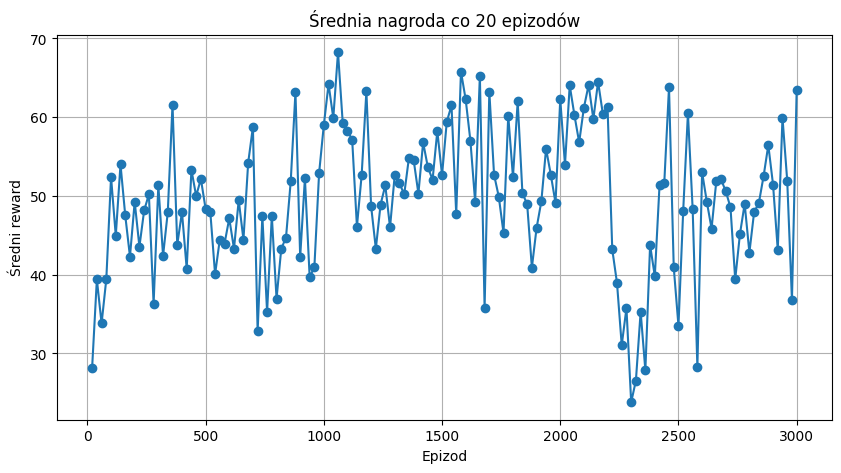

✅ Wykres zapisany jako rewards_plot.png
✅ Nagrody zapisane do pliku all_rewards.txt


In [ ]:
plot_and_save_moving_average(all_rewards3rd,window_size=20, plot_path="rewards_plot.png", txt_path="all_rewards.txt")

In [ ]:
import imageio
import gymnasium as gym
import torch
import numpy as np
import cv2
from collections import deque

model_path = "boxing_dqn_master(6100).pth"
output_filename = "boxing_gameplay_BEST_10.mp4"
stack_size = 4



# Środowisko
env = gym.make("ALE/Boxing-v5", render_mode="rgb_array")
action_dim = env.action_space.n

# Wczytaj model
policy_net = CNN_DQN(action_dim).to(device)
checkpoint = torch.load(model_path, map_location=device)
policy_net.load_state_dict(checkpoint["model_state_dict"])

policy_net.eval()

obs, _ = env.reset()
frame = preprocess_observation(obs)
frame_stack = deque([frame] * stack_size, maxlen=stack_size)
state = np.stack(frame_stack, axis=0)

done = False
total_reward = 0
frames = []

while not done:
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        action = q_values.argmax(1).item()

    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    frame = preprocess_observation(obs)
    frame_stack.append(frame)
    state = np.stack(frame_stack, axis=0)

    rgb_frame = env.render()
    frames.append(rgb_frame)

env.close()

# Zapisz wideo
with imageio.get_writer(output_filename, fps=30) as writer:
    for f in frames:
        writer.append_data(f)

print(f"Zapisano wideo do: {output_filename}")
print(f"Łączna nagroda: {total_reward}")

🎥 Zapisano wideo do: boxing_gameplay_BEST_10.mp4
🏆 Łączna nagroda: 70.0
